# Homework 2
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right???

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [1]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.7.0+cu101 (or something like this)
# CUDA enabled: True

Version 1.10.0+cu111
CUDA enabled: True


In [2]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Mounted at /gdrive
MyDrive  Shareddrives


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to set up the homework3 files.



In [3]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

--2021-11-27 00:16:21--  https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
Resolving courses.cs.washington.edu (courses.cs.washington.edu)... 128.208.1.193, 2607:4000:200:10::c1
Connecting to courses.cs.washington.edu (courses.cs.washington.edu)|128.208.1.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2324076 (2.2M) [application/x-gzip]
Saving to: ‘homework3.tar.gz’

homework3.tar.gz    100%[===================>]   2.22M  2.21MB/s    in 1.0s    

2021-11-27 00:16:22 (2.21 MB/s) - ‘homework3.tar.gz’ saved [2324076/2324076]

harry_potter.txt
pt_util.py


In [4]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [5]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    data = data.replace('\t', ' ')
    data = data.replace('\n', ' ')
    data = re.sub('\\s+', ' ', data)

    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    int_rep = 0
    for char in data:
        if char not in voc2ind.keys():
            voc2ind[char] = int_rep
            int_rep = int_rep + 1

    ind2voc = {val: key for key, val in voc2ind.items()}

    # Iterate through data to get numpy array
    numpy_data = []
    for char in data:
        numpy_data.append(voc2ind[char])

    eighty_percent = int(len(numpy_data) * 0.8)
    train_text, test_text = numpy_data[:eighty_percent], numpy_data[eighty_percent:]

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [6]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.

        # print(dataset['tokens'])
        # print(len(dataset['tokens']))

        dataset_size = int(len(dataset['tokens']) / batch_size) * batch_size
        dataset['tokens'] = dataset['tokens'][0:dataset_size]
        # print(len(dataset['tokens']))

        batch_arrays = np.array_split(dataset['tokens'], batch_size)

        # Fill in an array with idx = correct batch tuple
        num_full_batches = int(((len(dataset['tokens']) / batch_size) - 1) / sequence_length)
        extra_batch_needed = False
        if ((num_full_batches * sequence_length) < ((len(dataset['tokens']) / batch_size) - 1)):
            extra_batch_needed = True

        self.data_mapping = {}
        self.label_mapping = {}
        current_idx = 0
        for batch_num in range(num_full_batches):
            for batch_arr_num in range(len(batch_arrays)):
                data_arr = batch_arrays[batch_arr_num]

                self.data_mapping[current_idx] = data_arr[batch_num*sequence_length : (batch_num+1)*sequence_length]
                self.label_mapping[current_idx] = data_arr[batch_num*sequence_length + 1 : (batch_num+1)*sequence_length + 1]
                current_idx = current_idx + 1

        if extra_batch_needed:
            for batch_arr_num in range(len(batch_arrays)):
                data_arr = batch_arrays[batch_arr_num]

                start_idx = num_full_batches*sequence_length
                num_remaining = len(data_arr) - start_idx

                self.data_mapping[current_idx] = data_arr[start_idx : start_idx + num_remaining - 1]
                self.label_mapping[current_idx] = data_arr[start_idx + 1 : start_idx + num_remaining]
                current_idx = current_idx + 1

        # print(self.data_mapping)
        # print(self.label_mapping)


    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
        return len(self.data_mapping)
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        return self.data_mapping[idx], self.label_mapping[idx]

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [7]:
TEMPERATURE = 2

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)
        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [8]:
TEMPERATURE = 2
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        max_idx = output[0].argmax()
        outputs.append(max_idx)
        output, hidden = model.inference(max_idx, hidden)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        sample_idx = torch.multinomial(output[0], 1)
        outputs.append(sample_idx)
        output, hidden = model.inference(sample_idx, hidden)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    # beam = [([], output, hidden, 0)]
    beam = []
    temp = []
    sort = torch.argsort(torch.log(output))[0][-beam_width:]
    for i in sort:
        beam.append(([i], output, hidden, torch.log(output[0][i]))) 
    for ii in range(sequence_length):
        new_beam = []
        for b in beam:
          idx = torch.LongTensor([b[0][len(b[0])-1]])
          output, hidden = model.inference(idx.cuda(), b[2], TEMPERATURE) # run through model
          samples = torch.multinomial(output, beam_width)  # computing pr(x | beam)
          for s in samples[0]: 
            # step: new_beam = beam
            # step: new_beam += s
            new_idx = b[0] + [s]
            score = b[3] + torch.log(output[0][s])
            new_beam.append((new_idx, output, hidden, score))
        new_beam.sort(key=lambda b : b[3], reverse=True) # sorting new beams
        beam = new_beam[:beam_width]

    return beam[0][0]



def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [9]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2
Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	dRP))9=GU\R=iBtB88)B)GBiRifX(\d9C)CaiX))XBBi88888%


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	d888d9qbqUUUYSG=88dV)PnU%G=88dBd)Pn8d88888e {nB9=9


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	oGG)GYUC)=qb$LPdriX)sdiBBBBB))ndC)8P)GYw(zS888qP)=


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	iLv%bBBGPd9C)=GU9)Pn%U%UFd,d))ndC))X))Cw(zS888qP)=


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	())\(\YiBBBYYUww74\Yf;B7C)Cr7UY88=qUdUC)Ctc))%B7fR


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	RifX(\

  0%|          | 1/390 [00:00<01:15,  5.15it/s]

Train Epoch: 0 [0/99840 (0%)]	Loss: 16.677467


  3%|▎         | 13/390 [00:01<00:33, 11.22it/s]

Train Epoch: 0 [2560/99840 (3%)]	Loss: 6.984111


  6%|▌         | 23/390 [00:02<00:32, 11.43it/s]

Train Epoch: 0 [5120/99840 (5%)]	Loss: 4.256462


  8%|▊         | 33/390 [00:02<00:31, 11.45it/s]

Train Epoch: 0 [7680/99840 (8%)]	Loss: 2.998940


 11%|█         | 43/390 [00:03<00:29, 11.69it/s]

Train Epoch: 0 [10240/99840 (10%)]	Loss: 2.482592


 14%|█▎        | 53/390 [00:04<00:29, 11.38it/s]

Train Epoch: 0 [12800/99840 (13%)]	Loss: 2.271170


 16%|█▌        | 63/390 [00:05<00:28, 11.29it/s]

Train Epoch: 0 [15360/99840 (15%)]	Loss: 2.213384


 19%|█▊        | 73/390 [00:06<00:27, 11.52it/s]

Train Epoch: 0 [17920/99840 (18%)]	Loss: 2.151282


 21%|██▏       | 83/390 [00:07<00:26, 11.48it/s]

Train Epoch: 0 [20480/99840 (21%)]	Loss: 2.180974


 24%|██▍       | 93/390 [00:08<00:25, 11.57it/s]

Train Epoch: 0 [23040/99840 (23%)]	Loss: 2.083036


 26%|██▋       | 103/390 [00:09<00:24, 11.67it/s]

Train Epoch: 0 [25600/99840 (26%)]	Loss: 1.946157


 29%|██▉       | 113/390 [00:09<00:24, 11.43it/s]

Train Epoch: 0 [28160/99840 (28%)]	Loss: 1.962195


 32%|███▏      | 123/390 [00:10<00:23, 11.36it/s]

Train Epoch: 0 [30720/99840 (31%)]	Loss: 1.906710


 34%|███▍      | 133/390 [00:11<00:22, 11.32it/s]

Train Epoch: 0 [33280/99840 (33%)]	Loss: 1.836422


 37%|███▋      | 143/390 [00:12<00:21, 11.24it/s]

Train Epoch: 0 [35840/99840 (36%)]	Loss: 2.074781


 39%|███▉      | 153/390 [00:13<00:20, 11.37it/s]

Train Epoch: 0 [38400/99840 (38%)]	Loss: 2.887964


 42%|████▏     | 163/390 [00:14<00:20, 11.30it/s]

Train Epoch: 0 [40960/99840 (41%)]	Loss: 2.394138


 44%|████▍     | 173/390 [00:15<00:19, 11.34it/s]

Train Epoch: 0 [43520/99840 (44%)]	Loss: 2.043257


 47%|████▋     | 183/390 [00:16<00:18, 11.32it/s]

Train Epoch: 0 [46080/99840 (46%)]	Loss: 1.891291


 49%|████▉     | 193/390 [00:16<00:17, 11.30it/s]

Train Epoch: 0 [48640/99840 (49%)]	Loss: 1.868701


 52%|█████▏    | 203/390 [00:17<00:16, 11.14it/s]

Train Epoch: 0 [51200/99840 (51%)]	Loss: 1.816896


 55%|█████▍    | 213/390 [00:18<00:15, 11.08it/s]

Train Epoch: 0 [53760/99840 (54%)]	Loss: 1.817484


 57%|█████▋    | 223/390 [00:19<00:14, 11.26it/s]

Train Epoch: 0 [56320/99840 (56%)]	Loss: 1.812941


 60%|█████▉    | 233/390 [00:20<00:13, 11.36it/s]

Train Epoch: 0 [58880/99840 (59%)]	Loss: 1.870137


 62%|██████▏   | 243/390 [00:21<00:12, 11.58it/s]

Train Epoch: 0 [61440/99840 (62%)]	Loss: 1.886869


 65%|██████▍   | 253/390 [00:22<00:11, 11.45it/s]

Train Epoch: 0 [64000/99840 (64%)]	Loss: 1.795759


 67%|██████▋   | 263/390 [00:23<00:11, 11.26it/s]

Train Epoch: 0 [66560/99840 (67%)]	Loss: 1.806389


 70%|███████   | 273/390 [00:24<00:10, 11.41it/s]

Train Epoch: 0 [69120/99840 (69%)]	Loss: 1.761168


 73%|███████▎  | 283/390 [00:24<00:09, 11.38it/s]

Train Epoch: 0 [71680/99840 (72%)]	Loss: 1.782775


 75%|███████▌  | 293/390 [00:25<00:08, 11.29it/s]

Train Epoch: 0 [74240/99840 (74%)]	Loss: 1.727719


 78%|███████▊  | 303/390 [00:26<00:07, 11.30it/s]

Train Epoch: 0 [76800/99840 (77%)]	Loss: 1.727740


 80%|████████  | 313/390 [00:27<00:06, 11.38it/s]

Train Epoch: 0 [79360/99840 (79%)]	Loss: 1.736914


 83%|████████▎ | 323/390 [00:28<00:05, 11.39it/s]

Train Epoch: 0 [81920/99840 (82%)]	Loss: 1.755529


 85%|████████▌ | 333/390 [00:29<00:05, 11.40it/s]

Train Epoch: 0 [84480/99840 (85%)]	Loss: 1.891642


 88%|████████▊ | 343/390 [00:30<00:04, 11.36it/s]

Train Epoch: 0 [87040/99840 (87%)]	Loss: 1.736338


 91%|█████████ | 353/390 [00:31<00:03, 11.31it/s]

Train Epoch: 0 [89600/99840 (90%)]	Loss: 1.744867


 93%|█████████▎| 363/390 [00:31<00:02, 11.35it/s]

Train Epoch: 0 [92160/99840 (92%)]	Loss: 1.762168


 96%|█████████▌| 373/390 [00:32<00:01, 11.18it/s]

Train Epoch: 0 [94720/99840 (95%)]	Loss: 1.779654


 98%|█████████▊| 383/390 [00:33<00:00, 11.34it/s]

Train Epoch: 0 [97280/99840 (97%)]	Loss: 1.841993


100%|██████████| 390/390 [00:34<00:00, 11.37it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	tooat iodnttnd toantd tnann,  toe pane y'tanl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	".. Iou hodnnarl  tary tarl  tarry  " .  "Iun't yo


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	seed toe ppt r,tane  tnd tarry taap d iumbledore a


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpterstoe parnty tai "tarry taadi  tumbledore a


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	e yng tnd toodpeng tntthe lasdle gf the ponk aash 


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain,  tis  "rrrtnlasent, tarry aorugh  

  0%|          | 1/390 [00:00<01:11,  5.48it/s]

Train Epoch: 1 [0/99840 (0%)]	Loss: 1.785141


  3%|▎         | 12/390 [00:01<00:34, 10.91it/s]

Train Epoch: 1 [2560/99840 (3%)]	Loss: 1.696131


  6%|▌         | 22/390 [00:02<00:32, 11.41it/s]

Train Epoch: 1 [5120/99840 (5%)]	Loss: 1.687166


  8%|▊         | 32/390 [00:02<00:31, 11.34it/s]

Train Epoch: 1 [7680/99840 (8%)]	Loss: 1.643439


 11%|█         | 42/390 [00:03<00:31, 11.04it/s]

Train Epoch: 1 [10240/99840 (10%)]	Loss: 1.638109


 13%|█▎        | 52/390 [00:04<00:30, 11.22it/s]

Train Epoch: 1 [12800/99840 (13%)]	Loss: 1.645492


 16%|█▌        | 62/390 [00:05<00:28, 11.47it/s]

Train Epoch: 1 [15360/99840 (15%)]	Loss: 1.709143


 18%|█▊        | 72/390 [00:06<00:28, 11.22it/s]

Train Epoch: 1 [17920/99840 (18%)]	Loss: 1.688345


 21%|██        | 82/390 [00:07<00:27, 11.15it/s]

Train Epoch: 1 [20480/99840 (21%)]	Loss: 1.668444


 24%|██▎       | 92/390 [00:08<00:26, 11.35it/s]

Train Epoch: 1 [23040/99840 (23%)]	Loss: 1.672563


 26%|██▌       | 102/390 [00:09<00:25, 11.23it/s]

Train Epoch: 1 [25600/99840 (26%)]	Loss: 1.680189


 29%|██▊       | 112/390 [00:09<00:24, 11.39it/s]

Train Epoch: 1 [28160/99840 (28%)]	Loss: 1.688818


 31%|███▏      | 122/390 [00:10<00:23, 11.24it/s]

Train Epoch: 1 [30720/99840 (31%)]	Loss: 1.658741


 34%|███▍      | 132/390 [00:11<00:22, 11.40it/s]

Train Epoch: 1 [33280/99840 (33%)]	Loss: 1.580637


 36%|███▋      | 142/390 [00:12<00:21, 11.38it/s]

Train Epoch: 1 [35840/99840 (36%)]	Loss: 1.599729


 39%|███▉      | 152/390 [00:13<00:20, 11.41it/s]

Train Epoch: 1 [38400/99840 (38%)]	Loss: 1.654301


 42%|████▏     | 162/390 [00:14<00:19, 11.46it/s]

Train Epoch: 1 [40960/99840 (41%)]	Loss: 1.575669


 44%|████▍     | 172/390 [00:15<00:19, 11.47it/s]

Train Epoch: 1 [43520/99840 (44%)]	Loss: 1.608051


 47%|████▋     | 182/390 [00:16<00:18, 11.36it/s]

Train Epoch: 1 [46080/99840 (46%)]	Loss: 1.604552


 49%|████▉     | 192/390 [00:17<00:17, 11.23it/s]

Train Epoch: 1 [48640/99840 (49%)]	Loss: 1.647227


 52%|█████▏    | 202/390 [00:17<00:16, 11.39it/s]

Train Epoch: 1 [51200/99840 (51%)]	Loss: 1.628399


 54%|█████▍    | 212/390 [00:18<00:15, 11.31it/s]

Train Epoch: 1 [53760/99840 (54%)]	Loss: 1.625172


 57%|█████▋    | 222/390 [00:19<00:14, 11.56it/s]

Train Epoch: 1 [56320/99840 (56%)]	Loss: 1.620526


 59%|█████▉    | 232/390 [00:20<00:14, 11.24it/s]

Train Epoch: 1 [58880/99840 (59%)]	Loss: 1.577531


 62%|██████▏   | 242/390 [00:21<00:13, 11.24it/s]

Train Epoch: 1 [61440/99840 (62%)]	Loss: 1.601375


 65%|██████▍   | 252/390 [00:22<00:12, 11.33it/s]

Train Epoch: 1 [64000/99840 (64%)]	Loss: 1.577242


 67%|██████▋   | 262/390 [00:23<00:11, 11.50it/s]

Train Epoch: 1 [66560/99840 (67%)]	Loss: 1.580610


 70%|██████▉   | 272/390 [00:24<00:10, 11.29it/s]

Train Epoch: 1 [69120/99840 (69%)]	Loss: 1.563364


 72%|███████▏  | 282/390 [00:24<00:09, 11.45it/s]

Train Epoch: 1 [71680/99840 (72%)]	Loss: 1.623870


 75%|███████▍  | 292/390 [00:25<00:08, 11.47it/s]

Train Epoch: 1 [74240/99840 (74%)]	Loss: 1.739755


 77%|███████▋  | 302/390 [00:26<00:07, 11.45it/s]

Train Epoch: 1 [76800/99840 (77%)]	Loss: 1.803179


 80%|████████  | 312/390 [00:27<00:06, 11.31it/s]

Train Epoch: 1 [79360/99840 (79%)]	Loss: 1.655831


 83%|████████▎ | 322/390 [00:28<00:06, 11.30it/s]

Train Epoch: 1 [81920/99840 (82%)]	Loss: 1.594892


 85%|████████▌ | 332/390 [00:29<00:05, 11.36it/s]

Train Epoch: 1 [84480/99840 (85%)]	Loss: 1.620609


 88%|████████▊ | 342/390 [00:30<00:04, 11.26it/s]

Train Epoch: 1 [87040/99840 (87%)]	Loss: 1.530450


 90%|█████████ | 352/390 [00:31<00:03, 11.28it/s]

Train Epoch: 1 [89600/99840 (90%)]	Loss: 1.567142


 93%|█████████▎| 362/390 [00:31<00:02, 11.25it/s]

Train Epoch: 1 [92160/99840 (92%)]	Loss: 1.549978


 95%|█████████▌| 372/390 [00:32<00:01, 11.34it/s]

Train Epoch: 1 [94720/99840 (95%)]	Loss: 1.566286


 98%|█████████▊| 382/390 [00:33<00:00, 11.60it/s]

Train Epoch: 1 [97280/99840 (97%)]	Loss: 1.547621


100%|██████████| 390/390 [00:34<00:00, 11.35it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	tooat totnttnd loastd tnain,t toe woneraatesl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	H.. wou wod nanl  tery werl  tarry  " .  "Ion't yo


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ss d toe wnt rstoner tnd tarry waap d tumbledore.t


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpderstoe wtanei ati  tarry waaded tumbledore.t


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	er.ng htd loanpeng hn the casdle of the work aasht


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tis  "rr anlesent  tarry woough  

  0%|          | 1/390 [00:00<01:09,  5.59it/s]

Train Epoch: 2 [0/99840 (0%)]	Loss: 1.583373


  3%|▎         | 12/390 [00:01<00:33, 11.19it/s]

Train Epoch: 2 [2560/99840 (3%)]	Loss: 1.566632


  6%|▌         | 22/390 [00:02<00:32, 11.30it/s]

Train Epoch: 2 [5120/99840 (5%)]	Loss: 1.555531


  8%|▊         | 32/390 [00:02<00:31, 11.33it/s]

Train Epoch: 2 [7680/99840 (8%)]	Loss: 1.527319


 11%|█         | 42/390 [00:03<00:30, 11.51it/s]

Train Epoch: 2 [10240/99840 (10%)]	Loss: 1.521928


 13%|█▎        | 52/390 [00:04<00:29, 11.43it/s]

Train Epoch: 2 [12800/99840 (13%)]	Loss: 1.524271


 16%|█▌        | 62/390 [00:05<00:28, 11.54it/s]

Train Epoch: 2 [15360/99840 (15%)]	Loss: 1.574785


 18%|█▊        | 72/390 [00:06<00:28, 11.35it/s]

Train Epoch: 2 [17920/99840 (18%)]	Loss: 1.600929


 21%|██        | 82/390 [00:07<00:27, 11.36it/s]

Train Epoch: 2 [20480/99840 (21%)]	Loss: 1.555501


 24%|██▎       | 92/390 [00:08<00:26, 11.33it/s]

Train Epoch: 2 [23040/99840 (23%)]	Loss: 1.564676


 26%|██▌       | 102/390 [00:09<00:25, 11.34it/s]

Train Epoch: 2 [25600/99840 (26%)]	Loss: 1.501584


 29%|██▊       | 112/390 [00:09<00:24, 11.44it/s]

Train Epoch: 2 [28160/99840 (28%)]	Loss: 1.540921


 31%|███▏      | 122/390 [00:10<00:23, 11.41it/s]

Train Epoch: 2 [30720/99840 (31%)]	Loss: 1.531485


 34%|███▍      | 132/390 [00:11<00:22, 11.23it/s]

Train Epoch: 2 [33280/99840 (33%)]	Loss: 1.482952


 36%|███▋      | 142/390 [00:12<00:21, 11.47it/s]

Train Epoch: 2 [35840/99840 (36%)]	Loss: 1.514256


 39%|███▉      | 152/390 [00:13<00:20, 11.42it/s]

Train Epoch: 2 [38400/99840 (38%)]	Loss: 1.563208


 42%|████▏     | 162/390 [00:14<00:20, 11.35it/s]

Train Epoch: 2 [40960/99840 (41%)]	Loss: 1.500118


 44%|████▍     | 172/390 [00:15<00:18, 11.52it/s]

Train Epoch: 2 [43520/99840 (44%)]	Loss: 1.520915


 47%|████▋     | 182/390 [00:16<00:18, 11.42it/s]

Train Epoch: 2 [46080/99840 (46%)]	Loss: 1.512382


 49%|████▉     | 192/390 [00:16<00:17, 11.49it/s]

Train Epoch: 2 [48640/99840 (49%)]	Loss: 1.542101


 52%|█████▏    | 202/390 [00:17<00:16, 11.53it/s]

Train Epoch: 2 [51200/99840 (51%)]	Loss: 1.510330


 54%|█████▍    | 212/390 [00:18<00:15, 11.45it/s]

Train Epoch: 2 [53760/99840 (54%)]	Loss: 1.525552


 57%|█████▋    | 222/390 [00:19<00:14, 11.38it/s]

Train Epoch: 2 [56320/99840 (56%)]	Loss: 1.501912


 59%|█████▉    | 232/390 [00:20<00:13, 11.42it/s]

Train Epoch: 2 [58880/99840 (59%)]	Loss: 1.478931


 62%|██████▏   | 242/390 [00:21<00:13, 11.37it/s]

Train Epoch: 2 [61440/99840 (62%)]	Loss: 1.510006


 65%|██████▍   | 252/390 [00:22<00:12, 11.23it/s]

Train Epoch: 2 [64000/99840 (64%)]	Loss: 1.503710


 67%|██████▋   | 262/390 [00:23<00:11, 11.40it/s]

Train Epoch: 2 [66560/99840 (67%)]	Loss: 1.515541


 70%|██████▉   | 272/390 [00:23<00:10, 11.47it/s]

Train Epoch: 2 [69120/99840 (69%)]	Loss: 1.483527


 72%|███████▏  | 282/390 [00:24<00:09, 11.51it/s]

Train Epoch: 2 [71680/99840 (72%)]	Loss: 1.521867


 75%|███████▍  | 292/390 [00:25<00:08, 11.34it/s]

Train Epoch: 2 [74240/99840 (74%)]	Loss: 1.497347


 77%|███████▋  | 302/390 [00:26<00:07, 11.35it/s]

Train Epoch: 2 [76800/99840 (77%)]	Loss: 1.498473


 80%|████████  | 312/390 [00:27<00:06, 11.37it/s]

Train Epoch: 2 [79360/99840 (79%)]	Loss: 1.493145


 83%|████████▎ | 322/390 [00:28<00:05, 11.39it/s]

Train Epoch: 2 [81920/99840 (82%)]	Loss: 1.494984


 85%|████████▌ | 332/390 [00:29<00:05, 11.40it/s]

Train Epoch: 2 [84480/99840 (85%)]	Loss: 1.547580


 88%|████████▊ | 342/390 [00:30<00:04, 11.40it/s]

Train Epoch: 2 [87040/99840 (87%)]	Loss: 1.457637


 90%|█████████ | 352/390 [00:30<00:03, 11.51it/s]

Train Epoch: 2 [89600/99840 (90%)]	Loss: 1.496454


 93%|█████████▎| 362/390 [00:31<00:02, 11.49it/s]

Train Epoch: 2 [92160/99840 (92%)]	Loss: 1.483948


 95%|█████████▌| 372/390 [00:32<00:01, 11.39it/s]

Train Epoch: 2 [94720/99840 (95%)]	Loss: 1.509527


 98%|█████████▊| 382/390 [00:33<00:00, 11.44it/s]

Train Epoch: 2 [97280/99840 (97%)]	Loss: 1.491115


100%|██████████| 390/390 [00:34<00:00, 11.39it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	tooat todnttnd loantd tnain.t toe tome .otisl  "W 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	H.. wou wod narl  tery terl  tarry  " .  "Io 't yo


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ss d toe tnt rstone  tnd tarry taap d tumbledore t


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder toe ttonei ati  tarry taaded tumbledore t


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	ereng ttd toanpeng hn the caddle of the womk aasht


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tis  "ir tnlasent  tarry woough  

  0%|          | 1/390 [00:00<01:11,  5.40it/s]

Train Epoch: 3 [0/99840 (0%)]	Loss: 1.532159


  3%|▎         | 13/390 [00:01<00:34, 11.04it/s]

Train Epoch: 3 [2560/99840 (3%)]	Loss: 1.502158


  6%|▌         | 23/390 [00:02<00:31, 11.49it/s]

Train Epoch: 3 [5120/99840 (5%)]	Loss: 1.495109


  8%|▊         | 33/390 [00:03<00:31, 11.51it/s]

Train Epoch: 3 [7680/99840 (8%)]	Loss: 1.466621


 11%|█         | 43/390 [00:03<00:30, 11.27it/s]

Train Epoch: 3 [10240/99840 (10%)]	Loss: 1.467939


 14%|█▎        | 53/390 [00:04<00:29, 11.43it/s]

Train Epoch: 3 [12800/99840 (13%)]	Loss: 1.481127


 16%|█▌        | 63/390 [00:05<00:28, 11.42it/s]

Train Epoch: 3 [15360/99840 (15%)]	Loss: 1.512297


 19%|█▊        | 73/390 [00:06<00:27, 11.44it/s]

Train Epoch: 3 [17920/99840 (18%)]	Loss: 1.501730


 21%|██▏       | 83/390 [00:07<00:26, 11.39it/s]

Train Epoch: 3 [20480/99840 (21%)]	Loss: 1.492269


 24%|██▍       | 93/390 [00:08<00:25, 11.46it/s]

Train Epoch: 3 [23040/99840 (23%)]	Loss: 1.504872


 26%|██▋       | 103/390 [00:09<00:25, 11.48it/s]

Train Epoch: 3 [25600/99840 (26%)]	Loss: 1.442098


 29%|██▉       | 113/390 [00:10<00:24, 11.43it/s]

Train Epoch: 3 [28160/99840 (28%)]	Loss: 1.489090


 32%|███▏      | 123/390 [00:10<00:23, 11.47it/s]

Train Epoch: 3 [30720/99840 (31%)]	Loss: 1.476548


 34%|███▍      | 133/390 [00:11<00:22, 11.34it/s]

Train Epoch: 3 [33280/99840 (33%)]	Loss: 1.427424


 37%|███▋      | 143/390 [00:12<00:21, 11.52it/s]

Train Epoch: 3 [35840/99840 (36%)]	Loss: 1.461588


 39%|███▉      | 153/390 [00:13<00:20, 11.38it/s]

Train Epoch: 3 [38400/99840 (38%)]	Loss: 1.505901


 42%|████▏     | 163/390 [00:14<00:20, 11.15it/s]

Train Epoch: 3 [40960/99840 (41%)]	Loss: 1.431543


 44%|████▍     | 173/390 [00:15<00:18, 11.43it/s]

Train Epoch: 3 [43520/99840 (44%)]	Loss: 1.476771


 47%|████▋     | 183/390 [00:16<00:18, 11.40it/s]

Train Epoch: 3 [46080/99840 (46%)]	Loss: 1.461002


 49%|████▉     | 193/390 [00:17<00:17, 11.45it/s]

Train Epoch: 3 [48640/99840 (49%)]	Loss: 1.491720


 52%|█████▏    | 203/390 [00:17<00:16, 11.32it/s]

Train Epoch: 3 [51200/99840 (51%)]	Loss: 1.459344


 55%|█████▍    | 213/390 [00:18<00:15, 11.28it/s]

Train Epoch: 3 [53760/99840 (54%)]	Loss: 1.465424


 57%|█████▋    | 223/390 [00:19<00:14, 11.29it/s]

Train Epoch: 3 [56320/99840 (56%)]	Loss: 1.456222


 60%|█████▉    | 233/390 [00:20<00:13, 11.31it/s]

Train Epoch: 3 [58880/99840 (59%)]	Loss: 1.428325


 62%|██████▏   | 243/390 [00:21<00:12, 11.31it/s]

Train Epoch: 3 [61440/99840 (62%)]	Loss: 1.458359


 65%|██████▍   | 253/390 [00:22<00:12, 11.12it/s]

Train Epoch: 3 [64000/99840 (64%)]	Loss: 1.462301


 67%|██████▋   | 263/390 [00:23<00:11, 11.35it/s]

Train Epoch: 3 [66560/99840 (67%)]	Loss: 1.470110


 70%|███████   | 273/390 [00:24<00:10, 11.37it/s]

Train Epoch: 3 [69120/99840 (69%)]	Loss: 1.441774


 73%|███████▎  | 283/390 [00:24<00:09, 11.44it/s]

Train Epoch: 3 [71680/99840 (72%)]	Loss: 1.461460


 75%|███████▌  | 293/390 [00:25<00:08, 11.44it/s]

Train Epoch: 3 [74240/99840 (74%)]	Loss: 1.446579


 78%|███████▊  | 303/390 [00:26<00:07, 11.40it/s]

Train Epoch: 3 [76800/99840 (77%)]	Loss: 1.451193


 80%|████████  | 313/390 [00:27<00:06, 11.44it/s]

Train Epoch: 3 [79360/99840 (79%)]	Loss: 1.448776


 83%|████████▎ | 323/390 [00:28<00:05, 11.37it/s]

Train Epoch: 3 [81920/99840 (82%)]	Loss: 1.444679


 85%|████████▌ | 333/390 [00:29<00:04, 11.41it/s]

Train Epoch: 3 [84480/99840 (85%)]	Loss: 1.496850


 88%|████████▊ | 343/390 [00:30<00:04, 11.56it/s]

Train Epoch: 3 [87040/99840 (87%)]	Loss: 1.408777


 91%|█████████ | 353/390 [00:31<00:03, 11.44it/s]

Train Epoch: 3 [89600/99840 (90%)]	Loss: 1.456452


 93%|█████████▎| 363/390 [00:31<00:02, 11.38it/s]

Train Epoch: 3 [92160/99840 (92%)]	Loss: 1.447882


 96%|█████████▌| 373/390 [00:32<00:01, 11.45it/s]

Train Epoch: 3 [94720/99840 (95%)]	Loss: 1.470821


 98%|█████████▊| 383/390 [00:33<00:00, 11.35it/s]

Train Epoch: 3 [97280/99840 (97%)]	Loss: 1.450325


100%|██████████| 390/390 [00:34<00:00, 11.37it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	troat todnttnd soaded tnain.t toe tose aotasl. "W 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	H.. aou hod na l  tery tarl, tarry  " .  "Io 't yh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ss d toe bnt r aose  and tarry aaap d tumbledore t


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder toe wtanti ati  tarry aaaded humbledore t


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	ering hnd toanpeng hn the caddle of the work aash 


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tis  "ir ansament  tarry aoough  

  0%|          | 1/390 [00:00<01:14,  5.25it/s]

Train Epoch: 4 [0/99840 (0%)]	Loss: 1.474245


  3%|▎         | 12/390 [00:01<00:33, 11.13it/s]

Train Epoch: 4 [2560/99840 (3%)]	Loss: 1.453853


  6%|▌         | 22/390 [00:02<00:32, 11.49it/s]

Train Epoch: 4 [5120/99840 (5%)]	Loss: 1.457554


  8%|▊         | 32/390 [00:02<00:31, 11.31it/s]

Train Epoch: 4 [7680/99840 (8%)]	Loss: 1.425129


 11%|█         | 42/390 [00:03<00:31, 11.15it/s]

Train Epoch: 4 [10240/99840 (10%)]	Loss: 1.430715


 13%|█▎        | 52/390 [00:04<00:29, 11.30it/s]

Train Epoch: 4 [12800/99840 (13%)]	Loss: 1.431732


 16%|█▌        | 62/390 [00:05<00:28, 11.39it/s]

Train Epoch: 4 [15360/99840 (15%)]	Loss: 1.465186


 18%|█▊        | 72/390 [00:06<00:28, 11.33it/s]

Train Epoch: 4 [17920/99840 (18%)]	Loss: 1.460716


 21%|██        | 82/390 [00:07<00:27, 11.39it/s]

Train Epoch: 4 [20480/99840 (21%)]	Loss: 1.460329


 24%|██▎       | 92/390 [00:08<00:26, 11.26it/s]

Train Epoch: 4 [23040/99840 (23%)]	Loss: 1.467371


 26%|██▌       | 102/390 [00:09<00:25, 11.51it/s]

Train Epoch: 4 [25600/99840 (26%)]	Loss: 1.405722


 29%|██▊       | 112/390 [00:09<00:24, 11.43it/s]

Train Epoch: 4 [28160/99840 (28%)]	Loss: 1.461479


 31%|███▏      | 122/390 [00:10<00:23, 11.52it/s]

Train Epoch: 4 [30720/99840 (31%)]	Loss: 1.449286


 34%|███▍      | 132/390 [00:11<00:22, 11.37it/s]

Train Epoch: 4 [33280/99840 (33%)]	Loss: 1.399995


 36%|███▋      | 142/390 [00:12<00:21, 11.49it/s]

Train Epoch: 4 [35840/99840 (36%)]	Loss: 1.434970


 39%|███▉      | 152/390 [00:13<00:21, 11.31it/s]

Train Epoch: 4 [38400/99840 (38%)]	Loss: 1.463893


 42%|████▏     | 162/390 [00:14<00:19, 11.47it/s]

Train Epoch: 4 [40960/99840 (41%)]	Loss: 1.397443


 44%|████▍     | 172/390 [00:15<00:19, 11.37it/s]

Train Epoch: 4 [43520/99840 (44%)]	Loss: 1.442423


 47%|████▋     | 182/390 [00:16<00:18, 11.46it/s]

Train Epoch: 4 [46080/99840 (46%)]	Loss: 1.427501


 49%|████▉     | 192/390 [00:16<00:17, 11.36it/s]

Train Epoch: 4 [48640/99840 (49%)]	Loss: 1.469157


 52%|█████▏    | 202/390 [00:17<00:16, 11.46it/s]

Train Epoch: 4 [51200/99840 (51%)]	Loss: 1.434952


 54%|█████▍    | 212/390 [00:18<00:15, 11.39it/s]

Train Epoch: 4 [53760/99840 (54%)]	Loss: 1.439894


 57%|█████▋    | 222/390 [00:19<00:14, 11.50it/s]

Train Epoch: 4 [56320/99840 (56%)]	Loss: 1.433713


 59%|█████▉    | 232/390 [00:20<00:13, 11.41it/s]

Train Epoch: 4 [58880/99840 (59%)]	Loss: 1.401051


 62%|██████▏   | 242/390 [00:21<00:12, 11.44it/s]

Train Epoch: 4 [61440/99840 (62%)]	Loss: 1.431273


 65%|██████▍   | 252/390 [00:22<00:12, 11.37it/s]

Train Epoch: 4 [64000/99840 (64%)]	Loss: 1.431936


 67%|██████▋   | 262/390 [00:23<00:11, 11.23it/s]

Train Epoch: 4 [66560/99840 (67%)]	Loss: 1.437141


 70%|██████▉   | 272/390 [00:23<00:10, 11.43it/s]

Train Epoch: 4 [69120/99840 (69%)]	Loss: 1.418865


 72%|███████▏  | 282/390 [00:24<00:09, 11.46it/s]

Train Epoch: 4 [71680/99840 (72%)]	Loss: 1.444315


 75%|███████▍  | 292/390 [00:25<00:08, 11.51it/s]

Train Epoch: 4 [74240/99840 (74%)]	Loss: 1.413700


 77%|███████▋  | 302/390 [00:26<00:07, 11.53it/s]

Train Epoch: 4 [76800/99840 (77%)]	Loss: 1.415838


 80%|████████  | 312/390 [00:27<00:06, 11.44it/s]

Train Epoch: 4 [79360/99840 (79%)]	Loss: 1.422256


 83%|████████▎ | 322/390 [00:28<00:05, 11.50it/s]

Train Epoch: 4 [81920/99840 (82%)]	Loss: 1.419766


 85%|████████▌ | 332/390 [00:29<00:05, 11.55it/s]

Train Epoch: 4 [84480/99840 (85%)]	Loss: 1.461282


 88%|████████▊ | 342/390 [00:30<00:04, 11.25it/s]

Train Epoch: 4 [87040/99840 (87%)]	Loss: 1.389682


 90%|█████████ | 352/390 [00:30<00:03, 11.51it/s]

Train Epoch: 4 [89600/99840 (90%)]	Loss: 1.436096


 93%|█████████▎| 362/390 [00:31<00:02, 11.43it/s]

Train Epoch: 4 [92160/99840 (92%)]	Loss: 1.421908


 95%|█████████▌| 372/390 [00:32<00:01, 11.49it/s]

Train Epoch: 4 [94720/99840 (95%)]	Loss: 1.450149


 98%|█████████▊| 382/390 [00:33<00:00, 11.40it/s]

Train Epoch: 4 [97280/99840 (97%)]	Loss: 1.441593


100%|██████████| 390/390 [00:34<00:00, 11.39it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	tooat tognttnd soaned tnain.t the sose setisk. "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . aou codnna l  tery sorl, tarry  " .  HIo 't yh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ss d toe fnt r aose  and tarry saap d humbledore h


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the saanei aai. tarry aaaded humbledore h


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	ering hnd soanpeng hntthe faddle of the sark aash 


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tis. "rr ansoment  tarry soought 

  0%|          | 1/390 [00:00<01:13,  5.33it/s]

Train Epoch: 5 [0/99840 (0%)]	Loss: 1.424777


  3%|▎         | 13/390 [00:01<00:33, 11.21it/s]

Train Epoch: 5 [2560/99840 (3%)]	Loss: 1.412016


  6%|▌         | 23/390 [00:02<00:32, 11.44it/s]

Train Epoch: 5 [5120/99840 (5%)]	Loss: 1.421097


  8%|▊         | 33/390 [00:03<00:31, 11.38it/s]

Train Epoch: 5 [7680/99840 (8%)]	Loss: 1.394531


 11%|█         | 43/390 [00:03<00:30, 11.34it/s]

Train Epoch: 5 [10240/99840 (10%)]	Loss: 1.410160


 14%|█▎        | 53/390 [00:04<00:29, 11.54it/s]

Train Epoch: 5 [12800/99840 (13%)]	Loss: 1.408925


 16%|█▌        | 63/390 [00:05<00:28, 11.42it/s]

Train Epoch: 5 [15360/99840 (15%)]	Loss: 1.440533


 19%|█▊        | 73/390 [00:06<00:27, 11.39it/s]

Train Epoch: 5 [17920/99840 (18%)]	Loss: 1.439872


 21%|██▏       | 83/390 [00:07<00:27, 11.22it/s]

Train Epoch: 5 [20480/99840 (21%)]	Loss: 1.422547


 24%|██▍       | 93/390 [00:08<00:26, 11.22it/s]

Train Epoch: 5 [23040/99840 (23%)]	Loss: 1.449771


 26%|██▋       | 103/390 [00:09<00:24, 11.51it/s]

Train Epoch: 5 [25600/99840 (26%)]	Loss: 1.386263


 29%|██▉       | 113/390 [00:10<00:24, 11.44it/s]

Train Epoch: 5 [28160/99840 (28%)]	Loss: 1.440501


 32%|███▏      | 123/390 [00:10<00:23, 11.53it/s]

Train Epoch: 5 [30720/99840 (31%)]	Loss: 1.427361


 34%|███▍      | 133/390 [00:11<00:22, 11.39it/s]

Train Epoch: 5 [33280/99840 (33%)]	Loss: 1.382101


 37%|███▋      | 143/390 [00:12<00:21, 11.56it/s]

Train Epoch: 5 [35840/99840 (36%)]	Loss: 1.420026


 39%|███▉      | 153/390 [00:13<00:20, 11.35it/s]

Train Epoch: 5 [38400/99840 (38%)]	Loss: 1.426390


 42%|████▏     | 163/390 [00:14<00:20, 11.23it/s]

Train Epoch: 5 [40960/99840 (41%)]	Loss: 1.381671


 44%|████▍     | 173/390 [00:15<00:19, 11.40it/s]

Train Epoch: 5 [43520/99840 (44%)]	Loss: 1.419499


 47%|████▋     | 183/390 [00:16<00:18, 11.45it/s]

Train Epoch: 5 [46080/99840 (46%)]	Loss: 1.400885


 49%|████▉     | 193/390 [00:17<00:17, 11.51it/s]

Train Epoch: 5 [48640/99840 (49%)]	Loss: 1.445194


 52%|█████▏    | 203/390 [00:17<00:16, 11.57it/s]

Train Epoch: 5 [51200/99840 (51%)]	Loss: 1.418753


 55%|█████▍    | 213/390 [00:18<00:15, 11.53it/s]

Train Epoch: 5 [53760/99840 (54%)]	Loss: 1.415941


 57%|█████▋    | 223/390 [00:19<00:14, 11.57it/s]

Train Epoch: 5 [56320/99840 (56%)]	Loss: 1.408308


 60%|█████▉    | 233/390 [00:20<00:13, 11.50it/s]

Train Epoch: 5 [58880/99840 (59%)]	Loss: 1.379953


 62%|██████▏   | 243/390 [00:21<00:12, 11.45it/s]

Train Epoch: 5 [61440/99840 (62%)]	Loss: 1.420937


 65%|██████▍   | 253/390 [00:22<00:11, 11.53it/s]

Train Epoch: 5 [64000/99840 (64%)]	Loss: 1.410978


 67%|██████▋   | 263/390 [00:23<00:10, 11.59it/s]

Train Epoch: 5 [66560/99840 (67%)]	Loss: 1.415092


 70%|███████   | 273/390 [00:23<00:10, 11.56it/s]

Train Epoch: 5 [69120/99840 (69%)]	Loss: 1.404142


 73%|███████▎  | 283/390 [00:24<00:09, 11.39it/s]

Train Epoch: 5 [71680/99840 (72%)]	Loss: 1.426668


 75%|███████▌  | 293/390 [00:25<00:08, 11.28it/s]

Train Epoch: 5 [74240/99840 (74%)]	Loss: 1.394847


 78%|███████▊  | 303/390 [00:26<00:07, 11.37it/s]

Train Epoch: 5 [76800/99840 (77%)]	Loss: 1.405137


 80%|████████  | 313/390 [00:27<00:06, 11.54it/s]

Train Epoch: 5 [79360/99840 (79%)]	Loss: 1.408638


 83%|████████▎ | 323/390 [00:28<00:05, 11.45it/s]

Train Epoch: 5 [81920/99840 (82%)]	Loss: 1.401375


 85%|████████▌ | 333/390 [00:29<00:05, 11.24it/s]

Train Epoch: 5 [84480/99840 (85%)]	Loss: 1.449763


 88%|████████▊ | 343/390 [00:30<00:04, 11.35it/s]

Train Epoch: 5 [87040/99840 (87%)]	Loss: 1.364326


 91%|█████████ | 353/390 [00:30<00:03, 11.38it/s]

Train Epoch: 5 [89600/99840 (90%)]	Loss: 1.416402


 93%|█████████▎| 363/390 [00:31<00:02, 11.38it/s]

Train Epoch: 5 [92160/99840 (92%)]	Loss: 1.401174


 96%|█████████▌| 373/390 [00:32<00:01, 11.34it/s]

Train Epoch: 5 [94720/99840 (95%)]	Loss: 1.448351


 98%|█████████▊| 383/390 [00:33<00:00, 11.57it/s]

Train Epoch: 5 [97280/99840 (97%)]	Loss: 1.422179


100%|██████████| 390/390 [00:34<00:00, 11.41it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toaat sognttnd sosned tnain.t the sose setisk. "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . aou codnna l  tery soll, tarry  " .  "Iu 't yh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed toe fnt r aose  and tarry saad d humbledore s


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpdersthe waanei aai. tarry sa ded tumbledore s


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	ering snd soanpeng hntthe soddle of the sark aash 


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tis  "rr ansoment  harry soough  

  0%|          | 1/390 [00:00<01:03,  6.09it/s]

Train Epoch: 6 [0/99840 (0%)]	Loss: 1.413080


  3%|▎         | 13/390 [00:01<00:33, 11.25it/s]

Train Epoch: 6 [2560/99840 (3%)]	Loss: 1.396198


  6%|▌         | 23/390 [00:02<00:32, 11.23it/s]

Train Epoch: 6 [5120/99840 (5%)]	Loss: 1.408289


  8%|▊         | 33/390 [00:02<00:31, 11.40it/s]

Train Epoch: 6 [7680/99840 (8%)]	Loss: 1.386687


 11%|█         | 43/390 [00:03<00:30, 11.48it/s]

Train Epoch: 6 [10240/99840 (10%)]	Loss: 1.399399


 14%|█▎        | 53/390 [00:04<00:29, 11.61it/s]

Train Epoch: 6 [12800/99840 (13%)]	Loss: 1.392061


 16%|█▌        | 63/390 [00:05<00:28, 11.40it/s]

Train Epoch: 6 [15360/99840 (15%)]	Loss: 1.430470


 19%|█▊        | 73/390 [00:06<00:27, 11.40it/s]

Train Epoch: 6 [17920/99840 (18%)]	Loss: 1.421360


 21%|██▏       | 83/390 [00:07<00:27, 11.23it/s]

Train Epoch: 6 [20480/99840 (21%)]	Loss: 1.404590


 24%|██▍       | 93/390 [00:08<00:25, 11.52it/s]

Train Epoch: 6 [23040/99840 (23%)]	Loss: 1.431886


 26%|██▋       | 103/390 [00:09<00:24, 11.55it/s]

Train Epoch: 6 [25600/99840 (26%)]	Loss: 1.370279


 29%|██▉       | 113/390 [00:09<00:24, 11.33it/s]

Train Epoch: 6 [28160/99840 (28%)]	Loss: 1.426345


 32%|███▏      | 123/390 [00:10<00:23, 11.56it/s]

Train Epoch: 6 [30720/99840 (31%)]	Loss: 1.413334


 34%|███▍      | 133/390 [00:11<00:22, 11.42it/s]

Train Epoch: 6 [33280/99840 (33%)]	Loss: 1.365754


 37%|███▋      | 143/390 [00:12<00:21, 11.39it/s]

Train Epoch: 6 [35840/99840 (36%)]	Loss: 1.415211


 39%|███▉      | 153/390 [00:13<00:21, 11.28it/s]

Train Epoch: 6 [38400/99840 (38%)]	Loss: 1.405374


 42%|████▏     | 163/390 [00:14<00:19, 11.50it/s]

Train Epoch: 6 [40960/99840 (41%)]	Loss: 1.374743


 44%|████▍     | 173/390 [00:15<00:19, 11.38it/s]

Train Epoch: 6 [43520/99840 (44%)]	Loss: 1.415838


 47%|████▋     | 183/390 [00:16<00:18, 11.26it/s]

Train Epoch: 6 [46080/99840 (46%)]	Loss: 1.394914


 49%|████▉     | 193/390 [00:16<00:17, 11.47it/s]

Train Epoch: 6 [48640/99840 (49%)]	Loss: 1.434168


 52%|█████▏    | 203/390 [00:17<00:16, 11.53it/s]

Train Epoch: 6 [51200/99840 (51%)]	Loss: 1.403549


 55%|█████▍    | 213/390 [00:18<00:15, 11.22it/s]

Train Epoch: 6 [53760/99840 (54%)]	Loss: 1.403255


 57%|█████▋    | 223/390 [00:19<00:15, 11.06it/s]

Train Epoch: 6 [56320/99840 (56%)]	Loss: 1.395349


 60%|█████▉    | 233/390 [00:20<00:13, 11.25it/s]

Train Epoch: 6 [58880/99840 (59%)]	Loss: 1.371295


 62%|██████▏   | 243/390 [00:21<00:12, 11.49it/s]

Train Epoch: 6 [61440/99840 (62%)]	Loss: 1.408448


 65%|██████▍   | 253/390 [00:22<00:11, 11.63it/s]

Train Epoch: 6 [64000/99840 (64%)]	Loss: 1.401519


 67%|██████▋   | 263/390 [00:23<00:10, 11.55it/s]

Train Epoch: 6 [66560/99840 (67%)]	Loss: 1.401086


 70%|███████   | 273/390 [00:23<00:10, 11.60it/s]

Train Epoch: 6 [69120/99840 (69%)]	Loss: 1.394637


 73%|███████▎  | 283/390 [00:24<00:09, 11.52it/s]

Train Epoch: 6 [71680/99840 (72%)]	Loss: 1.405948


 75%|███████▌  | 293/390 [00:25<00:08, 11.36it/s]

Train Epoch: 6 [74240/99840 (74%)]	Loss: 1.385638


 78%|███████▊  | 303/390 [00:26<00:07, 11.45it/s]

Train Epoch: 6 [76800/99840 (77%)]	Loss: 1.395157


 80%|████████  | 313/390 [00:27<00:06, 11.45it/s]

Train Epoch: 6 [79360/99840 (79%)]	Loss: 1.397876


 83%|████████▎ | 323/390 [00:28<00:05, 11.38it/s]

Train Epoch: 6 [81920/99840 (82%)]	Loss: 1.390640


 85%|████████▌ | 333/390 [00:29<00:04, 11.51it/s]

Train Epoch: 6 [84480/99840 (85%)]	Loss: 1.438849


 88%|████████▊ | 343/390 [00:30<00:04, 11.67it/s]

Train Epoch: 6 [87040/99840 (87%)]	Loss: 1.359088


 91%|█████████ | 353/390 [00:30<00:03, 11.50it/s]

Train Epoch: 6 [89600/99840 (90%)]	Loss: 1.401980


 93%|█████████▎| 363/390 [00:31<00:02, 11.36it/s]

Train Epoch: 6 [92160/99840 (92%)]	Loss: 1.396551


 96%|█████████▌| 373/390 [00:32<00:01, 11.37it/s]

Train Epoch: 6 [94720/99840 (95%)]	Loss: 1.425349


 98%|█████████▊| 383/390 [00:33<00:00, 11.45it/s]

Train Epoch: 6 [97280/99840 (97%)]	Loss: 1.406118


100%|██████████| 390/390 [00:34<00:00, 11.42it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toaat tolnttnd soaned anain,t the wose  etisk. "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . aou codnna l  tery soll, tarry  " .  "Iun't wh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed toe wnt r aose  and tarry saad d humbledore w


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the wianii aai. tarry waaded humbledore w


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	ering atd soanpeng hntthe coddle of the work aasht


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tim  "or ansoment  harry woough  

  0%|          | 1/390 [00:00<01:13,  5.31it/s]

Train Epoch: 7 [0/99840 (0%)]	Loss: 1.401780


  3%|▎         | 12/390 [00:01<00:33, 11.15it/s]

Train Epoch: 7 [2560/99840 (3%)]	Loss: 1.383483


  6%|▌         | 22/390 [00:02<00:32, 11.50it/s]

Train Epoch: 7 [5120/99840 (5%)]	Loss: 1.400133


  8%|▊         | 32/390 [00:02<00:30, 11.64it/s]

Train Epoch: 7 [7680/99840 (8%)]	Loss: 1.380006


 11%|█         | 42/390 [00:03<00:30, 11.27it/s]

Train Epoch: 7 [10240/99840 (10%)]	Loss: 1.388160


 13%|█▎        | 52/390 [00:04<00:29, 11.54it/s]

Train Epoch: 7 [12800/99840 (13%)]	Loss: 1.383177


 16%|█▌        | 62/390 [00:05<00:28, 11.44it/s]

Train Epoch: 7 [15360/99840 (15%)]	Loss: 1.422975


 18%|█▊        | 72/390 [00:06<00:27, 11.49it/s]

Train Epoch: 7 [17920/99840 (18%)]	Loss: 1.413326


 21%|██        | 82/390 [00:07<00:26, 11.48it/s]

Train Epoch: 7 [20480/99840 (21%)]	Loss: 1.392381


 24%|██▎       | 92/390 [00:08<00:25, 11.51it/s]

Train Epoch: 7 [23040/99840 (23%)]	Loss: 1.424248


 26%|██▌       | 102/390 [00:09<00:25, 11.44it/s]

Train Epoch: 7 [25600/99840 (26%)]	Loss: 1.362772


 29%|██▊       | 112/390 [00:09<00:24, 11.45it/s]

Train Epoch: 7 [28160/99840 (28%)]	Loss: 1.419993


 31%|███▏      | 122/390 [00:10<00:23, 11.24it/s]

Train Epoch: 7 [30720/99840 (31%)]	Loss: 1.404031


 34%|███▍      | 132/390 [00:11<00:22, 11.50it/s]

Train Epoch: 7 [33280/99840 (33%)]	Loss: 1.352345


 36%|███▋      | 142/390 [00:12<00:21, 11.50it/s]

Train Epoch: 7 [35840/99840 (36%)]	Loss: 1.406699


 39%|███▉      | 152/390 [00:13<00:21, 11.22it/s]

Train Epoch: 7 [38400/99840 (38%)]	Loss: 1.391442


 42%|████▏     | 162/390 [00:14<00:20, 11.22it/s]

Train Epoch: 7 [40960/99840 (41%)]	Loss: 1.366544


 44%|████▍     | 172/390 [00:15<00:19, 11.25it/s]

Train Epoch: 7 [43520/99840 (44%)]	Loss: 1.410902


 47%|████▋     | 182/390 [00:16<00:18, 11.44it/s]

Train Epoch: 7 [46080/99840 (46%)]	Loss: 1.394544


 49%|████▉     | 192/390 [00:16<00:17, 11.42it/s]

Train Epoch: 7 [48640/99840 (49%)]	Loss: 1.425270


 52%|█████▏    | 202/390 [00:17<00:16, 11.47it/s]

Train Epoch: 7 [51200/99840 (51%)]	Loss: 1.400310


 54%|█████▍    | 212/390 [00:18<00:15, 11.48it/s]

Train Epoch: 7 [53760/99840 (54%)]	Loss: 1.396841


 57%|█████▋    | 222/390 [00:19<00:14, 11.52it/s]

Train Epoch: 7 [56320/99840 (56%)]	Loss: 1.389698


 59%|█████▉    | 232/390 [00:20<00:13, 11.46it/s]

Train Epoch: 7 [58880/99840 (59%)]	Loss: 1.367516


 62%|██████▏   | 242/390 [00:21<00:12, 11.51it/s]

Train Epoch: 7 [61440/99840 (62%)]	Loss: 1.391988


 65%|██████▍   | 252/390 [00:22<00:12, 11.40it/s]

Train Epoch: 7 [64000/99840 (64%)]	Loss: 1.395699


 67%|██████▋   | 262/390 [00:23<00:11, 11.57it/s]

Train Epoch: 7 [66560/99840 (67%)]	Loss: 1.400480


 70%|██████▉   | 272/390 [00:23<00:10, 11.53it/s]

Train Epoch: 7 [69120/99840 (69%)]	Loss: 1.393682


 72%|███████▏  | 282/390 [00:24<00:09, 11.32it/s]

Train Epoch: 7 [71680/99840 (72%)]	Loss: 1.404717


 75%|███████▍  | 292/390 [00:25<00:08, 11.32it/s]

Train Epoch: 7 [74240/99840 (74%)]	Loss: 1.384414


 77%|███████▋  | 302/390 [00:26<00:07, 11.22it/s]

Train Epoch: 7 [76800/99840 (77%)]	Loss: 1.388161


 80%|████████  | 312/390 [00:27<00:06, 11.30it/s]

Train Epoch: 7 [79360/99840 (79%)]	Loss: 1.391046


 83%|████████▎ | 322/390 [00:28<00:05, 11.47it/s]

Train Epoch: 7 [81920/99840 (82%)]	Loss: 1.380805


 85%|████████▌ | 332/390 [00:29<00:05, 11.41it/s]

Train Epoch: 7 [84480/99840 (85%)]	Loss: 1.422356


 88%|████████▊ | 342/390 [00:30<00:04, 11.55it/s]

Train Epoch: 7 [87040/99840 (87%)]	Loss: 1.351144


 90%|█████████ | 352/390 [00:30<00:03, 11.60it/s]

Train Epoch: 7 [89600/99840 (90%)]	Loss: 1.394346


 93%|█████████▎| 362/390 [00:31<00:02, 11.45it/s]

Train Epoch: 7 [92160/99840 (92%)]	Loss: 1.388013


 95%|█████████▌| 372/390 [00:32<00:01, 11.62it/s]

Train Epoch: 7 [94720/99840 (95%)]	Loss: 1.409324


 98%|█████████▊| 382/390 [00:33<00:00, 11.31it/s]

Train Epoch: 7 [97280/99840 (97%)]	Loss: 1.401963


100%|██████████| 390/390 [00:34<00:00, 11.42it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toaet tolnttnd soaned anain,t the cose sotisks "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . aou codnni l  tery soll, tarry  " .  "Iun't wh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed toe wnt r aose  and harry saap d humbledore w


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpter the wiaiii aai  aarry saaded humbledore w


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring atd soanpeng hntthe coddle of the work aasht


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain,t tim  "or a soment  tarry soought 

  1%|          | 2/390 [00:00<00:57,  6.71it/s]

Train Epoch: 8 [0/99840 (0%)]	Loss: 1.392797


  3%|▎         | 13/390 [00:01<00:33, 11.16it/s]

Train Epoch: 8 [2560/99840 (3%)]	Loss: 1.382952


  6%|▌         | 23/390 [00:02<00:31, 11.56it/s]

Train Epoch: 8 [5120/99840 (5%)]	Loss: 1.392942


  8%|▊         | 33/390 [00:03<00:30, 11.58it/s]

Train Epoch: 8 [7680/99840 (8%)]	Loss: 1.373237


 11%|█         | 43/390 [00:03<00:30, 11.52it/s]

Train Epoch: 8 [10240/99840 (10%)]	Loss: 1.380462


 14%|█▎        | 53/390 [00:04<00:28, 11.70it/s]

Train Epoch: 8 [12800/99840 (13%)]	Loss: 1.377664


 16%|█▌        | 63/390 [00:05<00:28, 11.32it/s]

Train Epoch: 8 [15360/99840 (15%)]	Loss: 1.417982


 19%|█▊        | 73/390 [00:06<00:27, 11.52it/s]

Train Epoch: 8 [17920/99840 (18%)]	Loss: 1.406103


 21%|██▏       | 83/390 [00:07<00:26, 11.49it/s]

Train Epoch: 8 [20480/99840 (21%)]	Loss: 1.386391


 24%|██▍       | 93/390 [00:08<00:26, 11.35it/s]

Train Epoch: 8 [23040/99840 (23%)]	Loss: 1.419147


 26%|██▋       | 103/390 [00:09<00:25, 11.28it/s]

Train Epoch: 8 [25600/99840 (26%)]	Loss: 1.355213


 29%|██▉       | 113/390 [00:10<00:24, 11.43it/s]

Train Epoch: 8 [28160/99840 (28%)]	Loss: 1.417939


 32%|███▏      | 123/390 [00:10<00:22, 11.63it/s]

Train Epoch: 8 [30720/99840 (31%)]	Loss: 1.399177


 34%|███▍      | 133/390 [00:11<00:22, 11.43it/s]

Train Epoch: 8 [33280/99840 (33%)]	Loss: 1.349553


 37%|███▋      | 143/390 [00:12<00:21, 11.41it/s]

Train Epoch: 8 [35840/99840 (36%)]	Loss: 1.401756


 39%|███▉      | 153/390 [00:13<00:20, 11.36it/s]

Train Epoch: 8 [38400/99840 (38%)]	Loss: 1.385263


 42%|████▏     | 163/390 [00:14<00:19, 11.45it/s]

Train Epoch: 8 [40960/99840 (41%)]	Loss: 1.369453


 44%|████▍     | 173/390 [00:15<00:19, 11.25it/s]

Train Epoch: 8 [43520/99840 (44%)]	Loss: 1.412371


 47%|████▋     | 183/390 [00:16<00:18, 11.11it/s]

Train Epoch: 8 [46080/99840 (46%)]	Loss: 1.384304


 49%|████▉     | 193/390 [00:17<00:17, 11.39it/s]

Train Epoch: 8 [48640/99840 (49%)]	Loss: 1.419287


 52%|█████▏    | 203/390 [00:17<00:16, 11.43it/s]

Train Epoch: 8 [51200/99840 (51%)]	Loss: 1.391608


 55%|█████▍    | 213/390 [00:18<00:15, 11.54it/s]

Train Epoch: 8 [53760/99840 (54%)]	Loss: 1.390935


 57%|█████▋    | 223/390 [00:19<00:14, 11.29it/s]

Train Epoch: 8 [56320/99840 (56%)]	Loss: 1.383417


 60%|█████▉    | 233/390 [00:20<00:14, 11.18it/s]

Train Epoch: 8 [58880/99840 (59%)]	Loss: 1.364091


 62%|██████▏   | 243/390 [00:21<00:12, 11.31it/s]

Train Epoch: 8 [61440/99840 (62%)]	Loss: 1.385071


 65%|██████▍   | 253/390 [00:22<00:12, 11.40it/s]

Train Epoch: 8 [64000/99840 (64%)]	Loss: 1.390598


 67%|██████▋   | 263/390 [00:23<00:11, 11.30it/s]

Train Epoch: 8 [66560/99840 (67%)]	Loss: 1.390783


 70%|███████   | 273/390 [00:24<00:10, 11.32it/s]

Train Epoch: 8 [69120/99840 (69%)]	Loss: 1.390091


 73%|███████▎  | 283/390 [00:24<00:09, 11.43it/s]

Train Epoch: 8 [71680/99840 (72%)]	Loss: 1.399145


 75%|███████▌  | 293/390 [00:25<00:08, 11.44it/s]

Train Epoch: 8 [74240/99840 (74%)]	Loss: 1.376674


 78%|███████▊  | 303/390 [00:26<00:07, 11.43it/s]

Train Epoch: 8 [76800/99840 (77%)]	Loss: 1.385198


 80%|████████  | 313/390 [00:27<00:06, 11.52it/s]

Train Epoch: 8 [79360/99840 (79%)]	Loss: 1.389421


 83%|████████▎ | 323/390 [00:28<00:05, 11.49it/s]

Train Epoch: 8 [81920/99840 (82%)]	Loss: 1.375605


 85%|████████▌ | 333/390 [00:29<00:05, 11.33it/s]

Train Epoch: 8 [84480/99840 (85%)]	Loss: 1.417789


 88%|████████▊ | 343/390 [00:30<00:04, 11.29it/s]

Train Epoch: 8 [87040/99840 (87%)]	Loss: 1.349433


 91%|█████████ | 353/390 [00:31<00:03, 11.15it/s]

Train Epoch: 8 [89600/99840 (90%)]	Loss: 1.392860


 93%|█████████▎| 363/390 [00:32<00:02, 11.27it/s]

Train Epoch: 8 [92160/99840 (92%)]	Loss: 1.379930


 96%|█████████▌| 373/390 [00:32<00:01, 11.39it/s]

Train Epoch: 8 [94720/99840 (95%)]	Loss: 1.397755


 98%|█████████▊| 383/390 [00:33<00:00, 11.25it/s]

Train Epoch: 8 [97280/99840 (97%)]	Loss: 1.399067


100%|██████████| 390/390 [00:34<00:00, 11.35it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toaet tolntond soaned anain,t the cose sotasks "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . aou codnna l  tery soll  tarry  " .  "Ion't wh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed the wnt r aose  and harry saaded humbledore,s


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the siaiii,aoi  aarry saaded humbledore s


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring and soanpeng hntthe coddle of the cork aasht


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain,t tim  "or a soment  tarry soought 

  1%|          | 2/390 [00:00<00:54,  7.15it/s]

Train Epoch: 9 [0/99840 (0%)]	Loss: 1.386675


  3%|▎         | 12/390 [00:01<00:34, 11.09it/s]

Train Epoch: 9 [2560/99840 (3%)]	Loss: 1.376513


  6%|▌         | 22/390 [00:02<00:32, 11.50it/s]

Train Epoch: 9 [5120/99840 (5%)]	Loss: 1.387821


  8%|▊         | 32/390 [00:02<00:30, 11.59it/s]

Train Epoch: 9 [7680/99840 (8%)]	Loss: 1.370883


 11%|█         | 42/390 [00:03<00:31, 11.19it/s]

Train Epoch: 9 [10240/99840 (10%)]	Loss: 1.378915


 13%|█▎        | 52/390 [00:04<00:29, 11.35it/s]

Train Epoch: 9 [12800/99840 (13%)]	Loss: 1.375119


 16%|█▌        | 62/390 [00:05<00:28, 11.48it/s]

Train Epoch: 9 [15360/99840 (15%)]	Loss: 1.412802


 18%|█▊        | 72/390 [00:06<00:27, 11.45it/s]

Train Epoch: 9 [17920/99840 (18%)]	Loss: 1.397129


 21%|██        | 82/390 [00:07<00:26, 11.53it/s]

Train Epoch: 9 [20480/99840 (21%)]	Loss: 1.382933


 24%|██▎       | 92/390 [00:08<00:25, 11.56it/s]

Train Epoch: 9 [23040/99840 (23%)]	Loss: 1.415611


 26%|██▌       | 102/390 [00:09<00:25, 11.40it/s]

Train Epoch: 9 [25600/99840 (26%)]	Loss: 1.352132


 29%|██▊       | 112/390 [00:09<00:24, 11.44it/s]

Train Epoch: 9 [28160/99840 (28%)]	Loss: 1.415021


 31%|███▏      | 122/390 [00:10<00:23, 11.53it/s]

Train Epoch: 9 [30720/99840 (31%)]	Loss: 1.396112


 34%|███▍      | 132/390 [00:11<00:22, 11.28it/s]

Train Epoch: 9 [33280/99840 (33%)]	Loss: 1.349320


 36%|███▋      | 142/390 [00:12<00:21, 11.47it/s]

Train Epoch: 9 [35840/99840 (36%)]	Loss: 1.392479


 39%|███▉      | 152/390 [00:13<00:20, 11.37it/s]

Train Epoch: 9 [38400/99840 (38%)]	Loss: 1.377190


 42%|████▏     | 162/390 [00:14<00:19, 11.43it/s]

Train Epoch: 9 [40960/99840 (41%)]	Loss: 1.362790


 44%|████▍     | 172/390 [00:15<00:19, 11.46it/s]

Train Epoch: 9 [43520/99840 (44%)]	Loss: 1.406075


 47%|████▋     | 182/390 [00:16<00:18, 11.53it/s]

Train Epoch: 9 [46080/99840 (46%)]	Loss: 1.375087


 49%|████▉     | 192/390 [00:16<00:17, 11.54it/s]

Train Epoch: 9 [48640/99840 (49%)]	Loss: 1.415252


 52%|█████▏    | 202/390 [00:17<00:16, 11.40it/s]

Train Epoch: 9 [51200/99840 (51%)]	Loss: 1.387544


 54%|█████▍    | 212/390 [00:18<00:15, 11.58it/s]

Train Epoch: 9 [53760/99840 (54%)]	Loss: 1.386395


 57%|█████▋    | 222/390 [00:19<00:14, 11.36it/s]

Train Epoch: 9 [56320/99840 (56%)]	Loss: 1.377159


 59%|█████▉    | 232/390 [00:20<00:13, 11.43it/s]

Train Epoch: 9 [58880/99840 (59%)]	Loss: 1.359411


 62%|██████▏   | 242/390 [00:21<00:12, 11.64it/s]

Train Epoch: 9 [61440/99840 (62%)]	Loss: 1.381838


 65%|██████▍   | 252/390 [00:22<00:11, 11.57it/s]

Train Epoch: 9 [64000/99840 (64%)]	Loss: 1.384896


 67%|██████▋   | 262/390 [00:23<00:11, 11.50it/s]

Train Epoch: 9 [66560/99840 (67%)]	Loss: 1.383781


 70%|██████▉   | 272/390 [00:23<00:10, 11.52it/s]

Train Epoch: 9 [69120/99840 (69%)]	Loss: 1.383324


 72%|███████▏  | 282/390 [00:24<00:09, 11.48it/s]

Train Epoch: 9 [71680/99840 (72%)]	Loss: 1.391001


 75%|███████▍  | 292/390 [00:25<00:08, 11.55it/s]

Train Epoch: 9 [74240/99840 (74%)]	Loss: 1.372616


 77%|███████▋  | 302/390 [00:26<00:07, 11.27it/s]

Train Epoch: 9 [76800/99840 (77%)]	Loss: 1.380373


 80%|████████  | 312/390 [00:27<00:06, 11.53it/s]

Train Epoch: 9 [79360/99840 (79%)]	Loss: 1.386182


 83%|████████▎ | 322/390 [00:28<00:06, 11.32it/s]

Train Epoch: 9 [81920/99840 (82%)]	Loss: 1.372664


 85%|████████▌ | 332/390 [00:29<00:05, 11.41it/s]

Train Epoch: 9 [84480/99840 (85%)]	Loss: 1.411198


 88%|████████▊ | 342/390 [00:30<00:04, 11.22it/s]

Train Epoch: 9 [87040/99840 (87%)]	Loss: 1.345472


 90%|█████████ | 352/390 [00:30<00:03, 11.54it/s]

Train Epoch: 9 [89600/99840 (90%)]	Loss: 1.386925


 93%|█████████▎| 362/390 [00:31<00:02, 11.44it/s]

Train Epoch: 9 [92160/99840 (92%)]	Loss: 1.373985


 95%|█████████▌| 372/390 [00:32<00:01, 11.28it/s]

Train Epoch: 9 [94720/99840 (95%)]	Loss: 1.390440


 98%|█████████▊| 382/390 [00:33<00:00, 11.41it/s]

Train Epoch: 9 [97280/99840 (97%)]	Loss: 1.396623


100%|██████████| 390/390 [00:34<00:00, 11.41it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toaet aolntond soaned anain.t the cose  otasls "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . aou hod yo l  tery soll  tarry  I .  "Io 't wh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed hhe cnt r aore  and harry saaded humbledore w


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the sioiii,ati  aarry saaded humbledore s


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring and soanpeng hntthe coddle of the cork aasht


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tis  "or a soment  harry shought 

  1%|          | 2/390 [00:00<00:55,  7.02it/s]

Train Epoch: 10 [0/99840 (0%)]	Loss: 1.380476


  3%|▎         | 12/390 [00:01<00:34, 10.94it/s]

Train Epoch: 10 [2560/99840 (3%)]	Loss: 1.373591


  6%|▌         | 22/390 [00:02<00:32, 11.27it/s]

Train Epoch: 10 [5120/99840 (5%)]	Loss: 1.383945


  8%|▊         | 32/390 [00:02<00:31, 11.48it/s]

Train Epoch: 10 [7680/99840 (8%)]	Loss: 1.367480


 11%|█         | 42/390 [00:03<00:30, 11.24it/s]

Train Epoch: 10 [10240/99840 (10%)]	Loss: 1.375566


 13%|█▎        | 52/390 [00:04<00:29, 11.38it/s]

Train Epoch: 10 [12800/99840 (13%)]	Loss: 1.373343


 16%|█▌        | 62/390 [00:05<00:28, 11.44it/s]

Train Epoch: 10 [15360/99840 (15%)]	Loss: 1.405643


 18%|█▊        | 72/390 [00:06<00:27, 11.43it/s]

Train Epoch: 10 [17920/99840 (18%)]	Loss: 1.389670


 21%|██        | 82/390 [00:07<00:26, 11.49it/s]

Train Epoch: 10 [20480/99840 (21%)]	Loss: 1.379509


 24%|██▎       | 92/390 [00:08<00:26, 11.45it/s]

Train Epoch: 10 [23040/99840 (23%)]	Loss: 1.410121


 26%|██▌       | 102/390 [00:09<00:25, 11.40it/s]

Train Epoch: 10 [25600/99840 (26%)]	Loss: 1.352180


 29%|██▊       | 112/390 [00:09<00:24, 11.26it/s]

Train Epoch: 10 [28160/99840 (28%)]	Loss: 1.412367


 31%|███▏      | 122/390 [00:10<00:23, 11.34it/s]

Train Epoch: 10 [30720/99840 (31%)]	Loss: 1.394085


 34%|███▍      | 132/390 [00:11<00:22, 11.40it/s]

Train Epoch: 10 [33280/99840 (33%)]	Loss: 1.346845


 36%|███▋      | 142/390 [00:12<00:21, 11.44it/s]

Train Epoch: 10 [35840/99840 (36%)]	Loss: 1.387803


 39%|███▉      | 152/390 [00:13<00:20, 11.41it/s]

Train Epoch: 10 [38400/99840 (38%)]	Loss: 1.371372


 42%|████▏     | 162/390 [00:14<00:19, 11.43it/s]

Train Epoch: 10 [40960/99840 (41%)]	Loss: 1.356993


 44%|████▍     | 172/390 [00:15<00:18, 11.48it/s]

Train Epoch: 10 [43520/99840 (44%)]	Loss: 1.401973


 47%|████▋     | 182/390 [00:16<00:18, 11.45it/s]

Train Epoch: 10 [46080/99840 (46%)]	Loss: 1.370522


 49%|████▉     | 192/390 [00:16<00:17, 11.44it/s]

Train Epoch: 10 [48640/99840 (49%)]	Loss: 1.412559


 52%|█████▏    | 202/390 [00:17<00:16, 11.39it/s]

Train Epoch: 10 [51200/99840 (51%)]	Loss: 1.385046


 54%|█████▍    | 212/390 [00:18<00:15, 11.35it/s]

Train Epoch: 10 [53760/99840 (54%)]	Loss: 1.381955


 57%|█████▋    | 222/390 [00:19<00:14, 11.49it/s]

Train Epoch: 10 [56320/99840 (56%)]	Loss: 1.373615


 59%|█████▉    | 232/390 [00:20<00:13, 11.51it/s]

Train Epoch: 10 [58880/99840 (59%)]	Loss: 1.353282


 62%|██████▏   | 242/390 [00:21<00:13, 11.37it/s]

Train Epoch: 10 [61440/99840 (62%)]	Loss: 1.377911


 65%|██████▍   | 252/390 [00:22<00:12, 11.42it/s]

Train Epoch: 10 [64000/99840 (64%)]	Loss: 1.381400


 67%|██████▋   | 262/390 [00:23<00:11, 11.51it/s]

Train Epoch: 10 [66560/99840 (67%)]	Loss: 1.377285


 70%|██████▉   | 272/390 [00:23<00:10, 11.35it/s]

Train Epoch: 10 [69120/99840 (69%)]	Loss: 1.376284


 72%|███████▏  | 282/390 [00:24<00:09, 11.54it/s]

Train Epoch: 10 [71680/99840 (72%)]	Loss: 1.384246


 75%|███████▍  | 292/390 [00:25<00:08, 11.40it/s]

Train Epoch: 10 [74240/99840 (74%)]	Loss: 1.368703


 77%|███████▋  | 302/390 [00:26<00:07, 11.39it/s]

Train Epoch: 10 [76800/99840 (77%)]	Loss: 1.371849


 80%|████████  | 312/390 [00:27<00:06, 11.49it/s]

Train Epoch: 10 [79360/99840 (79%)]	Loss: 1.381699


 83%|████████▎ | 322/390 [00:28<00:06, 11.23it/s]

Train Epoch: 10 [81920/99840 (82%)]	Loss: 1.368902


 85%|████████▌ | 332/390 [00:29<00:05, 11.20it/s]

Train Epoch: 10 [84480/99840 (85%)]	Loss: 1.407018


 88%|████████▊ | 342/390 [00:30<00:04, 11.12it/s]

Train Epoch: 10 [87040/99840 (87%)]	Loss: 1.341113


 90%|█████████ | 352/390 [00:30<00:03, 11.38it/s]

Train Epoch: 10 [89600/99840 (90%)]	Loss: 1.383179


 93%|█████████▎| 362/390 [00:31<00:02, 11.57it/s]

Train Epoch: 10 [92160/99840 (92%)]	Loss: 1.370032


 95%|█████████▌| 372/390 [00:32<00:01, 11.30it/s]

Train Epoch: 10 [94720/99840 (95%)]	Loss: 1.387511


 98%|█████████▊| 382/390 [00:33<00:00, 11.27it/s]

Train Epoch: 10 [97280/99840 (97%)]	Loss: 1.394186


100%|██████████| 390/390 [00:34<00:00, 11.38it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toaet aolntond soanid atain.t the cose  oaasls "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . aou cod ya l  Iery soll  aarry  I .  "Io 't wh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed hhe cnt d aore  and harry saaded humbledore s


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck apder the stoiii,ati  aarry sa ded aumbledore s


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring atd soenpeng hntahe coddle of the cork aasht


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tis  "rr a soment  harry shought 

  0%|          | 1/390 [00:00<01:11,  5.48it/s]

Train Epoch: 11 [0/99840 (0%)]	Loss: 1.376120


  3%|▎         | 13/390 [00:01<00:35, 10.77it/s]

Train Epoch: 11 [2560/99840 (3%)]	Loss: 1.368639


  6%|▌         | 23/390 [00:02<00:32, 11.37it/s]

Train Epoch: 11 [5120/99840 (5%)]	Loss: 1.381260


  8%|▊         | 33/390 [00:03<00:30, 11.60it/s]

Train Epoch: 11 [7680/99840 (8%)]	Loss: 1.363450


 11%|█         | 43/390 [00:03<00:30, 11.34it/s]

Train Epoch: 11 [10240/99840 (10%)]	Loss: 1.373615


 14%|█▎        | 53/390 [00:04<00:30, 11.13it/s]

Train Epoch: 11 [12800/99840 (13%)]	Loss: 1.373355


 16%|█▌        | 63/390 [00:05<00:28, 11.43it/s]

Train Epoch: 11 [15360/99840 (15%)]	Loss: 1.403606


 19%|█▊        | 73/390 [00:06<00:27, 11.34it/s]

Train Epoch: 11 [17920/99840 (18%)]	Loss: 1.387657


 21%|██▏       | 83/390 [00:07<00:27, 11.25it/s]

Train Epoch: 11 [20480/99840 (21%)]	Loss: 1.376344


 24%|██▍       | 93/390 [00:08<00:26, 11.26it/s]

Train Epoch: 11 [23040/99840 (23%)]	Loss: 1.405320


 26%|██▋       | 103/390 [00:09<00:25, 11.44it/s]

Train Epoch: 11 [25600/99840 (26%)]	Loss: 1.349128


 29%|██▉       | 113/390 [00:10<00:24, 11.52it/s]

Train Epoch: 11 [28160/99840 (28%)]	Loss: 1.407465


 32%|███▏      | 123/390 [00:10<00:23, 11.50it/s]

Train Epoch: 11 [30720/99840 (31%)]	Loss: 1.391147


 34%|███▍      | 133/390 [00:11<00:23, 11.15it/s]

Train Epoch: 11 [33280/99840 (33%)]	Loss: 1.342839


 37%|███▋      | 143/390 [00:12<00:21, 11.42it/s]

Train Epoch: 11 [35840/99840 (36%)]	Loss: 1.384842


 39%|███▉      | 153/390 [00:13<00:21, 11.28it/s]

Train Epoch: 11 [38400/99840 (38%)]	Loss: 1.369477


 42%|████▏     | 163/390 [00:14<00:19, 11.38it/s]

Train Epoch: 11 [40960/99840 (41%)]	Loss: 1.352825


 44%|████▍     | 173/390 [00:15<00:19, 11.37it/s]

Train Epoch: 11 [43520/99840 (44%)]	Loss: 1.396475


 47%|████▋     | 183/390 [00:16<00:18, 11.46it/s]

Train Epoch: 11 [46080/99840 (46%)]	Loss: 1.368261


 49%|████▉     | 193/390 [00:17<00:16, 11.61it/s]

Train Epoch: 11 [48640/99840 (49%)]	Loss: 1.409201


 52%|█████▏    | 203/390 [00:17<00:16, 11.30it/s]

Train Epoch: 11 [51200/99840 (51%)]	Loss: 1.383291


 55%|█████▍    | 213/390 [00:18<00:15, 11.10it/s]

Train Epoch: 11 [53760/99840 (54%)]	Loss: 1.376948


 57%|█████▋    | 223/390 [00:19<00:14, 11.35it/s]

Train Epoch: 11 [56320/99840 (56%)]	Loss: 1.371546


 60%|█████▉    | 233/390 [00:20<00:13, 11.22it/s]

Train Epoch: 11 [58880/99840 (59%)]	Loss: 1.347647


 62%|██████▏   | 243/390 [00:21<00:12, 11.43it/s]

Train Epoch: 11 [61440/99840 (62%)]	Loss: 1.374573


 65%|██████▍   | 253/390 [00:22<00:11, 11.64it/s]

Train Epoch: 11 [64000/99840 (64%)]	Loss: 1.377312


 67%|██████▋   | 263/390 [00:23<00:11, 11.31it/s]

Train Epoch: 11 [66560/99840 (67%)]	Loss: 1.371490


 70%|███████   | 273/390 [00:24<00:10, 11.59it/s]

Train Epoch: 11 [69120/99840 (69%)]	Loss: 1.371192


 73%|███████▎  | 283/390 [00:24<00:09, 11.49it/s]

Train Epoch: 11 [71680/99840 (72%)]	Loss: 1.380046


 75%|███████▌  | 293/390 [00:25<00:08, 11.45it/s]

Train Epoch: 11 [74240/99840 (74%)]	Loss: 1.365235


 78%|███████▊  | 303/390 [00:26<00:07, 11.40it/s]

Train Epoch: 11 [76800/99840 (77%)]	Loss: 1.366564


 80%|████████  | 313/390 [00:27<00:06, 11.50it/s]

Train Epoch: 11 [79360/99840 (79%)]	Loss: 1.378637


 83%|████████▎ | 323/390 [00:28<00:05, 11.42it/s]

Train Epoch: 11 [81920/99840 (82%)]	Loss: 1.365670


 85%|████████▌ | 333/390 [00:29<00:04, 11.45it/s]

Train Epoch: 11 [84480/99840 (85%)]	Loss: 1.402822


 88%|████████▊ | 343/390 [00:30<00:04, 11.25it/s]

Train Epoch: 11 [87040/99840 (87%)]	Loss: 1.338310


 91%|█████████ | 353/390 [00:31<00:03, 11.31it/s]

Train Epoch: 11 [89600/99840 (90%)]	Loss: 1.382429


 93%|█████████▎| 363/390 [00:31<00:02, 11.30it/s]

Train Epoch: 11 [92160/99840 (92%)]	Loss: 1.368780


 96%|█████████▌| 373/390 [00:32<00:01, 11.27it/s]

Train Epoch: 11 [94720/99840 (95%)]	Loss: 1.383916


 98%|█████████▊| 383/390 [00:33<00:00, 11.41it/s]

Train Epoch: 11 [97280/99840 (97%)]	Loss: 1.390608


100%|██████████| 390/390 [00:34<00:00, 11.39it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet aolntond soanid atain.t the sose  oaasls "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . aou wod ya l  yery soal  tarry  I .  "Io 't wh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed hhe stt d aore  and sarry sa ded humbledore s


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the stoiii ati  aarry sa ded aumbledore s


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring atd soenpeng hntthe coddle of the sork aaght


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tis  "rr a soment  harry soought 

  1%|          | 2/390 [00:00<00:57,  6.71it/s]

Train Epoch: 12 [0/99840 (0%)]	Loss: 1.371224


  3%|▎         | 12/390 [00:01<00:34, 11.03it/s]

Train Epoch: 12 [2560/99840 (3%)]	Loss: 1.365107


  6%|▌         | 22/390 [00:02<00:32, 11.31it/s]

Train Epoch: 12 [5120/99840 (5%)]	Loss: 1.376250


  8%|▊         | 32/390 [00:02<00:31, 11.22it/s]

Train Epoch: 12 [7680/99840 (8%)]	Loss: 1.361186


 11%|█         | 42/390 [00:03<00:30, 11.50it/s]

Train Epoch: 12 [10240/99840 (10%)]	Loss: 1.369244


 13%|█▎        | 52/390 [00:04<00:29, 11.39it/s]

Train Epoch: 12 [12800/99840 (13%)]	Loss: 1.368723


 16%|█▌        | 62/390 [00:05<00:28, 11.38it/s]

Train Epoch: 12 [15360/99840 (15%)]	Loss: 1.403019


 18%|█▊        | 72/390 [00:06<00:27, 11.39it/s]

Train Epoch: 12 [17920/99840 (18%)]	Loss: 1.384462


 21%|██        | 82/390 [00:07<00:26, 11.41it/s]

Train Epoch: 12 [20480/99840 (21%)]	Loss: 1.374213


 24%|██▎       | 92/390 [00:08<00:26, 11.22it/s]

Train Epoch: 12 [23040/99840 (23%)]	Loss: 1.403014


 26%|██▌       | 102/390 [00:09<00:25, 11.39it/s]

Train Epoch: 12 [25600/99840 (26%)]	Loss: 1.345159


 29%|██▊       | 112/390 [00:09<00:24, 11.46it/s]

Train Epoch: 12 [28160/99840 (28%)]	Loss: 1.402986


 31%|███▏      | 122/390 [00:10<00:23, 11.38it/s]

Train Epoch: 12 [30720/99840 (31%)]	Loss: 1.387386


 34%|███▍      | 132/390 [00:11<00:22, 11.36it/s]

Train Epoch: 12 [33280/99840 (33%)]	Loss: 1.338438


 36%|███▋      | 142/390 [00:12<00:22, 11.08it/s]

Train Epoch: 12 [35840/99840 (36%)]	Loss: 1.382800


 39%|███▉      | 152/390 [00:13<00:21, 11.29it/s]

Train Epoch: 12 [38400/99840 (38%)]	Loss: 1.369066


 42%|████▏     | 162/390 [00:14<00:19, 11.44it/s]

Train Epoch: 12 [40960/99840 (41%)]	Loss: 1.347829


 44%|████▍     | 172/390 [00:15<00:19, 11.18it/s]

Train Epoch: 12 [43520/99840 (44%)]	Loss: 1.391539


 47%|████▋     | 182/390 [00:16<00:18, 11.32it/s]

Train Epoch: 12 [46080/99840 (46%)]	Loss: 1.365278


 49%|████▉     | 192/390 [00:17<00:17, 11.19it/s]

Train Epoch: 12 [48640/99840 (49%)]	Loss: 1.407222


 52%|█████▏    | 202/390 [00:17<00:16, 11.52it/s]

Train Epoch: 12 [51200/99840 (51%)]	Loss: 1.381766


 54%|█████▍    | 212/390 [00:18<00:15, 11.54it/s]

Train Epoch: 12 [53760/99840 (54%)]	Loss: 1.373278


 57%|█████▋    | 222/390 [00:19<00:14, 11.40it/s]

Train Epoch: 12 [56320/99840 (56%)]	Loss: 1.370190


 59%|█████▉    | 232/390 [00:20<00:13, 11.53it/s]

Train Epoch: 12 [58880/99840 (59%)]	Loss: 1.343334


 62%|██████▏   | 242/390 [00:21<00:12, 11.48it/s]

Train Epoch: 12 [61440/99840 (62%)]	Loss: 1.371922


 65%|██████▍   | 252/390 [00:22<00:12, 11.42it/s]

Train Epoch: 12 [64000/99840 (64%)]	Loss: 1.372428


 67%|██████▋   | 262/390 [00:23<00:11, 11.31it/s]

Train Epoch: 12 [66560/99840 (67%)]	Loss: 1.369239


 70%|██████▉   | 272/390 [00:24<00:10, 11.43it/s]

Train Epoch: 12 [69120/99840 (69%)]	Loss: 1.367812


 72%|███████▏  | 282/390 [00:24<00:09, 11.48it/s]

Train Epoch: 12 [71680/99840 (72%)]	Loss: 1.376887


 75%|███████▍  | 292/390 [00:25<00:08, 11.55it/s]

Train Epoch: 12 [74240/99840 (74%)]	Loss: 1.362353


 77%|███████▋  | 302/390 [00:26<00:07, 11.47it/s]

Train Epoch: 12 [76800/99840 (77%)]	Loss: 1.362981


 80%|████████  | 312/390 [00:27<00:06, 11.17it/s]

Train Epoch: 12 [79360/99840 (79%)]	Loss: 1.374997


 83%|████████▎ | 322/390 [00:28<00:05, 11.39it/s]

Train Epoch: 12 [81920/99840 (82%)]	Loss: 1.362948


 85%|████████▌ | 332/390 [00:29<00:05, 11.38it/s]

Train Epoch: 12 [84480/99840 (85%)]	Loss: 1.398753


 88%|████████▊ | 342/390 [00:30<00:04, 11.29it/s]

Train Epoch: 12 [87040/99840 (87%)]	Loss: 1.332999


 90%|█████████ | 352/390 [00:31<00:03, 11.36it/s]

Train Epoch: 12 [89600/99840 (90%)]	Loss: 1.379606


 93%|█████████▎| 362/390 [00:31<00:02, 11.46it/s]

Train Epoch: 12 [92160/99840 (92%)]	Loss: 1.369086


 95%|█████████▌| 372/390 [00:32<00:01, 11.44it/s]

Train Epoch: 12 [94720/99840 (95%)]	Loss: 1.382003


 98%|█████████▊| 382/390 [00:33<00:00, 11.24it/s]

Train Epoch: 12 [97280/99840 (97%)]	Loss: 1.387492


100%|██████████| 390/390 [00:34<00:00, 11.36it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet solntond soanid atain.t the sose  oaasls "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	" . aou wod ya l  yery soal  tarry  I .  "Io 't sh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed hhe stt d aorer and sarry saaded humbledore,s


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck opder the stoiii ati  warry sa ded aumbledore s


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring atd soenpeng hntthe coddle of the sork aaght


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tis  "rr a soment  harry soought 

  0%|          | 1/390 [00:00<01:10,  5.54it/s]

Train Epoch: 13 [0/99840 (0%)]	Loss: 1.369852


  3%|▎         | 12/390 [00:01<00:33, 11.24it/s]

Train Epoch: 13 [2560/99840 (3%)]	Loss: 1.361833


  6%|▌         | 22/390 [00:02<00:32, 11.35it/s]

Train Epoch: 13 [5120/99840 (5%)]	Loss: 1.372689


  8%|▊         | 32/390 [00:02<00:31, 11.32it/s]

Train Epoch: 13 [7680/99840 (8%)]	Loss: 1.358182


 11%|█         | 42/390 [00:03<00:30, 11.50it/s]

Train Epoch: 13 [10240/99840 (10%)]	Loss: 1.366261


 13%|█▎        | 52/390 [00:04<00:29, 11.38it/s]

Train Epoch: 13 [12800/99840 (13%)]	Loss: 1.364102


 16%|█▌        | 62/390 [00:05<00:28, 11.45it/s]

Train Epoch: 13 [15360/99840 (15%)]	Loss: 1.401216


 18%|█▊        | 72/390 [00:06<00:27, 11.50it/s]

Train Epoch: 13 [17920/99840 (18%)]	Loss: 1.381439


 21%|██        | 82/390 [00:07<00:26, 11.58it/s]

Train Epoch: 13 [20480/99840 (21%)]	Loss: 1.371324


 24%|██▎       | 92/390 [00:08<00:26, 11.42it/s]

Train Epoch: 13 [23040/99840 (23%)]	Loss: 1.400635


 26%|██▌       | 102/390 [00:09<00:25, 11.29it/s]

Train Epoch: 13 [25600/99840 (26%)]	Loss: 1.342636


 29%|██▊       | 112/390 [00:09<00:24, 11.27it/s]

Train Epoch: 13 [28160/99840 (28%)]	Loss: 1.399566


 31%|███▏      | 122/390 [00:10<00:23, 11.49it/s]

Train Epoch: 13 [30720/99840 (31%)]	Loss: 1.384953


 34%|███▍      | 132/390 [00:11<00:22, 11.32it/s]

Train Epoch: 13 [33280/99840 (33%)]	Loss: 1.334359


 36%|███▋      | 142/390 [00:12<00:21, 11.29it/s]

Train Epoch: 13 [35840/99840 (36%)]	Loss: 1.379879


 39%|███▉      | 152/390 [00:13<00:21, 11.21it/s]

Train Epoch: 13 [38400/99840 (38%)]	Loss: 1.367456


 42%|████▏     | 162/390 [00:14<00:20, 11.24it/s]

Train Epoch: 13 [40960/99840 (41%)]	Loss: 1.343004


 44%|████▍     | 172/390 [00:15<00:19, 11.35it/s]

Train Epoch: 13 [43520/99840 (44%)]	Loss: 1.388687


 47%|████▋     | 182/390 [00:16<00:18, 11.51it/s]

Train Epoch: 13 [46080/99840 (46%)]	Loss: 1.361708


 49%|████▉     | 192/390 [00:16<00:17, 11.49it/s]

Train Epoch: 13 [48640/99840 (49%)]	Loss: 1.405137


 52%|█████▏    | 202/390 [00:17<00:16, 11.52it/s]

Train Epoch: 13 [51200/99840 (51%)]	Loss: 1.379286


 54%|█████▍    | 212/390 [00:18<00:15, 11.47it/s]

Train Epoch: 13 [53760/99840 (54%)]	Loss: 1.371328


 57%|█████▋    | 222/390 [00:19<00:14, 11.40it/s]

Train Epoch: 13 [56320/99840 (56%)]	Loss: 1.368267


 59%|█████▉    | 232/390 [00:20<00:14, 11.11it/s]

Train Epoch: 13 [58880/99840 (59%)]	Loss: 1.340309


 62%|██████▏   | 242/390 [00:21<00:13, 11.25it/s]

Train Epoch: 13 [61440/99840 (62%)]	Loss: 1.369715


 65%|██████▍   | 252/390 [00:22<00:12, 11.45it/s]

Train Epoch: 13 [64000/99840 (64%)]	Loss: 1.369126


 67%|██████▋   | 262/390 [00:23<00:11, 11.30it/s]

Train Epoch: 13 [66560/99840 (67%)]	Loss: 1.367544


 70%|██████▉   | 272/390 [00:24<00:10, 11.33it/s]

Train Epoch: 13 [69120/99840 (69%)]	Loss: 1.364685


 72%|███████▏  | 282/390 [00:24<00:09, 11.49it/s]

Train Epoch: 13 [71680/99840 (72%)]	Loss: 1.374220


 75%|███████▍  | 292/390 [00:25<00:08, 11.54it/s]

Train Epoch: 13 [74240/99840 (74%)]	Loss: 1.360028


 77%|███████▋  | 302/390 [00:26<00:07, 11.54it/s]

Train Epoch: 13 [76800/99840 (77%)]	Loss: 1.359951


 80%|████████  | 312/390 [00:27<00:06, 11.37it/s]

Train Epoch: 13 [79360/99840 (79%)]	Loss: 1.371221


 83%|████████▎ | 322/390 [00:28<00:05, 11.45it/s]

Train Epoch: 13 [81920/99840 (82%)]	Loss: 1.360205


 85%|████████▌ | 332/390 [00:29<00:05, 11.48it/s]

Train Epoch: 13 [84480/99840 (85%)]	Loss: 1.396363


 88%|████████▊ | 342/390 [00:30<00:04, 11.30it/s]

Train Epoch: 13 [87040/99840 (87%)]	Loss: 1.328826


 90%|█████████ | 352/390 [00:30<00:03, 11.54it/s]

Train Epoch: 13 [89600/99840 (90%)]	Loss: 1.375723


 93%|█████████▎| 362/390 [00:31<00:02, 11.42it/s]

Train Epoch: 13 [92160/99840 (92%)]	Loss: 1.366193


 95%|█████████▌| 372/390 [00:32<00:01, 11.39it/s]

Train Epoch: 13 [94720/99840 (95%)]	Loss: 1.379039


 98%|█████████▊| 382/390 [00:33<00:00, 11.38it/s]

Train Epoch: 13 [97280/99840 (97%)]	Loss: 1.385105


100%|██████████| 390/390 [00:34<00:00, 11.38it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet solntond soanid atain.t the sose  oaasls "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	" . aou wod ya l  yery soal  tarry  I .  "Io 't yh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed hhe stt n aore  and sarry saaded humbledore,s


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck opder the stoiii ati  warry sa ded aumbledore s


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring atd soenpeng hntthe coddle of the sork aaght


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tim  "rr a soment  harry soought 

  0%|          | 1/390 [00:00<01:10,  5.49it/s]

Train Epoch: 14 [0/99840 (0%)]	Loss: 1.367050


  3%|▎         | 13/390 [00:01<00:33, 11.14it/s]

Train Epoch: 14 [2560/99840 (3%)]	Loss: 1.359242


  6%|▌         | 23/390 [00:02<00:32, 11.45it/s]

Train Epoch: 14 [5120/99840 (5%)]	Loss: 1.370049


  8%|▊         | 33/390 [00:03<00:31, 11.41it/s]

Train Epoch: 14 [7680/99840 (8%)]	Loss: 1.355251


 11%|█         | 43/390 [00:03<00:30, 11.38it/s]

Train Epoch: 14 [10240/99840 (10%)]	Loss: 1.363938


 14%|█▎        | 53/390 [00:04<00:29, 11.40it/s]

Train Epoch: 14 [12800/99840 (13%)]	Loss: 1.361176


 16%|█▌        | 63/390 [00:05<00:29, 11.15it/s]

Train Epoch: 14 [15360/99840 (15%)]	Loss: 1.398596


 19%|█▊        | 73/390 [00:06<00:27, 11.47it/s]

Train Epoch: 14 [17920/99840 (18%)]	Loss: 1.378741


 21%|██▏       | 83/390 [00:07<00:26, 11.41it/s]

Train Epoch: 14 [20480/99840 (21%)]	Loss: 1.368258


 24%|██▍       | 93/390 [00:08<00:25, 11.42it/s]

Train Epoch: 14 [23040/99840 (23%)]	Loss: 1.398867


 26%|██▋       | 103/390 [00:09<00:25, 11.27it/s]

Train Epoch: 14 [25600/99840 (26%)]	Loss: 1.340877


 29%|██▉       | 113/390 [00:10<00:24, 11.30it/s]

Train Epoch: 14 [28160/99840 (28%)]	Loss: 1.396864


 32%|███▏      | 123/390 [00:10<00:23, 11.42it/s]

Train Epoch: 14 [30720/99840 (31%)]	Loss: 1.383064


 34%|███▍      | 133/390 [00:11<00:22, 11.46it/s]

Train Epoch: 14 [33280/99840 (33%)]	Loss: 1.330571


 37%|███▋      | 143/390 [00:12<00:22, 11.21it/s]

Train Epoch: 14 [35840/99840 (36%)]	Loss: 1.376458


 39%|███▉      | 153/390 [00:13<00:20, 11.34it/s]

Train Epoch: 14 [38400/99840 (38%)]	Loss: 1.364459


 42%|████▏     | 163/390 [00:14<00:20, 11.26it/s]

Train Epoch: 14 [40960/99840 (41%)]	Loss: 1.338930


 44%|████▍     | 173/390 [00:15<00:18, 11.53it/s]

Train Epoch: 14 [43520/99840 (44%)]	Loss: 1.387455


 47%|████▋     | 183/390 [00:16<00:17, 11.60it/s]

Train Epoch: 14 [46080/99840 (46%)]	Loss: 1.358406


 49%|████▉     | 193/390 [00:17<00:17, 11.54it/s]

Train Epoch: 14 [48640/99840 (49%)]	Loss: 1.402619


 52%|█████▏    | 203/390 [00:18<00:16, 11.29it/s]

Train Epoch: 14 [51200/99840 (51%)]	Loss: 1.376411


 55%|█████▍    | 213/390 [00:18<00:15, 11.55it/s]

Train Epoch: 14 [53760/99840 (54%)]	Loss: 1.369743


 57%|█████▋    | 223/390 [00:19<00:14, 11.50it/s]

Train Epoch: 14 [56320/99840 (56%)]	Loss: 1.366189


 60%|█████▉    | 233/390 [00:20<00:13, 11.54it/s]

Train Epoch: 14 [58880/99840 (59%)]	Loss: 1.337835


 62%|██████▏   | 243/390 [00:21<00:12, 11.54it/s]

Train Epoch: 14 [61440/99840 (62%)]	Loss: 1.367771


 65%|██████▍   | 253/390 [00:22<00:11, 11.56it/s]

Train Epoch: 14 [64000/99840 (64%)]	Loss: 1.366540


 67%|██████▋   | 263/390 [00:23<00:11, 11.46it/s]

Train Epoch: 14 [66560/99840 (67%)]	Loss: 1.365865


 70%|███████   | 273/390 [00:24<00:10, 11.41it/s]

Train Epoch: 14 [69120/99840 (69%)]	Loss: 1.361758


 73%|███████▎  | 283/390 [00:24<00:09, 11.43it/s]

Train Epoch: 14 [71680/99840 (72%)]	Loss: 1.371589


 75%|███████▌  | 293/390 [00:25<00:08, 11.41it/s]

Train Epoch: 14 [74240/99840 (74%)]	Loss: 1.357760


 78%|███████▊  | 303/390 [00:26<00:07, 11.53it/s]

Train Epoch: 14 [76800/99840 (77%)]	Loss: 1.357372


 80%|████████  | 313/390 [00:27<00:06, 11.52it/s]

Train Epoch: 14 [79360/99840 (79%)]	Loss: 1.367876


 83%|████████▎ | 323/390 [00:28<00:05, 11.55it/s]

Train Epoch: 14 [81920/99840 (82%)]	Loss: 1.357229


 85%|████████▌ | 333/390 [00:29<00:04, 11.52it/s]

Train Epoch: 14 [84480/99840 (85%)]	Loss: 1.394502


 88%|████████▊ | 343/390 [00:30<00:04, 11.30it/s]

Train Epoch: 14 [87040/99840 (87%)]	Loss: 1.326712


 91%|█████████ | 353/390 [00:31<00:03, 11.38it/s]

Train Epoch: 14 [89600/99840 (90%)]	Loss: 1.372711


 93%|█████████▎| 363/390 [00:31<00:02, 11.26it/s]

Train Epoch: 14 [92160/99840 (92%)]	Loss: 1.363570


 96%|█████████▌| 373/390 [00:32<00:01, 11.57it/s]

Train Epoch: 14 [94720/99840 (95%)]	Loss: 1.375797


 98%|█████████▊| 383/390 [00:33<00:00, 11.63it/s]

Train Epoch: 14 [97280/99840 (97%)]	Loss: 1.383151


100%|██████████| 390/390 [00:34<00:00, 11.38it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet solntond soanid atain.t the sose  oaatls "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . aou wod ya l  yery soal  tarry  I .  "Io 't yh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed the stt n tote  and sarry saaded humbledore,s


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck opder the stoiii ati  warry saared aumbledore s


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring htd soenpeng hntthe coddle of the sork aaght


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain,t tim  "rr a soment  harry soought 

  1%|          | 2/390 [00:00<00:54,  7.15it/s]

Train Epoch: 15 [0/99840 (0%)]	Loss: 1.363623


  3%|▎         | 12/390 [00:01<00:34, 11.01it/s]

Train Epoch: 15 [2560/99840 (3%)]	Loss: 1.356647


  6%|▌         | 22/390 [00:02<00:32, 11.44it/s]

Train Epoch: 15 [5120/99840 (5%)]	Loss: 1.367887


  8%|▊         | 32/390 [00:02<00:31, 11.41it/s]

Train Epoch: 15 [7680/99840 (8%)]	Loss: 1.352961


 11%|█         | 42/390 [00:03<00:30, 11.53it/s]

Train Epoch: 15 [10240/99840 (10%)]	Loss: 1.362142


 13%|█▎        | 52/390 [00:04<00:29, 11.39it/s]

Train Epoch: 15 [12800/99840 (13%)]	Loss: 1.358924


 16%|█▌        | 62/390 [00:05<00:28, 11.47it/s]

Train Epoch: 15 [15360/99840 (15%)]	Loss: 1.395775


 18%|█▊        | 72/390 [00:06<00:27, 11.42it/s]

Train Epoch: 15 [17920/99840 (18%)]	Loss: 1.376394


 21%|██        | 82/390 [00:07<00:26, 11.51it/s]

Train Epoch: 15 [20480/99840 (21%)]	Loss: 1.364918


 24%|██▎       | 92/390 [00:08<00:26, 11.37it/s]

Train Epoch: 15 [23040/99840 (23%)]	Loss: 1.397599


 26%|██▌       | 102/390 [00:09<00:25, 11.38it/s]

Train Epoch: 15 [25600/99840 (26%)]	Loss: 1.339369


 29%|██▊       | 112/390 [00:09<00:24, 11.31it/s]

Train Epoch: 15 [28160/99840 (28%)]	Loss: 1.394512


 31%|███▏      | 122/390 [00:10<00:23, 11.51it/s]

Train Epoch: 15 [30720/99840 (31%)]	Loss: 1.381061


 34%|███▍      | 132/390 [00:11<00:22, 11.45it/s]

Train Epoch: 15 [33280/99840 (33%)]	Loss: 1.327692


 36%|███▋      | 142/390 [00:12<00:21, 11.29it/s]

Train Epoch: 15 [35840/99840 (36%)]	Loss: 1.373192


 39%|███▉      | 152/390 [00:13<00:20, 11.37it/s]

Train Epoch: 15 [38400/99840 (38%)]	Loss: 1.361152


 42%|████▏     | 162/390 [00:14<00:19, 11.51it/s]

Train Epoch: 15 [40960/99840 (41%)]	Loss: 1.335538


 44%|████▍     | 172/390 [00:15<00:18, 11.50it/s]

Train Epoch: 15 [43520/99840 (44%)]	Loss: 1.386732


 47%|████▋     | 182/390 [00:16<00:18, 11.35it/s]

Train Epoch: 15 [46080/99840 (46%)]	Loss: 1.355674


 49%|████▉     | 192/390 [00:16<00:17, 11.36it/s]

Train Epoch: 15 [48640/99840 (49%)]	Loss: 1.399934


 52%|█████▏    | 202/390 [00:17<00:16, 11.39it/s]

Train Epoch: 15 [51200/99840 (51%)]	Loss: 1.373959


 54%|█████▍    | 212/390 [00:18<00:15, 11.56it/s]

Train Epoch: 15 [53760/99840 (54%)]	Loss: 1.367863


 57%|█████▋    | 222/390 [00:19<00:14, 11.46it/s]

Train Epoch: 15 [56320/99840 (56%)]	Loss: 1.364342


 59%|█████▉    | 232/390 [00:20<00:13, 11.50it/s]

Train Epoch: 15 [58880/99840 (59%)]	Loss: 1.335919


 62%|██████▏   | 242/390 [00:21<00:12, 11.42it/s]

Train Epoch: 15 [61440/99840 (62%)]	Loss: 1.366358


 65%|██████▍   | 252/390 [00:22<00:12, 11.26it/s]

Train Epoch: 15 [64000/99840 (64%)]	Loss: 1.364264


 67%|██████▋   | 262/390 [00:23<00:11, 11.43it/s]

Train Epoch: 15 [66560/99840 (67%)]	Loss: 1.364028


 70%|██████▉   | 272/390 [00:23<00:10, 11.53it/s]

Train Epoch: 15 [69120/99840 (69%)]	Loss: 1.359080


 72%|███████▏  | 282/390 [00:24<00:09, 11.58it/s]

Train Epoch: 15 [71680/99840 (72%)]	Loss: 1.368903


 75%|███████▍  | 292/390 [00:25<00:08, 11.28it/s]

Train Epoch: 15 [74240/99840 (74%)]	Loss: 1.355401


 77%|███████▋  | 302/390 [00:26<00:07, 11.48it/s]

Train Epoch: 15 [76800/99840 (77%)]	Loss: 1.355190


 80%|████████  | 312/390 [00:27<00:06, 11.34it/s]

Train Epoch: 15 [79360/99840 (79%)]	Loss: 1.365040


 83%|████████▎ | 322/390 [00:28<00:06, 11.18it/s]

Train Epoch: 15 [81920/99840 (82%)]	Loss: 1.354345


 85%|████████▌ | 332/390 [00:29<00:05, 11.14it/s]

Train Epoch: 15 [84480/99840 (85%)]	Loss: 1.392571


 88%|████████▊ | 342/390 [00:30<00:04, 11.39it/s]

Train Epoch: 15 [87040/99840 (87%)]	Loss: 1.325372


 90%|█████████ | 352/390 [00:30<00:03, 11.49it/s]

Train Epoch: 15 [89600/99840 (90%)]	Loss: 1.370173


 93%|█████████▎| 362/390 [00:31<00:02, 11.52it/s]

Train Epoch: 15 [92160/99840 (92%)]	Loss: 1.361334


 95%|█████████▌| 372/390 [00:32<00:01, 11.39it/s]

Train Epoch: 15 [94720/99840 (95%)]	Loss: 1.372772


 98%|█████████▊| 382/390 [00:33<00:00, 11.55it/s]

Train Epoch: 15 [97280/99840 (97%)]	Loss: 1.381677


100%|██████████| 390/390 [00:34<00:00, 11.39it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet solntond soanid atain.t the sose  oaitl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . Iou wod ya l  yery soal  tarry, I .  "Io 't yh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed the stt n tote  and sarry saaded humbledore,s


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck opder the stoiii,ati  warry saared aumbledore s


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring htd seenpeng hntthe coddle of the sork aaght


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain,t tim  "rr a soment  tarry soought 

  0%|          | 1/390 [00:00<01:11,  5.41it/s]

Train Epoch: 16 [0/99840 (0%)]	Loss: 1.360926


  3%|▎         | 12/390 [00:01<00:33, 11.29it/s]

Train Epoch: 16 [2560/99840 (3%)]	Loss: 1.354032


  6%|▌         | 22/390 [00:02<00:31, 11.53it/s]

Train Epoch: 16 [5120/99840 (5%)]	Loss: 1.365986


  8%|▊         | 32/390 [00:02<00:31, 11.46it/s]

Train Epoch: 16 [7680/99840 (8%)]	Loss: 1.351199


 11%|█         | 42/390 [00:03<00:29, 11.63it/s]

Train Epoch: 16 [10240/99840 (10%)]	Loss: 1.360676


 13%|█▎        | 52/390 [00:04<00:29, 11.27it/s]

Train Epoch: 16 [12800/99840 (13%)]	Loss: 1.357101


 16%|█▌        | 62/390 [00:05<00:28, 11.32it/s]

Train Epoch: 16 [15360/99840 (15%)]	Loss: 1.393276


 18%|█▊        | 72/390 [00:06<00:27, 11.38it/s]

Train Epoch: 16 [17920/99840 (18%)]	Loss: 1.374344


 21%|██        | 82/390 [00:07<00:26, 11.45it/s]

Train Epoch: 16 [20480/99840 (21%)]	Loss: 1.361525


 24%|██▎       | 92/390 [00:08<00:26, 11.37it/s]

Train Epoch: 16 [23040/99840 (23%)]	Loss: 1.396492


 26%|██▌       | 102/390 [00:09<00:25, 11.30it/s]

Train Epoch: 16 [25600/99840 (26%)]	Loss: 1.337876


 29%|██▊       | 112/390 [00:09<00:24, 11.24it/s]

Train Epoch: 16 [28160/99840 (28%)]	Loss: 1.392380


 31%|███▏      | 122/390 [00:10<00:23, 11.30it/s]

Train Epoch: 16 [30720/99840 (31%)]	Loss: 1.379245


 34%|███▍      | 132/390 [00:11<00:22, 11.36it/s]

Train Epoch: 16 [33280/99840 (33%)]	Loss: 1.325522


 36%|███▋      | 142/390 [00:12<00:21, 11.43it/s]

Train Epoch: 16 [35840/99840 (36%)]	Loss: 1.370533


 39%|███▉      | 152/390 [00:13<00:20, 11.35it/s]

Train Epoch: 16 [38400/99840 (38%)]	Loss: 1.358559


 42%|████▏     | 162/390 [00:14<00:20, 11.24it/s]

Train Epoch: 16 [40960/99840 (41%)]	Loss: 1.332828


 44%|████▍     | 172/390 [00:15<00:19, 11.24it/s]

Train Epoch: 16 [43520/99840 (44%)]	Loss: 1.385830


 47%|████▋     | 182/390 [00:16<00:18, 11.31it/s]

Train Epoch: 16 [46080/99840 (46%)]	Loss: 1.353416


 49%|████▉     | 192/390 [00:16<00:17, 11.16it/s]

Train Epoch: 16 [48640/99840 (49%)]	Loss: 1.397417


 52%|█████▏    | 202/390 [00:17<00:16, 11.16it/s]

Train Epoch: 16 [51200/99840 (51%)]	Loss: 1.371933


 54%|█████▍    | 212/390 [00:18<00:15, 11.22it/s]

Train Epoch: 16 [53760/99840 (54%)]	Loss: 1.365789


 57%|█████▋    | 222/390 [00:19<00:14, 11.54it/s]

Train Epoch: 16 [56320/99840 (56%)]	Loss: 1.362930


 59%|█████▉    | 232/390 [00:20<00:13, 11.51it/s]

Train Epoch: 16 [58880/99840 (59%)]	Loss: 1.334381


 62%|██████▏   | 242/390 [00:21<00:12, 11.53it/s]

Train Epoch: 16 [61440/99840 (62%)]	Loss: 1.365273


 65%|██████▍   | 252/390 [00:22<00:12, 11.44it/s]

Train Epoch: 16 [64000/99840 (64%)]	Loss: 1.362230


 67%|██████▋   | 262/390 [00:23<00:11, 11.37it/s]

Train Epoch: 16 [66560/99840 (67%)]	Loss: 1.362140


 70%|██████▉   | 272/390 [00:24<00:10, 11.47it/s]

Train Epoch: 16 [69120/99840 (69%)]	Loss: 1.356722


 72%|███████▏  | 282/390 [00:24<00:09, 11.41it/s]

Train Epoch: 16 [71680/99840 (72%)]	Loss: 1.366440


 75%|███████▍  | 292/390 [00:25<00:08, 11.41it/s]

Train Epoch: 16 [74240/99840 (74%)]	Loss: 1.352845


 77%|███████▋  | 302/390 [00:26<00:07, 11.51it/s]

Train Epoch: 16 [76800/99840 (77%)]	Loss: 1.353311


 80%|████████  | 312/390 [00:27<00:06, 11.48it/s]

Train Epoch: 16 [79360/99840 (79%)]	Loss: 1.362700


 83%|████████▎ | 322/390 [00:28<00:05, 11.39it/s]

Train Epoch: 16 [81920/99840 (82%)]	Loss: 1.351650


 85%|████████▌ | 332/390 [00:29<00:05, 11.50it/s]

Train Epoch: 16 [84480/99840 (85%)]	Loss: 1.390525


 88%|████████▊ | 342/390 [00:30<00:04, 11.52it/s]

Train Epoch: 16 [87040/99840 (87%)]	Loss: 1.324086


 90%|█████████ | 352/390 [00:30<00:03, 11.54it/s]

Train Epoch: 16 [89600/99840 (90%)]	Loss: 1.368257


 93%|█████████▎| 362/390 [00:31<00:02, 11.54it/s]

Train Epoch: 16 [92160/99840 (92%)]	Loss: 1.359144


 95%|█████████▌| 372/390 [00:32<00:01, 11.48it/s]

Train Epoch: 16 [94720/99840 (95%)]	Loss: 1.370065


 98%|█████████▊| 382/390 [00:33<00:00, 11.42it/s]

Train Epoch: 16 [97280/99840 (97%)]	Loss: 1.380392


100%|██████████| 390/390 [00:34<00:00, 11.39it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet solntond soanid atain.t the sose  oaisl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . Iou wod yo l  tery soal  tarry, I .  "Io 't yh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed the stt n tote  and sarry saaded humbledore,s


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck opder the ctoiii,ati  tarry saared tumbledore,s


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring atd seenpeng hntthe coddle of the cork oaght


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain,t tim  "rr a soment  tarry soought 

  1%|          | 2/390 [00:00<00:58,  6.65it/s]

Train Epoch: 17 [0/99840 (0%)]	Loss: 1.358754


  3%|▎         | 12/390 [00:01<00:34, 10.92it/s]

Train Epoch: 17 [2560/99840 (3%)]	Loss: 1.351664


  6%|▌         | 22/390 [00:02<00:32, 11.43it/s]

Train Epoch: 17 [5120/99840 (5%)]	Loss: 1.364190


  8%|▊         | 32/390 [00:02<00:31, 11.52it/s]

Train Epoch: 17 [7680/99840 (8%)]	Loss: 1.349654


 11%|█         | 42/390 [00:03<00:30, 11.45it/s]

Train Epoch: 17 [10240/99840 (10%)]	Loss: 1.359234


 13%|█▎        | 52/390 [00:04<00:29, 11.52it/s]

Train Epoch: 17 [12800/99840 (13%)]	Loss: 1.355532


 16%|█▌        | 62/390 [00:05<00:29, 11.21it/s]

Train Epoch: 17 [15360/99840 (15%)]	Loss: 1.391322


 18%|█▊        | 72/390 [00:06<00:27, 11.53it/s]

Train Epoch: 17 [17920/99840 (18%)]	Loss: 1.372597


 21%|██        | 82/390 [00:07<00:26, 11.62it/s]

Train Epoch: 17 [20480/99840 (21%)]	Loss: 1.358425


 24%|██▎       | 92/390 [00:08<00:26, 11.41it/s]

Train Epoch: 17 [23040/99840 (23%)]	Loss: 1.395384


 26%|██▌       | 102/390 [00:09<00:25, 11.47it/s]

Train Epoch: 17 [25600/99840 (26%)]	Loss: 1.336391


 29%|██▊       | 112/390 [00:09<00:24, 11.30it/s]

Train Epoch: 17 [28160/99840 (28%)]	Loss: 1.390562


 31%|███▏      | 122/390 [00:10<00:23, 11.24it/s]

Train Epoch: 17 [30720/99840 (31%)]	Loss: 1.377696


 34%|███▍      | 132/390 [00:11<00:22, 11.37it/s]

Train Epoch: 17 [33280/99840 (33%)]	Loss: 1.323859


 36%|███▋      | 142/390 [00:12<00:21, 11.58it/s]

Train Epoch: 17 [35840/99840 (36%)]	Loss: 1.368386


 39%|███▉      | 152/390 [00:13<00:20, 11.47it/s]

Train Epoch: 17 [38400/99840 (38%)]	Loss: 1.356836


 42%|████▏     | 162/390 [00:14<00:20, 11.22it/s]

Train Epoch: 17 [40960/99840 (41%)]	Loss: 1.330759


 44%|████▍     | 172/390 [00:15<00:19, 11.24it/s]

Train Epoch: 17 [43520/99840 (44%)]	Loss: 1.384650


 47%|████▋     | 182/390 [00:16<00:18, 11.31it/s]

Train Epoch: 17 [46080/99840 (46%)]	Loss: 1.351573


 49%|████▉     | 192/390 [00:16<00:17, 11.45it/s]

Train Epoch: 17 [48640/99840 (49%)]	Loss: 1.394994


 52%|█████▏    | 202/390 [00:17<00:16, 11.27it/s]

Train Epoch: 17 [51200/99840 (51%)]	Loss: 1.370031


 54%|█████▍    | 212/390 [00:18<00:15, 11.55it/s]

Train Epoch: 17 [53760/99840 (54%)]	Loss: 1.363735


 57%|█████▋    | 222/390 [00:19<00:14, 11.44it/s]

Train Epoch: 17 [56320/99840 (56%)]	Loss: 1.361752


 59%|█████▉    | 232/390 [00:20<00:13, 11.36it/s]

Train Epoch: 17 [58880/99840 (59%)]	Loss: 1.332983


 62%|██████▏   | 242/390 [00:21<00:12, 11.43it/s]

Train Epoch: 17 [61440/99840 (62%)]	Loss: 1.364313


 65%|██████▍   | 252/390 [00:22<00:12, 11.49it/s]

Train Epoch: 17 [64000/99840 (64%)]	Loss: 1.360478


 67%|██████▋   | 262/390 [00:23<00:11, 11.35it/s]

Train Epoch: 17 [66560/99840 (67%)]	Loss: 1.360432


 70%|██████▉   | 272/390 [00:23<00:10, 11.36it/s]

Train Epoch: 17 [69120/99840 (69%)]	Loss: 1.354584


 72%|███████▏  | 282/390 [00:24<00:09, 11.36it/s]

Train Epoch: 17 [71680/99840 (72%)]	Loss: 1.364285


 75%|███████▍  | 292/390 [00:25<00:08, 11.59it/s]

Train Epoch: 17 [74240/99840 (74%)]	Loss: 1.350317


 77%|███████▋  | 302/390 [00:26<00:07, 11.46it/s]

Train Epoch: 17 [76800/99840 (77%)]	Loss: 1.351701


 80%|████████  | 312/390 [00:27<00:06, 11.42it/s]

Train Epoch: 17 [79360/99840 (79%)]	Loss: 1.360757


 83%|████████▎ | 322/390 [00:28<00:05, 11.53it/s]

Train Epoch: 17 [81920/99840 (82%)]	Loss: 1.349193


 85%|████████▌ | 332/390 [00:29<00:05, 11.35it/s]

Train Epoch: 17 [84480/99840 (85%)]	Loss: 1.388586


 88%|████████▊ | 342/390 [00:30<00:04, 11.21it/s]

Train Epoch: 17 [87040/99840 (87%)]	Loss: 1.322815


 90%|█████████ | 352/390 [00:30<00:03, 11.53it/s]

Train Epoch: 17 [89600/99840 (90%)]	Loss: 1.366969


 93%|█████████▎| 362/390 [00:31<00:02, 11.59it/s]

Train Epoch: 17 [92160/99840 (92%)]	Loss: 1.356998


 95%|█████████▌| 372/390 [00:32<00:01, 11.02it/s]

Train Epoch: 17 [94720/99840 (95%)]	Loss: 1.367758


 98%|█████████▊| 382/390 [00:33<00:00, 11.49it/s]

Train Epoch: 17 [97280/99840 (97%)]	Loss: 1.379118


100%|██████████| 390/390 [00:34<00:00, 11.41it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet solntond soanid atain.t the sose  oaisl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . Iou wod yo l  tery soal  tarry, I .  "Io 't yh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed the stt n tote  and sarry saaded humbledore,t


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck opder the ctoiii,ati  tarry saared tumbledore,s


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring atd seenpeng hntthe coddle of the cork aaght


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain,t tim  "rr t soment  tarry soought 

  1%|          | 2/390 [00:00<00:57,  6.75it/s]

Train Epoch: 18 [0/99840 (0%)]	Loss: 1.356888


  3%|▎         | 13/390 [00:01<00:33, 11.20it/s]

Train Epoch: 18 [2560/99840 (3%)]	Loss: 1.349847


  6%|▌         | 23/390 [00:02<00:32, 11.29it/s]

Train Epoch: 18 [5120/99840 (5%)]	Loss: 1.362415


  8%|▊         | 33/390 [00:03<00:31, 11.27it/s]

Train Epoch: 18 [7680/99840 (8%)]	Loss: 1.348306


 11%|█         | 43/390 [00:03<00:30, 11.47it/s]

Train Epoch: 18 [10240/99840 (10%)]	Loss: 1.357546


 14%|█▎        | 53/390 [00:04<00:29, 11.52it/s]

Train Epoch: 18 [12800/99840 (13%)]	Loss: 1.354244


 16%|█▌        | 63/390 [00:05<00:28, 11.40it/s]

Train Epoch: 18 [15360/99840 (15%)]	Loss: 1.389819


 19%|█▊        | 73/390 [00:06<00:27, 11.39it/s]

Train Epoch: 18 [17920/99840 (18%)]	Loss: 1.371055


 21%|██▏       | 83/390 [00:07<00:26, 11.41it/s]

Train Epoch: 18 [20480/99840 (21%)]	Loss: 1.355676


 24%|██▍       | 93/390 [00:08<00:26, 11.39it/s]

Train Epoch: 18 [23040/99840 (23%)]	Loss: 1.394054


 26%|██▋       | 103/390 [00:09<00:25, 11.45it/s]

Train Epoch: 18 [25600/99840 (26%)]	Loss: 1.334783


 29%|██▉       | 113/390 [00:10<00:24, 11.47it/s]

Train Epoch: 18 [28160/99840 (28%)]	Loss: 1.388998


 32%|███▏      | 123/390 [00:10<00:23, 11.42it/s]

Train Epoch: 18 [30720/99840 (31%)]	Loss: 1.376346


 34%|███▍      | 133/390 [00:11<00:22, 11.41it/s]

Train Epoch: 18 [33280/99840 (33%)]	Loss: 1.322492


 37%|███▋      | 143/390 [00:12<00:21, 11.51it/s]

Train Epoch: 18 [35840/99840 (36%)]	Loss: 1.366534


 39%|███▉      | 153/390 [00:13<00:20, 11.50it/s]

Train Epoch: 18 [38400/99840 (38%)]	Loss: 1.355625


 42%|████▏     | 163/390 [00:14<00:19, 11.40it/s]

Train Epoch: 18 [40960/99840 (41%)]	Loss: 1.329182


 44%|████▍     | 173/390 [00:15<00:19, 11.41it/s]

Train Epoch: 18 [43520/99840 (44%)]	Loss: 1.383287


 47%|████▋     | 183/390 [00:16<00:18, 11.42it/s]

Train Epoch: 18 [46080/99840 (46%)]	Loss: 1.349886


 49%|████▉     | 193/390 [00:17<00:17, 11.38it/s]

Train Epoch: 18 [48640/99840 (49%)]	Loss: 1.392439


 52%|█████▏    | 203/390 [00:17<00:16, 11.45it/s]

Train Epoch: 18 [51200/99840 (51%)]	Loss: 1.368208


 55%|█████▍    | 213/390 [00:18<00:15, 11.39it/s]

Train Epoch: 18 [53760/99840 (54%)]	Loss: 1.361780


 57%|█████▋    | 223/390 [00:19<00:14, 11.56it/s]

Train Epoch: 18 [56320/99840 (56%)]	Loss: 1.360379


 60%|█████▉    | 233/390 [00:20<00:13, 11.45it/s]

Train Epoch: 18 [58880/99840 (59%)]	Loss: 1.331541


 62%|██████▏   | 243/390 [00:21<00:12, 11.55it/s]

Train Epoch: 18 [61440/99840 (62%)]	Loss: 1.363322


 65%|██████▍   | 253/390 [00:22<00:11, 11.62it/s]

Train Epoch: 18 [64000/99840 (64%)]	Loss: 1.358937


 67%|██████▋   | 263/390 [00:23<00:11, 11.39it/s]

Train Epoch: 18 [66560/99840 (67%)]	Loss: 1.359020


 70%|███████   | 273/390 [00:24<00:10, 11.51it/s]

Train Epoch: 18 [69120/99840 (69%)]	Loss: 1.352537


 73%|███████▎  | 283/390 [00:24<00:09, 11.41it/s]

Train Epoch: 18 [71680/99840 (72%)]	Loss: 1.362458


 75%|███████▌  | 293/390 [00:25<00:08, 11.45it/s]

Train Epoch: 18 [74240/99840 (74%)]	Loss: 1.348110


 78%|███████▊  | 303/390 [00:26<00:07, 11.42it/s]

Train Epoch: 18 [76800/99840 (77%)]	Loss: 1.350318


 80%|████████  | 313/390 [00:27<00:06, 11.51it/s]

Train Epoch: 18 [79360/99840 (79%)]	Loss: 1.359240


 83%|████████▎ | 323/390 [00:28<00:05, 11.26it/s]

Train Epoch: 18 [81920/99840 (82%)]	Loss: 1.346960


 85%|████████▌ | 333/390 [00:29<00:04, 11.41it/s]

Train Epoch: 18 [84480/99840 (85%)]	Loss: 1.387025


 88%|████████▊ | 343/390 [00:30<00:04, 11.31it/s]

Train Epoch: 18 [87040/99840 (87%)]	Loss: 1.321662


 91%|█████████ | 353/390 [00:31<00:03, 11.46it/s]

Train Epoch: 18 [89600/99840 (90%)]	Loss: 1.366199


 93%|█████████▎| 363/390 [00:31<00:02, 11.49it/s]

Train Epoch: 18 [92160/99840 (92%)]	Loss: 1.355031


 96%|█████████▌| 373/390 [00:32<00:01, 11.46it/s]

Train Epoch: 18 [94720/99840 (95%)]	Loss: 1.365894


 98%|█████████▊| 383/390 [00:33<00:00, 11.29it/s]

Train Epoch: 18 [97280/99840 (97%)]	Loss: 1.377786


100%|██████████| 390/390 [00:34<00:00, 11.39it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet solntond soanid atain.t the cose  oaisl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	" . tou dod no l  tery sial  tarry, I .  "Io 't sh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed hhe ctt n tote  and sarry saaded humbledore,t


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck opder the ctoiii,ati  tarry saared tumbledore,s


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring atd seenpeng hntthe coddle of the cork aaght


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain,t tim  "rr t soment  harry soought 

  1%|          | 2/390 [00:00<00:56,  6.86it/s]

Train Epoch: 19 [0/99840 (0%)]	Loss: 1.355315


  3%|▎         | 13/390 [00:01<00:34, 11.05it/s]

Train Epoch: 19 [2560/99840 (3%)]	Loss: 1.348639


  6%|▌         | 23/390 [00:02<00:32, 11.20it/s]

Train Epoch: 19 [5120/99840 (5%)]	Loss: 1.360676


  8%|▊         | 33/390 [00:03<00:31, 11.46it/s]

Train Epoch: 19 [7680/99840 (8%)]	Loss: 1.347124


 11%|█         | 43/390 [00:03<00:30, 11.30it/s]

Train Epoch: 19 [10240/99840 (10%)]	Loss: 1.355484


 14%|█▎        | 53/390 [00:04<00:29, 11.41it/s]

Train Epoch: 19 [12800/99840 (13%)]	Loss: 1.353196


 16%|█▌        | 63/390 [00:05<00:28, 11.52it/s]

Train Epoch: 19 [15360/99840 (15%)]	Loss: 1.388477


 19%|█▊        | 73/390 [00:06<00:28, 11.30it/s]

Train Epoch: 19 [17920/99840 (18%)]	Loss: 1.369397


 21%|██▏       | 83/390 [00:07<00:26, 11.43it/s]

Train Epoch: 19 [20480/99840 (21%)]	Loss: 1.353261


 24%|██▍       | 93/390 [00:08<00:26, 11.26it/s]

Train Epoch: 19 [23040/99840 (23%)]	Loss: 1.392392


 26%|██▋       | 103/390 [00:09<00:25, 11.46it/s]

Train Epoch: 19 [25600/99840 (26%)]	Loss: 1.332986


 29%|██▉       | 113/390 [00:10<00:24, 11.46it/s]

Train Epoch: 19 [28160/99840 (28%)]	Loss: 1.387496


 32%|███▏      | 123/390 [00:10<00:23, 11.34it/s]

Train Epoch: 19 [30720/99840 (31%)]	Loss: 1.375153


 34%|███▍      | 133/390 [00:11<00:22, 11.33it/s]

Train Epoch: 19 [33280/99840 (33%)]	Loss: 1.321094


 37%|███▋      | 143/390 [00:12<00:21, 11.36it/s]

Train Epoch: 19 [35840/99840 (36%)]	Loss: 1.364829


 39%|███▉      | 153/390 [00:13<00:20, 11.53it/s]

Train Epoch: 19 [38400/99840 (38%)]	Loss: 1.354496


 42%|████▏     | 163/390 [00:14<00:19, 11.48it/s]

Train Epoch: 19 [40960/99840 (41%)]	Loss: 1.327878


 44%|████▍     | 173/390 [00:15<00:18, 11.57it/s]

Train Epoch: 19 [43520/99840 (44%)]	Loss: 1.381996


 47%|████▋     | 183/390 [00:16<00:18, 11.42it/s]

Train Epoch: 19 [46080/99840 (46%)]	Loss: 1.348241


 49%|████▉     | 193/390 [00:17<00:17, 11.35it/s]

Train Epoch: 19 [48640/99840 (49%)]	Loss: 1.389723


 52%|█████▏    | 203/390 [00:17<00:16, 11.54it/s]

Train Epoch: 19 [51200/99840 (51%)]	Loss: 1.366553


 55%|█████▍    | 213/390 [00:18<00:15, 11.51it/s]

Train Epoch: 19 [53760/99840 (54%)]	Loss: 1.359757


 57%|█████▋    | 223/390 [00:19<00:14, 11.47it/s]

Train Epoch: 19 [56320/99840 (56%)]	Loss: 1.358397


 60%|█████▉    | 233/390 [00:20<00:13, 11.52it/s]

Train Epoch: 19 [58880/99840 (59%)]	Loss: 1.330038


 62%|██████▏   | 243/390 [00:21<00:12, 11.43it/s]

Train Epoch: 19 [61440/99840 (62%)]	Loss: 1.362275


 65%|██████▍   | 253/390 [00:22<00:11, 11.54it/s]

Train Epoch: 19 [64000/99840 (64%)]	Loss: 1.357507


 67%|██████▋   | 263/390 [00:23<00:10, 11.57it/s]

Train Epoch: 19 [66560/99840 (67%)]	Loss: 1.357849


 70%|███████   | 273/390 [00:24<00:10, 11.53it/s]

Train Epoch: 19 [69120/99840 (69%)]	Loss: 1.350580


 73%|███████▎  | 283/390 [00:24<00:09, 11.54it/s]

Train Epoch: 19 [71680/99840 (72%)]	Loss: 1.360976


 75%|███████▌  | 293/390 [00:25<00:08, 11.49it/s]

Train Epoch: 19 [74240/99840 (74%)]	Loss: 1.346202


 78%|███████▊  | 303/390 [00:26<00:07, 11.29it/s]

Train Epoch: 19 [76800/99840 (77%)]	Loss: 1.349106


 80%|████████  | 313/390 [00:27<00:06, 11.38it/s]

Train Epoch: 19 [79360/99840 (79%)]	Loss: 1.358059


 83%|████████▎ | 323/390 [00:28<00:05, 11.41it/s]

Train Epoch: 19 [81920/99840 (82%)]	Loss: 1.344895


 85%|████████▌ | 333/390 [00:29<00:04, 11.60it/s]

Train Epoch: 19 [84480/99840 (85%)]	Loss: 1.385785


 88%|████████▊ | 343/390 [00:30<00:04, 11.63it/s]

Train Epoch: 19 [87040/99840 (87%)]	Loss: 1.320630


 91%|█████████ | 353/390 [00:30<00:03, 11.36it/s]

Train Epoch: 19 [89600/99840 (90%)]	Loss: 1.365666


 93%|█████████▎| 363/390 [00:31<00:02, 11.26it/s]

Train Epoch: 19 [92160/99840 (92%)]	Loss: 1.353226


 96%|█████████▌| 373/390 [00:32<00:01, 11.54it/s]

Train Epoch: 19 [94720/99840 (95%)]	Loss: 1.364365


 98%|█████████▊| 383/390 [00:33<00:00, 11.60it/s]

Train Epoch: 19 [97280/99840 (97%)]	Loss: 1.376308


100%|██████████| 390/390 [00:34<00:00, 11.41it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet solntond soanid atain.t the cose  oaisl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	" . tou dod no l  tery sial  tarry, I .  "Io 't sh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed hhe stt n tote  and sarry saaded humbledore,t


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck opder the ctoiii ati  tarry saared aumbledore,t


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring atd seenpeng hntthe coddle of the cork aaght


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain,t tis  "rr t soment  harry soought 

  1%|          | 2/390 [00:00<00:58,  6.59it/s]

Train Epoch: 20 [0/99840 (0%)]	Loss: 1.354037


  3%|▎         | 13/390 [00:01<00:34, 10.92it/s]

Train Epoch: 20 [2560/99840 (3%)]	Loss: 1.347818


  6%|▌         | 23/390 [00:02<00:32, 11.43it/s]

Train Epoch: 20 [5120/99840 (5%)]	Loss: 1.358998


  8%|▊         | 33/390 [00:03<00:31, 11.31it/s]

Train Epoch: 20 [7680/99840 (8%)]	Loss: 1.346038


 11%|█         | 43/390 [00:03<00:30, 11.49it/s]

Train Epoch: 20 [10240/99840 (10%)]	Loss: 1.353150


 14%|█▎        | 53/390 [00:04<00:29, 11.39it/s]

Train Epoch: 20 [12800/99840 (13%)]	Loss: 1.352294


 16%|█▌        | 63/390 [00:05<00:28, 11.42it/s]

Train Epoch: 20 [15360/99840 (15%)]	Loss: 1.387085


 19%|█▊        | 73/390 [00:06<00:27, 11.47it/s]

Train Epoch: 20 [17920/99840 (18%)]	Loss: 1.367429


 21%|██▏       | 83/390 [00:07<00:27, 11.09it/s]

Train Epoch: 20 [20480/99840 (21%)]	Loss: 1.351258


 24%|██▍       | 93/390 [00:08<00:26, 11.33it/s]

Train Epoch: 20 [23040/99840 (23%)]	Loss: 1.390483


 26%|██▋       | 103/390 [00:09<00:25, 11.41it/s]

Train Epoch: 20 [25600/99840 (26%)]	Loss: 1.331112


 29%|██▉       | 113/390 [00:10<00:24, 11.33it/s]

Train Epoch: 20 [28160/99840 (28%)]	Loss: 1.385911


 32%|███▏      | 123/390 [00:10<00:23, 11.37it/s]

Train Epoch: 20 [30720/99840 (31%)]	Loss: 1.374046


 34%|███▍      | 133/390 [00:11<00:22, 11.31it/s]

Train Epoch: 20 [33280/99840 (33%)]	Loss: 1.319503


 37%|███▋      | 143/390 [00:12<00:21, 11.53it/s]

Train Epoch: 20 [35840/99840 (36%)]	Loss: 1.363130


 39%|███▉      | 153/390 [00:13<00:20, 11.56it/s]

Train Epoch: 20 [38400/99840 (38%)]	Loss: 1.353272


 42%|████▏     | 163/390 [00:14<00:19, 11.38it/s]

Train Epoch: 20 [40960/99840 (41%)]	Loss: 1.326685


 44%|████▍     | 173/390 [00:15<00:18, 11.47it/s]

Train Epoch: 20 [43520/99840 (44%)]	Loss: 1.380876


 47%|████▋     | 183/390 [00:16<00:18, 11.40it/s]

Train Epoch: 20 [46080/99840 (46%)]	Loss: 1.346630


 49%|████▉     | 193/390 [00:17<00:17, 11.41it/s]

Train Epoch: 20 [48640/99840 (49%)]	Loss: 1.387049


 52%|█████▏    | 203/390 [00:17<00:16, 11.46it/s]

Train Epoch: 20 [51200/99840 (51%)]	Loss: 1.365059


 55%|█████▍    | 213/390 [00:18<00:15, 11.40it/s]

Train Epoch: 20 [53760/99840 (54%)]	Loss: 1.357571


 57%|█████▋    | 223/390 [00:19<00:14, 11.21it/s]

Train Epoch: 20 [56320/99840 (56%)]	Loss: 1.355750


 60%|█████▉    | 233/390 [00:20<00:13, 11.39it/s]

Train Epoch: 20 [58880/99840 (59%)]	Loss: 1.328600


 62%|██████▏   | 243/390 [00:21<00:13, 11.24it/s]

Train Epoch: 20 [61440/99840 (62%)]	Loss: 1.361072


 65%|██████▍   | 253/390 [00:22<00:11, 11.51it/s]

Train Epoch: 20 [64000/99840 (64%)]	Loss: 1.356063


 67%|██████▋   | 263/390 [00:23<00:11, 11.47it/s]

Train Epoch: 20 [66560/99840 (67%)]	Loss: 1.356800


 70%|███████   | 273/390 [00:24<00:10, 11.46it/s]

Train Epoch: 20 [69120/99840 (69%)]	Loss: 1.348705


 73%|███████▎  | 283/390 [00:24<00:09, 11.51it/s]

Train Epoch: 20 [71680/99840 (72%)]	Loss: 1.359812


 75%|███████▌  | 293/390 [00:25<00:08, 11.28it/s]

Train Epoch: 20 [74240/99840 (74%)]	Loss: 1.344420


 78%|███████▊  | 303/390 [00:26<00:07, 11.47it/s]

Train Epoch: 20 [76800/99840 (77%)]	Loss: 1.348069


 80%|████████  | 313/390 [00:27<00:06, 11.29it/s]

Train Epoch: 20 [79360/99840 (79%)]	Loss: 1.357048


 83%|████████▎ | 323/390 [00:28<00:05, 11.51it/s]

Train Epoch: 20 [81920/99840 (82%)]	Loss: 1.342995


 85%|████████▌ | 333/390 [00:29<00:04, 11.56it/s]

Train Epoch: 20 [84480/99840 (85%)]	Loss: 1.384680


 88%|████████▊ | 343/390 [00:30<00:04, 11.31it/s]

Train Epoch: 20 [87040/99840 (87%)]	Loss: 1.319560


 91%|█████████ | 353/390 [00:31<00:03, 11.40it/s]

Train Epoch: 20 [89600/99840 (90%)]	Loss: 1.365002


 93%|█████████▎| 363/390 [00:31<00:02, 11.47it/s]

Train Epoch: 20 [92160/99840 (92%)]	Loss: 1.351502


 96%|█████████▌| 373/390 [00:32<00:01, 11.56it/s]

Train Epoch: 20 [94720/99840 (95%)]	Loss: 1.362918


 98%|█████████▊| 383/390 [00:33<00:00, 11.61it/s]

Train Epoch: 20 [97280/99840 (97%)]	Loss: 1.374617


100%|██████████| 390/390 [00:34<00:00, 11.39it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet solntond soanid atain.t the case  oaisl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	" . tou dod no l  tery sial  tarry, I .  "Io 't sh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed hhe stt n tote  and sarry saaded humbledore,t


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck opder the ctoiii ati  tarry saared aumbledore t


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring atd seenpeng hntthe coddle of the cork aaght


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain,t tis  "rr t soment  harry soought 

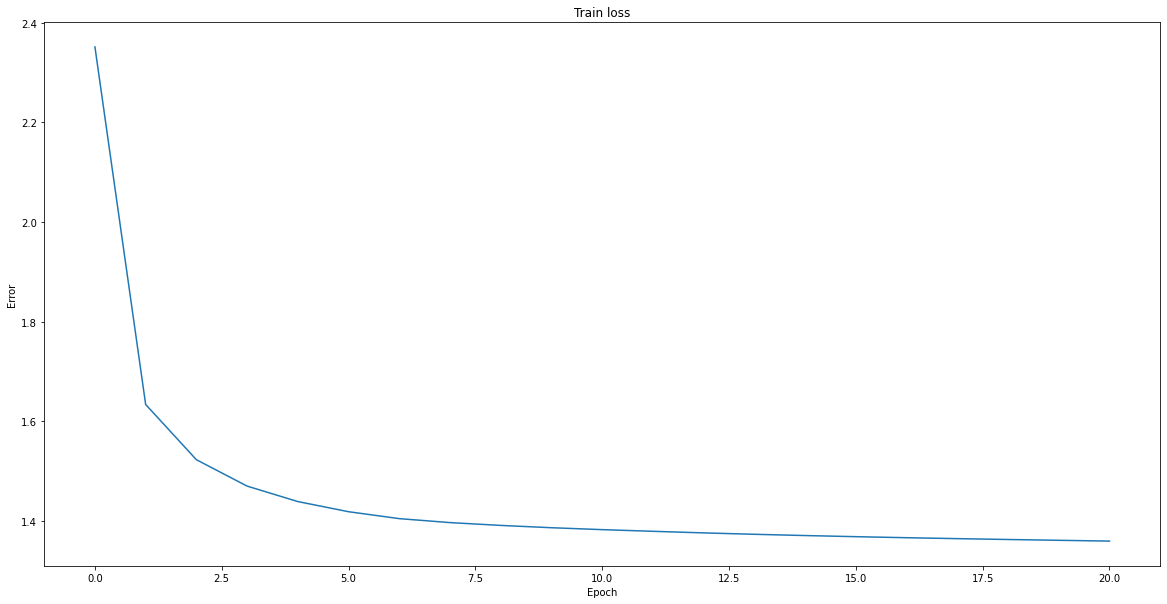

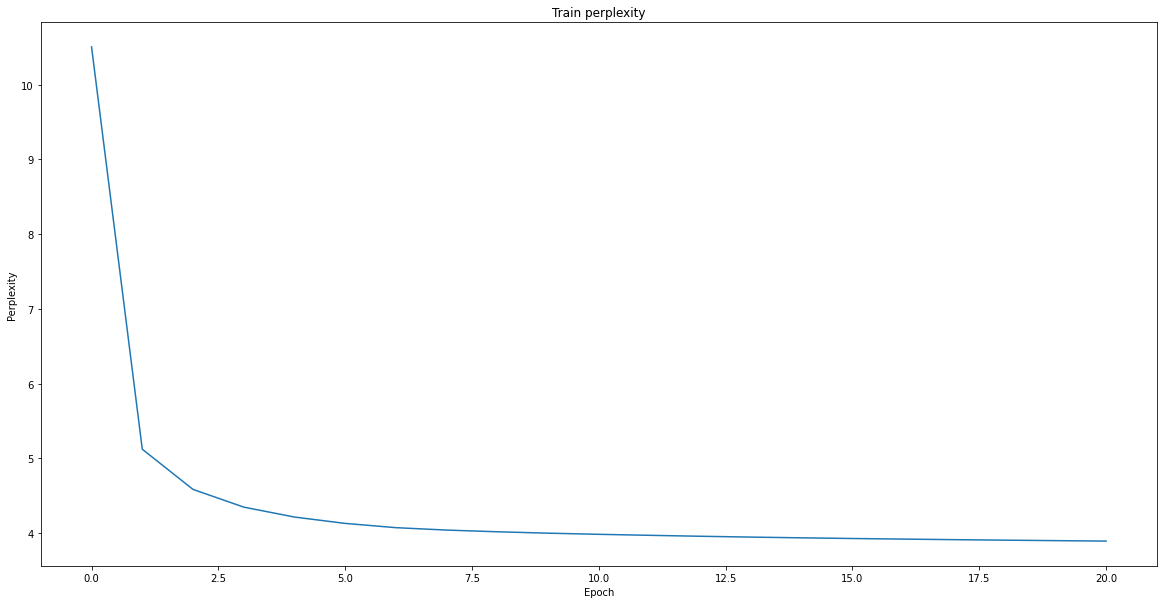

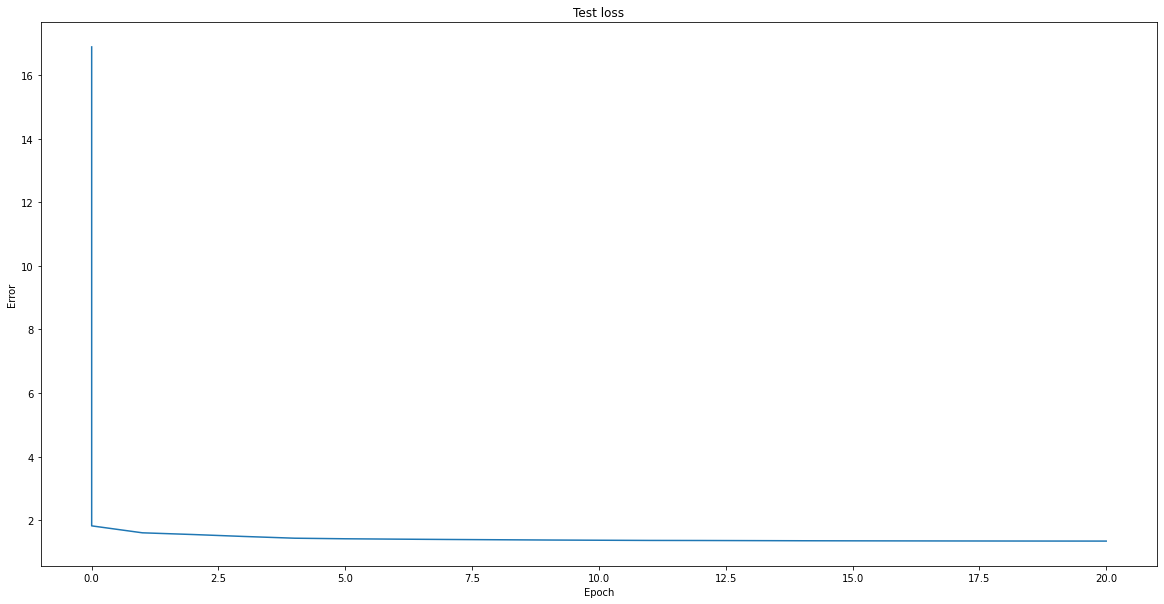

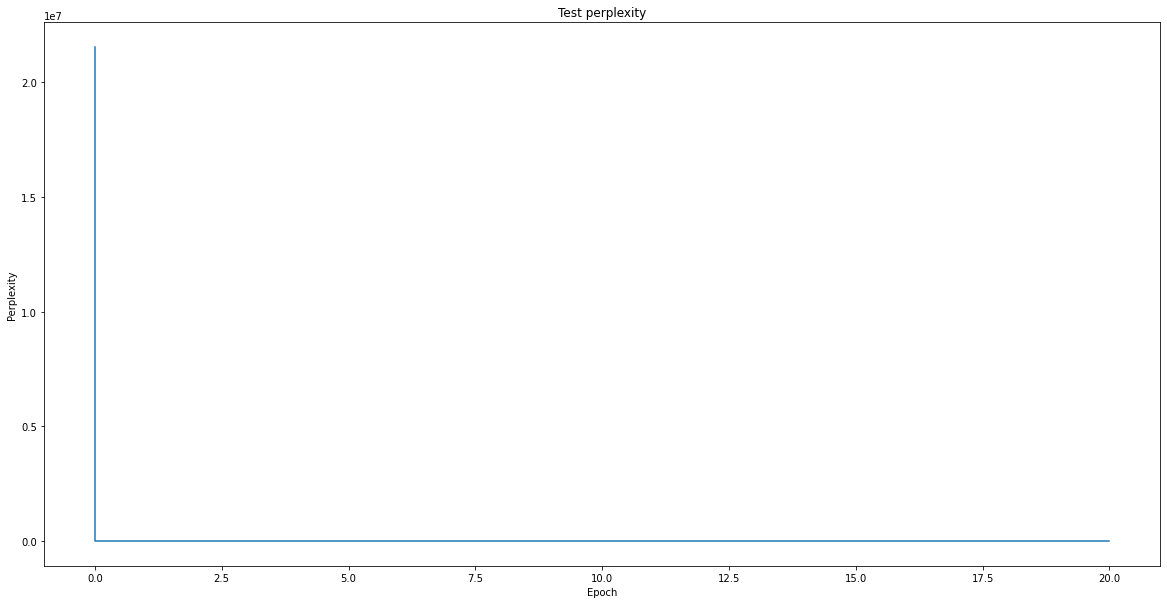

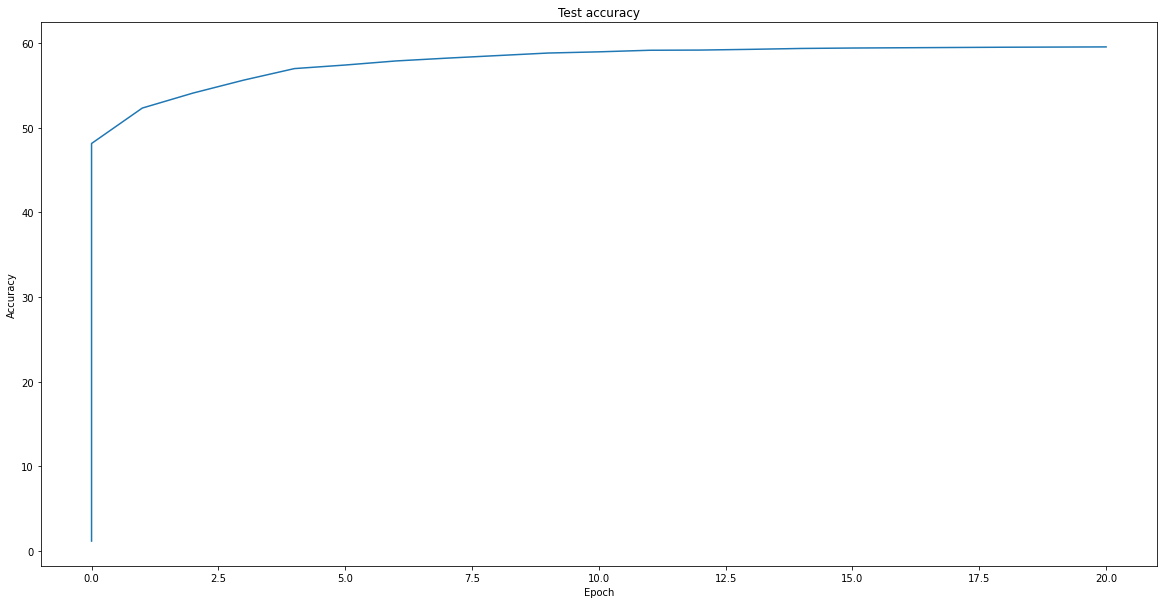

In [10]:
def main():
    SEQUENCE_LENGTH = 50
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log_gru_hp.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints_gru_hp')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints_gru_hp/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)    
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints_gru_hp/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        pt_util.plot(ep, np.exp(val), 'Train perplexity', 'Epoch', 'Perplexity')

        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        pt_util.plot(ep, np.exp(val), 'Test perplexity', 'Epoch', 'Perplexity')  

        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Accuracy')
        return model, vocab, device

final_model, vocab, device = main()

#Part 7: Experiments

In [11]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 100

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and the stone stone stone stone of the castle and said to his feet. "What do you think you to the one of th
generated with sample	 Harry Potter and the owlbrewing Haw had Deer Rourstakene house should knows by Ginny on to," "You ang Permione's hoo, in
generated with sample	 Harry Potter and then . . . Tell, Tom cale long. Harry once of hor down to the word into a long only blocked as the pied
generated with sample	 Harry Potter and the forehort, nothing on him. "He're held sorry!" said Rgrive...' Harry told her Rudge." "Bang most wit
generated with sample	 Harry Potter and the tiny, glitting seech on yhun, Harry and Harry sniggereful. "Snaje hind he'd set it. Do that even vo
generated with sample	 Harry Potter and the snaker toward him at someone impossiby. But the Poster! Dumbledore, the same two of them, the long 
generated with sample	 Harry Potter and the Sly'room to exer can his mother. He lovered him from gritwing, his him. "The first - " she said

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



## 8.1 Different Text Corpus

In [12]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    data = data.replace('\t', ' ')
    data = data.replace('\n', ' ')
    data = re.sub('\\s+', ' ', data)

    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    int_rep = 0
    for char in data:
        if char not in voc2ind.keys():
            voc2ind[char] = int_rep
            int_rep = int_rep + 1

    ind2voc = {val: key for key, val in voc2ind.items()}

    # Iterate through data to get numpy array
    numpy_data = []
    for char in data:
        numpy_data.append(voc2ind[char])

    eighty_percent = int(len(numpy_data) * 0.8)
    train_text, test_text = numpy_data[:eighty_percent], numpy_data[eighty_percent:]

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'sherlock_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'sherlock_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'sherlock.txt')

Using device cuda
num workers: 2
Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	_G3vy_M"jQ Dr. ry p"o" TQy__TTy_y[WQT_Qy_M"v+I _GT


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	rWfyfWWTTdTy._%Q_(KA$ypQ^Q _MrYyx_GTTy Q " " _M" v


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	QQ_$XTQQQ""$^HXXXXyW_TTQ DQ__p"  *DyWW_y_9YyY_y y^


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	ppp0YQjXMprrrA$y_M"TvrYY"QHX$=0GO[dd.rrrfQ  pp^ yy


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	XXprfpyIO00yB))8DDX-1QQQ5X_MrYJJ rT---- rryy$000O[


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	0p$XTq

  0%|          | 1/394 [00:00<01:04,  6.12it/s]

Train Epoch: 0 [0/100864 (0%)]	Loss: 15.881997


  3%|▎         | 13/394 [00:01<00:32, 11.57it/s]

Train Epoch: 0 [2560/100864 (3%)]	Loss: 14.008969


  6%|▌         | 23/394 [00:02<00:32, 11.50it/s]

Train Epoch: 0 [5120/100864 (5%)]	Loss: 6.351328


  8%|▊         | 33/394 [00:02<00:31, 11.62it/s]

Train Epoch: 0 [7680/100864 (8%)]	Loss: 4.217628


 11%|█         | 43/394 [00:03<00:30, 11.49it/s]

Train Epoch: 0 [10240/100864 (10%)]	Loss: 3.090299


 13%|█▎        | 53/394 [00:04<00:29, 11.61it/s]

Train Epoch: 0 [12800/100864 (13%)]	Loss: 2.952264


 16%|█▌        | 63/394 [00:05<00:28, 11.57it/s]

Train Epoch: 0 [15360/100864 (15%)]	Loss: 2.829561


 19%|█▊        | 73/394 [00:06<00:27, 11.53it/s]

Train Epoch: 0 [17920/100864 (18%)]	Loss: 2.763011


 21%|██        | 83/394 [00:07<00:26, 11.61it/s]

Train Epoch: 0 [20480/100864 (20%)]	Loss: 2.732882


 24%|██▎       | 93/394 [00:08<00:25, 11.66it/s]

Train Epoch: 0 [23040/100864 (23%)]	Loss: 2.311438


 26%|██▌       | 103/394 [00:08<00:25, 11.40it/s]

Train Epoch: 0 [25600/100864 (25%)]	Loss: 2.201762


 29%|██▊       | 113/394 [00:09<00:24, 11.52it/s]

Train Epoch: 0 [28160/100864 (28%)]	Loss: 2.365154


 31%|███       | 123/394 [00:10<00:23, 11.50it/s]

Train Epoch: 0 [30720/100864 (30%)]	Loss: 3.722312


 34%|███▍      | 133/394 [00:11<00:23, 11.35it/s]

Train Epoch: 0 [33280/100864 (33%)]	Loss: 2.912725


 36%|███▋      | 143/394 [00:12<00:21, 11.49it/s]

Train Epoch: 0 [35840/100864 (36%)]	Loss: 2.343504


 39%|███▉      | 153/394 [00:13<00:20, 11.56it/s]

Train Epoch: 0 [38400/100864 (38%)]	Loss: 2.192785


 41%|████▏     | 163/394 [00:14<00:20, 11.33it/s]

Train Epoch: 0 [40960/100864 (41%)]	Loss: 2.067816


 44%|████▍     | 173/394 [00:15<00:19, 11.46it/s]

Train Epoch: 0 [43520/100864 (43%)]	Loss: 2.046129


 46%|████▋     | 183/394 [00:15<00:18, 11.54it/s]

Train Epoch: 0 [46080/100864 (46%)]	Loss: 2.157973


 49%|████▉     | 193/394 [00:16<00:17, 11.41it/s]

Train Epoch: 0 [48640/100864 (48%)]	Loss: 2.127981


 52%|█████▏    | 203/394 [00:17<00:16, 11.49it/s]

Train Epoch: 0 [51200/100864 (51%)]	Loss: 2.122783


 54%|█████▍    | 213/394 [00:18<00:15, 11.48it/s]

Train Epoch: 0 [53760/100864 (53%)]	Loss: 1.991656


 57%|█████▋    | 223/394 [00:19<00:14, 11.49it/s]

Train Epoch: 0 [56320/100864 (56%)]	Loss: 1.922012


 59%|█████▉    | 233/394 [00:20<00:14, 11.37it/s]

Train Epoch: 0 [58880/100864 (58%)]	Loss: 1.996003


 62%|██████▏   | 243/394 [00:21<00:13, 11.61it/s]

Train Epoch: 0 [61440/100864 (61%)]	Loss: 2.070497


 64%|██████▍   | 253/394 [00:22<00:12, 11.31it/s]

Train Epoch: 0 [64000/100864 (63%)]	Loss: 2.066680


 67%|██████▋   | 263/394 [00:22<00:11, 11.43it/s]

Train Epoch: 0 [66560/100864 (66%)]	Loss: 1.940682


 69%|██████▉   | 273/394 [00:23<00:10, 11.38it/s]

Train Epoch: 0 [69120/100864 (69%)]	Loss: 1.958087


 72%|███████▏  | 283/394 [00:24<00:09, 11.49it/s]

Train Epoch: 0 [71680/100864 (71%)]	Loss: 1.948128


 74%|███████▍  | 293/394 [00:25<00:08, 11.46it/s]

Train Epoch: 0 [74240/100864 (74%)]	Loss: 1.914323


 77%|███████▋  | 303/394 [00:26<00:07, 11.43it/s]

Train Epoch: 0 [76800/100864 (76%)]	Loss: 1.896130


 79%|███████▉  | 313/394 [00:27<00:07, 11.31it/s]

Train Epoch: 0 [79360/100864 (79%)]	Loss: 1.863221


 82%|████████▏ | 323/394 [00:28<00:06, 11.43it/s]

Train Epoch: 0 [81920/100864 (81%)]	Loss: 1.880080


 85%|████████▍ | 333/394 [00:29<00:05, 11.40it/s]

Train Epoch: 0 [84480/100864 (84%)]	Loss: 1.865383


 87%|████████▋ | 343/394 [00:29<00:04, 11.49it/s]

Train Epoch: 0 [87040/100864 (86%)]	Loss: 1.905935


 90%|████████▉ | 353/394 [00:30<00:03, 11.46it/s]

Train Epoch: 0 [89600/100864 (89%)]	Loss: 1.802909


 92%|█████████▏| 363/394 [00:31<00:02, 11.36it/s]

Train Epoch: 0 [92160/100864 (91%)]	Loss: 1.889064


 95%|█████████▍| 373/394 [00:32<00:01, 11.41it/s]

Train Epoch: 0 [94720/100864 (94%)]	Loss: 1.907732


 97%|█████████▋| 383/394 [00:33<00:00, 11.53it/s]

Train Epoch: 0 [97280/100864 (96%)]	Loss: 1.916951


100%|█████████▉| 393/394 [00:34<00:00, 11.48it/s]

Train Epoch: 0 [99840/100864 (99%)]	Loss: 1.880921


100%|██████████| 394/394 [00:34<00:00, 11.46it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	unhtthe e oas nssotntdof th nonttfe of the e aonnd


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tnow wf thle  ing txetdthet tauld horldedohe fe


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	dt  aolllng   wf cnowned e tta dos not tha ah tost


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter aaar ng ahe feneer  autuzov ahale d ais fok


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	saad  "aAPTER OIIIwTell, ahet s wnl   said hutuzov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	n, yhot tssa us ,"hhet  oou  ahell irre

  0%|          | 1/394 [00:00<01:15,  5.23it/s]

Train Epoch: 1 [0/100864 (0%)]	Loss: 1.896725


  3%|▎         | 12/394 [00:01<00:34, 11.10it/s]

Train Epoch: 1 [2560/100864 (3%)]	Loss: 1.813552


  6%|▌         | 22/394 [00:02<00:32, 11.38it/s]

Train Epoch: 1 [5120/100864 (5%)]	Loss: 1.807855


  8%|▊         | 32/394 [00:02<00:31, 11.44it/s]

Train Epoch: 1 [7680/100864 (8%)]	Loss: 1.799949


 11%|█         | 42/394 [00:03<00:31, 11.29it/s]

Train Epoch: 1 [10240/100864 (10%)]	Loss: 1.812575


 13%|█▎        | 52/394 [00:04<00:29, 11.43it/s]

Train Epoch: 1 [12800/100864 (13%)]	Loss: 1.823541


 16%|█▌        | 62/394 [00:05<00:29, 11.39it/s]

Train Epoch: 1 [15360/100864 (15%)]	Loss: 1.787014


 18%|█▊        | 72/394 [00:06<00:28, 11.29it/s]

Train Epoch: 1 [17920/100864 (18%)]	Loss: 1.771873


 21%|██        | 82/394 [00:07<00:27, 11.28it/s]

Train Epoch: 1 [20480/100864 (20%)]	Loss: 1.792342


 23%|██▎       | 92/394 [00:08<00:26, 11.45it/s]

Train Epoch: 1 [23040/100864 (23%)]	Loss: 1.772979


 26%|██▌       | 102/394 [00:09<00:25, 11.48it/s]

Train Epoch: 1 [25600/100864 (25%)]	Loss: 1.752206


 28%|██▊       | 112/394 [00:09<00:24, 11.44it/s]

Train Epoch: 1 [28160/100864 (28%)]	Loss: 1.761976


 31%|███       | 122/394 [00:10<00:23, 11.41it/s]

Train Epoch: 1 [30720/100864 (30%)]	Loss: 1.727866


 34%|███▎      | 132/394 [00:11<00:23, 11.34it/s]

Train Epoch: 1 [33280/100864 (33%)]	Loss: 1.749399


 36%|███▌      | 142/394 [00:12<00:21, 11.46it/s]

Train Epoch: 1 [35840/100864 (36%)]	Loss: 1.713390


 39%|███▊      | 152/394 [00:13<00:20, 11.59it/s]

Train Epoch: 1 [38400/100864 (38%)]	Loss: 1.733145


 41%|████      | 162/394 [00:14<00:20, 11.40it/s]

Train Epoch: 1 [40960/100864 (41%)]	Loss: 1.727981


 44%|████▎     | 172/394 [00:15<00:19, 11.52it/s]

Train Epoch: 1 [43520/100864 (43%)]	Loss: 1.728083


 46%|████▌     | 182/394 [00:16<00:18, 11.46it/s]

Train Epoch: 1 [46080/100864 (46%)]	Loss: 1.717985


 49%|████▊     | 192/394 [00:16<00:17, 11.53it/s]

Train Epoch: 1 [48640/100864 (48%)]	Loss: 1.702720


 51%|█████▏    | 202/394 [00:17<00:16, 11.55it/s]

Train Epoch: 1 [51200/100864 (51%)]	Loss: 1.729764


 54%|█████▍    | 212/394 [00:18<00:15, 11.51it/s]

Train Epoch: 1 [53760/100864 (53%)]	Loss: 1.726617


 56%|█████▋    | 222/394 [00:19<00:14, 11.50it/s]

Train Epoch: 1 [56320/100864 (56%)]	Loss: 1.658517


 59%|█████▉    | 232/394 [00:20<00:14, 11.46it/s]

Train Epoch: 1 [58880/100864 (58%)]	Loss: 1.819789


 61%|██████▏   | 242/394 [00:21<00:13, 11.27it/s]

Train Epoch: 1 [61440/100864 (61%)]	Loss: 1.781820


 64%|██████▍   | 252/394 [00:22<00:12, 11.24it/s]

Train Epoch: 1 [64000/100864 (63%)]	Loss: 1.754745


 66%|██████▋   | 262/394 [00:23<00:11, 11.26it/s]

Train Epoch: 1 [66560/100864 (66%)]	Loss: 1.716512


 69%|██████▉   | 272/394 [00:23<00:10, 11.45it/s]

Train Epoch: 1 [69120/100864 (69%)]	Loss: 1.700185


 72%|███████▏  | 282/394 [00:24<00:09, 11.53it/s]

Train Epoch: 1 [71680/100864 (71%)]	Loss: 1.663131


 74%|███████▍  | 292/394 [00:25<00:08, 11.52it/s]

Train Epoch: 1 [74240/100864 (74%)]	Loss: 1.690836


 77%|███████▋  | 302/394 [00:26<00:08, 11.33it/s]

Train Epoch: 1 [76800/100864 (76%)]	Loss: 1.670496


 79%|███████▉  | 312/394 [00:27<00:07, 11.37it/s]

Train Epoch: 1 [79360/100864 (79%)]	Loss: 1.656486


 82%|████████▏ | 322/394 [00:28<00:06, 11.48it/s]

Train Epoch: 1 [81920/100864 (81%)]	Loss: 1.686135


 84%|████████▍ | 332/394 [00:29<00:05, 11.48it/s]

Train Epoch: 1 [84480/100864 (84%)]	Loss: 1.670286


 87%|████████▋ | 342/394 [00:30<00:04, 11.45it/s]

Train Epoch: 1 [87040/100864 (86%)]	Loss: 1.727965


 89%|████████▉ | 352/394 [00:30<00:03, 11.45it/s]

Train Epoch: 1 [89600/100864 (89%)]	Loss: 1.637617


 92%|█████████▏| 362/394 [00:31<00:02, 11.45it/s]

Train Epoch: 1 [92160/100864 (91%)]	Loss: 1.672509


 94%|█████████▍| 372/394 [00:32<00:01, 11.58it/s]

Train Epoch: 1 [94720/100864 (94%)]	Loss: 1.664993


 97%|█████████▋| 382/394 [00:33<00:01, 11.45it/s]

Train Epoch: 1 [97280/100864 (96%)]	Loss: 1.700352


 99%|█████████▉| 392/394 [00:34<00:00, 11.55it/s]

Train Epoch: 1 [99840/100864 (99%)]	Loss: 1.667535


100%|██████████| 394/394 [00:34<00:00, 11.42it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	urhtthe e oes n sotnt of th aon tue of the   wound


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd teow wf ttme hing txetntoet tauld hilldedthe oo


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	dt  wolling   wr enowned e tte wis not too oo tist


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter ta ddng the ootter  wut zou woalh d aim fog


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	caad  "oAPTER IIIITIell, whet s w l   said tutuzou


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	n, yhot tssa ut   hhet  oou  aoell ortd

  0%|          | 1/394 [00:00<01:13,  5.32it/s]

Train Epoch: 2 [0/100864 (0%)]	Loss: 1.708530


  3%|▎         | 13/394 [00:01<00:33, 11.30it/s]

Train Epoch: 2 [2560/100864 (3%)]	Loss: 1.640544


  6%|▌         | 23/394 [00:02<00:32, 11.39it/s]

Train Epoch: 2 [5120/100864 (5%)]	Loss: 1.658835


  8%|▊         | 33/394 [00:03<00:31, 11.43it/s]

Train Epoch: 2 [7680/100864 (8%)]	Loss: 1.649760


 11%|█         | 43/394 [00:03<00:30, 11.46it/s]

Train Epoch: 2 [10240/100864 (10%)]	Loss: 1.641721


 13%|█▎        | 53/394 [00:04<00:29, 11.48it/s]

Train Epoch: 2 [12800/100864 (13%)]	Loss: 1.656803


 16%|█▌        | 63/394 [00:05<00:29, 11.35it/s]

Train Epoch: 2 [15360/100864 (15%)]	Loss: 1.631294


 19%|█▊        | 73/394 [00:06<00:27, 11.47it/s]

Train Epoch: 2 [17920/100864 (18%)]	Loss: 1.623435


 21%|██        | 83/394 [00:07<00:26, 11.54it/s]

Train Epoch: 2 [20480/100864 (20%)]	Loss: 1.661956


 24%|██▎       | 93/394 [00:08<00:26, 11.40it/s]

Train Epoch: 2 [23040/100864 (23%)]	Loss: 1.650000


 26%|██▌       | 103/394 [00:09<00:25, 11.49it/s]

Train Epoch: 2 [25600/100864 (25%)]	Loss: 1.629698


 29%|██▊       | 113/394 [00:10<00:24, 11.47it/s]

Train Epoch: 2 [28160/100864 (28%)]	Loss: 1.636680


 31%|███       | 123/394 [00:10<00:23, 11.48it/s]

Train Epoch: 2 [30720/100864 (30%)]	Loss: 1.601469


 34%|███▍      | 133/394 [00:11<00:22, 11.51it/s]

Train Epoch: 2 [33280/100864 (33%)]	Loss: 1.619537


 36%|███▋      | 143/394 [00:12<00:21, 11.52it/s]

Train Epoch: 2 [35840/100864 (36%)]	Loss: 1.595299


 39%|███▉      | 153/394 [00:13<00:21, 11.29it/s]

Train Epoch: 2 [38400/100864 (38%)]	Loss: 1.635340


 41%|████▏     | 163/394 [00:14<00:19, 11.56it/s]

Train Epoch: 2 [40960/100864 (41%)]	Loss: 1.599673


 44%|████▍     | 173/394 [00:15<00:19, 11.43it/s]

Train Epoch: 2 [43520/100864 (43%)]	Loss: 1.614081


 46%|████▋     | 183/394 [00:16<00:18, 11.43it/s]

Train Epoch: 2 [46080/100864 (46%)]	Loss: 1.598137


 49%|████▉     | 193/394 [00:16<00:17, 11.35it/s]

Train Epoch: 2 [48640/100864 (48%)]	Loss: 1.604173


 52%|█████▏    | 203/394 [00:17<00:16, 11.38it/s]

Train Epoch: 2 [51200/100864 (51%)]	Loss: 1.623681


 54%|█████▍    | 213/394 [00:18<00:15, 11.46it/s]

Train Epoch: 2 [53760/100864 (53%)]	Loss: 1.624185


 57%|█████▋    | 223/394 [00:19<00:15, 11.34it/s]

Train Epoch: 2 [56320/100864 (56%)]	Loss: 1.572582


 59%|█████▉    | 233/394 [00:20<00:13, 11.61it/s]

Train Epoch: 2 [58880/100864 (58%)]	Loss: 1.674073


 62%|██████▏   | 243/394 [00:21<00:13, 11.37it/s]

Train Epoch: 2 [61440/100864 (61%)]	Loss: 1.648443


 64%|██████▍   | 253/394 [00:22<00:12, 11.47it/s]

Train Epoch: 2 [64000/100864 (63%)]	Loss: 1.656984


 67%|██████▋   | 263/394 [00:23<00:11, 11.41it/s]

Train Epoch: 2 [66560/100864 (66%)]	Loss: 1.628737


 69%|██████▉   | 273/394 [00:23<00:10, 11.33it/s]

Train Epoch: 2 [69120/100864 (69%)]	Loss: 1.618627


 72%|███████▏  | 283/394 [00:24<00:09, 11.50it/s]

Train Epoch: 2 [71680/100864 (71%)]	Loss: 1.569787


 74%|███████▍  | 293/394 [00:25<00:08, 11.48it/s]

Train Epoch: 2 [74240/100864 (74%)]	Loss: 1.604941


 77%|███████▋  | 303/394 [00:26<00:08, 11.33it/s]

Train Epoch: 2 [76800/100864 (76%)]	Loss: 1.593226


 79%|███████▉  | 313/394 [00:27<00:07, 11.41it/s]

Train Epoch: 2 [79360/100864 (79%)]	Loss: 1.590965


 82%|████████▏ | 323/394 [00:28<00:06, 11.50it/s]

Train Epoch: 2 [81920/100864 (81%)]	Loss: 1.592803


 85%|████████▍ | 333/394 [00:29<00:05, 11.53it/s]

Train Epoch: 2 [84480/100864 (84%)]	Loss: 1.601522


 87%|████████▋ | 343/394 [00:30<00:04, 11.54it/s]

Train Epoch: 2 [87040/100864 (86%)]	Loss: 1.636027


 90%|████████▉ | 353/394 [00:30<00:03, 11.58it/s]

Train Epoch: 2 [89600/100864 (89%)]	Loss: 1.568399


 92%|█████████▏| 363/394 [00:31<00:02, 11.65it/s]

Train Epoch: 2 [92160/100864 (91%)]	Loss: 1.615797


 95%|█████████▍| 373/394 [00:32<00:01, 11.29it/s]

Train Epoch: 2 [94720/100864 (94%)]	Loss: 1.597899


 97%|█████████▋| 383/394 [00:33<00:00, 11.43it/s]

Train Epoch: 2 [97280/100864 (96%)]	Loss: 1.612469


100%|█████████▉| 393/394 [00:34<00:00, 11.40it/s]

Train Epoch: 2 [99840/100864 (99%)]	Loss: 1.592720


100%|██████████| 394/394 [00:34<00:00, 11.41it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	urhtthe e ies nnsenct of thoatn tne tf the . would


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd teow tf ttme hing txeenthet thuld bolldedthe oo


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	dte aolling   ar inowned e tte wes not tho to tesc


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter taaddng the oonter  aut rov woilk d tim wok


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	maad  "oAnTE  III TIe l, yhet s nnl   "aid tut rov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	n, yhot tssa nt   "het  tou  boeep ortd

  1%|          | 2/394 [00:00<00:57,  6.86it/s]

Train Epoch: 3 [0/100864 (0%)]	Loss: 1.635594


  3%|▎         | 12/394 [00:01<00:34, 11.16it/s]

Train Epoch: 3 [2560/100864 (3%)]	Loss: 1.570065


  6%|▌         | 22/394 [00:02<00:32, 11.27it/s]

Train Epoch: 3 [5120/100864 (5%)]	Loss: 1.589397


  8%|▊         | 32/394 [00:02<00:31, 11.41it/s]

Train Epoch: 3 [7680/100864 (8%)]	Loss: 1.580826


 11%|█         | 42/394 [00:03<00:30, 11.43it/s]

Train Epoch: 3 [10240/100864 (10%)]	Loss: 1.567201


 13%|█▎        | 52/394 [00:04<00:29, 11.50it/s]

Train Epoch: 3 [12800/100864 (13%)]	Loss: 1.567075


 16%|█▌        | 62/394 [00:05<00:28, 11.46it/s]

Train Epoch: 3 [15360/100864 (15%)]	Loss: 1.570415


 18%|█▊        | 72/394 [00:06<00:27, 11.54it/s]

Train Epoch: 3 [17920/100864 (18%)]	Loss: 1.567200


 21%|██        | 82/394 [00:07<00:26, 11.61it/s]

Train Epoch: 3 [20480/100864 (20%)]	Loss: 1.595905


 23%|██▎       | 92/394 [00:08<00:26, 11.55it/s]

Train Epoch: 3 [23040/100864 (23%)]	Loss: 1.588642


 26%|██▌       | 102/394 [00:09<00:25, 11.52it/s]

Train Epoch: 3 [25600/100864 (25%)]	Loss: 1.572894


 28%|██▊       | 112/394 [00:09<00:24, 11.28it/s]

Train Epoch: 3 [28160/100864 (28%)]	Loss: 1.569686


 31%|███       | 122/394 [00:10<00:23, 11.50it/s]

Train Epoch: 3 [30720/100864 (30%)]	Loss: 1.556206


 34%|███▎      | 132/394 [00:11<00:22, 11.53it/s]

Train Epoch: 3 [33280/100864 (33%)]	Loss: 1.566031


 36%|███▌      | 142/394 [00:12<00:22, 11.45it/s]

Train Epoch: 3 [35840/100864 (36%)]	Loss: 1.543293


 39%|███▊      | 152/394 [00:13<00:21, 11.34it/s]

Train Epoch: 3 [38400/100864 (38%)]	Loss: 1.570194


 41%|████      | 162/394 [00:14<00:20, 11.51it/s]

Train Epoch: 3 [40960/100864 (41%)]	Loss: 1.544742


 44%|████▎     | 172/394 [00:15<00:19, 11.50it/s]

Train Epoch: 3 [43520/100864 (43%)]	Loss: 1.559999


 46%|████▌     | 182/394 [00:16<00:18, 11.26it/s]

Train Epoch: 3 [46080/100864 (46%)]	Loss: 1.564641


 49%|████▊     | 192/394 [00:16<00:17, 11.50it/s]

Train Epoch: 3 [48640/100864 (48%)]	Loss: 1.559169


 51%|█████▏    | 202/394 [00:17<00:16, 11.57it/s]

Train Epoch: 3 [51200/100864 (51%)]	Loss: 1.574737


 54%|█████▍    | 212/394 [00:18<00:16, 11.25it/s]

Train Epoch: 3 [53760/100864 (53%)]	Loss: 1.586265


 56%|█████▋    | 222/394 [00:19<00:15, 11.42it/s]

Train Epoch: 3 [56320/100864 (56%)]	Loss: 1.534758


 59%|█████▉    | 232/394 [00:20<00:14, 11.38it/s]

Train Epoch: 3 [58880/100864 (58%)]	Loss: 1.608466


 61%|██████▏   | 242/394 [00:21<00:13, 11.48it/s]

Train Epoch: 3 [61440/100864 (61%)]	Loss: 1.574472


 64%|██████▍   | 252/394 [00:22<00:12, 11.57it/s]

Train Epoch: 3 [64000/100864 (63%)]	Loss: 1.605474


 66%|██████▋   | 262/394 [00:23<00:11, 11.42it/s]

Train Epoch: 3 [66560/100864 (66%)]	Loss: 1.573562


 69%|██████▉   | 272/394 [00:23<00:10, 11.38it/s]

Train Epoch: 3 [69120/100864 (69%)]	Loss: 1.569915


 72%|███████▏  | 282/394 [00:24<00:09, 11.40it/s]

Train Epoch: 3 [71680/100864 (71%)]	Loss: 1.512443


 74%|███████▍  | 292/394 [00:25<00:08, 11.43it/s]

Train Epoch: 3 [74240/100864 (74%)]	Loss: 1.559761


 77%|███████▋  | 302/394 [00:26<00:08, 11.46it/s]

Train Epoch: 3 [76800/100864 (76%)]	Loss: 1.543134


 79%|███████▉  | 312/394 [00:27<00:07, 11.55it/s]

Train Epoch: 3 [79360/100864 (79%)]	Loss: 1.557193


 82%|████████▏ | 322/394 [00:28<00:06, 11.46it/s]

Train Epoch: 3 [81920/100864 (81%)]	Loss: 1.562100


 84%|████████▍ | 332/394 [00:29<00:05, 11.34it/s]

Train Epoch: 3 [84480/100864 (84%)]	Loss: 1.564069


 87%|████████▋ | 342/394 [00:29<00:04, 11.43it/s]

Train Epoch: 3 [87040/100864 (86%)]	Loss: 1.598188


 89%|████████▉ | 352/394 [00:30<00:03, 11.42it/s]

Train Epoch: 3 [89600/100864 (89%)]	Loss: 1.526260


 92%|█████████▏| 362/394 [00:31<00:02, 11.47it/s]

Train Epoch: 3 [92160/100864 (91%)]	Loss: 1.577056


 94%|█████████▍| 372/394 [00:32<00:01, 11.54it/s]

Train Epoch: 3 [94720/100864 (94%)]	Loss: 1.566432


 97%|█████████▋| 382/394 [00:33<00:01, 11.55it/s]

Train Epoch: 3 [97280/100864 (96%)]	Loss: 1.577158


 99%|█████████▉| 392/394 [00:34<00:00, 11.47it/s]

Train Epoch: 3 [99840/100864 (99%)]	Loss: 1.560288


100%|██████████| 394/394 [00:34<00:00, 11.42it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nrhtthe e ias n satct of th non tne tf the . aanld


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd teow tf ttme hing txeenwhet tauld bo ldedthe pa


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	ste aolling   ar inowned e --a wis not tha to tosc


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter taadtng the satter  aut rov waile d iim fak


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	faad  "oalrE  III IIe l, yhet s nnl   "aid tut rov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	ne yhet sssa rt  ""het  tou  waeep ,rtd

  0%|          | 1/394 [00:00<01:15,  5.20it/s]

Train Epoch: 4 [0/100864 (0%)]	Loss: 1.590730


  3%|▎         | 13/394 [00:01<00:33, 11.25it/s]

Train Epoch: 4 [2560/100864 (3%)]	Loss: 1.529705


  6%|▌         | 23/394 [00:02<00:32, 11.37it/s]

Train Epoch: 4 [5120/100864 (5%)]	Loss: 1.553012


  8%|▊         | 33/394 [00:03<00:31, 11.38it/s]

Train Epoch: 4 [7680/100864 (8%)]	Loss: 1.541734


 11%|█         | 43/394 [00:03<00:30, 11.53it/s]

Train Epoch: 4 [10240/100864 (10%)]	Loss: 1.544906


 13%|█▎        | 53/394 [00:04<00:29, 11.44it/s]

Train Epoch: 4 [12800/100864 (13%)]	Loss: 1.541141


 16%|█▌        | 63/394 [00:05<00:28, 11.42it/s]

Train Epoch: 4 [15360/100864 (15%)]	Loss: 1.545224


 19%|█▊        | 73/394 [00:06<00:27, 11.57it/s]

Train Epoch: 4 [17920/100864 (18%)]	Loss: 1.548252


 21%|██        | 83/394 [00:07<00:26, 11.54it/s]

Train Epoch: 4 [20480/100864 (20%)]	Loss: 1.561764


 24%|██▎       | 93/394 [00:08<00:26, 11.49it/s]

Train Epoch: 4 [23040/100864 (23%)]	Loss: 1.549838


 26%|██▌       | 103/394 [00:09<00:25, 11.57it/s]

Train Epoch: 4 [25600/100864 (25%)]	Loss: 1.541284


 29%|██▊       | 113/394 [00:09<00:24, 11.51it/s]

Train Epoch: 4 [28160/100864 (28%)]	Loss: 1.544205


 31%|███       | 123/394 [00:10<00:23, 11.41it/s]

Train Epoch: 4 [30720/100864 (30%)]	Loss: 1.529587


 34%|███▍      | 133/394 [00:11<00:23, 11.30it/s]

Train Epoch: 4 [33280/100864 (33%)]	Loss: 1.540406


 36%|███▋      | 143/394 [00:12<00:22, 11.28it/s]

Train Epoch: 4 [35840/100864 (36%)]	Loss: 1.506264


 39%|███▉      | 153/394 [00:13<00:21, 11.42it/s]

Train Epoch: 4 [38400/100864 (38%)]	Loss: 1.544306


 41%|████▏     | 163/394 [00:14<00:20, 11.44it/s]

Train Epoch: 4 [40960/100864 (41%)]	Loss: 1.526809


 44%|████▍     | 173/394 [00:15<00:19, 11.46it/s]

Train Epoch: 4 [43520/100864 (43%)]	Loss: 1.540047


 46%|████▋     | 183/394 [00:16<00:18, 11.42it/s]

Train Epoch: 4 [46080/100864 (46%)]	Loss: 1.544218


 49%|████▉     | 193/394 [00:17<00:17, 11.21it/s]

Train Epoch: 4 [48640/100864 (48%)]	Loss: 1.519411


 52%|█████▏    | 203/394 [00:17<00:16, 11.56it/s]

Train Epoch: 4 [51200/100864 (51%)]	Loss: 1.553765


 54%|█████▍    | 213/394 [00:18<00:15, 11.43it/s]

Train Epoch: 4 [53760/100864 (53%)]	Loss: 1.558073


 57%|█████▋    | 223/394 [00:19<00:14, 11.51it/s]

Train Epoch: 4 [56320/100864 (56%)]	Loss: 1.505623


 59%|█████▉    | 233/394 [00:20<00:14, 11.45it/s]

Train Epoch: 4 [58880/100864 (58%)]	Loss: 1.573243


 62%|██████▏   | 243/394 [00:21<00:13, 11.43it/s]

Train Epoch: 4 [61440/100864 (61%)]	Loss: 1.545131


 64%|██████▍   | 253/394 [00:22<00:12, 11.43it/s]

Train Epoch: 4 [64000/100864 (63%)]	Loss: 1.569681


 67%|██████▋   | 263/394 [00:23<00:11, 11.20it/s]

Train Epoch: 4 [66560/100864 (66%)]	Loss: 1.553361


 69%|██████▉   | 273/394 [00:24<00:10, 11.42it/s]

Train Epoch: 4 [69120/100864 (69%)]	Loss: 1.542710


 72%|███████▏  | 283/394 [00:24<00:09, 11.41it/s]

Train Epoch: 4 [71680/100864 (71%)]	Loss: 1.493218


 74%|███████▍  | 293/394 [00:25<00:08, 11.24it/s]

Train Epoch: 4 [74240/100864 (74%)]	Loss: 1.541037


 77%|███████▋  | 303/394 [00:26<00:07, 11.45it/s]

Train Epoch: 4 [76800/100864 (76%)]	Loss: 1.522544


 79%|███████▉  | 313/394 [00:27<00:07, 11.42it/s]

Train Epoch: 4 [79360/100864 (79%)]	Loss: 1.532047


 82%|████████▏ | 323/394 [00:28<00:06, 11.57it/s]

Train Epoch: 4 [81920/100864 (81%)]	Loss: 1.542958


 85%|████████▍ | 333/394 [00:29<00:05, 11.46it/s]

Train Epoch: 4 [84480/100864 (84%)]	Loss: 1.537694


 87%|████████▋ | 343/394 [00:30<00:04, 11.29it/s]

Train Epoch: 4 [87040/100864 (86%)]	Loss: 1.573321


 90%|████████▉ | 353/394 [00:31<00:03, 11.38it/s]

Train Epoch: 4 [89600/100864 (89%)]	Loss: 1.506702


 92%|█████████▏| 363/394 [00:31<00:02, 11.37it/s]

Train Epoch: 4 [92160/100864 (91%)]	Loss: 1.559805


 95%|█████████▍| 373/394 [00:32<00:01, 11.55it/s]

Train Epoch: 4 [94720/100864 (94%)]	Loss: 1.550693


 97%|█████████▋| 383/394 [00:33<00:00, 11.39it/s]

Train Epoch: 4 [97280/100864 (96%)]	Loss: 1.555246


100%|█████████▉| 393/394 [00:34<00:00, 11.61it/s]

Train Epoch: 4 [99840/100864 (99%)]	Loss: 1.540170


100%|██████████| 394/394 [00:34<00:00, 11.39it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nrhtthe e was n satct of th non tne af the . aanld


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd inow tf tome hing txeo woet tauld bo ldedthe ma


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	ste aolling   ar anowned e --a wis not toaiao tosc


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter aaadtng the eatter  aut rov aaale d iim fak


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	faad  "oalrE  III IIell, Ihet s n l   "aid tut rov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	ne yhet y sa rt  ""het etou  "aeep orrd

  1%|          | 2/394 [00:00<00:55,  7.08it/s]

Train Epoch: 5 [0/100864 (0%)]	Loss: 1.570489


  3%|▎         | 12/394 [00:01<00:34, 11.07it/s]

Train Epoch: 5 [2560/100864 (3%)]	Loss: 1.512335


  6%|▌         | 22/394 [00:02<00:32, 11.33it/s]

Train Epoch: 5 [5120/100864 (5%)]	Loss: 1.526061


  8%|▊         | 32/394 [00:02<00:31, 11.53it/s]

Train Epoch: 5 [7680/100864 (8%)]	Loss: 1.525923


 11%|█         | 42/394 [00:03<00:31, 11.15it/s]

Train Epoch: 5 [10240/100864 (10%)]	Loss: 1.521629


 13%|█▎        | 52/394 [00:04<00:29, 11.44it/s]

Train Epoch: 5 [12800/100864 (13%)]	Loss: 1.521795


 16%|█▌        | 62/394 [00:05<00:29, 11.43it/s]

Train Epoch: 5 [15360/100864 (15%)]	Loss: 1.524414


 18%|█▊        | 72/394 [00:06<00:28, 11.45it/s]

Train Epoch: 5 [17920/100864 (18%)]	Loss: 1.528301


 21%|██        | 82/394 [00:07<00:27, 11.40it/s]

Train Epoch: 5 [20480/100864 (20%)]	Loss: 1.552292


 23%|██▎       | 92/394 [00:08<00:26, 11.32it/s]

Train Epoch: 5 [23040/100864 (23%)]	Loss: 1.541139


 26%|██▌       | 102/394 [00:09<00:25, 11.27it/s]

Train Epoch: 5 [25600/100864 (25%)]	Loss: 1.522758


 28%|██▊       | 112/394 [00:09<00:24, 11.49it/s]

Train Epoch: 5 [28160/100864 (28%)]	Loss: 1.525470


 31%|███       | 122/394 [00:10<00:23, 11.36it/s]

Train Epoch: 5 [30720/100864 (30%)]	Loss: 1.503815


 34%|███▎      | 132/394 [00:11<00:22, 11.50it/s]

Train Epoch: 5 [33280/100864 (33%)]	Loss: 1.522157


 36%|███▌      | 142/394 [00:12<00:21, 11.46it/s]

Train Epoch: 5 [35840/100864 (36%)]	Loss: 1.482651


 39%|███▊      | 152/394 [00:13<00:21, 11.28it/s]

Train Epoch: 5 [38400/100864 (38%)]	Loss: 1.524696


 41%|████      | 162/394 [00:14<00:20, 11.40it/s]

Train Epoch: 5 [40960/100864 (41%)]	Loss: 1.507484


 44%|████▎     | 172/394 [00:15<00:19, 11.42it/s]

Train Epoch: 5 [43520/100864 (43%)]	Loss: 1.521393


 46%|████▌     | 182/394 [00:16<00:18, 11.48it/s]

Train Epoch: 5 [46080/100864 (46%)]	Loss: 1.520178


 49%|████▊     | 192/394 [00:16<00:17, 11.40it/s]

Train Epoch: 5 [48640/100864 (48%)]	Loss: 1.505294


 51%|█████▏    | 202/394 [00:17<00:16, 11.51it/s]

Train Epoch: 5 [51200/100864 (51%)]	Loss: 1.536465


 54%|█████▍    | 212/394 [00:18<00:16, 11.33it/s]

Train Epoch: 5 [53760/100864 (53%)]	Loss: 1.539880


 56%|█████▋    | 222/394 [00:19<00:15, 11.40it/s]

Train Epoch: 5 [56320/100864 (56%)]	Loss: 1.492046


 59%|█████▉    | 232/394 [00:20<00:14, 11.30it/s]

Train Epoch: 5 [58880/100864 (58%)]	Loss: 1.561542


 61%|██████▏   | 242/394 [00:21<00:13, 11.37it/s]

Train Epoch: 5 [61440/100864 (61%)]	Loss: 1.528465


 64%|██████▍   | 252/394 [00:22<00:12, 11.47it/s]

Train Epoch: 5 [64000/100864 (63%)]	Loss: 1.549819


 66%|██████▋   | 262/394 [00:23<00:11, 11.49it/s]

Train Epoch: 5 [66560/100864 (66%)]	Loss: 1.540392


 69%|██████▉   | 272/394 [00:23<00:10, 11.35it/s]

Train Epoch: 5 [69120/100864 (69%)]	Loss: 1.531513


 72%|███████▏  | 282/394 [00:24<00:09, 11.50it/s]

Train Epoch: 5 [71680/100864 (71%)]	Loss: 1.481557


 74%|███████▍  | 292/394 [00:25<00:08, 11.44it/s]

Train Epoch: 5 [74240/100864 (74%)]	Loss: 1.527004


 77%|███████▋  | 302/394 [00:26<00:08, 11.49it/s]

Train Epoch: 5 [76800/100864 (76%)]	Loss: 1.504069


 79%|███████▉  | 312/394 [00:27<00:07, 11.15it/s]

Train Epoch: 5 [79360/100864 (79%)]	Loss: 1.514307


 82%|████████▏ | 322/394 [00:28<00:06, 11.21it/s]

Train Epoch: 5 [81920/100864 (81%)]	Loss: 1.521025


 84%|████████▍ | 332/394 [00:29<00:05, 11.50it/s]

Train Epoch: 5 [84480/100864 (84%)]	Loss: 1.522652


 87%|████████▋ | 342/394 [00:30<00:04, 11.49it/s]

Train Epoch: 5 [87040/100864 (86%)]	Loss: 1.555467


 89%|████████▉ | 352/394 [00:30<00:03, 11.46it/s]

Train Epoch: 5 [89600/100864 (89%)]	Loss: 1.496539


 92%|█████████▏| 362/394 [00:31<00:02, 11.41it/s]

Train Epoch: 5 [92160/100864 (91%)]	Loss: 1.548987


 94%|█████████▍| 372/394 [00:32<00:01, 11.47it/s]

Train Epoch: 5 [94720/100864 (94%)]	Loss: 1.537083


 97%|█████████▋| 382/394 [00:33<00:01, 11.46it/s]

Train Epoch: 5 [97280/100864 (96%)]	Loss: 1.540169


 99%|█████████▉| 392/394 [00:34<00:00, 11.57it/s]

Train Epoch: 5 [99840/100864 (99%)]	Loss: 1.527783


100%|██████████| 394/394 [00:34<00:00, 11.39it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nrhtthe e was n satrt of th non tne of the   aauld


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tiow tf tome hing taeelwoet tauld boaldedthe sa


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	ste aolling   ar mnowned e --a cis not toiioo tist


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter aaadtng the satter  aut rov waile d aim fan


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	maad  "oalrE  III IIhll, Ihet s nnl   "aid tur rov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	ne ahet i sagrt  ""het etou  haeek orrd

  1%|          | 2/394 [00:00<00:58,  6.73it/s]

Train Epoch: 6 [0/100864 (0%)]	Loss: 1.552854


  3%|▎         | 13/394 [00:01<00:34, 11.06it/s]

Train Epoch: 6 [2560/100864 (3%)]	Loss: 1.499165


  6%|▌         | 23/394 [00:02<00:32, 11.31it/s]

Train Epoch: 6 [5120/100864 (5%)]	Loss: 1.512427


  8%|▊         | 33/394 [00:03<00:31, 11.50it/s]

Train Epoch: 6 [7680/100864 (8%)]	Loss: 1.508192


 11%|█         | 43/394 [00:03<00:30, 11.61it/s]

Train Epoch: 6 [10240/100864 (10%)]	Loss: 1.510972


 13%|█▎        | 53/394 [00:04<00:29, 11.55it/s]

Train Epoch: 6 [12800/100864 (13%)]	Loss: 1.504684


 16%|█▌        | 63/394 [00:05<00:28, 11.45it/s]

Train Epoch: 6 [15360/100864 (15%)]	Loss: 1.513136


 19%|█▊        | 73/394 [00:06<00:28, 11.34it/s]

Train Epoch: 6 [17920/100864 (18%)]	Loss: 1.517608


 21%|██        | 83/394 [00:07<00:27, 11.45it/s]

Train Epoch: 6 [20480/100864 (20%)]	Loss: 1.533748


 24%|██▎       | 93/394 [00:08<00:26, 11.55it/s]

Train Epoch: 6 [23040/100864 (23%)]	Loss: 1.530187


 26%|██▌       | 103/394 [00:09<00:25, 11.51it/s]

Train Epoch: 6 [25600/100864 (25%)]	Loss: 1.504002


 29%|██▊       | 113/394 [00:10<00:24, 11.60it/s]

Train Epoch: 6 [28160/100864 (28%)]	Loss: 1.509370


 31%|███       | 123/394 [00:10<00:23, 11.46it/s]

Train Epoch: 6 [30720/100864 (30%)]	Loss: 1.488899


 34%|███▍      | 133/394 [00:11<00:22, 11.37it/s]

Train Epoch: 6 [33280/100864 (33%)]	Loss: 1.507932


 36%|███▋      | 143/394 [00:12<00:21, 11.43it/s]

Train Epoch: 6 [35840/100864 (36%)]	Loss: 1.469654


 39%|███▉      | 153/394 [00:13<00:20, 11.55it/s]

Train Epoch: 6 [38400/100864 (38%)]	Loss: 1.502145


 41%|████▏     | 163/394 [00:14<00:20, 11.39it/s]

Train Epoch: 6 [40960/100864 (41%)]	Loss: 1.490215


 44%|████▍     | 173/394 [00:15<00:19, 11.32it/s]

Train Epoch: 6 [43520/100864 (43%)]	Loss: 1.507280


 46%|████▋     | 183/394 [00:16<00:18, 11.16it/s]

Train Epoch: 6 [46080/100864 (46%)]	Loss: 1.503603


 49%|████▉     | 193/394 [00:17<00:17, 11.38it/s]

Train Epoch: 6 [48640/100864 (48%)]	Loss: 1.492045


 52%|█████▏    | 203/394 [00:17<00:16, 11.58it/s]

Train Epoch: 6 [51200/100864 (51%)]	Loss: 1.517036


 54%|█████▍    | 213/394 [00:18<00:15, 11.43it/s]

Train Epoch: 6 [53760/100864 (53%)]	Loss: 1.526904


 57%|█████▋    | 223/394 [00:19<00:14, 11.44it/s]

Train Epoch: 6 [56320/100864 (56%)]	Loss: 1.486733


 59%|█████▉    | 233/394 [00:20<00:14, 11.31it/s]

Train Epoch: 6 [58880/100864 (58%)]	Loss: 1.556836


 62%|██████▏   | 243/394 [00:21<00:13, 11.27it/s]

Train Epoch: 6 [61440/100864 (61%)]	Loss: 1.514417


 64%|██████▍   | 253/394 [00:22<00:12, 11.43it/s]

Train Epoch: 6 [64000/100864 (63%)]	Loss: 1.537626


 67%|██████▋   | 263/394 [00:23<00:11, 11.42it/s]

Train Epoch: 6 [66560/100864 (66%)]	Loss: 1.522187


 69%|██████▉   | 273/394 [00:24<00:10, 11.45it/s]

Train Epoch: 6 [69120/100864 (69%)]	Loss: 1.518305


 72%|███████▏  | 283/394 [00:24<00:09, 11.61it/s]

Train Epoch: 6 [71680/100864 (71%)]	Loss: 1.470243


 74%|███████▍  | 293/394 [00:25<00:08, 11.38it/s]

Train Epoch: 6 [74240/100864 (74%)]	Loss: 1.513731


 77%|███████▋  | 303/394 [00:26<00:07, 11.40it/s]

Train Epoch: 6 [76800/100864 (76%)]	Loss: 1.498112


 79%|███████▉  | 313/394 [00:27<00:06, 11.58it/s]

Train Epoch: 6 [79360/100864 (79%)]	Loss: 1.501332


 82%|████████▏ | 323/394 [00:28<00:06, 11.42it/s]

Train Epoch: 6 [81920/100864 (81%)]	Loss: 1.506384


 85%|████████▍ | 333/394 [00:29<00:05, 11.54it/s]

Train Epoch: 6 [84480/100864 (84%)]	Loss: 1.509946


 87%|████████▋ | 343/394 [00:30<00:04, 11.58it/s]

Train Epoch: 6 [87040/100864 (86%)]	Loss: 1.546211


 90%|████████▉ | 353/394 [00:31<00:03, 11.40it/s]

Train Epoch: 6 [89600/100864 (89%)]	Loss: 1.488997


 92%|█████████▏| 363/394 [00:31<00:02, 11.26it/s]

Train Epoch: 6 [92160/100864 (91%)]	Loss: 1.523379


 95%|█████████▍| 373/394 [00:32<00:01, 11.51it/s]

Train Epoch: 6 [94720/100864 (94%)]	Loss: 1.524884


 97%|█████████▋| 383/394 [00:33<00:00, 11.25it/s]

Train Epoch: 6 [97280/100864 (96%)]	Loss: 1.526715


100%|█████████▉| 393/394 [00:34<00:00, 11.50it/s]

Train Epoch: 6 [99840/100864 (99%)]	Loss: 1.510994


100%|██████████| 394/394 [00:34<00:00, 11.36it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nrhtthe e ias n srtrt of th non tne of the   aould


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tnow tf tome hing txee woet tauld boaldedthe sa


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	sti aolling   ar inowned e --a cis not toiito tost


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter taadtng the satter  aut rov waale d aim fof


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	faad  "oalrE  III IIhll, thet s a l   said tor rov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	ne ahot ilsagrt  ""het  tou  saeek orrd

  1%|          | 2/394 [00:00<00:55,  7.08it/s]

Train Epoch: 7 [0/100864 (0%)]	Loss: 1.536961


  3%|▎         | 13/394 [00:01<00:34, 11.14it/s]

Train Epoch: 7 [2560/100864 (3%)]	Loss: 1.486723


  6%|▌         | 23/394 [00:02<00:32, 11.45it/s]

Train Epoch: 7 [5120/100864 (5%)]	Loss: 1.503967


  8%|▊         | 33/394 [00:03<00:31, 11.29it/s]

Train Epoch: 7 [7680/100864 (8%)]	Loss: 1.498669


 11%|█         | 43/394 [00:03<00:30, 11.42it/s]

Train Epoch: 7 [10240/100864 (10%)]	Loss: 1.501388


 13%|█▎        | 53/394 [00:04<00:30, 11.36it/s]

Train Epoch: 7 [12800/100864 (13%)]	Loss: 1.495947


 16%|█▌        | 63/394 [00:05<00:29, 11.40it/s]

Train Epoch: 7 [15360/100864 (15%)]	Loss: 1.507995


 19%|█▊        | 73/394 [00:06<00:27, 11.58it/s]

Train Epoch: 7 [17920/100864 (18%)]	Loss: 1.515656


 21%|██        | 83/394 [00:07<00:26, 11.56it/s]

Train Epoch: 7 [20480/100864 (20%)]	Loss: 1.529787


 24%|██▎       | 93/394 [00:08<00:26, 11.50it/s]

Train Epoch: 7 [23040/100864 (23%)]	Loss: 1.519172


 26%|██▌       | 103/394 [00:09<00:25, 11.31it/s]

Train Epoch: 7 [25600/100864 (25%)]	Loss: 1.495471


 29%|██▊       | 113/394 [00:10<00:24, 11.49it/s]

Train Epoch: 7 [28160/100864 (28%)]	Loss: 1.499525


 31%|███       | 123/394 [00:10<00:23, 11.34it/s]

Train Epoch: 7 [30720/100864 (30%)]	Loss: 1.475911


 34%|███▍      | 133/394 [00:11<00:22, 11.40it/s]

Train Epoch: 7 [33280/100864 (33%)]	Loss: 1.501428


 36%|███▋      | 143/394 [00:12<00:22, 11.24it/s]

Train Epoch: 7 [35840/100864 (36%)]	Loss: 1.461599


 39%|███▉      | 153/394 [00:13<00:20, 11.48it/s]

Train Epoch: 7 [38400/100864 (38%)]	Loss: 1.491709


 41%|████▏     | 163/394 [00:14<00:19, 11.55it/s]

Train Epoch: 7 [40960/100864 (41%)]	Loss: 1.478136


 44%|████▍     | 173/394 [00:15<00:19, 11.40it/s]

Train Epoch: 7 [43520/100864 (43%)]	Loss: 1.494477


 46%|████▋     | 183/394 [00:16<00:18, 11.52it/s]

Train Epoch: 7 [46080/100864 (46%)]	Loss: 1.492436


 49%|████▉     | 193/394 [00:17<00:17, 11.26it/s]

Train Epoch: 7 [48640/100864 (48%)]	Loss: 1.480843


 52%|█████▏    | 203/394 [00:17<00:16, 11.47it/s]

Train Epoch: 7 [51200/100864 (51%)]	Loss: 1.507967


 54%|█████▍    | 213/394 [00:18<00:15, 11.46it/s]

Train Epoch: 7 [53760/100864 (53%)]	Loss: 1.517914


 57%|█████▋    | 223/394 [00:19<00:14, 11.47it/s]

Train Epoch: 7 [56320/100864 (56%)]	Loss: 1.474424


 59%|█████▉    | 233/394 [00:20<00:14, 11.44it/s]

Train Epoch: 7 [58880/100864 (58%)]	Loss: 1.545613


 62%|██████▏   | 243/394 [00:21<00:13, 11.27it/s]

Train Epoch: 7 [61440/100864 (61%)]	Loss: 1.503107


 64%|██████▍   | 253/394 [00:22<00:12, 11.39it/s]

Train Epoch: 7 [64000/100864 (63%)]	Loss: 1.531184


 67%|██████▋   | 263/394 [00:23<00:11, 11.32it/s]

Train Epoch: 7 [66560/100864 (66%)]	Loss: 1.510370


 69%|██████▉   | 273/394 [00:24<00:10, 11.32it/s]

Train Epoch: 7 [69120/100864 (69%)]	Loss: 1.506085


 72%|███████▏  | 283/394 [00:24<00:09, 11.54it/s]

Train Epoch: 7 [71680/100864 (71%)]	Loss: 1.462503


 74%|███████▍  | 293/394 [00:25<00:08, 11.45it/s]

Train Epoch: 7 [74240/100864 (74%)]	Loss: 1.508569


 77%|███████▋  | 303/394 [00:26<00:08, 11.37it/s]

Train Epoch: 7 [76800/100864 (76%)]	Loss: 1.487204


 79%|███████▉  | 313/394 [00:27<00:07, 11.44it/s]

Train Epoch: 7 [79360/100864 (79%)]	Loss: 1.494648


 82%|████████▏ | 323/394 [00:28<00:06, 11.51it/s]

Train Epoch: 7 [81920/100864 (81%)]	Loss: 1.495047


 85%|████████▍ | 333/394 [00:29<00:05, 11.52it/s]

Train Epoch: 7 [84480/100864 (84%)]	Loss: 1.500842


 87%|████████▋ | 343/394 [00:30<00:04, 11.43it/s]

Train Epoch: 7 [87040/100864 (86%)]	Loss: 1.537477


 90%|████████▉ | 353/394 [00:30<00:03, 11.47it/s]

Train Epoch: 7 [89600/100864 (89%)]	Loss: 1.476709


 92%|█████████▏| 363/394 [00:31<00:02, 11.50it/s]

Train Epoch: 7 [92160/100864 (91%)]	Loss: 1.512086


 95%|█████████▍| 373/394 [00:32<00:01, 11.46it/s]

Train Epoch: 7 [94720/100864 (94%)]	Loss: 1.513792


 97%|█████████▋| 383/394 [00:33<00:00, 11.60it/s]

Train Epoch: 7 [97280/100864 (96%)]	Loss: 1.517440


100%|█████████▉| 393/394 [00:34<00:00, 11.51it/s]

Train Epoch: 7 [99840/100864 (99%)]	Loss: 1.503324


100%|██████████| 394/394 [00:34<00:00, 11.41it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nrhtthe e ias n srtrt of th non tne of the   aould


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tnow tf tome hing txee woat tauld boaldedthe sa


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	sti aolling   ar anow ed e -ae wid not thiito tost


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter ta dtng the satter  aut rov waale d aim sos


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	faad  "oalrE  II  IIhll, thet s a l   said tor rov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	na ahot i salrt  ""het  tou  aaeek orr 

  1%|          | 2/394 [00:00<00:58,  6.68it/s]

Train Epoch: 8 [0/100864 (0%)]	Loss: 1.527360


  3%|▎         | 12/394 [00:01<00:34, 10.96it/s]

Train Epoch: 8 [2560/100864 (3%)]	Loss: 1.480279


  6%|▌         | 22/394 [00:02<00:32, 11.38it/s]

Train Epoch: 8 [5120/100864 (5%)]	Loss: 1.496750


  8%|▊         | 32/394 [00:02<00:31, 11.52it/s]

Train Epoch: 8 [7680/100864 (8%)]	Loss: 1.493935


 11%|█         | 42/394 [00:03<00:30, 11.57it/s]

Train Epoch: 8 [10240/100864 (10%)]	Loss: 1.493173


 13%|█▎        | 52/394 [00:04<00:29, 11.49it/s]

Train Epoch: 8 [12800/100864 (13%)]	Loss: 1.487188


 16%|█▌        | 62/394 [00:05<00:28, 11.48it/s]

Train Epoch: 8 [15360/100864 (15%)]	Loss: 1.500920


 18%|█▊        | 72/394 [00:06<00:27, 11.60it/s]

Train Epoch: 8 [17920/100864 (18%)]	Loss: 1.505777


 21%|██        | 82/394 [00:07<00:26, 11.57it/s]

Train Epoch: 8 [20480/100864 (20%)]	Loss: 1.522762


 23%|██▎       | 92/394 [00:08<00:26, 11.50it/s]

Train Epoch: 8 [23040/100864 (23%)]	Loss: 1.508520


 26%|██▌       | 102/394 [00:09<00:25, 11.35it/s]

Train Epoch: 8 [25600/100864 (25%)]	Loss: 1.488138


 28%|██▊       | 112/394 [00:09<00:24, 11.54it/s]

Train Epoch: 8 [28160/100864 (28%)]	Loss: 1.489667


 31%|███       | 122/394 [00:10<00:23, 11.48it/s]

Train Epoch: 8 [30720/100864 (30%)]	Loss: 1.468133


 34%|███▎      | 132/394 [00:11<00:22, 11.48it/s]

Train Epoch: 8 [33280/100864 (33%)]	Loss: 1.492542


 36%|███▌      | 142/394 [00:12<00:21, 11.48it/s]

Train Epoch: 8 [35840/100864 (36%)]	Loss: 1.454408


 39%|███▊      | 152/394 [00:13<00:21, 11.37it/s]

Train Epoch: 8 [38400/100864 (38%)]	Loss: 1.482729


 41%|████      | 162/394 [00:14<00:20, 11.38it/s]

Train Epoch: 8 [40960/100864 (41%)]	Loss: 1.469026


 44%|████▎     | 172/394 [00:15<00:19, 11.47it/s]

Train Epoch: 8 [43520/100864 (43%)]	Loss: 1.482896


 46%|████▌     | 182/394 [00:16<00:18, 11.65it/s]

Train Epoch: 8 [46080/100864 (46%)]	Loss: 1.483997


 49%|████▊     | 192/394 [00:16<00:17, 11.50it/s]

Train Epoch: 8 [48640/100864 (48%)]	Loss: 1.476975


 51%|█████▏    | 202/394 [00:17<00:17, 11.27it/s]

Train Epoch: 8 [51200/100864 (51%)]	Loss: 1.504227


 54%|█████▍    | 212/394 [00:18<00:16, 11.18it/s]

Train Epoch: 8 [53760/100864 (53%)]	Loss: 1.509438


 56%|█████▋    | 222/394 [00:19<00:14, 11.47it/s]

Train Epoch: 8 [56320/100864 (56%)]	Loss: 1.464247


 59%|█████▉    | 232/394 [00:20<00:14, 11.54it/s]

Train Epoch: 8 [58880/100864 (58%)]	Loss: 1.538271


 61%|██████▏   | 242/394 [00:21<00:13, 11.50it/s]

Train Epoch: 8 [61440/100864 (61%)]	Loss: 1.496276


 64%|██████▍   | 252/394 [00:22<00:12, 11.43it/s]

Train Epoch: 8 [64000/100864 (63%)]	Loss: 1.523907


 66%|██████▋   | 262/394 [00:23<00:11, 11.55it/s]

Train Epoch: 8 [66560/100864 (66%)]	Loss: 1.503500


 69%|██████▉   | 272/394 [00:23<00:10, 11.25it/s]

Train Epoch: 8 [69120/100864 (69%)]	Loss: 1.499199


 72%|███████▏  | 282/394 [00:24<00:09, 11.41it/s]

Train Epoch: 8 [71680/100864 (71%)]	Loss: 1.456437


 74%|███████▍  | 292/394 [00:25<00:09, 11.29it/s]

Train Epoch: 8 [74240/100864 (74%)]	Loss: 1.501275


 77%|███████▋  | 302/394 [00:26<00:08, 11.33it/s]

Train Epoch: 8 [76800/100864 (76%)]	Loss: 1.478947


 79%|███████▉  | 312/394 [00:27<00:07, 11.29it/s]

Train Epoch: 8 [79360/100864 (79%)]	Loss: 1.486699


 82%|████████▏ | 322/394 [00:28<00:06, 11.33it/s]

Train Epoch: 8 [81920/100864 (81%)]	Loss: 1.487674


 84%|████████▍ | 332/394 [00:29<00:05, 11.32it/s]

Train Epoch: 8 [84480/100864 (84%)]	Loss: 1.494240


 87%|████████▋ | 342/394 [00:30<00:04, 11.42it/s]

Train Epoch: 8 [87040/100864 (86%)]	Loss: 1.530581


 89%|████████▉ | 352/394 [00:30<00:03, 11.63it/s]

Train Epoch: 8 [89600/100864 (89%)]	Loss: 1.465028


 92%|█████████▏| 362/394 [00:31<00:02, 11.50it/s]

Train Epoch: 8 [92160/100864 (91%)]	Loss: 1.506534


 94%|█████████▍| 372/394 [00:32<00:01, 11.62it/s]

Train Epoch: 8 [94720/100864 (94%)]	Loss: 1.504717


 97%|█████████▋| 382/394 [00:33<00:01, 11.55it/s]

Train Epoch: 8 [97280/100864 (96%)]	Loss: 1.508295


 99%|█████████▉| 392/394 [00:34<00:00, 11.39it/s]

Train Epoch: 8 [99840/100864 (99%)]	Loss: 1.497874


100%|██████████| 394/394 [00:34<00:00, 11.41it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nrhtthe e ias n srtrt of th non tne of the   aould


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tnow tn tome hing txee woet tauld boaldedthe so


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	dti aolling   ar anow ed e -te wid not thiioo tost


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter ta dtng the sotter  aut rov waale d aim sos


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	faad  "oamEE  II  IIell, Ihet s a l   said tor rov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	na aaot i solrt  ""het  tou  aaeet  rr 

  1%|          | 2/394 [00:00<00:57,  6.87it/s]

Train Epoch: 9 [0/100864 (0%)]	Loss: 1.520395


  3%|▎         | 12/394 [00:01<00:34, 11.02it/s]

Train Epoch: 9 [2560/100864 (3%)]	Loss: 1.471683


  6%|▌         | 22/394 [00:02<00:33, 11.08it/s]

Train Epoch: 9 [5120/100864 (5%)]	Loss: 1.489920


  8%|▊         | 32/394 [00:02<00:31, 11.41it/s]

Train Epoch: 9 [7680/100864 (8%)]	Loss: 1.486440


 11%|█         | 42/394 [00:03<00:30, 11.36it/s]

Train Epoch: 9 [10240/100864 (10%)]	Loss: 1.488456


 13%|█▎        | 52/394 [00:04<00:30, 11.34it/s]

Train Epoch: 9 [12800/100864 (13%)]	Loss: 1.478854


 16%|█▌        | 62/394 [00:05<00:29, 11.25it/s]

Train Epoch: 9 [15360/100864 (15%)]	Loss: 1.493630


 18%|█▊        | 72/394 [00:06<00:28, 11.40it/s]

Train Epoch: 9 [17920/100864 (18%)]	Loss: 1.497439


 21%|██        | 82/394 [00:07<00:27, 11.39it/s]

Train Epoch: 9 [20480/100864 (20%)]	Loss: 1.516075


 23%|██▎       | 92/394 [00:08<00:26, 11.25it/s]

Train Epoch: 9 [23040/100864 (23%)]	Loss: 1.502080


 26%|██▌       | 102/394 [00:09<00:25, 11.45it/s]

Train Epoch: 9 [25600/100864 (25%)]	Loss: 1.480000


 28%|██▊       | 112/394 [00:09<00:24, 11.47it/s]

Train Epoch: 9 [28160/100864 (28%)]	Loss: 1.483556


 31%|███       | 122/394 [00:10<00:23, 11.43it/s]

Train Epoch: 9 [30720/100864 (30%)]	Loss: 1.463560


 34%|███▎      | 132/394 [00:11<00:22, 11.55it/s]

Train Epoch: 9 [33280/100864 (33%)]	Loss: 1.487099


 36%|███▌      | 142/394 [00:12<00:22, 11.41it/s]

Train Epoch: 9 [35840/100864 (36%)]	Loss: 1.446776


 39%|███▊      | 152/394 [00:13<00:21, 11.47it/s]

Train Epoch: 9 [38400/100864 (38%)]	Loss: 1.478042


 41%|████      | 162/394 [00:14<00:20, 11.38it/s]

Train Epoch: 9 [40960/100864 (41%)]	Loss: 1.464625


 44%|████▎     | 172/394 [00:15<00:19, 11.45it/s]

Train Epoch: 9 [43520/100864 (43%)]	Loss: 1.476147


 46%|████▌     | 182/394 [00:16<00:18, 11.37it/s]

Train Epoch: 9 [46080/100864 (46%)]	Loss: 1.479090


 49%|████▊     | 192/394 [00:16<00:17, 11.27it/s]

Train Epoch: 9 [48640/100864 (48%)]	Loss: 1.472407


 51%|█████▏    | 202/394 [00:17<00:17, 11.29it/s]

Train Epoch: 9 [51200/100864 (51%)]	Loss: 1.500375


 54%|█████▍    | 212/394 [00:18<00:15, 11.38it/s]

Train Epoch: 9 [53760/100864 (53%)]	Loss: 1.502841


 56%|█████▋    | 222/394 [00:19<00:14, 11.47it/s]

Train Epoch: 9 [56320/100864 (56%)]	Loss: 1.456948


 59%|█████▉    | 232/394 [00:20<00:14, 11.40it/s]

Train Epoch: 9 [58880/100864 (58%)]	Loss: 1.532910


 61%|██████▏   | 242/394 [00:21<00:13, 11.10it/s]

Train Epoch: 9 [61440/100864 (61%)]	Loss: 1.491712


 64%|██████▍   | 252/394 [00:22<00:12, 11.31it/s]

Train Epoch: 9 [64000/100864 (63%)]	Loss: 1.517760


 66%|██████▋   | 262/394 [00:23<00:11, 11.55it/s]

Train Epoch: 9 [66560/100864 (66%)]	Loss: 1.497361


 69%|██████▉   | 272/394 [00:23<00:10, 11.58it/s]

Train Epoch: 9 [69120/100864 (69%)]	Loss: 1.495112


 72%|███████▏  | 282/394 [00:24<00:09, 11.42it/s]

Train Epoch: 9 [71680/100864 (71%)]	Loss: 1.449941


 74%|███████▍  | 292/394 [00:25<00:08, 11.46it/s]

Train Epoch: 9 [74240/100864 (74%)]	Loss: 1.493297


 77%|███████▋  | 302/394 [00:26<00:08, 11.49it/s]

Train Epoch: 9 [76800/100864 (76%)]	Loss: 1.472509


 79%|███████▉  | 312/394 [00:27<00:07, 11.36it/s]

Train Epoch: 9 [79360/100864 (79%)]	Loss: 1.480466


 82%|████████▏ | 322/394 [00:28<00:06, 11.40it/s]

Train Epoch: 9 [81920/100864 (81%)]	Loss: 1.482270


 84%|████████▍ | 332/394 [00:29<00:05, 11.33it/s]

Train Epoch: 9 [84480/100864 (84%)]	Loss: 1.487392


 87%|████████▋ | 342/394 [00:30<00:04, 11.39it/s]

Train Epoch: 9 [87040/100864 (86%)]	Loss: 1.525271


 89%|████████▉ | 352/394 [00:30<00:03, 11.39it/s]

Train Epoch: 9 [89600/100864 (89%)]	Loss: 1.458940


 92%|█████████▏| 362/394 [00:31<00:02, 11.41it/s]

Train Epoch: 9 [92160/100864 (91%)]	Loss: 1.500844


 94%|█████████▍| 372/394 [00:32<00:01, 11.59it/s]

Train Epoch: 9 [94720/100864 (94%)]	Loss: 1.498651


 97%|█████████▋| 382/394 [00:33<00:01, 11.58it/s]

Train Epoch: 9 [97280/100864 (96%)]	Loss: 1.502031


 99%|█████████▉| 392/394 [00:34<00:00, 11.65it/s]

Train Epoch: 9 [99840/100864 (99%)]	Loss: 1.492221


100%|██████████| 394/394 [00:34<00:00, 11.40it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nrhtthe e was n srtrt of th non tne of the   aould


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tnow tn tome hing txee whet tauld boalde the so


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	cti aolling   ar anowned e -te wid not boiioo tist


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter ta dtng the sotter  aut rov waale d aim san


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	saad  "oanEE  II  IIell, Ihet s a l   said tor zov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	na aaot i solrt  ""het  tou  aaelt  rr 

  1%|          | 2/394 [00:00<00:56,  6.91it/s]

Train Epoch: 10 [0/100864 (0%)]	Loss: 1.515269


  3%|▎         | 13/394 [00:01<00:33, 11.24it/s]

Train Epoch: 10 [2560/100864 (3%)]	Loss: 1.465744


  6%|▌         | 23/394 [00:02<00:32, 11.41it/s]

Train Epoch: 10 [5120/100864 (5%)]	Loss: 1.484199


  8%|▊         | 33/394 [00:03<00:31, 11.42it/s]

Train Epoch: 10 [7680/100864 (8%)]	Loss: 1.480317


 11%|█         | 43/394 [00:03<00:30, 11.50it/s]

Train Epoch: 10 [10240/100864 (10%)]	Loss: 1.484813


 13%|█▎        | 53/394 [00:04<00:30, 11.36it/s]

Train Epoch: 10 [12800/100864 (13%)]	Loss: 1.473801


 16%|█▌        | 63/394 [00:05<00:28, 11.43it/s]

Train Epoch: 10 [15360/100864 (15%)]	Loss: 1.486870


 19%|█▊        | 73/394 [00:06<00:27, 11.48it/s]

Train Epoch: 10 [17920/100864 (18%)]	Loss: 1.490900


 21%|██        | 83/394 [00:07<00:27, 11.28it/s]

Train Epoch: 10 [20480/100864 (20%)]	Loss: 1.509643


 24%|██▎       | 93/394 [00:08<00:26, 11.37it/s]

Train Epoch: 10 [23040/100864 (23%)]	Loss: 1.496418


 26%|██▌       | 103/394 [00:09<00:25, 11.49it/s]

Train Epoch: 10 [25600/100864 (25%)]	Loss: 1.475487


 29%|██▊       | 113/394 [00:10<00:24, 11.63it/s]

Train Epoch: 10 [28160/100864 (28%)]	Loss: 1.479180


 31%|███       | 123/394 [00:10<00:23, 11.36it/s]

Train Epoch: 10 [30720/100864 (30%)]	Loss: 1.459044


 34%|███▍      | 133/394 [00:11<00:22, 11.41it/s]

Train Epoch: 10 [33280/100864 (33%)]	Loss: 1.482002


 36%|███▋      | 143/394 [00:12<00:21, 11.44it/s]

Train Epoch: 10 [35840/100864 (36%)]	Loss: 1.440503


 39%|███▉      | 153/394 [00:13<00:21, 11.31it/s]

Train Epoch: 10 [38400/100864 (38%)]	Loss: 1.473755


 41%|████▏     | 163/394 [00:14<00:20, 11.54it/s]

Train Epoch: 10 [40960/100864 (41%)]	Loss: 1.459882


 44%|████▍     | 173/394 [00:15<00:19, 11.49it/s]

Train Epoch: 10 [43520/100864 (43%)]	Loss: 1.471626


 46%|████▋     | 183/394 [00:16<00:18, 11.46it/s]

Train Epoch: 10 [46080/100864 (46%)]	Loss: 1.475775


 49%|████▉     | 193/394 [00:17<00:17, 11.28it/s]

Train Epoch: 10 [48640/100864 (48%)]	Loss: 1.468344


 52%|█████▏    | 203/394 [00:17<00:16, 11.51it/s]

Train Epoch: 10 [51200/100864 (51%)]	Loss: 1.495111


 54%|█████▍    | 213/394 [00:18<00:15, 11.46it/s]

Train Epoch: 10 [53760/100864 (53%)]	Loss: 1.499118


 57%|█████▋    | 223/394 [00:19<00:14, 11.41it/s]

Train Epoch: 10 [56320/100864 (56%)]	Loss: 1.451451


 59%|█████▉    | 233/394 [00:20<00:13, 11.53it/s]

Train Epoch: 10 [58880/100864 (58%)]	Loss: 1.529527


 62%|██████▏   | 243/394 [00:21<00:13, 11.30it/s]

Train Epoch: 10 [61440/100864 (61%)]	Loss: 1.488891


 64%|██████▍   | 253/394 [00:22<00:12, 11.64it/s]

Train Epoch: 10 [64000/100864 (63%)]	Loss: 1.512677


 67%|██████▋   | 263/394 [00:23<00:11, 11.49it/s]

Train Epoch: 10 [66560/100864 (66%)]	Loss: 1.491121


 69%|██████▉   | 273/394 [00:24<00:10, 11.31it/s]

Train Epoch: 10 [69120/100864 (69%)]	Loss: 1.491881


 72%|███████▏  | 283/394 [00:24<00:09, 11.51it/s]

Train Epoch: 10 [71680/100864 (71%)]	Loss: 1.444097


 74%|███████▍  | 293/394 [00:25<00:08, 11.35it/s]

Train Epoch: 10 [74240/100864 (74%)]	Loss: 1.487428


 77%|███████▋  | 303/394 [00:26<00:08, 11.31it/s]

Train Epoch: 10 [76800/100864 (76%)]	Loss: 1.467740


 79%|███████▉  | 313/394 [00:27<00:07, 11.46it/s]

Train Epoch: 10 [79360/100864 (79%)]	Loss: 1.477611


 82%|████████▏ | 323/394 [00:28<00:06, 11.45it/s]

Train Epoch: 10 [81920/100864 (81%)]	Loss: 1.478364


 85%|████████▍ | 333/394 [00:29<00:05, 11.22it/s]

Train Epoch: 10 [84480/100864 (84%)]	Loss: 1.484017


 87%|████████▋ | 343/394 [00:30<00:04, 11.29it/s]

Train Epoch: 10 [87040/100864 (86%)]	Loss: 1.519389


 90%|████████▉ | 353/394 [00:31<00:03, 11.41it/s]

Train Epoch: 10 [89600/100864 (89%)]	Loss: 1.454268


 92%|█████████▏| 363/394 [00:31<00:02, 11.46it/s]

Train Epoch: 10 [92160/100864 (91%)]	Loss: 1.495056


 95%|█████████▍| 373/394 [00:32<00:01, 11.40it/s]

Train Epoch: 10 [94720/100864 (94%)]	Loss: 1.492965


 97%|█████████▋| 383/394 [00:33<00:00, 11.59it/s]

Train Epoch: 10 [97280/100864 (96%)]	Loss: 1.497788


100%|█████████▉| 393/394 [00:34<00:00, 11.42it/s]

Train Epoch: 10 [99840/100864 (99%)]	Loss: 1.487491


100%|██████████| 394/394 [00:34<00:00, 11.39it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nrhtthe e was n srtct of th non tne of the   aould


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tnow tf ttme iing txeeswhet tauld bovlde the so


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	cti aolling   ar anowned e -te wid not boi oo tiss


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter ta dtng the sotter  aut rov wtale d aim san


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	saad  "oanTER II  IIell, thet s a l   said tot zov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	na aaot i solrt  "Ihet  tou  aaelt  rr 

  1%|          | 2/394 [00:00<00:58,  6.69it/s]

Train Epoch: 11 [0/100864 (0%)]	Loss: 1.512184


  3%|▎         | 12/394 [00:01<00:34, 10.95it/s]

Train Epoch: 11 [2560/100864 (3%)]	Loss: 1.461379


  6%|▌         | 22/394 [00:02<00:32, 11.31it/s]

Train Epoch: 11 [5120/100864 (5%)]	Loss: 1.479856


  8%|▊         | 32/394 [00:02<00:31, 11.48it/s]

Train Epoch: 11 [7680/100864 (8%)]	Loss: 1.475882


 11%|█         | 42/394 [00:03<00:30, 11.46it/s]

Train Epoch: 11 [10240/100864 (10%)]	Loss: 1.481427


 13%|█▎        | 52/394 [00:04<00:30, 11.33it/s]

Train Epoch: 11 [12800/100864 (13%)]	Loss: 1.470706


 16%|█▌        | 62/394 [00:05<00:29, 11.34it/s]

Train Epoch: 11 [15360/100864 (15%)]	Loss: 1.483120


 18%|█▊        | 72/394 [00:06<00:27, 11.57it/s]

Train Epoch: 11 [17920/100864 (18%)]	Loss: 1.485428


 21%|██        | 82/394 [00:07<00:27, 11.40it/s]

Train Epoch: 11 [20480/100864 (20%)]	Loss: 1.505158


 23%|██▎       | 92/394 [00:08<00:26, 11.44it/s]

Train Epoch: 11 [23040/100864 (23%)]	Loss: 1.491809


 26%|██▌       | 102/394 [00:09<00:25, 11.42it/s]

Train Epoch: 11 [25600/100864 (25%)]	Loss: 1.471782


 28%|██▊       | 112/394 [00:09<00:24, 11.52it/s]

Train Epoch: 11 [28160/100864 (28%)]	Loss: 1.476293


 31%|███       | 122/394 [00:10<00:23, 11.63it/s]

Train Epoch: 11 [30720/100864 (30%)]	Loss: 1.455314


 34%|███▎      | 132/394 [00:11<00:22, 11.45it/s]

Train Epoch: 11 [33280/100864 (33%)]	Loss: 1.477000


 36%|███▌      | 142/394 [00:12<00:22, 11.39it/s]

Train Epoch: 11 [35840/100864 (36%)]	Loss: 1.435759


 39%|███▊      | 152/394 [00:13<00:21, 11.29it/s]

Train Epoch: 11 [38400/100864 (38%)]	Loss: 1.469055


 41%|████      | 162/394 [00:14<00:20, 11.35it/s]

Train Epoch: 11 [40960/100864 (41%)]	Loss: 1.456583


 44%|████▎     | 172/394 [00:15<00:19, 11.54it/s]

Train Epoch: 11 [43520/100864 (43%)]	Loss: 1.468151


 46%|████▌     | 182/394 [00:16<00:18, 11.30it/s]

Train Epoch: 11 [46080/100864 (46%)]	Loss: 1.472378


 49%|████▊     | 192/394 [00:16<00:17, 11.42it/s]

Train Epoch: 11 [48640/100864 (48%)]	Loss: 1.465885


 51%|█████▏    | 202/394 [00:17<00:16, 11.40it/s]

Train Epoch: 11 [51200/100864 (51%)]	Loss: 1.489939


 54%|█████▍    | 212/394 [00:18<00:15, 11.52it/s]

Train Epoch: 11 [53760/100864 (53%)]	Loss: 1.496215


 56%|█████▋    | 222/394 [00:19<00:14, 11.54it/s]

Train Epoch: 11 [56320/100864 (56%)]	Loss: 1.447258


 59%|█████▉    | 232/394 [00:20<00:14, 11.55it/s]

Train Epoch: 11 [58880/100864 (58%)]	Loss: 1.526413


 61%|██████▏   | 242/394 [00:21<00:13, 11.50it/s]

Train Epoch: 11 [61440/100864 (61%)]	Loss: 1.485470


 64%|██████▍   | 252/394 [00:22<00:12, 11.41it/s]

Train Epoch: 11 [64000/100864 (63%)]	Loss: 1.509429


 66%|██████▋   | 262/394 [00:23<00:11, 11.34it/s]

Train Epoch: 11 [66560/100864 (66%)]	Loss: 1.486188


 69%|██████▉   | 272/394 [00:23<00:10, 11.19it/s]

Train Epoch: 11 [69120/100864 (69%)]	Loss: 1.488389


 72%|███████▏  | 282/394 [00:24<00:09, 11.48it/s]

Train Epoch: 11 [71680/100864 (71%)]	Loss: 1.440267


 74%|███████▍  | 292/394 [00:25<00:08, 11.34it/s]

Train Epoch: 11 [74240/100864 (74%)]	Loss: 1.483018


 77%|███████▋  | 302/394 [00:26<00:08, 11.39it/s]

Train Epoch: 11 [76800/100864 (76%)]	Loss: 1.463843


 79%|███████▉  | 312/394 [00:27<00:07, 11.29it/s]

Train Epoch: 11 [79360/100864 (79%)]	Loss: 1.474001


 82%|████████▏ | 322/394 [00:28<00:06, 11.58it/s]

Train Epoch: 11 [81920/100864 (81%)]	Loss: 1.475636


 84%|████████▍ | 332/394 [00:29<00:05, 11.57it/s]

Train Epoch: 11 [84480/100864 (84%)]	Loss: 1.481821


 87%|████████▋ | 342/394 [00:30<00:04, 11.32it/s]

Train Epoch: 11 [87040/100864 (86%)]	Loss: 1.515067


 89%|████████▉ | 352/394 [00:30<00:03, 11.40it/s]

Train Epoch: 11 [89600/100864 (89%)]	Loss: 1.450424


 92%|█████████▏| 362/394 [00:31<00:02, 11.46it/s]

Train Epoch: 11 [92160/100864 (91%)]	Loss: 1.490350


 94%|█████████▍| 372/394 [00:32<00:01, 11.43it/s]

Train Epoch: 11 [94720/100864 (94%)]	Loss: 1.488567


 97%|█████████▋| 382/394 [00:33<00:01, 11.61it/s]

Train Epoch: 11 [97280/100864 (96%)]	Loss: 1.494583


 99%|█████████▉| 392/394 [00:34<00:00, 11.59it/s]

Train Epoch: 11 [99840/100864 (99%)]	Loss: 1.483395


100%|██████████| 394/394 [00:34<00:00, 11.40it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nrhtthe e was n srtct of th non tne of the   aould


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tnow tf ttme iing txeeswhet tauld bovlde the so


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	cti aolling   ar anowned e -te wid not boi oo tist


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter ta dtng the sotter  aut rov wtale d aim san


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	saad  "oanTER II  IIell, thet s a l   said tot zov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	na aaot i soluti "Ihet  tou  aaelt  rr 

  0%|          | 1/394 [00:00<01:11,  5.49it/s]

Train Epoch: 12 [0/100864 (0%)]	Loss: 1.510282


  3%|▎         | 12/394 [00:01<00:34, 11.04it/s]

Train Epoch: 12 [2560/100864 (3%)]	Loss: 1.458319


  6%|▌         | 22/394 [00:02<00:32, 11.47it/s]

Train Epoch: 12 [5120/100864 (5%)]	Loss: 1.477468


  8%|▊         | 32/394 [00:02<00:31, 11.35it/s]

Train Epoch: 12 [7680/100864 (8%)]	Loss: 1.473202


 11%|█         | 42/394 [00:03<00:30, 11.57it/s]

Train Epoch: 12 [10240/100864 (10%)]	Loss: 1.478179


 13%|█▎        | 52/394 [00:04<00:29, 11.50it/s]

Train Epoch: 12 [12800/100864 (13%)]	Loss: 1.468808


 16%|█▌        | 62/394 [00:05<00:28, 11.48it/s]

Train Epoch: 12 [15360/100864 (15%)]	Loss: 1.480226


 18%|█▊        | 72/394 [00:06<00:28, 11.31it/s]

Train Epoch: 12 [17920/100864 (18%)]	Loss: 1.481261


 21%|██        | 82/394 [00:07<00:27, 11.43it/s]

Train Epoch: 12 [20480/100864 (20%)]	Loss: 1.501253


 23%|██▎       | 92/394 [00:08<00:26, 11.52it/s]

Train Epoch: 12 [23040/100864 (23%)]	Loss: 1.487675


 26%|██▌       | 102/394 [00:09<00:25, 11.32it/s]

Train Epoch: 12 [25600/100864 (25%)]	Loss: 1.468015


 28%|██▊       | 112/394 [00:09<00:24, 11.39it/s]

Train Epoch: 12 [28160/100864 (28%)]	Loss: 1.473619


 31%|███       | 122/394 [00:10<00:23, 11.39it/s]

Train Epoch: 12 [30720/100864 (30%)]	Loss: 1.452292


 34%|███▎      | 132/394 [00:11<00:22, 11.53it/s]

Train Epoch: 12 [33280/100864 (33%)]	Loss: 1.472692


 36%|███▌      | 142/394 [00:12<00:22, 11.36it/s]

Train Epoch: 12 [35840/100864 (36%)]	Loss: 1.431454


 39%|███▊      | 152/394 [00:13<00:20, 11.54it/s]

Train Epoch: 12 [38400/100864 (38%)]	Loss: 1.465179


 41%|████      | 162/394 [00:14<00:20, 11.35it/s]

Train Epoch: 12 [40960/100864 (41%)]	Loss: 1.454742


 44%|████▎     | 172/394 [00:15<00:19, 11.46it/s]

Train Epoch: 12 [43520/100864 (43%)]	Loss: 1.465932


 46%|████▌     | 182/394 [00:16<00:18, 11.45it/s]

Train Epoch: 12 [46080/100864 (46%)]	Loss: 1.468827


 49%|████▊     | 192/394 [00:16<00:17, 11.33it/s]

Train Epoch: 12 [48640/100864 (48%)]	Loss: 1.463448


 51%|█████▏    | 202/394 [00:17<00:17, 11.21it/s]

Train Epoch: 12 [51200/100864 (51%)]	Loss: 1.485798


 54%|█████▍    | 212/394 [00:18<00:16, 11.34it/s]

Train Epoch: 12 [53760/100864 (53%)]	Loss: 1.493893


 56%|█████▋    | 222/394 [00:19<00:15, 11.46it/s]

Train Epoch: 12 [56320/100864 (56%)]	Loss: 1.443957


 59%|█████▉    | 232/394 [00:20<00:14, 11.42it/s]

Train Epoch: 12 [58880/100864 (58%)]	Loss: 1.523615


 61%|██████▏   | 242/394 [00:21<00:13, 11.13it/s]

Train Epoch: 12 [61440/100864 (61%)]	Loss: 1.481690


 64%|██████▍   | 252/394 [00:22<00:12, 11.35it/s]

Train Epoch: 12 [64000/100864 (63%)]	Loss: 1.506806


 66%|██████▋   | 262/394 [00:23<00:11, 11.54it/s]

Train Epoch: 12 [66560/100864 (66%)]	Loss: 1.483378


 69%|██████▉   | 272/394 [00:23<00:10, 11.31it/s]

Train Epoch: 12 [69120/100864 (69%)]	Loss: 1.485001


 72%|███████▏  | 282/394 [00:24<00:09, 11.45it/s]

Train Epoch: 12 [71680/100864 (71%)]	Loss: 1.437236


 74%|███████▍  | 292/394 [00:25<00:09, 11.16it/s]

Train Epoch: 12 [74240/100864 (74%)]	Loss: 1.479396


 77%|███████▋  | 302/394 [00:26<00:08, 11.33it/s]

Train Epoch: 12 [76800/100864 (76%)]	Loss: 1.460299


 79%|███████▉  | 312/394 [00:27<00:07, 11.45it/s]

Train Epoch: 12 [79360/100864 (79%)]	Loss: 1.470372


 82%|████████▏ | 322/394 [00:28<00:06, 11.29it/s]

Train Epoch: 12 [81920/100864 (81%)]	Loss: 1.473360


 84%|████████▍ | 332/394 [00:29<00:05, 11.02it/s]

Train Epoch: 12 [84480/100864 (84%)]	Loss: 1.478842


 87%|████████▋ | 342/394 [00:30<00:04, 11.37it/s]

Train Epoch: 12 [87040/100864 (86%)]	Loss: 1.511323


 89%|████████▉ | 352/394 [00:30<00:03, 11.54it/s]

Train Epoch: 12 [89600/100864 (89%)]	Loss: 1.447667


 92%|█████████▏| 362/394 [00:31<00:02, 11.33it/s]

Train Epoch: 12 [92160/100864 (91%)]	Loss: 1.486375


 94%|█████████▍| 372/394 [00:32<00:01, 11.55it/s]

Train Epoch: 12 [94720/100864 (94%)]	Loss: 1.484736


 97%|█████████▋| 382/394 [00:33<00:01, 11.57it/s]

Train Epoch: 12 [97280/100864 (96%)]	Loss: 1.492152


 99%|█████████▉| 392/394 [00:34<00:00, 11.58it/s]

Train Epoch: 12 [99840/100864 (99%)]	Loss: 1.479747


100%|██████████| 394/394 [00:34<00:00, 11.40it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nrhtthe e was n srect of th not tne of the   aould


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tnow tf ttme iing txeeswhet tauld bovlde the so


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	cti aoeling   ar anowned e -ta wid not boi oo tist


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter taadtng the sotter  aut rov wtale d tim san


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	saad  "oanTER II  IIell, thet s a l   said tot zov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	na yhot i srluti "Ihet  tou  aaelt  rr 

  1%|          | 2/394 [00:00<00:58,  6.70it/s]

Train Epoch: 13 [0/100864 (0%)]	Loss: 1.506846


  3%|▎         | 13/394 [00:01<00:33, 11.21it/s]

Train Epoch: 13 [2560/100864 (3%)]	Loss: 1.456502


  6%|▌         | 23/394 [00:02<00:32, 11.40it/s]

Train Epoch: 13 [5120/100864 (5%)]	Loss: 1.475870


  8%|▊         | 33/394 [00:03<00:31, 11.28it/s]

Train Epoch: 13 [7680/100864 (8%)]	Loss: 1.471398


 11%|█         | 43/394 [00:03<00:30, 11.42it/s]

Train Epoch: 13 [10240/100864 (10%)]	Loss: 1.475190


 13%|█▎        | 53/394 [00:04<00:29, 11.63it/s]

Train Epoch: 13 [12800/100864 (13%)]	Loss: 1.466781


 16%|█▌        | 63/394 [00:05<00:29, 11.10it/s]

Train Epoch: 13 [15360/100864 (15%)]	Loss: 1.476986


 19%|█▊        | 73/394 [00:06<00:27, 11.59it/s]

Train Epoch: 13 [17920/100864 (18%)]	Loss: 1.478259


 21%|██        | 83/394 [00:07<00:27, 11.38it/s]

Train Epoch: 13 [20480/100864 (20%)]	Loss: 1.497494


 24%|██▎       | 93/394 [00:08<00:26, 11.44it/s]

Train Epoch: 13 [23040/100864 (23%)]	Loss: 1.484416


 26%|██▌       | 103/394 [00:09<00:26, 11.13it/s]

Train Epoch: 13 [25600/100864 (25%)]	Loss: 1.464201


 29%|██▊       | 113/394 [00:10<00:25, 11.22it/s]

Train Epoch: 13 [28160/100864 (28%)]	Loss: 1.470014


 31%|███       | 123/394 [00:10<00:24, 11.29it/s]

Train Epoch: 13 [30720/100864 (30%)]	Loss: 1.450119


 34%|███▍      | 133/394 [00:11<00:23, 11.34it/s]

Train Epoch: 13 [33280/100864 (33%)]	Loss: 1.468561


 36%|███▋      | 143/394 [00:12<00:21, 11.42it/s]

Train Epoch: 13 [35840/100864 (36%)]	Loss: 1.428217


 39%|███▉      | 153/394 [00:13<00:21, 11.09it/s]

Train Epoch: 13 [38400/100864 (38%)]	Loss: 1.462783


 41%|████▏     | 163/394 [00:14<00:20, 11.36it/s]

Train Epoch: 13 [40960/100864 (41%)]	Loss: 1.452920


 44%|████▍     | 173/394 [00:15<00:19, 11.51it/s]

Train Epoch: 13 [43520/100864 (43%)]	Loss: 1.463691


 46%|████▋     | 183/394 [00:16<00:18, 11.13it/s]

Train Epoch: 13 [46080/100864 (46%)]	Loss: 1.465049


 49%|████▉     | 193/394 [00:17<00:17, 11.52it/s]

Train Epoch: 13 [48640/100864 (48%)]	Loss: 1.460832


 52%|█████▏    | 203/394 [00:18<00:17, 11.23it/s]

Train Epoch: 13 [51200/100864 (51%)]	Loss: 1.482322


 54%|█████▍    | 213/394 [00:18<00:15, 11.36it/s]

Train Epoch: 13 [53760/100864 (53%)]	Loss: 1.491832


 57%|█████▋    | 223/394 [00:19<00:15, 11.24it/s]

Train Epoch: 13 [56320/100864 (56%)]	Loss: 1.441522


 59%|█████▉    | 233/394 [00:20<00:14, 11.26it/s]

Train Epoch: 13 [58880/100864 (58%)]	Loss: 1.520843


 62%|██████▏   | 243/394 [00:21<00:13, 11.34it/s]

Train Epoch: 13 [61440/100864 (61%)]	Loss: 1.478454


 64%|██████▍   | 253/394 [00:22<00:12, 11.34it/s]

Train Epoch: 13 [64000/100864 (63%)]	Loss: 1.503489


 67%|██████▋   | 263/394 [00:23<00:11, 11.47it/s]

Train Epoch: 13 [66560/100864 (66%)]	Loss: 1.481332


 69%|██████▉   | 273/394 [00:24<00:10, 11.40it/s]

Train Epoch: 13 [69120/100864 (69%)]	Loss: 1.480696


 72%|███████▏  | 283/394 [00:25<00:09, 11.66it/s]

Train Epoch: 13 [71680/100864 (71%)]	Loss: 1.433739


 74%|███████▍  | 293/394 [00:25<00:08, 11.53it/s]

Train Epoch: 13 [74240/100864 (74%)]	Loss: 1.476640


 77%|███████▋  | 303/394 [00:26<00:07, 11.38it/s]

Train Epoch: 13 [76800/100864 (76%)]	Loss: 1.455760


 79%|███████▉  | 313/394 [00:27<00:07, 11.24it/s]

Train Epoch: 13 [79360/100864 (79%)]	Loss: 1.468396


 82%|████████▏ | 323/394 [00:28<00:06, 11.25it/s]

Train Epoch: 13 [81920/100864 (81%)]	Loss: 1.470524


 85%|████████▍ | 333/394 [00:29<00:05, 11.41it/s]

Train Epoch: 13 [84480/100864 (84%)]	Loss: 1.475592


 87%|████████▋ | 343/394 [00:30<00:04, 11.29it/s]

Train Epoch: 13 [87040/100864 (86%)]	Loss: 1.507871


 90%|████████▉ | 353/394 [00:31<00:03, 11.19it/s]

Train Epoch: 13 [89600/100864 (89%)]	Loss: 1.445524


 92%|█████████▏| 363/394 [00:32<00:02, 11.27it/s]

Train Epoch: 13 [92160/100864 (91%)]	Loss: 1.483607


 95%|█████████▍| 373/394 [00:32<00:01, 11.53it/s]

Train Epoch: 13 [94720/100864 (94%)]	Loss: 1.481019


 97%|█████████▋| 383/394 [00:33<00:00, 11.39it/s]

Train Epoch: 13 [97280/100864 (96%)]	Loss: 1.489982


100%|█████████▉| 393/394 [00:34<00:00, 11.51it/s]

Train Epoch: 13 [99840/100864 (99%)]	Loss: 1.476928


100%|██████████| 394/394 [00:34<00:00, 11.33it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nrhtthe e was n srece of th ntt tne of the   aould


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tnow tf tome hing txeeswhet tauld boalse the so


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	nti aoeling   ar anowned e -ta wid not bhi oo tist


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter taadtng the sotter  aur rov waile d tim san


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	saad  "oanTER II  IIell, thet s t l   said tot zov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	na yhot i srluti "Ihet  you  aaelt  rr 

  1%|          | 2/394 [00:00<01:00,  6.43it/s]

Train Epoch: 14 [0/100864 (0%)]	Loss: 1.503635


  3%|▎         | 12/394 [00:01<00:34, 10.94it/s]

Train Epoch: 14 [2560/100864 (3%)]	Loss: 1.454593


  6%|▌         | 22/394 [00:02<00:33, 11.26it/s]

Train Epoch: 14 [5120/100864 (5%)]	Loss: 1.474838


  8%|▊         | 32/394 [00:02<00:31, 11.41it/s]

Train Epoch: 14 [7680/100864 (8%)]	Loss: 1.470618


 11%|█         | 42/394 [00:03<00:30, 11.51it/s]

Train Epoch: 14 [10240/100864 (10%)]	Loss: 1.472468


 13%|█▎        | 52/394 [00:04<00:29, 11.43it/s]

Train Epoch: 14 [12800/100864 (13%)]	Loss: 1.464238


 16%|█▌        | 62/394 [00:05<00:29, 11.32it/s]

Train Epoch: 14 [15360/100864 (15%)]	Loss: 1.472334


 18%|█▊        | 72/394 [00:06<00:27, 11.55it/s]

Train Epoch: 14 [17920/100864 (18%)]	Loss: 1.475860


 21%|██        | 82/394 [00:07<00:27, 11.35it/s]

Train Epoch: 14 [20480/100864 (20%)]	Loss: 1.493455


 23%|██▎       | 92/394 [00:08<00:26, 11.49it/s]

Train Epoch: 14 [23040/100864 (23%)]	Loss: 1.482463


 26%|██▌       | 102/394 [00:09<00:25, 11.45it/s]

Train Epoch: 14 [25600/100864 (25%)]	Loss: 1.460842


 28%|██▊       | 112/394 [00:09<00:24, 11.41it/s]

Train Epoch: 14 [28160/100864 (28%)]	Loss: 1.466280


 31%|███       | 122/394 [00:10<00:23, 11.44it/s]

Train Epoch: 14 [30720/100864 (30%)]	Loss: 1.448254


 34%|███▎      | 132/394 [00:11<00:22, 11.47it/s]

Train Epoch: 14 [33280/100864 (33%)]	Loss: 1.465131


 36%|███▌      | 142/394 [00:12<00:21, 11.49it/s]

Train Epoch: 14 [35840/100864 (36%)]	Loss: 1.426192


 39%|███▊      | 152/394 [00:13<00:21, 11.47it/s]

Train Epoch: 14 [38400/100864 (38%)]	Loss: 1.461087


 41%|████      | 162/394 [00:14<00:20, 11.48it/s]

Train Epoch: 14 [40960/100864 (41%)]	Loss: 1.449768


 44%|████▎     | 172/394 [00:15<00:19, 11.57it/s]

Train Epoch: 14 [43520/100864 (43%)]	Loss: 1.461049


 46%|████▌     | 182/394 [00:16<00:18, 11.54it/s]

Train Epoch: 14 [46080/100864 (46%)]	Loss: 1.460549


 49%|████▊     | 192/394 [00:16<00:17, 11.44it/s]

Train Epoch: 14 [48640/100864 (48%)]	Loss: 1.458366


 51%|█████▏    | 202/394 [00:17<00:16, 11.35it/s]

Train Epoch: 14 [51200/100864 (51%)]	Loss: 1.478875


 54%|█████▍    | 212/394 [00:18<00:16, 11.35it/s]

Train Epoch: 14 [53760/100864 (53%)]	Loss: 1.488897


 56%|█████▋    | 222/394 [00:19<00:15, 11.25it/s]

Train Epoch: 14 [56320/100864 (56%)]	Loss: 1.439612


 59%|█████▉    | 232/394 [00:20<00:14, 11.26it/s]

Train Epoch: 14 [58880/100864 (58%)]	Loss: 1.518155


 61%|██████▏   | 242/394 [00:21<00:13, 11.47it/s]

Train Epoch: 14 [61440/100864 (61%)]	Loss: 1.475310


 64%|██████▍   | 252/394 [00:22<00:12, 11.60it/s]

Train Epoch: 14 [64000/100864 (63%)]	Loss: 1.499967


 66%|██████▋   | 262/394 [00:23<00:11, 11.42it/s]

Train Epoch: 14 [66560/100864 (66%)]	Loss: 1.478454


 69%|██████▉   | 272/394 [00:23<00:10, 11.49it/s]

Train Epoch: 14 [69120/100864 (69%)]	Loss: 1.476328


 72%|███████▏  | 282/394 [00:24<00:09, 11.49it/s]

Train Epoch: 14 [71680/100864 (71%)]	Loss: 1.430012


 74%|███████▍  | 292/394 [00:25<00:08, 11.50it/s]

Train Epoch: 14 [74240/100864 (74%)]	Loss: 1.473679


 77%|███████▋  | 302/394 [00:26<00:08, 11.30it/s]

Train Epoch: 14 [76800/100864 (76%)]	Loss: 1.452021


 79%|███████▉  | 312/394 [00:27<00:07, 11.42it/s]

Train Epoch: 14 [79360/100864 (79%)]	Loss: 1.467158


 82%|████████▏ | 322/394 [00:28<00:06, 11.55it/s]

Train Epoch: 14 [81920/100864 (81%)]	Loss: 1.468366


 84%|████████▍ | 332/394 [00:29<00:05, 11.43it/s]

Train Epoch: 14 [84480/100864 (84%)]	Loss: 1.471893


 87%|████████▋ | 342/394 [00:30<00:04, 11.30it/s]

Train Epoch: 14 [87040/100864 (86%)]	Loss: 1.504959


 89%|████████▉ | 352/394 [00:30<00:03, 11.50it/s]

Train Epoch: 14 [89600/100864 (89%)]	Loss: 1.443086


 92%|█████████▏| 362/394 [00:31<00:02, 11.60it/s]

Train Epoch: 14 [92160/100864 (91%)]	Loss: 1.482197


 94%|█████████▍| 372/394 [00:32<00:01, 11.39it/s]

Train Epoch: 14 [94720/100864 (94%)]	Loss: 1.478186


 97%|█████████▋| 382/394 [00:33<00:01, 11.57it/s]

Train Epoch: 14 [97280/100864 (96%)]	Loss: 1.488038


 99%|█████████▉| 392/394 [00:34<00:00, 11.56it/s]

Train Epoch: 14 [99840/100864 (99%)]	Loss: 1.474575


100%|██████████| 394/394 [00:34<00:00, 11.38it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nrhtthe e was n srnce of th ntt tne of the   aauld


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tnow tf tome hing txee whet tauld boalse the so


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	nti aoeling   ar anow ed e -ta wid not bhu to tost


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter tiadtng the sotter  aur rov waile d tim san


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	saad  "oaPTER II  IIell, thet s t l   said tot zov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	na yhot i srluti "Ihet  you  aaeet ,rr 

  1%|          | 2/394 [00:00<00:55,  7.01it/s]

Train Epoch: 15 [0/100864 (0%)]	Loss: 1.501258


  3%|▎         | 12/394 [00:01<00:34, 11.07it/s]

Train Epoch: 15 [2560/100864 (3%)]	Loss: 1.452709


  6%|▌         | 22/394 [00:02<00:33, 11.16it/s]

Train Epoch: 15 [5120/100864 (5%)]	Loss: 1.474109


  8%|▊         | 32/394 [00:02<00:31, 11.48it/s]

Train Epoch: 15 [7680/100864 (8%)]	Loss: 1.469612


 11%|█         | 42/394 [00:03<00:31, 11.20it/s]

Train Epoch: 15 [10240/100864 (10%)]	Loss: 1.469911


 13%|█▎        | 52/394 [00:04<00:30, 11.35it/s]

Train Epoch: 15 [12800/100864 (13%)]	Loss: 1.461781


 16%|█▌        | 62/394 [00:05<00:28, 11.47it/s]

Train Epoch: 15 [15360/100864 (15%)]	Loss: 1.467001


 18%|█▊        | 72/394 [00:06<00:29, 11.09it/s]

Train Epoch: 15 [17920/100864 (18%)]	Loss: 1.473340


 21%|██        | 82/394 [00:07<00:27, 11.41it/s]

Train Epoch: 15 [20480/100864 (20%)]	Loss: 1.489503


 23%|██▎       | 92/394 [00:08<00:26, 11.21it/s]

Train Epoch: 15 [23040/100864 (23%)]	Loss: 1.481576


 26%|██▌       | 102/394 [00:09<00:25, 11.26it/s]

Train Epoch: 15 [25600/100864 (25%)]	Loss: 1.457966


 28%|██▊       | 112/394 [00:09<00:24, 11.43it/s]

Train Epoch: 15 [28160/100864 (28%)]	Loss: 1.462853


 31%|███       | 122/394 [00:10<00:23, 11.51it/s]

Train Epoch: 15 [30720/100864 (30%)]	Loss: 1.445622


 34%|███▎      | 132/394 [00:11<00:22, 11.46it/s]

Train Epoch: 15 [33280/100864 (33%)]	Loss: 1.462772


 36%|███▌      | 142/394 [00:12<00:21, 11.51it/s]

Train Epoch: 15 [35840/100864 (36%)]	Loss: 1.424764


 39%|███▊      | 152/394 [00:13<00:21, 11.45it/s]

Train Epoch: 15 [38400/100864 (38%)]	Loss: 1.459940


 41%|████      | 162/394 [00:14<00:20, 11.35it/s]

Train Epoch: 15 [40960/100864 (41%)]	Loss: 1.447033


 44%|████▎     | 172/394 [00:15<00:19, 11.47it/s]

Train Epoch: 15 [43520/100864 (43%)]	Loss: 1.458345


 46%|████▌     | 182/394 [00:16<00:18, 11.50it/s]

Train Epoch: 15 [46080/100864 (46%)]	Loss: 1.456502


 49%|████▊     | 192/394 [00:16<00:17, 11.40it/s]

Train Epoch: 15 [48640/100864 (48%)]	Loss: 1.456092


 51%|█████▏    | 202/394 [00:17<00:16, 11.40it/s]

Train Epoch: 15 [51200/100864 (51%)]	Loss: 1.474812


 54%|█████▍    | 212/394 [00:18<00:15, 11.55it/s]

Train Epoch: 15 [53760/100864 (53%)]	Loss: 1.485641


 56%|█████▋    | 222/394 [00:19<00:15, 11.25it/s]

Train Epoch: 15 [56320/100864 (56%)]	Loss: 1.437433


 59%|█████▉    | 232/394 [00:20<00:14, 11.45it/s]

Train Epoch: 15 [58880/100864 (58%)]	Loss: 1.515533


 61%|██████▏   | 242/394 [00:21<00:13, 11.51it/s]

Train Epoch: 15 [61440/100864 (61%)]	Loss: 1.472075


 64%|██████▍   | 252/394 [00:22<00:12, 11.43it/s]

Train Epoch: 15 [64000/100864 (63%)]	Loss: 1.496773


 66%|██████▋   | 262/394 [00:23<00:11, 11.46it/s]

Train Epoch: 15 [66560/100864 (66%)]	Loss: 1.476039


 69%|██████▉   | 272/394 [00:23<00:10, 11.49it/s]

Train Epoch: 15 [69120/100864 (69%)]	Loss: 1.473473


 72%|███████▏  | 282/394 [00:24<00:09, 11.52it/s]

Train Epoch: 15 [71680/100864 (71%)]	Loss: 1.427852


 74%|███████▍  | 292/394 [00:25<00:08, 11.55it/s]

Train Epoch: 15 [74240/100864 (74%)]	Loss: 1.471944


 77%|███████▋  | 302/394 [00:26<00:07, 11.59it/s]

Train Epoch: 15 [76800/100864 (76%)]	Loss: 1.448288


 79%|███████▉  | 312/394 [00:27<00:07, 11.29it/s]

Train Epoch: 15 [79360/100864 (79%)]	Loss: 1.465479


 82%|████████▏ | 322/394 [00:28<00:06, 11.42it/s]

Train Epoch: 15 [81920/100864 (81%)]	Loss: 1.467814


 84%|████████▍ | 332/394 [00:29<00:05, 11.28it/s]

Train Epoch: 15 [84480/100864 (84%)]	Loss: 1.467978


 87%|████████▋ | 342/394 [00:30<00:04, 11.50it/s]

Train Epoch: 15 [87040/100864 (86%)]	Loss: 1.502397


 89%|████████▉ | 352/394 [00:30<00:03, 11.37it/s]

Train Epoch: 15 [89600/100864 (89%)]	Loss: 1.440258


 92%|█████████▏| 362/394 [00:31<00:02, 11.26it/s]

Train Epoch: 15 [92160/100864 (91%)]	Loss: 1.480926


 94%|█████████▍| 372/394 [00:32<00:01, 11.42it/s]

Train Epoch: 15 [94720/100864 (94%)]	Loss: 1.476347


 97%|█████████▋| 382/394 [00:33<00:01, 11.55it/s]

Train Epoch: 15 [97280/100864 (96%)]	Loss: 1.486149


 99%|█████████▉| 392/394 [00:34<00:00, 11.22it/s]

Train Epoch: 15 [99840/100864 (99%)]	Loss: 1.472321


100%|██████████| 394/394 [00:34<00:00, 11.39it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nrhtthe e was n srnce of th ntt tne of the   aauld


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tiow tf tome hing txee woet tauld boalse the so


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	nti aoeling   ar tnow ed e -ta wid not bhu to tost


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter tiadtng the satter  aur rov waile d tim san


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	saad  "oaPTER II  IIhll, Ihet s t l   said tor zov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	na yhot i srluti "Ihet  you  aaeet ,rr 

  1%|          | 2/394 [00:00<01:00,  6.50it/s]

Train Epoch: 16 [0/100864 (0%)]	Loss: 1.498682


  3%|▎         | 13/394 [00:01<00:34, 11.17it/s]

Train Epoch: 16 [2560/100864 (3%)]	Loss: 1.451154


  6%|▌         | 23/394 [00:02<00:32, 11.38it/s]

Train Epoch: 16 [5120/100864 (5%)]	Loss: 1.472565


  8%|▊         | 33/394 [00:03<00:31, 11.62it/s]

Train Epoch: 16 [7680/100864 (8%)]	Loss: 1.469243


 11%|█         | 43/394 [00:03<00:30, 11.46it/s]

Train Epoch: 16 [10240/100864 (10%)]	Loss: 1.467710


 13%|█▎        | 53/394 [00:04<00:30, 11.37it/s]

Train Epoch: 16 [12800/100864 (13%)]	Loss: 1.459341


 16%|█▌        | 63/394 [00:05<00:29, 11.38it/s]

Train Epoch: 16 [15360/100864 (15%)]	Loss: 1.461807


 19%|█▊        | 73/394 [00:06<00:28, 11.37it/s]

Train Epoch: 16 [17920/100864 (18%)]	Loss: 1.470605


 21%|██        | 83/394 [00:07<00:27, 11.44it/s]

Train Epoch: 16 [20480/100864 (20%)]	Loss: 1.486197


 24%|██▎       | 93/394 [00:08<00:26, 11.45it/s]

Train Epoch: 16 [23040/100864 (23%)]	Loss: 1.480680


 26%|██▌       | 103/394 [00:09<00:25, 11.41it/s]

Train Epoch: 16 [25600/100864 (25%)]	Loss: 1.455111


 29%|██▊       | 113/394 [00:10<00:24, 11.53it/s]

Train Epoch: 16 [28160/100864 (28%)]	Loss: 1.459389


 31%|███       | 123/394 [00:10<00:23, 11.40it/s]

Train Epoch: 16 [30720/100864 (30%)]	Loss: 1.442492


 34%|███▍      | 133/394 [00:11<00:22, 11.40it/s]

Train Epoch: 16 [33280/100864 (33%)]	Loss: 1.460612


 36%|███▋      | 143/394 [00:12<00:22, 11.24it/s]

Train Epoch: 16 [35840/100864 (36%)]	Loss: 1.423473


 39%|███▉      | 153/394 [00:13<00:21, 11.40it/s]

Train Epoch: 16 [38400/100864 (38%)]	Loss: 1.459303


 41%|████▏     | 163/394 [00:14<00:20, 11.29it/s]

Train Epoch: 16 [40960/100864 (41%)]	Loss: 1.445166


 44%|████▍     | 173/394 [00:15<00:19, 11.35it/s]

Train Epoch: 16 [43520/100864 (43%)]	Loss: 1.455704


 46%|████▋     | 183/394 [00:16<00:18, 11.40it/s]

Train Epoch: 16 [46080/100864 (46%)]	Loss: 1.453689


 49%|████▉     | 193/394 [00:17<00:17, 11.36it/s]

Train Epoch: 16 [48640/100864 (48%)]	Loss: 1.453242


 52%|█████▏    | 203/394 [00:17<00:16, 11.27it/s]

Train Epoch: 16 [51200/100864 (51%)]	Loss: 1.470400


 54%|█████▍    | 213/394 [00:18<00:15, 11.33it/s]

Train Epoch: 16 [53760/100864 (53%)]	Loss: 1.482781


 57%|█████▋    | 223/394 [00:19<00:14, 11.42it/s]

Train Epoch: 16 [56320/100864 (56%)]	Loss: 1.435397


 59%|█████▉    | 233/394 [00:20<00:14, 11.34it/s]

Train Epoch: 16 [58880/100864 (58%)]	Loss: 1.513682


 62%|██████▏   | 243/394 [00:21<00:13, 11.47it/s]

Train Epoch: 16 [61440/100864 (61%)]	Loss: 1.469502


 64%|██████▍   | 253/394 [00:22<00:12, 11.55it/s]

Train Epoch: 16 [64000/100864 (63%)]	Loss: 1.494350


 67%|██████▋   | 263/394 [00:23<00:11, 11.53it/s]

Train Epoch: 16 [66560/100864 (66%)]	Loss: 1.475049


 69%|██████▉   | 273/394 [00:24<00:10, 11.32it/s]

Train Epoch: 16 [69120/100864 (69%)]	Loss: 1.471190


 72%|███████▏  | 283/394 [00:24<00:09, 11.53it/s]

Train Epoch: 16 [71680/100864 (71%)]	Loss: 1.426223


 74%|███████▍  | 293/394 [00:25<00:08, 11.38it/s]

Train Epoch: 16 [74240/100864 (74%)]	Loss: 1.470188


 77%|███████▋  | 303/394 [00:26<00:08, 11.10it/s]

Train Epoch: 16 [76800/100864 (76%)]	Loss: 1.445806


 79%|███████▉  | 313/394 [00:27<00:07, 11.46it/s]

Train Epoch: 16 [79360/100864 (79%)]	Loss: 1.463812


 82%|████████▏ | 323/394 [00:28<00:06, 11.51it/s]

Train Epoch: 16 [81920/100864 (81%)]	Loss: 1.467166


 85%|████████▍ | 333/394 [00:29<00:05, 11.52it/s]

Train Epoch: 16 [84480/100864 (84%)]	Loss: 1.465343


 87%|████████▋ | 343/394 [00:30<00:04, 11.43it/s]

Train Epoch: 16 [87040/100864 (86%)]	Loss: 1.499666


 90%|████████▉ | 353/394 [00:31<00:03, 11.33it/s]

Train Epoch: 16 [89600/100864 (89%)]	Loss: 1.437626


 92%|█████████▏| 363/394 [00:31<00:02, 11.42it/s]

Train Epoch: 16 [92160/100864 (91%)]	Loss: 1.479082


 95%|█████████▍| 373/394 [00:32<00:01, 11.29it/s]

Train Epoch: 16 [94720/100864 (94%)]	Loss: 1.474704


 97%|█████████▋| 383/394 [00:33<00:00, 11.26it/s]

Train Epoch: 16 [97280/100864 (96%)]	Loss: 1.484218


100%|█████████▉| 393/394 [00:34<00:00, 11.41it/s]

Train Epoch: 16 [99840/100864 (99%)]	Loss: 1.470228


100%|██████████| 394/394 [00:34<00:00, 11.37it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nrhtthe e was n srnce of th ntt tne of the   aauld


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tiow tf tome hing txee woet tauld boalse the mo


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	nti aoeling   ar tnow ed e -ta wid not bhu to tost


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter ta dtng the satter  aur rov waile d tim sin


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	saad  "oaPTER III IIh l, Ihet s t l   said tor zov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	na yhet I srluti "Ihet  you  aaeet err 

  1%|          | 2/394 [00:00<01:02,  6.25it/s]

Train Epoch: 17 [0/100864 (0%)]	Loss: 1.496248


  3%|▎         | 12/394 [00:01<00:34, 10.95it/s]

Train Epoch: 17 [2560/100864 (3%)]	Loss: 1.448894


  6%|▌         | 22/394 [00:02<00:32, 11.49it/s]

Train Epoch: 17 [5120/100864 (5%)]	Loss: 1.471219


  8%|▊         | 32/394 [00:02<00:31, 11.54it/s]

Train Epoch: 17 [7680/100864 (8%)]	Loss: 1.467660


 11%|█         | 42/394 [00:03<00:31, 11.26it/s]

Train Epoch: 17 [10240/100864 (10%)]	Loss: 1.465011


 13%|█▎        | 52/394 [00:04<00:29, 11.41it/s]

Train Epoch: 17 [12800/100864 (13%)]	Loss: 1.457144


 16%|█▌        | 62/394 [00:05<00:29, 11.35it/s]

Train Epoch: 17 [15360/100864 (15%)]	Loss: 1.458267


 18%|█▊        | 72/394 [00:06<00:28, 11.44it/s]

Train Epoch: 17 [17920/100864 (18%)]	Loss: 1.467864


 21%|██        | 82/394 [00:07<00:27, 11.47it/s]

Train Epoch: 17 [20480/100864 (20%)]	Loss: 1.483102


 23%|██▎       | 92/394 [00:08<00:26, 11.20it/s]

Train Epoch: 17 [23040/100864 (23%)]	Loss: 1.479654


 26%|██▌       | 102/394 [00:09<00:25, 11.42it/s]

Train Epoch: 17 [25600/100864 (25%)]	Loss: 1.452306


 28%|██▊       | 112/394 [00:09<00:24, 11.46it/s]

Train Epoch: 17 [28160/100864 (28%)]	Loss: 1.456511


 31%|███       | 122/394 [00:10<00:23, 11.46it/s]

Train Epoch: 17 [30720/100864 (30%)]	Loss: 1.440067


 34%|███▎      | 132/394 [00:11<00:23, 11.22it/s]

Train Epoch: 17 [33280/100864 (33%)]	Loss: 1.458312


 36%|███▌      | 142/394 [00:12<00:22, 11.42it/s]

Train Epoch: 17 [35840/100864 (36%)]	Loss: 1.421987


 39%|███▊      | 152/394 [00:13<00:21, 11.45it/s]

Train Epoch: 17 [38400/100864 (38%)]	Loss: 1.458836


 41%|████      | 162/394 [00:14<00:20, 11.54it/s]

Train Epoch: 17 [40960/100864 (41%)]	Loss: 1.443639


 44%|████▎     | 172/394 [00:15<00:19, 11.50it/s]

Train Epoch: 17 [43520/100864 (43%)]	Loss: 1.453690


 46%|████▌     | 182/394 [00:16<00:18, 11.30it/s]

Train Epoch: 17 [46080/100864 (46%)]	Loss: 1.451744


 49%|████▊     | 192/394 [00:16<00:17, 11.55it/s]

Train Epoch: 17 [48640/100864 (48%)]	Loss: 1.449838


 51%|█████▏    | 202/394 [00:17<00:16, 11.41it/s]

Train Epoch: 17 [51200/100864 (51%)]	Loss: 1.466699


 54%|█████▍    | 212/394 [00:18<00:15, 11.51it/s]

Train Epoch: 17 [53760/100864 (53%)]	Loss: 1.480348


 56%|█████▋    | 222/394 [00:19<00:15, 11.12it/s]

Train Epoch: 17 [56320/100864 (56%)]	Loss: 1.433316


 59%|█████▉    | 232/394 [00:20<00:14, 11.29it/s]

Train Epoch: 17 [58880/100864 (58%)]	Loss: 1.512248


 61%|██████▏   | 242/394 [00:21<00:13, 11.23it/s]

Train Epoch: 17 [61440/100864 (61%)]	Loss: 1.467430


 64%|██████▍   | 252/394 [00:22<00:12, 11.32it/s]

Train Epoch: 17 [64000/100864 (63%)]	Loss: 1.492586


 66%|██████▋   | 262/394 [00:23<00:11, 11.37it/s]

Train Epoch: 17 [66560/100864 (66%)]	Loss: 1.473271


 69%|██████▉   | 272/394 [00:24<00:10, 11.45it/s]

Train Epoch: 17 [69120/100864 (69%)]	Loss: 1.468960


 72%|███████▏  | 282/394 [00:24<00:09, 11.58it/s]

Train Epoch: 17 [71680/100864 (71%)]	Loss: 1.424446


 74%|███████▍  | 292/394 [00:25<00:08, 11.34it/s]

Train Epoch: 17 [74240/100864 (74%)]	Loss: 1.468461


 77%|███████▋  | 302/394 [00:26<00:08, 11.49it/s]

Train Epoch: 17 [76800/100864 (76%)]	Loss: 1.443568


 79%|███████▉  | 312/394 [00:27<00:07, 11.27it/s]

Train Epoch: 17 [79360/100864 (79%)]	Loss: 1.462040


 82%|████████▏ | 322/394 [00:28<00:06, 11.28it/s]

Train Epoch: 17 [81920/100864 (81%)]	Loss: 1.466162


 84%|████████▍ | 332/394 [00:29<00:05, 11.42it/s]

Train Epoch: 17 [84480/100864 (84%)]	Loss: 1.463851


 87%|████████▋ | 342/394 [00:30<00:04, 11.44it/s]

Train Epoch: 17 [87040/100864 (86%)]	Loss: 1.496861


 89%|████████▉ | 352/394 [00:30<00:03, 11.54it/s]

Train Epoch: 17 [89600/100864 (89%)]	Loss: 1.435588


 92%|█████████▏| 362/394 [00:31<00:02, 11.28it/s]

Train Epoch: 17 [92160/100864 (91%)]	Loss: 1.476853


 94%|█████████▍| 372/394 [00:32<00:01, 11.49it/s]

Train Epoch: 17 [94720/100864 (94%)]	Loss: 1.473044


 97%|█████████▋| 382/394 [00:33<00:01, 11.37it/s]

Train Epoch: 17 [97280/100864 (96%)]	Loss: 1.482151


 99%|█████████▉| 392/394 [00:34<00:00, 11.33it/s]

Train Epoch: 17 [99840/100864 (99%)]	Loss: 1.468174


100%|██████████| 394/394 [00:34<00:00, 11.36it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nrhtthe e was n srnce of th ntt tne of the   aamld


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tiow tf tome hing txee woet tauld boalse the so


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	dti aoeling   ar tnowned e -ta wid not bhu to tost


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter ta dtng the santer  aururov aaile d tim sin


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	saad, "oaPTER III IIh l, thet s t l   said tur zov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	na yhet I mrauti "Ihetk you  aaeet err 

  1%|          | 2/394 [00:00<00:57,  6.82it/s]

Train Epoch: 18 [0/100864 (0%)]	Loss: 1.493832


  3%|▎         | 13/394 [00:01<00:34, 11.15it/s]

Train Epoch: 18 [2560/100864 (3%)]	Loss: 1.446392


  6%|▌         | 23/394 [00:02<00:33, 11.15it/s]

Train Epoch: 18 [5120/100864 (5%)]	Loss: 1.469728


  8%|▊         | 33/394 [00:03<00:31, 11.46it/s]

Train Epoch: 18 [7680/100864 (8%)]	Loss: 1.465166


 11%|█         | 43/394 [00:03<00:30, 11.46it/s]

Train Epoch: 18 [10240/100864 (10%)]	Loss: 1.462307


 13%|█▎        | 53/394 [00:04<00:29, 11.40it/s]

Train Epoch: 18 [12800/100864 (13%)]	Loss: 1.455302


 16%|█▌        | 63/394 [00:05<00:28, 11.44it/s]

Train Epoch: 18 [15360/100864 (15%)]	Loss: 1.455930


 19%|█▊        | 73/394 [00:06<00:27, 11.49it/s]

Train Epoch: 18 [17920/100864 (18%)]	Loss: 1.465176


 21%|██        | 83/394 [00:07<00:27, 11.47it/s]

Train Epoch: 18 [20480/100864 (20%)]	Loss: 1.480160


 24%|██▎       | 93/394 [00:08<00:26, 11.55it/s]

Train Epoch: 18 [23040/100864 (23%)]	Loss: 1.478869


 26%|██▌       | 103/394 [00:09<00:25, 11.49it/s]

Train Epoch: 18 [25600/100864 (25%)]	Loss: 1.450045


 29%|██▊       | 113/394 [00:10<00:24, 11.32it/s]

Train Epoch: 18 [28160/100864 (28%)]	Loss: 1.454408


 31%|███       | 123/394 [00:10<00:24, 11.26it/s]

Train Epoch: 18 [30720/100864 (30%)]	Loss: 1.438599


 34%|███▍      | 133/394 [00:11<00:22, 11.40it/s]

Train Epoch: 18 [33280/100864 (33%)]	Loss: 1.456224


 36%|███▋      | 143/394 [00:12<00:21, 11.53it/s]

Train Epoch: 18 [35840/100864 (36%)]	Loss: 1.420231


 39%|███▉      | 153/394 [00:13<00:21, 11.43it/s]

Train Epoch: 18 [38400/100864 (38%)]	Loss: 1.457736


 41%|████▏     | 163/394 [00:14<00:20, 11.29it/s]

Train Epoch: 18 [40960/100864 (41%)]	Loss: 1.442171


 44%|████▍     | 173/394 [00:15<00:19, 11.48it/s]

Train Epoch: 18 [43520/100864 (43%)]	Loss: 1.452246


 46%|████▋     | 183/394 [00:16<00:18, 11.54it/s]

Train Epoch: 18 [46080/100864 (46%)]	Loss: 1.450168


 49%|████▉     | 193/394 [00:17<00:17, 11.44it/s]

Train Epoch: 18 [48640/100864 (48%)]	Loss: 1.446382


 52%|█████▏    | 203/394 [00:17<00:16, 11.62it/s]

Train Epoch: 18 [51200/100864 (51%)]	Loss: 1.463739


 54%|█████▍    | 213/394 [00:18<00:15, 11.34it/s]

Train Epoch: 18 [53760/100864 (53%)]	Loss: 1.478214


 57%|█████▋    | 223/394 [00:19<00:14, 11.42it/s]

Train Epoch: 18 [56320/100864 (56%)]	Loss: 1.431050


 59%|█████▉    | 233/394 [00:20<00:13, 11.51it/s]

Train Epoch: 18 [58880/100864 (58%)]	Loss: 1.510671


 62%|██████▏   | 243/394 [00:21<00:13, 11.46it/s]

Train Epoch: 18 [61440/100864 (61%)]	Loss: 1.465299


 64%|██████▍   | 253/394 [00:22<00:12, 11.42it/s]

Train Epoch: 18 [64000/100864 (63%)]	Loss: 1.491215


 67%|██████▋   | 263/394 [00:23<00:11, 11.21it/s]

Train Epoch: 18 [66560/100864 (66%)]	Loss: 1.470666


 69%|██████▉   | 273/394 [00:24<00:10, 11.32it/s]

Train Epoch: 18 [69120/100864 (69%)]	Loss: 1.466722


 72%|███████▏  | 283/394 [00:24<00:09, 11.49it/s]

Train Epoch: 18 [71680/100864 (71%)]	Loss: 1.422442


 74%|███████▍  | 293/394 [00:25<00:09, 11.19it/s]

Train Epoch: 18 [74240/100864 (74%)]	Loss: 1.466935


 77%|███████▋  | 303/394 [00:26<00:08, 11.37it/s]

Train Epoch: 18 [76800/100864 (76%)]	Loss: 1.441829


 79%|███████▉  | 313/394 [00:27<00:07, 11.40it/s]

Train Epoch: 18 [79360/100864 (79%)]	Loss: 1.459509


 82%|████████▏ | 323/394 [00:28<00:06, 11.22it/s]

Train Epoch: 18 [81920/100864 (81%)]	Loss: 1.464648


 85%|████████▍ | 333/394 [00:29<00:05, 11.27it/s]

Train Epoch: 18 [84480/100864 (84%)]	Loss: 1.462252


 87%|████████▋ | 343/394 [00:30<00:04, 11.48it/s]

Train Epoch: 18 [87040/100864 (86%)]	Loss: 1.494177


 90%|████████▉ | 353/394 [00:31<00:03, 11.24it/s]

Train Epoch: 18 [89600/100864 (89%)]	Loss: 1.433961


 92%|█████████▏| 363/394 [00:31<00:02, 11.47it/s]

Train Epoch: 18 [92160/100864 (91%)]	Loss: 1.474614


 95%|█████████▍| 373/394 [00:32<00:01, 11.22it/s]

Train Epoch: 18 [94720/100864 (94%)]	Loss: 1.471298


 97%|█████████▋| 383/394 [00:33<00:00, 11.38it/s]

Train Epoch: 18 [97280/100864 (96%)]	Loss: 1.479990


100%|█████████▉| 393/394 [00:34<00:00, 11.38it/s]

Train Epoch: 18 [99840/100864 (99%)]	Loss: 1.466470


100%|██████████| 394/394 [00:34<00:00, 11.35it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nrhtthe e was n srece of th ntt tne of the   aamld


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tiow tf tome hing txee whet tauld boaise the so


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	cti aoeling   ar tnowned e -ta wid not bhu to tosc


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter ta dtng the santer  aururov aaile d tim sin


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	saad, "oaPTER III TIh l, thet s t l   said tur zov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	n, yhet I mrauti "Ihetk you  aaeet er  

  1%|          | 2/394 [00:00<00:57,  6.85it/s]

Train Epoch: 19 [0/100864 (0%)]	Loss: 1.491645


  3%|▎         | 13/394 [00:01<00:34, 11.18it/s]

Train Epoch: 19 [2560/100864 (3%)]	Loss: 1.444155


  6%|▌         | 23/394 [00:02<00:32, 11.44it/s]

Train Epoch: 19 [5120/100864 (5%)]	Loss: 1.467735


  8%|▊         | 33/394 [00:03<00:31, 11.32it/s]

Train Epoch: 19 [7680/100864 (8%)]	Loss: 1.462455


 11%|█         | 43/394 [00:03<00:30, 11.47it/s]

Train Epoch: 19 [10240/100864 (10%)]	Loss: 1.459613


 13%|█▎        | 53/394 [00:04<00:29, 11.45it/s]

Train Epoch: 19 [12800/100864 (13%)]	Loss: 1.454044


 16%|█▌        | 63/394 [00:05<00:28, 11.52it/s]

Train Epoch: 19 [15360/100864 (15%)]	Loss: 1.454699


 19%|█▊        | 73/394 [00:06<00:27, 11.58it/s]

Train Epoch: 19 [17920/100864 (18%)]	Loss: 1.462768


 21%|██        | 83/394 [00:07<00:27, 11.25it/s]

Train Epoch: 19 [20480/100864 (20%)]	Loss: 1.477611


 24%|██▎       | 93/394 [00:08<00:26, 11.52it/s]

Train Epoch: 19 [23040/100864 (23%)]	Loss: 1.477784


 26%|██▌       | 103/394 [00:09<00:25, 11.24it/s]

Train Epoch: 19 [25600/100864 (25%)]	Loss: 1.448388


 29%|██▊       | 113/394 [00:10<00:25, 11.16it/s]

Train Epoch: 19 [28160/100864 (28%)]	Loss: 1.452857


 31%|███       | 123/394 [00:10<00:23, 11.38it/s]

Train Epoch: 19 [30720/100864 (30%)]	Loss: 1.437483


 34%|███▍      | 133/394 [00:11<00:22, 11.53it/s]

Train Epoch: 19 [33280/100864 (33%)]	Loss: 1.454372


 36%|███▋      | 143/394 [00:12<00:21, 11.42it/s]

Train Epoch: 19 [35840/100864 (36%)]	Loss: 1.418295


 39%|███▉      | 153/394 [00:13<00:20, 11.51it/s]

Train Epoch: 19 [38400/100864 (38%)]	Loss: 1.456076


 41%|████▏     | 163/394 [00:14<00:20, 11.36it/s]

Train Epoch: 19 [40960/100864 (41%)]	Loss: 1.440879


 44%|████▍     | 173/394 [00:15<00:19, 11.32it/s]

Train Epoch: 19 [43520/100864 (43%)]	Loss: 1.451053


 46%|████▋     | 183/394 [00:16<00:18, 11.51it/s]

Train Epoch: 19 [46080/100864 (46%)]	Loss: 1.448773


 49%|████▉     | 193/394 [00:17<00:17, 11.41it/s]

Train Epoch: 19 [48640/100864 (48%)]	Loss: 1.443529


 52%|█████▏    | 203/394 [00:17<00:17, 11.23it/s]

Train Epoch: 19 [51200/100864 (51%)]	Loss: 1.461171


 54%|█████▍    | 213/394 [00:18<00:15, 11.47it/s]

Train Epoch: 19 [53760/100864 (53%)]	Loss: 1.476298


 57%|█████▋    | 223/394 [00:19<00:14, 11.42it/s]

Train Epoch: 19 [56320/100864 (56%)]	Loss: 1.429478


 59%|█████▉    | 233/394 [00:20<00:14, 11.46it/s]

Train Epoch: 19 [58880/100864 (58%)]	Loss: 1.508988


 62%|██████▏   | 243/394 [00:21<00:13, 11.55it/s]

Train Epoch: 19 [61440/100864 (61%)]	Loss: 1.463027


 64%|██████▍   | 253/394 [00:22<00:12, 11.47it/s]

Train Epoch: 19 [64000/100864 (63%)]	Loss: 1.490042


 67%|██████▋   | 263/394 [00:23<00:11, 11.31it/s]

Train Epoch: 19 [66560/100864 (66%)]	Loss: 1.468215


 69%|██████▉   | 273/394 [00:24<00:10, 11.38it/s]

Train Epoch: 19 [69120/100864 (69%)]	Loss: 1.464420


 72%|███████▏  | 283/394 [00:24<00:09, 11.47it/s]

Train Epoch: 19 [71680/100864 (71%)]	Loss: 1.420804


 74%|███████▍  | 293/394 [00:25<00:08, 11.53it/s]

Train Epoch: 19 [74240/100864 (74%)]	Loss: 1.465313


 77%|███████▋  | 303/394 [00:26<00:08, 11.32it/s]

Train Epoch: 19 [76800/100864 (76%)]	Loss: 1.440862


 79%|███████▉  | 313/394 [00:27<00:07, 11.35it/s]

Train Epoch: 19 [79360/100864 (79%)]	Loss: 1.457151


 82%|████████▏ | 323/394 [00:28<00:06, 11.29it/s]

Train Epoch: 19 [81920/100864 (81%)]	Loss: 1.462894


 85%|████████▍ | 333/394 [00:29<00:05, 11.18it/s]

Train Epoch: 19 [84480/100864 (84%)]	Loss: 1.460604


 87%|████████▋ | 343/394 [00:30<00:04, 11.50it/s]

Train Epoch: 19 [87040/100864 (86%)]	Loss: 1.491658


 90%|████████▉ | 353/394 [00:31<00:03, 11.46it/s]

Train Epoch: 19 [89600/100864 (89%)]	Loss: 1.432415


 92%|█████████▏| 363/394 [00:31<00:02, 11.61it/s]

Train Epoch: 19 [92160/100864 (91%)]	Loss: 1.472620


 95%|█████████▍| 373/394 [00:32<00:01, 11.38it/s]

Train Epoch: 19 [94720/100864 (94%)]	Loss: 1.469559


 97%|█████████▋| 383/394 [00:33<00:00, 11.32it/s]

Train Epoch: 19 [97280/100864 (96%)]	Loss: 1.478045


100%|█████████▉| 393/394 [00:34<00:00, 11.60it/s]

Train Epoch: 19 [99840/100864 (99%)]	Loss: 1.465416


100%|██████████| 394/394 [00:34<00:00, 11.37it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nrhtthe e was n lrere of th ntt tne of the   aamld


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tiow tf tome hing txee whet tauld boaise the so


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	cti aoeling   ar tnowned e -ta wid not bhu th tosc


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter ta dtng the santer  aururov aaile d tim sin


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	saad, "oaPTER III TIh l, thet s t l   said tur zov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	n, yhet I mrauti "Ihetk you  aaeet er  

  1%|          | 2/394 [00:00<00:59,  6.59it/s]

Train Epoch: 20 [0/100864 (0%)]	Loss: 1.489614


  3%|▎         | 12/394 [00:01<00:34, 10.94it/s]

Train Epoch: 20 [2560/100864 (3%)]	Loss: 1.441935


  6%|▌         | 22/394 [00:02<00:32, 11.59it/s]

Train Epoch: 20 [5120/100864 (5%)]	Loss: 1.465498


  8%|▊         | 32/394 [00:02<00:32, 11.30it/s]

Train Epoch: 20 [7680/100864 (8%)]	Loss: 1.460011


 11%|█         | 42/394 [00:03<00:31, 11.30it/s]

Train Epoch: 20 [10240/100864 (10%)]	Loss: 1.457263


 13%|█▎        | 52/394 [00:04<00:30, 11.16it/s]

Train Epoch: 20 [12800/100864 (13%)]	Loss: 1.453120


 16%|█▌        | 62/394 [00:05<00:28, 11.49it/s]

Train Epoch: 20 [15360/100864 (15%)]	Loss: 1.454058


 18%|█▊        | 72/394 [00:06<00:28, 11.41it/s]

Train Epoch: 20 [17920/100864 (18%)]	Loss: 1.460702


 21%|██        | 82/394 [00:07<00:27, 11.43it/s]

Train Epoch: 20 [20480/100864 (20%)]	Loss: 1.475479


 23%|██▎       | 92/394 [00:08<00:26, 11.28it/s]

Train Epoch: 20 [23040/100864 (23%)]	Loss: 1.475826


 26%|██▌       | 102/394 [00:09<00:25, 11.43it/s]

Train Epoch: 20 [25600/100864 (25%)]	Loss: 1.446827


 28%|██▊       | 112/394 [00:09<00:24, 11.37it/s]

Train Epoch: 20 [28160/100864 (28%)]	Loss: 1.452248


 31%|███       | 122/394 [00:10<00:23, 11.40it/s]

Train Epoch: 20 [30720/100864 (30%)]	Loss: 1.436849


 34%|███▎      | 132/394 [00:11<00:22, 11.49it/s]

Train Epoch: 20 [33280/100864 (33%)]	Loss: 1.452689


 36%|███▌      | 142/394 [00:12<00:22, 11.44it/s]

Train Epoch: 20 [35840/100864 (36%)]	Loss: 1.416539


 39%|███▊      | 152/394 [00:13<00:21, 11.23it/s]

Train Epoch: 20 [38400/100864 (38%)]	Loss: 1.454371


 41%|████      | 162/394 [00:14<00:20, 11.38it/s]

Train Epoch: 20 [40960/100864 (41%)]	Loss: 1.439789


 44%|████▎     | 172/394 [00:15<00:20, 11.03it/s]

Train Epoch: 20 [43520/100864 (43%)]	Loss: 1.449961


 46%|████▌     | 182/394 [00:16<00:18, 11.48it/s]

Train Epoch: 20 [46080/100864 (46%)]	Loss: 1.447531


 49%|████▊     | 192/394 [00:17<00:17, 11.46it/s]

Train Epoch: 20 [48640/100864 (48%)]	Loss: 1.441377


 51%|█████▏    | 202/394 [00:17<00:17, 11.16it/s]

Train Epoch: 20 [51200/100864 (51%)]	Loss: 1.458949


 54%|█████▍    | 212/394 [00:18<00:15, 11.49it/s]

Train Epoch: 20 [53760/100864 (53%)]	Loss: 1.474770


 56%|█████▋    | 222/394 [00:19<00:15, 11.39it/s]

Train Epoch: 20 [56320/100864 (56%)]	Loss: 1.428055


 59%|█████▉    | 232/394 [00:20<00:14, 11.37it/s]

Train Epoch: 20 [58880/100864 (58%)]	Loss: 1.507542


 61%|██████▏   | 242/394 [00:21<00:13, 11.53it/s]

Train Epoch: 20 [61440/100864 (61%)]	Loss: 1.460763


 64%|██████▍   | 252/394 [00:22<00:12, 11.29it/s]

Train Epoch: 20 [64000/100864 (63%)]	Loss: 1.488956


 66%|██████▋   | 262/394 [00:23<00:11, 11.31it/s]

Train Epoch: 20 [66560/100864 (66%)]	Loss: 1.465827


 69%|██████▉   | 272/394 [00:24<00:10, 11.40it/s]

Train Epoch: 20 [69120/100864 (69%)]	Loss: 1.462234


 72%|███████▏  | 282/394 [00:24<00:09, 11.49it/s]

Train Epoch: 20 [71680/100864 (71%)]	Loss: 1.419518


 74%|███████▍  | 292/394 [00:25<00:09, 11.21it/s]

Train Epoch: 20 [74240/100864 (74%)]	Loss: 1.463683


 77%|███████▋  | 302/394 [00:26<00:08, 11.39it/s]

Train Epoch: 20 [76800/100864 (76%)]	Loss: 1.439576


 79%|███████▉  | 312/394 [00:27<00:07, 11.64it/s]

Train Epoch: 20 [79360/100864 (79%)]	Loss: 1.455219


 82%|████████▏ | 322/394 [00:28<00:06, 11.36it/s]

Train Epoch: 20 [81920/100864 (81%)]	Loss: 1.461464


 84%|████████▍ | 332/394 [00:29<00:05, 11.06it/s]

Train Epoch: 20 [84480/100864 (84%)]	Loss: 1.459778


 87%|████████▋ | 342/394 [00:30<00:04, 11.61it/s]

Train Epoch: 20 [87040/100864 (86%)]	Loss: 1.489644


 89%|████████▉ | 352/394 [00:31<00:03, 11.26it/s]

Train Epoch: 20 [89600/100864 (89%)]	Loss: 1.430799


 92%|█████████▏| 362/394 [00:31<00:02, 11.44it/s]

Train Epoch: 20 [92160/100864 (91%)]	Loss: 1.471092


 94%|█████████▍| 372/394 [00:32<00:01, 11.53it/s]

Train Epoch: 20 [94720/100864 (94%)]	Loss: 1.468107


 97%|█████████▋| 382/394 [00:33<00:01, 11.46it/s]

Train Epoch: 20 [97280/100864 (96%)]	Loss: 1.476404


 99%|█████████▉| 392/394 [00:34<00:00, 11.36it/s]

Train Epoch: 20 [99840/100864 (99%)]	Loss: 1.464365


100%|██████████| 394/394 [00:34<00:00, 11.34it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nrhtthe e was n lrece of th ntt tne of the   aamld


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tiow tf tome hing txee whet tauld boaise the so


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	cti aoeling   ar tnowned e -ta wid not bhu to tosc


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter ta ldng the santer  aururov aaile d tim saf


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	saad, IoaPTER III TIh l, thet s t l   said tur zov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	n, yhet I mrauti "Ihetk you  aaeet er  

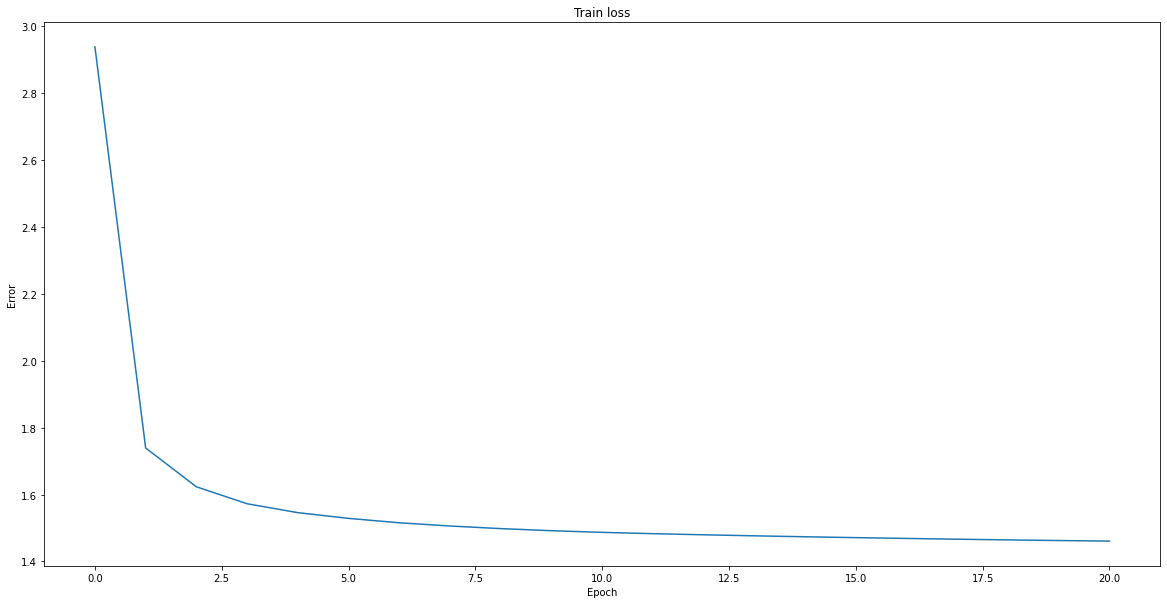

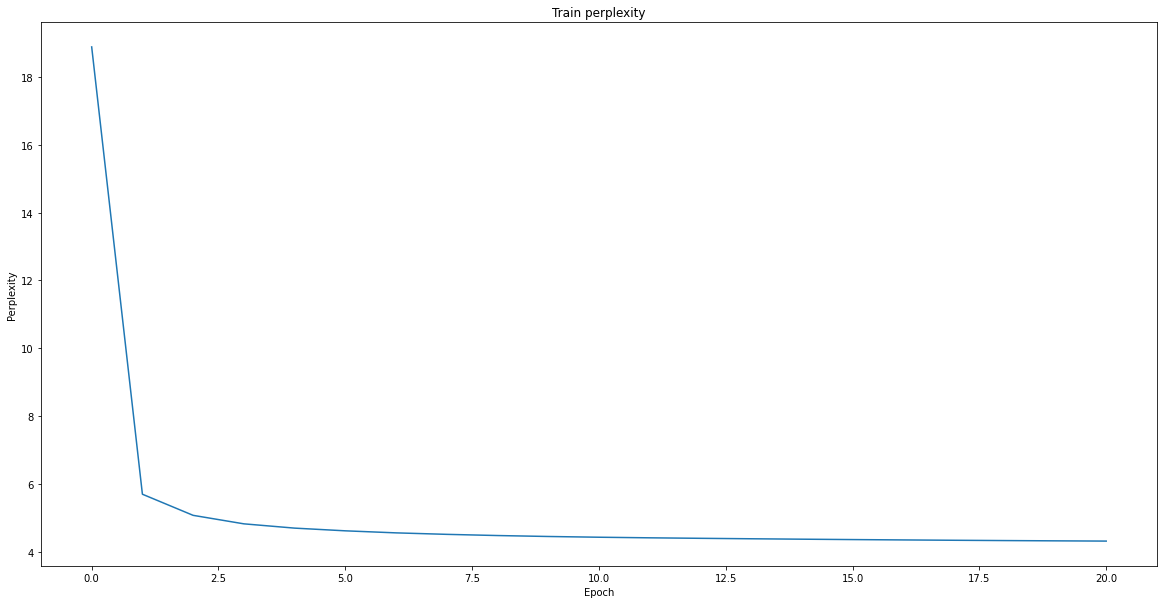

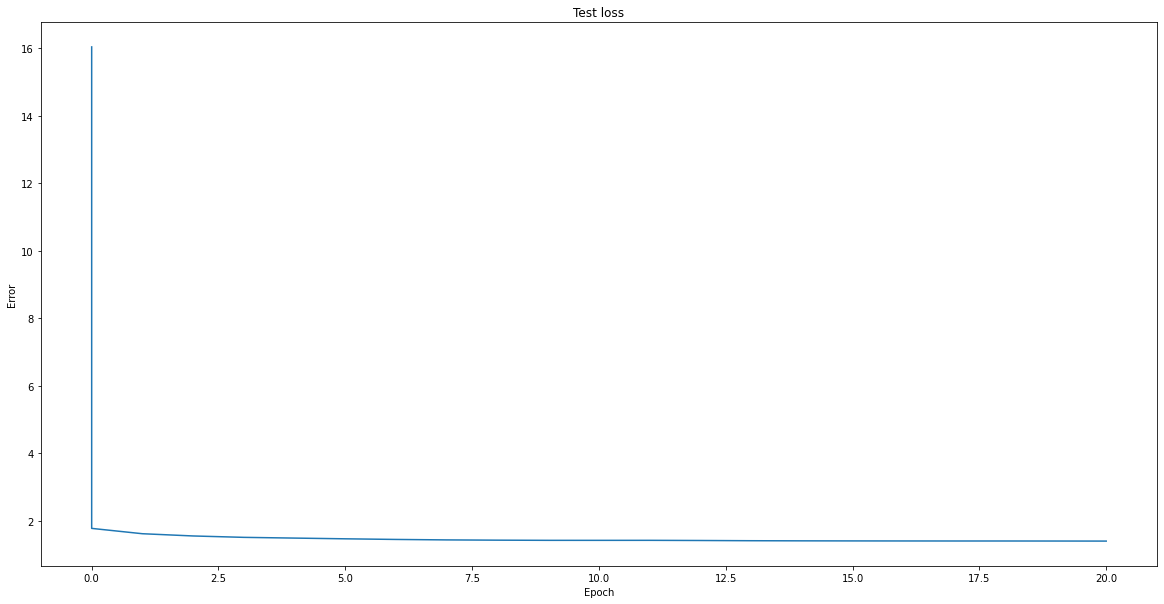

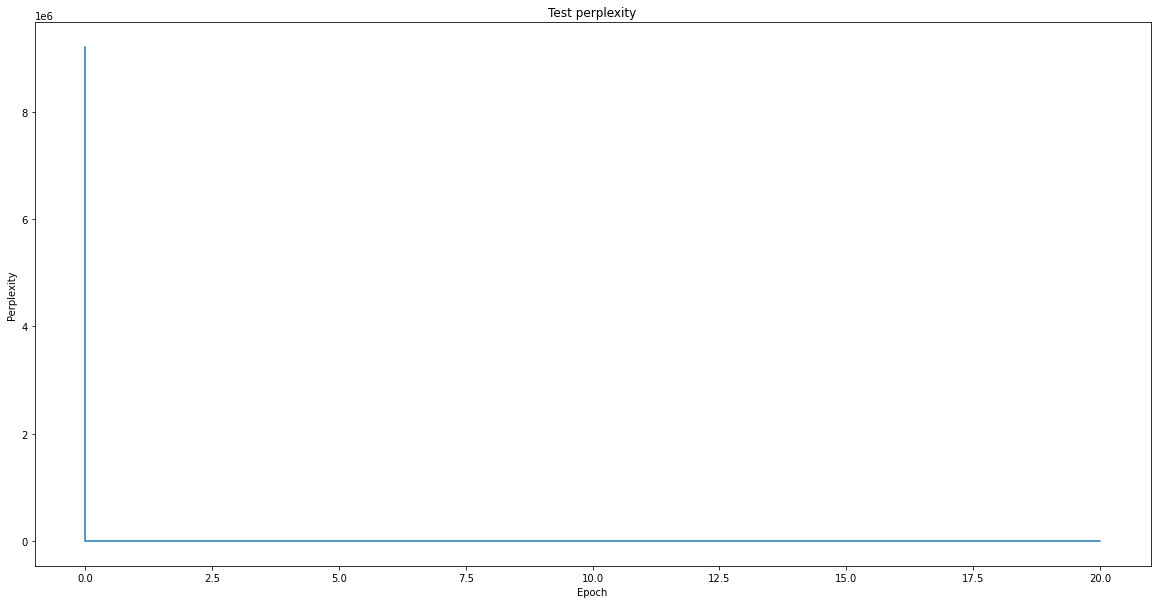

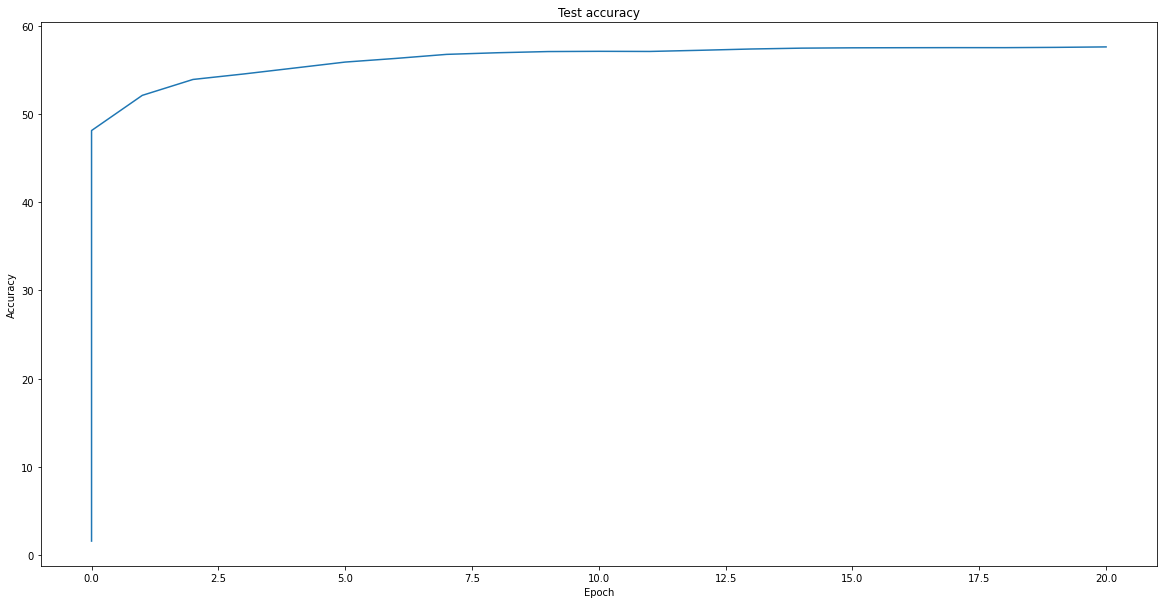

In [13]:
def main():
    SEQUENCE_LENGTH = 50
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log_gru_sherlock.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'sherlock_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'sherlock_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints_gru_sherlock')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints_gru_sherlock/%03d.pt' % epoch)
            seed_words = 'Sherlock Holmes and Watson went to solve a case. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)    
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints_gru_sherlock/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        pt_util.plot(ep, np.exp(val), 'Train perplexity', 'Epoch', 'Perplexity')

        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        pt_util.plot(ep, np.exp(val), 'Test perplexity', 'Epoch', 'Perplexity')  

        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Accuracy')
        return model, vocab, device

final_model, vocab, device = main()

In [14]:
def eval_final_model_sherlock(model, vocab, device):
    seed_words = 'Sherlock Holmes and the '
    sequence_length = 100

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model_sherlock(final_model, vocab, device)

generated with max	 Sherlock Holmes and the state of the state of the state of the state of the state of the state of the state of the state of 
generated with sample	 Sherlock Holmes and the exe changed. I take it, and that they would use, are ween the rule under state diments, on the laxt 
generated with sample	 Sherlock Holmes and the production to you. Monstitutif the gold oflicteep our prelius for the modernment.. The Narid of a bl
generated with sample	 Sherlock Holmes and the fring their purstication on the organs of a man interfue, the tissue of unkepten oliniage pounsing g
generated with sample	 Sherlock Holmes and the plants vew one, of manter ausounced the involfular from them, ladid tounhed, with the muscles inject
generated with sample	 Sherlock Holmes and the room said, and a tamen-shouldgeneren fither colled the puls, those when lifes Prompectale, likning, 
generated with sample	 Sherlock Holmes and the nuture, the owen had been considered. It is applied up. The respoons

## 8.2 Better Network Architecture

In [15]:
TEMPERATURE = 2

class HarryPotterNetV2(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNetV2, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.linear = nn.Linear(self.feature_size, self.feature_size)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()

        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
       
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.linear(x)
        x = nn.functional.relu(x)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

Using device cuda
num workers: 2
Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	X/!*n9a qh!X9nOX *n99eXXnnhnT9aaQ9aZ9Qq!!XQnQ aa-!


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	aaaaaqdQa h-XO*Q aaqqqQXX*Q aa %!!Qaaaaa a ednOaaa


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	!T%9oXaS9aqQ99!!Q%Qqqa99eX %R!QXBQQQ9ea%Qa\ *eoR9-


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	%%eXQQOe!!9S9a999RRQX ee%X %!!QXBQnqqe-%Qa\ *eoR9-


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	qqqOQnX9nOXeR-QQQQnXhQX9Q9aah e *aqqXaq9aeeR!X  h!


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	nnhQT9

  0%|          | 1/390 [00:00<01:10,  5.48it/s]

Train Epoch: 0 [0/99840 (0%)]	Loss: 7.282606


  3%|▎         | 12/390 [00:01<00:39,  9.66it/s]

Train Epoch: 0 [2560/99840 (3%)]	Loss: 2.767319


  6%|▌         | 22/390 [00:02<00:38,  9.65it/s]

Train Epoch: 0 [5120/99840 (5%)]	Loss: 2.347218


  8%|▊         | 32/390 [00:03<00:36,  9.88it/s]

Train Epoch: 0 [7680/99840 (8%)]	Loss: 2.117166


 11%|█         | 42/390 [00:04<00:34, 10.02it/s]

Train Epoch: 0 [10240/99840 (10%)]	Loss: 2.020497


 13%|█▎        | 52/390 [00:05<00:33, 10.08it/s]

Train Epoch: 0 [12800/99840 (13%)]	Loss: 1.937535


 16%|█▌        | 62/390 [00:06<00:32,  9.96it/s]

Train Epoch: 0 [15360/99840 (15%)]	Loss: 1.915332


 18%|█▊        | 72/390 [00:07<00:32,  9.77it/s]

Train Epoch: 0 [17920/99840 (18%)]	Loss: 1.861366


 21%|██        | 82/390 [00:08<00:31,  9.79it/s]

Train Epoch: 0 [20480/99840 (21%)]	Loss: 1.807642


 24%|██▎       | 92/390 [00:09<00:29, 10.06it/s]

Train Epoch: 0 [23040/99840 (23%)]	Loss: 1.798595


 26%|██▌       | 102/390 [00:10<00:28, 10.07it/s]

Train Epoch: 0 [25600/99840 (26%)]	Loss: 1.736720


 29%|██▊       | 112/390 [00:11<00:27, 10.08it/s]

Train Epoch: 0 [28160/99840 (28%)]	Loss: 1.752883


 31%|███▏      | 122/390 [00:12<00:26, 10.04it/s]

Train Epoch: 0 [30720/99840 (31%)]	Loss: 1.716592


 34%|███▍      | 133/390 [00:13<00:25, 10.02it/s]

Train Epoch: 0 [33280/99840 (33%)]	Loss: 1.658115


 36%|███▋      | 142/390 [00:14<00:24,  9.99it/s]

Train Epoch: 0 [35840/99840 (36%)]	Loss: 1.693016


 39%|███▊      | 151/390 [00:15<00:23, 10.07it/s]

Train Epoch: 0 [38400/99840 (38%)]	Loss: 1.665070


 42%|████▏     | 162/390 [00:16<00:23,  9.82it/s]

Train Epoch: 0 [40960/99840 (41%)]	Loss: 1.627948


 44%|████▍     | 173/390 [00:17<00:21,  9.94it/s]

Train Epoch: 0 [43520/99840 (44%)]	Loss: 1.649294


 47%|████▋     | 182/390 [00:18<00:20, 10.09it/s]

Train Epoch: 0 [46080/99840 (46%)]	Loss: 1.616595


 49%|████▉     | 193/390 [00:19<00:19,  9.96it/s]

Train Epoch: 0 [48640/99840 (49%)]	Loss: 1.650649


 52%|█████▏    | 203/390 [00:20<00:18, 10.08it/s]

Train Epoch: 0 [51200/99840 (51%)]	Loss: 1.614587


 55%|█████▍    | 213/390 [00:21<00:17, 10.00it/s]

Train Epoch: 0 [53760/99840 (54%)]	Loss: 1.609242


 57%|█████▋    | 222/390 [00:22<00:16,  9.88it/s]

Train Epoch: 0 [56320/99840 (56%)]	Loss: 1.584839


 59%|█████▉    | 232/390 [00:23<00:15,  9.97it/s]

Train Epoch: 0 [58880/99840 (59%)]	Loss: 1.551674


 62%|██████▏   | 242/390 [00:24<00:15,  9.67it/s]

Train Epoch: 0 [61440/99840 (62%)]	Loss: 1.575253


 65%|██████▍   | 253/390 [00:25<00:13, 10.10it/s]

Train Epoch: 0 [64000/99840 (64%)]	Loss: 1.567563


 67%|██████▋   | 262/390 [00:26<00:12,  9.93it/s]

Train Epoch: 0 [66560/99840 (67%)]	Loss: 1.557551


 70%|██████▉   | 272/390 [00:27<00:11,  9.87it/s]

Train Epoch: 0 [69120/99840 (69%)]	Loss: 1.537916


 72%|███████▏  | 282/390 [00:28<00:10,  9.94it/s]

Train Epoch: 0 [71680/99840 (72%)]	Loss: 1.556617


 75%|███████▍  | 291/390 [00:29<00:09, 10.02it/s]

Train Epoch: 0 [74240/99840 (74%)]	Loss: 1.528629


 77%|███████▋  | 302/390 [00:30<00:08,  9.93it/s]

Train Epoch: 0 [76800/99840 (77%)]	Loss: 1.533092


 80%|████████  | 312/390 [00:31<00:07, 10.10it/s]

Train Epoch: 0 [79360/99840 (79%)]	Loss: 1.520511


 82%|████████▏ | 321/390 [00:32<00:06, 10.07it/s]

Train Epoch: 0 [81920/99840 (82%)]	Loss: 1.520815


 85%|████████▌ | 332/390 [00:33<00:05,  9.88it/s]

Train Epoch: 0 [84480/99840 (85%)]	Loss: 1.554817


 88%|████████▊ | 342/390 [00:34<00:04,  9.89it/s]

Train Epoch: 0 [87040/99840 (87%)]	Loss: 1.481475


 90%|█████████ | 352/390 [00:35<00:03,  9.81it/s]

Train Epoch: 0 [89600/99840 (90%)]	Loss: 1.508822


 93%|█████████▎| 363/390 [00:36<00:02,  9.96it/s]

Train Epoch: 0 [92160/99840 (92%)]	Loss: 1.494678


 95%|█████████▌| 372/390 [00:37<00:01,  9.92it/s]

Train Epoch: 0 [94720/99840 (95%)]	Loss: 1.501873


 98%|█████████▊| 382/390 [00:38<00:00, 10.00it/s]

Train Epoch: 0 [97280/99840 (97%)]	Loss: 1.505166


100%|██████████| 390/390 [00:39<00:00,  9.94it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	tooat aodnttnd soadsd tnain,t the some  oaisk. "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	H ..Iou hodnna l  hery sarl  harry  " .. "Wo 't wo


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed toe snt r.tlme  tnd sarry saap d tumbledore.s


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpdersthe storei,aoi  "arry saadyd tumbledore.s


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	er ng htd soanpeng hn the sogdle of the sork aasht


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain,t tim  "or tnsoment  tarry soeugh  

  1%|          | 2/390 [00:00<01:00,  6.39it/s]

Train Epoch: 1 [0/99840 (0%)]	Loss: 1.494277


  3%|▎         | 12/390 [00:01<00:38,  9.74it/s]

Train Epoch: 1 [2560/99840 (3%)]	Loss: 1.483276


  6%|▌         | 22/390 [00:02<00:36,  9.98it/s]

Train Epoch: 1 [5120/99840 (5%)]	Loss: 1.490310


  8%|▊         | 32/390 [00:03<00:35, 10.05it/s]

Train Epoch: 1 [7680/99840 (8%)]	Loss: 1.469178


 11%|█         | 42/390 [00:04<00:35,  9.87it/s]

Train Epoch: 1 [10240/99840 (10%)]	Loss: 1.466288


 14%|█▎        | 53/390 [00:05<00:33, 10.01it/s]

Train Epoch: 1 [12800/99840 (13%)]	Loss: 1.462164


 16%|█▌        | 63/390 [00:06<00:32, 10.04it/s]

Train Epoch: 1 [15360/99840 (15%)]	Loss: 1.492212


 19%|█▊        | 73/390 [00:07<00:31, 10.08it/s]

Train Epoch: 1 [17920/99840 (18%)]	Loss: 1.477442


 21%|██        | 81/390 [00:08<00:30, 10.04it/s]

Train Epoch: 1 [20480/99840 (21%)]	Loss: 1.464472


 23%|██▎       | 91/390 [00:09<00:29, 10.07it/s]

Train Epoch: 1 [23040/99840 (23%)]	Loss: 1.484107


 26%|██▋       | 103/390 [00:10<00:28, 10.01it/s]

Train Epoch: 1 [25600/99840 (26%)]	Loss: 1.433443


 29%|██▊       | 112/390 [00:11<00:28,  9.83it/s]

Train Epoch: 1 [28160/99840 (28%)]	Loss: 1.475695


 31%|███▏      | 122/390 [00:12<00:26,  9.93it/s]

Train Epoch: 1 [30720/99840 (31%)]	Loss: 1.457183


 34%|███▍      | 132/390 [00:13<00:26,  9.87it/s]

Train Epoch: 1 [33280/99840 (33%)]	Loss: 1.406765


 36%|███▌      | 141/390 [00:14<00:24, 10.09it/s]

Train Epoch: 1 [35840/99840 (36%)]	Loss: 1.448645


 39%|███▉      | 152/390 [00:15<00:24,  9.86it/s]

Train Epoch: 1 [38400/99840 (38%)]	Loss: 1.441784


 42%|████▏     | 162/390 [00:16<00:23,  9.81it/s]

Train Epoch: 1 [40960/99840 (41%)]	Loss: 1.402156


 44%|████▍     | 172/390 [00:17<00:21,  9.99it/s]

Train Epoch: 1 [43520/99840 (44%)]	Loss: 1.446513


 47%|████▋     | 182/390 [00:18<00:21,  9.87it/s]

Train Epoch: 1 [46080/99840 (46%)]	Loss: 1.419115


 49%|████▉     | 192/390 [00:19<00:19,  9.99it/s]

Train Epoch: 1 [48640/99840 (49%)]	Loss: 1.453060


 52%|█████▏    | 203/390 [00:20<00:18, 10.02it/s]

Train Epoch: 1 [51200/99840 (51%)]	Loss: 1.432871


 55%|█████▍    | 213/390 [00:21<00:17, 10.08it/s]

Train Epoch: 1 [53760/99840 (54%)]	Loss: 1.421801


 57%|█████▋    | 222/390 [00:22<00:16, 10.00it/s]

Train Epoch: 1 [56320/99840 (56%)]	Loss: 1.426727


 60%|█████▉    | 233/390 [00:23<00:15,  9.98it/s]

Train Epoch: 1 [58880/99840 (59%)]	Loss: 1.389866


 62%|██████▏   | 242/390 [00:24<00:14,  9.89it/s]

Train Epoch: 1 [61440/99840 (62%)]	Loss: 1.425419


 65%|██████▍   | 252/390 [00:25<00:14,  9.85it/s]

Train Epoch: 1 [64000/99840 (64%)]	Loss: 1.416397


 67%|██████▋   | 262/390 [00:26<00:13,  9.77it/s]

Train Epoch: 1 [66560/99840 (67%)]	Loss: 1.418537


 69%|██████▉   | 271/390 [00:27<00:11, 10.06it/s]

Train Epoch: 1 [69120/99840 (69%)]	Loss: 1.397841


 73%|███████▎  | 283/390 [00:28<00:10, 10.10it/s]

Train Epoch: 1 [71680/99840 (72%)]	Loss: 1.411690


 75%|███████▍  | 292/390 [00:29<00:10,  9.67it/s]

Train Epoch: 1 [74240/99840 (74%)]	Loss: 1.400835


 77%|███████▋  | 302/390 [00:30<00:08, 10.02it/s]

Train Epoch: 1 [76800/99840 (77%)]	Loss: 1.416270


 80%|███████▉  | 311/390 [00:31<00:07, 10.11it/s]

Train Epoch: 1 [79360/99840 (79%)]	Loss: 1.403553


 83%|████████▎ | 322/390 [00:32<00:06, 10.06it/s]

Train Epoch: 1 [81920/99840 (82%)]	Loss: 1.396798


 85%|████████▍ | 331/390 [00:33<00:05, 10.06it/s]

Train Epoch: 1 [84480/99840 (85%)]	Loss: 1.435752


 88%|████████▊ | 343/390 [00:34<00:04, 10.05it/s]

Train Epoch: 1 [87040/99840 (87%)]	Loss: 1.366148


 90%|█████████ | 352/390 [00:35<00:03,  9.87it/s]

Train Epoch: 1 [89600/99840 (90%)]	Loss: 1.410833


 93%|█████████▎| 362/390 [00:36<00:02,  9.86it/s]

Train Epoch: 1 [92160/99840 (92%)]	Loss: 1.398112


 95%|█████████▌| 372/390 [00:37<00:01, 10.04it/s]

Train Epoch: 1 [94720/99840 (95%)]	Loss: 1.402391


 98%|█████████▊| 382/390 [00:38<00:00, 10.05it/s]

Train Epoch: 1 [97280/99840 (97%)]	Loss: 1.404471


100%|██████████| 390/390 [00:39<00:00,  9.93it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	troet solntand soaded anain,t the wose  aaisl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	H . aou wod ni l  Iery sell  tarry ." .  "Wo 't wh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	wsed the wntrr alse  and tarry saad d humbledore.w


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck apder the wiaiti ati  aarry wa ded aumbledore.w


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	ering atd soanpeng hn the waddle of the work aash 


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain,t tim  "or ansoment  tarry woought 

  1%|          | 2/390 [00:00<00:58,  6.60it/s]

Train Epoch: 2 [0/99840 (0%)]	Loss: 1.399137


  3%|▎         | 13/390 [00:01<00:38,  9.91it/s]

Train Epoch: 2 [2560/99840 (3%)]	Loss: 1.391560


  6%|▌         | 23/390 [00:02<00:36,  9.95it/s]

Train Epoch: 2 [5120/99840 (5%)]	Loss: 1.397705


  8%|▊         | 32/390 [00:03<00:36,  9.89it/s]

Train Epoch: 2 [7680/99840 (8%)]	Loss: 1.379754


 11%|█         | 42/390 [00:04<00:35,  9.83it/s]

Train Epoch: 2 [10240/99840 (10%)]	Loss: 1.379204


 14%|█▎        | 53/390 [00:05<00:33, 10.09it/s]

Train Epoch: 2 [12800/99840 (13%)]	Loss: 1.374490


 16%|█▌        | 62/390 [00:06<00:32,  9.99it/s]

Train Epoch: 2 [15360/99840 (15%)]	Loss: 1.407482


 18%|█▊        | 72/390 [00:07<00:32,  9.81it/s]

Train Epoch: 2 [17920/99840 (18%)]	Loss: 1.392818


 21%|██        | 82/390 [00:08<00:31,  9.89it/s]

Train Epoch: 2 [20480/99840 (21%)]	Loss: 1.385606


 24%|██▎       | 92/390 [00:09<00:30,  9.67it/s]

Train Epoch: 2 [23040/99840 (23%)]	Loss: 1.407552


 26%|██▋       | 103/390 [00:10<00:28, 10.01it/s]

Train Epoch: 2 [25600/99840 (26%)]	Loss: 1.353016


 29%|██▊       | 112/390 [00:11<00:28,  9.82it/s]

Train Epoch: 2 [28160/99840 (28%)]	Loss: 1.404951


 32%|███▏      | 123/390 [00:12<00:26, 10.03it/s]

Train Epoch: 2 [30720/99840 (31%)]	Loss: 1.391252


 34%|███▍      | 132/390 [00:13<00:25, 10.03it/s]

Train Epoch: 2 [33280/99840 (33%)]	Loss: 1.342109


 36%|███▋      | 142/390 [00:14<00:25,  9.67it/s]

Train Epoch: 2 [35840/99840 (36%)]	Loss: 1.387446


 39%|███▉      | 153/390 [00:15<00:23,  9.92it/s]

Train Epoch: 2 [38400/99840 (38%)]	Loss: 1.376717


 42%|████▏     | 163/390 [00:16<00:23,  9.82it/s]

Train Epoch: 2 [40960/99840 (41%)]	Loss: 1.337187


 44%|████▍     | 173/390 [00:17<00:21, 10.00it/s]

Train Epoch: 2 [43520/99840 (44%)]	Loss: 1.386302


 47%|████▋     | 183/390 [00:18<00:20, 10.05it/s]

Train Epoch: 2 [46080/99840 (46%)]	Loss: 1.357040


 49%|████▉     | 191/390 [00:19<00:19, 10.05it/s]

Train Epoch: 2 [48640/99840 (49%)]	Loss: 1.393134


 52%|█████▏    | 202/390 [00:20<00:18, 10.04it/s]

Train Epoch: 2 [51200/99840 (51%)]	Loss: 1.374215


 54%|█████▍    | 212/390 [00:21<00:17,  9.93it/s]

Train Epoch: 2 [53760/99840 (54%)]	Loss: 1.367988


 57%|█████▋    | 222/390 [00:22<00:16, 10.00it/s]

Train Epoch: 2 [56320/99840 (56%)]	Loss: 1.373859


 60%|█████▉    | 233/390 [00:23<00:15, 10.09it/s]

Train Epoch: 2 [58880/99840 (59%)]	Loss: 1.339391


 62%|██████▏   | 241/390 [00:24<00:14, 10.06it/s]

Train Epoch: 2 [61440/99840 (62%)]	Loss: 1.373753


 65%|██████▍   | 253/390 [00:25<00:13, 10.06it/s]

Train Epoch: 2 [64000/99840 (64%)]	Loss: 1.364264


 67%|██████▋   | 262/390 [00:26<00:13,  9.79it/s]

Train Epoch: 2 [66560/99840 (67%)]	Loss: 1.370864


 70%|██████▉   | 272/390 [00:27<00:11, 10.03it/s]

Train Epoch: 2 [69120/99840 (69%)]	Loss: 1.354308


 72%|███████▏  | 282/390 [00:28<00:10,  9.87it/s]

Train Epoch: 2 [71680/99840 (72%)]	Loss: 1.365380


 75%|███████▌  | 293/390 [00:29<00:09, 10.01it/s]

Train Epoch: 2 [74240/99840 (74%)]	Loss: 1.351601


 78%|███████▊  | 303/390 [00:30<00:08, 10.08it/s]

Train Epoch: 2 [76800/99840 (77%)]	Loss: 1.367827


 80%|████████  | 313/390 [00:31<00:07, 10.04it/s]

Train Epoch: 2 [79360/99840 (79%)]	Loss: 1.360875


 83%|████████▎ | 322/390 [00:32<00:06,  9.91it/s]

Train Epoch: 2 [81920/99840 (82%)]	Loss: 1.354703


 85%|████████▌ | 332/390 [00:33<00:05,  9.77it/s]

Train Epoch: 2 [84480/99840 (85%)]	Loss: 1.395730


 88%|████████▊ | 342/390 [00:34<00:04,  9.95it/s]

Train Epoch: 2 [87040/99840 (87%)]	Loss: 1.328472


 90%|█████████ | 352/390 [00:35<00:03,  9.76it/s]

Train Epoch: 2 [89600/99840 (90%)]	Loss: 1.368452


 93%|█████████▎| 362/390 [00:36<00:02,  9.96it/s]

Train Epoch: 2 [92160/99840 (92%)]	Loss: 1.357506


 96%|█████████▌| 373/390 [00:37<00:01, 10.04it/s]

Train Epoch: 2 [94720/99840 (95%)]	Loss: 1.367433


 98%|█████████▊| 383/390 [00:38<00:00, 10.03it/s]

Train Epoch: 2 [97280/99840 (97%)]	Loss: 1.368383


100%|██████████| 390/390 [00:39<00:00,  9.91it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	tooet solntand soaded tnain,t the tose  aaisl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	H . Iou wod na l  tery sall  tarry "" .  "Ion't sh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed the wtt r aose  hnd tarry saaded humbledore.w


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the tiriti ati  warry sa ded aumbledore,w


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	ering hnd seanpeng hn hhe caddle of the work oagh 


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain,t tim  "or ansoment  tarry woought 

  1%|          | 2/390 [00:00<01:03,  6.11it/s]

Train Epoch: 3 [0/99840 (0%)]	Loss: 1.359312


  3%|▎         | 13/390 [00:01<00:38,  9.92it/s]

Train Epoch: 3 [2560/99840 (3%)]	Loss: 1.361840


  6%|▌         | 23/390 [00:02<00:36, 10.08it/s]

Train Epoch: 3 [5120/99840 (5%)]	Loss: 1.362611


  8%|▊         | 33/390 [00:03<00:35, 10.13it/s]

Train Epoch: 3 [7680/99840 (8%)]	Loss: 1.347865


 11%|█         | 41/390 [00:04<00:34, 10.12it/s]

Train Epoch: 3 [10240/99840 (10%)]	Loss: 1.350561


 13%|█▎        | 52/390 [00:05<00:34,  9.90it/s]

Train Epoch: 3 [12800/99840 (13%)]	Loss: 1.347153


 16%|█▌        | 62/390 [00:06<00:33,  9.87it/s]

Train Epoch: 3 [15360/99840 (15%)]	Loss: 1.378190


 18%|█▊        | 72/390 [00:07<00:31, 10.06it/s]

Train Epoch: 3 [17920/99840 (18%)]	Loss: 1.362420


 21%|██        | 82/390 [00:08<00:30, 10.02it/s]

Train Epoch: 3 [20480/99840 (21%)]	Loss: 1.350868


 24%|██▎       | 92/390 [00:09<00:29, 10.03it/s]

Train Epoch: 3 [23040/99840 (23%)]	Loss: 1.379955


 26%|██▌       | 102/390 [00:10<00:28, 10.04it/s]

Train Epoch: 3 [25600/99840 (26%)]	Loss: 1.326143


 29%|██▊       | 112/390 [00:11<00:27, 10.02it/s]

Train Epoch: 3 [28160/99840 (28%)]	Loss: 1.380064


 31%|███▏      | 122/390 [00:12<00:27,  9.82it/s]

Train Epoch: 3 [30720/99840 (31%)]	Loss: 1.368562


 34%|███▍      | 132/390 [00:13<00:26,  9.77it/s]

Train Epoch: 3 [33280/99840 (33%)]	Loss: 1.317074


 36%|███▋      | 142/390 [00:14<00:24, 10.06it/s]

Train Epoch: 3 [35840/99840 (36%)]	Loss: 1.362722


 39%|███▉      | 152/390 [00:15<00:23,  9.98it/s]

Train Epoch: 3 [38400/99840 (38%)]	Loss: 1.347429


 42%|████▏     | 162/390 [00:16<00:22, 10.02it/s]

Train Epoch: 3 [40960/99840 (41%)]	Loss: 1.312570


 44%|████▍     | 172/390 [00:17<00:22,  9.76it/s]

Train Epoch: 3 [43520/99840 (44%)]	Loss: 1.366055


 47%|████▋     | 183/390 [00:18<00:20,  9.93it/s]

Train Epoch: 3 [46080/99840 (46%)]	Loss: 1.334494


 49%|████▉     | 193/390 [00:19<00:19, 10.01it/s]

Train Epoch: 3 [48640/99840 (49%)]	Loss: 1.369856


 52%|█████▏    | 203/390 [00:20<00:18, 10.13it/s]

Train Epoch: 3 [51200/99840 (51%)]	Loss: 1.353180


 55%|█████▍    | 213/390 [00:21<00:17, 10.02it/s]

Train Epoch: 3 [53760/99840 (54%)]	Loss: 1.348825


 57%|█████▋    | 222/390 [00:22<00:17,  9.72it/s]

Train Epoch: 3 [56320/99840 (56%)]	Loss: 1.353248


 59%|█████▉    | 231/390 [00:23<00:15, 10.09it/s]

Train Epoch: 3 [58880/99840 (59%)]	Loss: 1.319323


 62%|██████▏   | 242/390 [00:24<00:14,  9.97it/s]

Train Epoch: 3 [61440/99840 (62%)]	Loss: 1.353294


 65%|██████▍   | 252/390 [00:25<00:13,  9.89it/s]

Train Epoch: 3 [64000/99840 (64%)]	Loss: 1.345596


 67%|██████▋   | 262/390 [00:26<00:12, 10.04it/s]

Train Epoch: 3 [66560/99840 (67%)]	Loss: 1.351008


 70%|██████▉   | 272/390 [00:27<00:11,  9.95it/s]

Train Epoch: 3 [69120/99840 (69%)]	Loss: 1.336917


 73%|███████▎  | 283/390 [00:28<00:10, 10.05it/s]

Train Epoch: 3 [71680/99840 (72%)]	Loss: 1.348401


 75%|███████▍  | 292/390 [00:29<00:09,  9.97it/s]

Train Epoch: 3 [74240/99840 (74%)]	Loss: 1.332068


 77%|███████▋  | 302/390 [00:30<00:08, 10.02it/s]

Train Epoch: 3 [76800/99840 (77%)]	Loss: 1.348086


 80%|████████  | 312/390 [00:31<00:07, 10.00it/s]

Train Epoch: 3 [79360/99840 (79%)]	Loss: 1.347443


 83%|████████▎ | 322/390 [00:32<00:06, 10.12it/s]

Train Epoch: 3 [81920/99840 (82%)]	Loss: 1.338394


 85%|████████▌ | 332/390 [00:33<00:05, 10.02it/s]

Train Epoch: 3 [84480/99840 (85%)]	Loss: 1.381808


 88%|████████▊ | 342/390 [00:34<00:04,  9.88it/s]

Train Epoch: 3 [87040/99840 (87%)]	Loss: 1.311743


 90%|█████████ | 352/390 [00:35<00:03,  9.94it/s]

Train Epoch: 3 [89600/99840 (90%)]	Loss: 1.354594


 93%|█████████▎| 362/390 [00:36<00:02,  9.84it/s]

Train Epoch: 3 [92160/99840 (92%)]	Loss: 1.343344


 95%|█████████▌| 372/390 [00:37<00:01,  9.83it/s]

Train Epoch: 3 [94720/99840 (95%)]	Loss: 1.355301


 98%|█████████▊| 382/390 [00:38<00:00,  9.93it/s]

Train Epoch: 3 [97280/99840 (97%)]	Loss: 1.353139


100%|██████████| 390/390 [00:39<00:00,  9.95it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	tooet solntand soaved tnain,t the wose  aaasl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	H . aou wod yi l  Iery sall  Iarry, I .  "Ion't sh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed hhe wtt r aose  and harry saad d humbledore.w


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck apder the wirity ati  aarry sa ded humbledore w


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	ering and seonpeng hn hhe caddle of the work oagh 


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain,t tim  "or a soment  tarry woought 

  1%|          | 2/390 [00:00<01:02,  6.24it/s]

Train Epoch: 4 [0/99840 (0%)]	Loss: 1.344756


  3%|▎         | 12/390 [00:01<00:39,  9.64it/s]

Train Epoch: 4 [2560/99840 (3%)]	Loss: 1.346721


  6%|▌         | 22/390 [00:02<00:37,  9.94it/s]

Train Epoch: 4 [5120/99840 (5%)]	Loss: 1.349431


  8%|▊         | 33/390 [00:03<00:35,  9.94it/s]

Train Epoch: 4 [7680/99840 (8%)]	Loss: 1.334358


 11%|█         | 42/390 [00:04<00:35,  9.70it/s]

Train Epoch: 4 [10240/99840 (10%)]	Loss: 1.340144


 13%|█▎        | 52/390 [00:05<00:33,  9.96it/s]

Train Epoch: 4 [12800/99840 (13%)]	Loss: 1.336908


 16%|█▌        | 62/390 [00:06<00:32, 10.03it/s]

Train Epoch: 4 [15360/99840 (15%)]	Loss: 1.370781


 18%|█▊        | 72/390 [00:07<00:31,  9.94it/s]

Train Epoch: 4 [17920/99840 (18%)]	Loss: 1.351317


 21%|██        | 82/390 [00:08<00:31,  9.93it/s]

Train Epoch: 4 [20480/99840 (21%)]	Loss: 1.338351


 24%|██▎       | 92/390 [00:09<00:29,  9.99it/s]

Train Epoch: 4 [23040/99840 (23%)]	Loss: 1.372098


 26%|██▌       | 102/390 [00:10<00:29,  9.88it/s]

Train Epoch: 4 [25600/99840 (26%)]	Loss: 1.318075


 29%|██▊       | 112/390 [00:11<00:27, 10.11it/s]

Train Epoch: 4 [28160/99840 (28%)]	Loss: 1.369588


 31%|███▏      | 122/390 [00:12<00:26,  9.97it/s]

Train Epoch: 4 [30720/99840 (31%)]	Loss: 1.359228


 34%|███▍      | 132/390 [00:13<00:26,  9.75it/s]

Train Epoch: 4 [33280/99840 (33%)]	Loss: 1.310111


 37%|███▋      | 143/390 [00:14<00:24, 10.09it/s]

Train Epoch: 4 [35840/99840 (36%)]	Loss: 1.355714


 39%|███▉      | 153/390 [00:15<00:23, 10.02it/s]

Train Epoch: 4 [38400/99840 (38%)]	Loss: 1.337863


 42%|████▏     | 163/390 [00:16<00:22,  9.95it/s]

Train Epoch: 4 [40960/99840 (41%)]	Loss: 1.306342


 44%|████▍     | 172/390 [00:17<00:21,  9.96it/s]

Train Epoch: 4 [43520/99840 (44%)]	Loss: 1.359528


 47%|████▋     | 182/390 [00:18<00:20, 10.04it/s]

Train Epoch: 4 [46080/99840 (46%)]	Loss: 1.328326


 49%|████▉     | 192/390 [00:19<00:19, 10.13it/s]

Train Epoch: 4 [48640/99840 (49%)]	Loss: 1.363922


 52%|█████▏    | 202/390 [00:20<00:18,  9.95it/s]

Train Epoch: 4 [51200/99840 (51%)]	Loss: 1.347339


 54%|█████▍    | 212/390 [00:21<00:17,  9.97it/s]

Train Epoch: 4 [53760/99840 (54%)]	Loss: 1.343894


 57%|█████▋    | 222/390 [00:22<00:16, 10.00it/s]

Train Epoch: 4 [56320/99840 (56%)]	Loss: 1.346461


 59%|█████▉    | 231/390 [00:23<00:15, 10.06it/s]

Train Epoch: 4 [58880/99840 (59%)]	Loss: 1.311768


 62%|██████▏   | 241/390 [00:24<00:14, 10.05it/s]

Train Epoch: 4 [61440/99840 (62%)]	Loss: 1.346076


 65%|██████▍   | 253/390 [00:25<00:13, 10.02it/s]

Train Epoch: 4 [64000/99840 (64%)]	Loss: 1.338499


 67%|██████▋   | 262/390 [00:26<00:12,  9.93it/s]

Train Epoch: 4 [66560/99840 (67%)]	Loss: 1.342992


 70%|███████   | 273/390 [00:27<00:11,  9.83it/s]

Train Epoch: 4 [69120/99840 (69%)]	Loss: 1.330841


 73%|███████▎  | 283/390 [00:28<00:10,  9.93it/s]

Train Epoch: 4 [71680/99840 (72%)]	Loss: 1.343417


 75%|███████▍  | 292/390 [00:29<00:09,  9.99it/s]

Train Epoch: 4 [74240/99840 (74%)]	Loss: 1.325195


 77%|███████▋  | 302/390 [00:30<00:08,  9.95it/s]

Train Epoch: 4 [76800/99840 (77%)]	Loss: 1.342243


 80%|████████  | 312/390 [00:31<00:07, 10.02it/s]

Train Epoch: 4 [79360/99840 (79%)]	Loss: 1.344659


 83%|████████▎ | 322/390 [00:32<00:06,  9.72it/s]

Train Epoch: 4 [81920/99840 (82%)]	Loss: 1.333801


 85%|████████▌ | 333/390 [00:33<00:05, 10.00it/s]

Train Epoch: 4 [84480/99840 (85%)]	Loss: 1.374624


 88%|████████▊ | 342/390 [00:34<00:04,  9.86it/s]

Train Epoch: 4 [87040/99840 (87%)]	Loss: 1.306225


 91%|█████████ | 353/390 [00:35<00:03, 10.02it/s]

Train Epoch: 4 [89600/99840 (90%)]	Loss: 1.350389


 93%|█████████▎| 363/390 [00:36<00:02, 10.01it/s]

Train Epoch: 4 [92160/99840 (92%)]	Loss: 1.338058


 96%|█████████▌| 373/390 [00:37<00:01, 10.10it/s]

Train Epoch: 4 [94720/99840 (95%)]	Loss: 1.349186


 98%|█████████▊| 383/390 [00:38<00:00, 10.04it/s]

Train Epoch: 4 [97280/99840 (97%)]	Loss: 1.349132


100%|██████████| 390/390 [00:39<00:00,  9.94it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	tooet solntand soaded anain.t the wase  aaasl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . aou wod ya l  Iery sall  Iarry,"I .  "Ion't sh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed hhe stt r aose  and sarry saaded humbledore.h


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck apder the siaiti ati  aarry saaded humbledore w


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	ering and soonpeng hn hhe caddle of the sork aagh 


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain,t tim  "or a soment  tarry woought 

  1%|          | 2/390 [00:00<01:00,  6.46it/s]

Train Epoch: 5 [0/99840 (0%)]	Loss: 1.341771


  3%|▎         | 12/390 [00:01<00:38,  9.72it/s]

Train Epoch: 5 [2560/99840 (3%)]	Loss: 1.339028


  6%|▌         | 22/390 [00:02<00:36, 10.03it/s]

Train Epoch: 5 [5120/99840 (5%)]	Loss: 1.344045


  8%|▊         | 33/390 [00:03<00:35, 10.02it/s]

Train Epoch: 5 [7680/99840 (8%)]	Loss: 1.329141


 11%|█         | 43/390 [00:04<00:34, 10.07it/s]

Train Epoch: 5 [10240/99840 (10%)]	Loss: 1.337315


 13%|█▎        | 52/390 [00:05<00:33, 10.09it/s]

Train Epoch: 5 [12800/99840 (13%)]	Loss: 1.336845


 16%|█▌        | 63/390 [00:06<00:32,  9.94it/s]

Train Epoch: 5 [15360/99840 (15%)]	Loss: 1.366614


 18%|█▊        | 72/390 [00:07<00:31, 10.01it/s]

Train Epoch: 5 [17920/99840 (18%)]	Loss: 1.347185


 21%|██        | 82/390 [00:08<00:30,  9.94it/s]

Train Epoch: 5 [20480/99840 (21%)]	Loss: 1.337068


 24%|██▎       | 92/390 [00:09<00:29,  9.98it/s]

Train Epoch: 5 [23040/99840 (23%)]	Loss: 1.369193


 26%|██▌       | 102/390 [00:10<00:28, 10.04it/s]

Train Epoch: 5 [25600/99840 (26%)]	Loss: 1.314756


 29%|██▉       | 113/390 [00:11<00:27, 10.00it/s]

Train Epoch: 5 [28160/99840 (28%)]	Loss: 1.364557


 32%|███▏      | 123/390 [00:12<00:26, 10.00it/s]

Train Epoch: 5 [30720/99840 (31%)]	Loss: 1.356106


 34%|███▎      | 131/390 [00:13<00:25, 10.03it/s]

Train Epoch: 5 [33280/99840 (33%)]	Loss: 1.309118


 36%|███▋      | 142/390 [00:14<00:24,  9.98it/s]

Train Epoch: 5 [35840/99840 (36%)]	Loss: 1.353004


 39%|███▉      | 153/390 [00:15<00:23, 10.05it/s]

Train Epoch: 5 [38400/99840 (38%)]	Loss: 1.336220


 42%|████▏     | 162/390 [00:16<00:22, 10.06it/s]

Train Epoch: 5 [40960/99840 (41%)]	Loss: 1.305202


 44%|████▍     | 172/390 [00:17<00:21, 10.09it/s]

Train Epoch: 5 [43520/99840 (44%)]	Loss: 1.356573


 47%|████▋     | 182/390 [00:18<00:21,  9.83it/s]

Train Epoch: 5 [46080/99840 (46%)]	Loss: 1.327671


 49%|████▉     | 193/390 [00:19<00:19, 10.04it/s]

Train Epoch: 5 [48640/99840 (49%)]	Loss: 1.362563


 52%|█████▏    | 202/390 [00:20<00:19,  9.89it/s]

Train Epoch: 5 [51200/99840 (51%)]	Loss: 1.345820


 54%|█████▍    | 212/390 [00:21<00:18,  9.83it/s]

Train Epoch: 5 [53760/99840 (54%)]	Loss: 1.341820


 57%|█████▋    | 222/390 [00:22<00:16,  9.95it/s]

Train Epoch: 5 [56320/99840 (56%)]	Loss: 1.343077


 59%|█████▉    | 232/390 [00:23<00:16,  9.77it/s]

Train Epoch: 5 [58880/99840 (59%)]	Loss: 1.310710


 62%|██████▏   | 243/390 [00:24<00:14, 10.04it/s]

Train Epoch: 5 [61440/99840 (62%)]	Loss: 1.345730


 65%|██████▍   | 253/390 [00:25<00:13, 10.09it/s]

Train Epoch: 5 [64000/99840 (64%)]	Loss: 1.338521


 67%|██████▋   | 262/390 [00:26<00:12, 10.09it/s]

Train Epoch: 5 [66560/99840 (67%)]	Loss: 1.339063


 70%|███████   | 273/390 [00:27<00:11, 10.06it/s]

Train Epoch: 5 [69120/99840 (69%)]	Loss: 1.333355


 72%|███████▏  | 282/390 [00:28<00:10, 10.03it/s]

Train Epoch: 5 [71680/99840 (72%)]	Loss: 1.344242


 75%|███████▍  | 292/390 [00:29<00:09,  9.86it/s]

Train Epoch: 5 [74240/99840 (74%)]	Loss: 1.324805


 78%|███████▊  | 303/390 [00:30<00:08, 10.09it/s]

Train Epoch: 5 [76800/99840 (77%)]	Loss: 1.342617


 80%|████████  | 312/390 [00:31<00:07, 10.08it/s]

Train Epoch: 5 [79360/99840 (79%)]	Loss: 1.343518


 83%|████████▎ | 322/390 [00:32<00:06, 10.02it/s]

Train Epoch: 5 [81920/99840 (82%)]	Loss: 1.331331


 85%|████████▌ | 332/390 [00:33<00:05,  9.91it/s]

Train Epoch: 5 [84480/99840 (85%)]	Loss: 1.373423


 88%|████████▊ | 342/390 [00:34<00:04,  9.89it/s]

Train Epoch: 5 [87040/99840 (87%)]	Loss: 1.307232


 91%|█████████ | 353/390 [00:35<00:03, 10.05it/s]

Train Epoch: 5 [89600/99840 (90%)]	Loss: 1.348238


 93%|█████████▎| 362/390 [00:36<00:02, 10.14it/s]

Train Epoch: 5 [92160/99840 (92%)]	Loss: 1.336818


 95%|█████████▌| 372/390 [00:37<00:01,  9.99it/s]

Train Epoch: 5 [94720/99840 (95%)]	Loss: 1.346761


 98%|█████████▊| 382/390 [00:38<00:00, 10.02it/s]

Train Epoch: 5 [97280/99840 (97%)]	Loss: 1.347711


100%|██████████| 390/390 [00:39<00:00,  9.94it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet solntond soantd anain.t the sose  aaasls "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . aou wod ya l  Iery sall  tarry,"I .  "Ion't sh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed hhe ctt r aone  and sarry saaded humbledore.a


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck apder the siaiti ati  aarry saaded aumbledore w


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring and soonpeng hn hhe caddle of the sork aagh 


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain,t tim  "or a soment  tarry woought 

  1%|          | 2/390 [00:00<01:02,  6.22it/s]

Train Epoch: 6 [0/99840 (0%)]	Loss: 1.342111


  3%|▎         | 12/390 [00:01<00:39,  9.59it/s]

Train Epoch: 6 [2560/99840 (3%)]	Loss: 1.339247


  6%|▌         | 22/390 [00:02<00:38,  9.68it/s]

Train Epoch: 6 [5120/99840 (5%)]	Loss: 1.343126


  8%|▊         | 33/390 [00:03<00:35, 10.11it/s]

Train Epoch: 6 [7680/99840 (8%)]	Loss: 1.328684


 11%|█         | 43/390 [00:04<00:34, 10.10it/s]

Train Epoch: 6 [10240/99840 (10%)]	Loss: 1.335025


 13%|█▎        | 52/390 [00:05<00:33, 10.03it/s]

Train Epoch: 6 [12800/99840 (13%)]	Loss: 1.338622


 16%|█▌        | 61/390 [00:06<00:32, 10.01it/s]

Train Epoch: 6 [15360/99840 (15%)]	Loss: 1.366086


 18%|█▊        | 72/390 [00:07<00:31,  9.94it/s]

Train Epoch: 6 [17920/99840 (18%)]	Loss: 1.347524


 21%|██        | 82/390 [00:08<00:31,  9.85it/s]

Train Epoch: 6 [20480/99840 (21%)]	Loss: 1.337236


 24%|██▍       | 93/390 [00:09<00:29, 10.04it/s]

Train Epoch: 6 [23040/99840 (23%)]	Loss: 1.367281


 26%|██▌       | 101/390 [00:10<00:28, 10.12it/s]

Train Epoch: 6 [25600/99840 (26%)]	Loss: 1.312968


 29%|██▉       | 113/390 [00:11<00:27, 10.04it/s]

Train Epoch: 6 [28160/99840 (28%)]	Loss: 1.362673


 31%|███▏      | 122/390 [00:12<00:26, 10.00it/s]

Train Epoch: 6 [30720/99840 (31%)]	Loss: 1.355122


 34%|███▍      | 132/390 [00:13<00:25, 10.04it/s]

Train Epoch: 6 [33280/99840 (33%)]	Loss: 1.311069


 36%|███▋      | 142/390 [00:14<00:25,  9.91it/s]

Train Epoch: 6 [35840/99840 (36%)]	Loss: 1.354191


 39%|███▉      | 152/390 [00:15<00:24,  9.81it/s]

Train Epoch: 6 [38400/99840 (38%)]	Loss: 1.334989


 42%|████▏     | 162/390 [00:16<00:22, 10.02it/s]

Train Epoch: 6 [40960/99840 (41%)]	Loss: 1.304087


 44%|████▍     | 173/390 [00:17<00:21,  9.93it/s]

Train Epoch: 6 [43520/99840 (44%)]	Loss: 1.357268


 47%|████▋     | 182/390 [00:18<00:20,  9.97it/s]

Train Epoch: 6 [46080/99840 (46%)]	Loss: 1.327727


 49%|████▉     | 192/390 [00:19<00:19, 10.00it/s]

Train Epoch: 6 [48640/99840 (49%)]	Loss: 1.361916


 52%|█████▏    | 202/390 [00:20<00:18,  9.96it/s]

Train Epoch: 6 [51200/99840 (51%)]	Loss: 1.346636


 55%|█████▍    | 213/390 [00:21<00:17, 10.08it/s]

Train Epoch: 6 [53760/99840 (54%)]	Loss: 1.342337


 57%|█████▋    | 222/390 [00:22<00:17,  9.67it/s]

Train Epoch: 6 [56320/99840 (56%)]	Loss: 1.342473


 60%|█████▉    | 233/390 [00:23<00:15, 10.08it/s]

Train Epoch: 6 [58880/99840 (59%)]	Loss: 1.310747


 62%|██████▏   | 242/390 [00:24<00:15,  9.76it/s]

Train Epoch: 6 [61440/99840 (62%)]	Loss: 1.345571


 65%|██████▍   | 252/390 [00:25<00:14,  9.85it/s]

Train Epoch: 6 [64000/99840 (64%)]	Loss: 1.338073


 67%|██████▋   | 262/390 [00:26<00:12, 10.02it/s]

Train Epoch: 6 [66560/99840 (67%)]	Loss: 1.338683


 70%|██████▉   | 272/390 [00:27<00:11, 10.02it/s]

Train Epoch: 6 [69120/99840 (69%)]	Loss: 1.336575


 72%|███████▏  | 281/390 [00:28<00:10, 10.14it/s]

Train Epoch: 6 [71680/99840 (72%)]	Loss: 1.346424


 75%|███████▍  | 292/390 [00:29<00:09,  9.93it/s]

Train Epoch: 6 [74240/99840 (74%)]	Loss: 1.324390


 77%|███████▋  | 302/390 [00:30<00:08, 10.05it/s]

Train Epoch: 6 [76800/99840 (77%)]	Loss: 1.341735


 80%|████████  | 312/390 [00:31<00:07,  9.99it/s]

Train Epoch: 6 [79360/99840 (79%)]	Loss: 1.344891


 83%|████████▎ | 323/390 [00:32<00:06, 10.03it/s]

Train Epoch: 6 [81920/99840 (82%)]	Loss: 1.328842


 85%|████████▍ | 331/390 [00:33<00:05, 10.12it/s]

Train Epoch: 6 [84480/99840 (85%)]	Loss: 1.374981


 88%|████████▊ | 343/390 [00:34<00:04, 10.12it/s]

Train Epoch: 6 [87040/99840 (87%)]	Loss: 1.306030


 90%|█████████ | 351/390 [00:35<00:03, 10.03it/s]

Train Epoch: 6 [89600/99840 (90%)]	Loss: 1.349675


 93%|█████████▎| 363/390 [00:36<00:02, 10.08it/s]

Train Epoch: 6 [92160/99840 (92%)]	Loss: 1.338165


 95%|█████████▌| 372/390 [00:37<00:01,  9.92it/s]

Train Epoch: 6 [94720/99840 (95%)]	Loss: 1.346064


 98%|█████████▊| 382/390 [00:38<00:00,  9.95it/s]

Train Epoch: 6 [97280/99840 (97%)]	Loss: 1.349629


100%|██████████| 390/390 [00:39<00:00,  9.94it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet sulntond soantd anain.t the sose  aaisls "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . aou wod ya l  tery sall  tarry,"" .  "Ion't sh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed hhe cttsr aone  and sarry saaded humbledore.a


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck apder the siaiti ati  aarry saaded aumbledore s


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring and soonpeng hn hhe caddle of the sork aagh 


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain,t tim  "ir a soment  harry soought 

  1%|          | 2/390 [00:00<01:06,  5.86it/s]

Train Epoch: 7 [0/99840 (0%)]	Loss: 1.345457


  3%|▎         | 12/390 [00:01<00:39,  9.47it/s]

Train Epoch: 7 [2560/99840 (3%)]	Loss: 1.339883


  6%|▌         | 22/390 [00:02<00:37,  9.89it/s]

Train Epoch: 7 [5120/99840 (5%)]	Loss: 1.342667


  8%|▊         | 31/390 [00:03<00:35, 10.16it/s]

Train Epoch: 7 [7680/99840 (8%)]	Loss: 1.330809


 11%|█         | 42/390 [00:04<00:35,  9.93it/s]

Train Epoch: 7 [10240/99840 (10%)]	Loss: 1.335634


 13%|█▎        | 52/390 [00:05<00:33,  9.98it/s]

Train Epoch: 7 [12800/99840 (13%)]	Loss: 1.338919


 16%|█▌        | 63/390 [00:06<00:32, 10.15it/s]

Train Epoch: 7 [15360/99840 (15%)]	Loss: 1.365726


 18%|█▊        | 71/390 [00:07<00:31, 10.16it/s]

Train Epoch: 7 [17920/99840 (18%)]	Loss: 1.347776


 21%|██        | 82/390 [00:08<00:31,  9.88it/s]

Train Epoch: 7 [20480/99840 (21%)]	Loss: 1.339525


 24%|██▎       | 92/390 [00:09<00:29,  9.99it/s]

Train Epoch: 7 [23040/99840 (23%)]	Loss: 1.364777


 26%|██▌       | 102/390 [00:10<00:28, 10.09it/s]

Train Epoch: 7 [25600/99840 (26%)]	Loss: 1.312629


 29%|██▊       | 112/390 [00:11<00:27, 10.04it/s]

Train Epoch: 7 [28160/99840 (28%)]	Loss: 1.361730


 31%|███▏      | 122/390 [00:12<00:26, 10.09it/s]

Train Epoch: 7 [30720/99840 (31%)]	Loss: 1.353431


 34%|███▍      | 132/390 [00:13<00:26,  9.60it/s]

Train Epoch: 7 [33280/99840 (33%)]	Loss: 1.311474


 37%|███▋      | 143/390 [00:14<00:24, 10.11it/s]

Train Epoch: 7 [35840/99840 (36%)]	Loss: 1.352624


 39%|███▉      | 152/390 [00:15<00:23, 10.01it/s]

Train Epoch: 7 [38400/99840 (38%)]	Loss: 1.334448


 42%|████▏     | 163/390 [00:16<00:22, 10.12it/s]

Train Epoch: 7 [40960/99840 (41%)]	Loss: 1.302928


 44%|████▍     | 173/390 [00:17<00:21, 10.05it/s]

Train Epoch: 7 [43520/99840 (44%)]	Loss: 1.356004


 47%|████▋     | 182/390 [00:18<00:20, 10.04it/s]

Train Epoch: 7 [46080/99840 (46%)]	Loss: 1.325966


 49%|████▉     | 192/390 [00:19<00:20,  9.88it/s]

Train Epoch: 7 [48640/99840 (49%)]	Loss: 1.363962


 52%|█████▏    | 202/390 [00:20<00:19,  9.84it/s]

Train Epoch: 7 [51200/99840 (51%)]	Loss: 1.346445


 54%|█████▍    | 212/390 [00:21<00:17,  9.94it/s]

Train Epoch: 7 [53760/99840 (54%)]	Loss: 1.341438


 57%|█████▋    | 222/390 [00:22<00:17,  9.65it/s]

Train Epoch: 7 [56320/99840 (56%)]	Loss: 1.343280


 59%|█████▉    | 232/390 [00:23<00:16,  9.77it/s]

Train Epoch: 7 [58880/99840 (59%)]	Loss: 1.310090


 62%|██████▏   | 241/390 [00:24<00:14, 10.07it/s]

Train Epoch: 7 [61440/99840 (62%)]	Loss: 1.344519


 65%|██████▍   | 253/390 [00:25<00:13, 10.03it/s]

Train Epoch: 7 [64000/99840 (64%)]	Loss: 1.338096


 67%|██████▋   | 263/390 [00:26<00:12, 10.16it/s]

Train Epoch: 7 [66560/99840 (67%)]	Loss: 1.338200


 70%|███████   | 273/390 [00:27<00:11, 10.08it/s]

Train Epoch: 7 [69120/99840 (69%)]	Loss: 1.337456


 73%|███████▎  | 283/390 [00:28<00:10, 10.07it/s]

Train Epoch: 7 [71680/99840 (72%)]	Loss: 1.346249


 75%|███████▍  | 291/390 [00:29<00:09, 10.14it/s]

Train Epoch: 7 [74240/99840 (74%)]	Loss: 1.322478


 77%|███████▋  | 302/390 [00:30<00:08,  9.94it/s]

Train Epoch: 7 [76800/99840 (77%)]	Loss: 1.340389


 80%|████████  | 312/390 [00:31<00:07, 10.06it/s]

Train Epoch: 7 [79360/99840 (79%)]	Loss: 1.344216


 83%|████████▎ | 322/390 [00:32<00:06, 10.07it/s]

Train Epoch: 7 [81920/99840 (82%)]	Loss: 1.328152


 85%|████████▌ | 332/390 [00:33<00:05, 10.12it/s]

Train Epoch: 7 [84480/99840 (85%)]	Loss: 1.374686


 88%|████████▊ | 342/390 [00:34<00:04, 10.07it/s]

Train Epoch: 7 [87040/99840 (87%)]	Loss: 1.304216


 90%|█████████ | 352/390 [00:35<00:03,  9.91it/s]

Train Epoch: 7 [89600/99840 (90%)]	Loss: 1.349784


 93%|█████████▎| 362/390 [00:36<00:02,  9.91it/s]

Train Epoch: 7 [92160/99840 (92%)]	Loss: 1.339430


 95%|█████████▌| 371/390 [00:37<00:01, 10.09it/s]

Train Epoch: 7 [94720/99840 (95%)]	Loss: 1.345662


 98%|█████████▊| 382/390 [00:38<00:00, 10.01it/s]

Train Epoch: 7 [97280/99840 (97%)]	Loss: 1.348848


100%|██████████| 390/390 [00:39<00:00,  9.93it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet sulntond soantd anain.t the wose aaaisls "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . aou sodnyo l  Iery sell  tarry,"I .  "Ion't sh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	seed hhe cttsr aone  and sarry saaded humbledore s


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck apder the siaiti ati  aarry saaded aumbledore s


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring and soonpeng hn hhe ciddle of the cork aagh 


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain,t tim  "ir a soment  harry soought 

  1%|          | 2/390 [00:00<01:03,  6.16it/s]

Train Epoch: 8 [0/99840 (0%)]	Loss: 1.341929


  3%|▎         | 12/390 [00:01<00:38,  9.90it/s]

Train Epoch: 8 [2560/99840 (3%)]	Loss: 1.338431


  6%|▌         | 22/390 [00:02<00:36,  9.96it/s]

Train Epoch: 8 [5120/99840 (5%)]	Loss: 1.340837


  8%|▊         | 32/390 [00:03<00:36,  9.90it/s]

Train Epoch: 8 [7680/99840 (8%)]	Loss: 1.330385


 11%|█         | 42/390 [00:04<00:35,  9.84it/s]

Train Epoch: 8 [10240/99840 (10%)]	Loss: 1.334828


 13%|█▎        | 52/390 [00:05<00:33, 10.12it/s]

Train Epoch: 8 [12800/99840 (13%)]	Loss: 1.339262


 16%|█▌        | 62/390 [00:06<00:32,  9.99it/s]

Train Epoch: 8 [15360/99840 (15%)]	Loss: 1.364821


 18%|█▊        | 72/390 [00:07<00:31,  9.94it/s]

Train Epoch: 8 [17920/99840 (18%)]	Loss: 1.347593


 21%|██        | 82/390 [00:08<00:31,  9.80it/s]

Train Epoch: 8 [20480/99840 (21%)]	Loss: 1.342036


 24%|██▎       | 92/390 [00:09<00:29, 10.05it/s]

Train Epoch: 8 [23040/99840 (23%)]	Loss: 1.362249


 26%|██▌       | 102/390 [00:10<00:28,  9.96it/s]

Train Epoch: 8 [25600/99840 (26%)]	Loss: 1.311201


 29%|██▊       | 112/390 [00:11<00:27, 10.16it/s]

Train Epoch: 8 [28160/99840 (28%)]	Loss: 1.360417


 32%|███▏      | 123/390 [00:12<00:26,  9.90it/s]

Train Epoch: 8 [30720/99840 (31%)]	Loss: 1.351991


 34%|███▍      | 132/390 [00:13<00:26,  9.84it/s]

Train Epoch: 8 [33280/99840 (33%)]	Loss: 1.309079


 36%|███▋      | 142/390 [00:14<00:24, 10.08it/s]

Train Epoch: 8 [35840/99840 (36%)]	Loss: 1.349887


 39%|███▉      | 152/390 [00:15<00:23,  9.92it/s]

Train Epoch: 8 [38400/99840 (38%)]	Loss: 1.332263


 42%|████▏     | 163/390 [00:16<00:22, 10.04it/s]

Train Epoch: 8 [40960/99840 (41%)]	Loss: 1.299897


 44%|████▍     | 171/390 [00:17<00:21, 10.12it/s]

Train Epoch: 8 [43520/99840 (44%)]	Loss: 1.354095


 47%|████▋     | 183/390 [00:18<00:20, 10.07it/s]

Train Epoch: 8 [46080/99840 (46%)]	Loss: 1.326081


 49%|████▉     | 192/390 [00:19<00:19, 10.02it/s]

Train Epoch: 8 [48640/99840 (49%)]	Loss: 1.363937


 52%|█████▏    | 202/390 [00:20<00:18, 10.02it/s]

Train Epoch: 8 [51200/99840 (51%)]	Loss: 1.345553


 54%|█████▍    | 212/390 [00:21<00:17, 10.08it/s]

Train Epoch: 8 [53760/99840 (54%)]	Loss: 1.339698


 57%|█████▋    | 222/390 [00:22<00:16, 10.07it/s]

Train Epoch: 8 [56320/99840 (56%)]	Loss: 1.341424


 59%|█████▉    | 232/390 [00:23<00:15,  9.97it/s]

Train Epoch: 8 [58880/99840 (59%)]	Loss: 1.309071


 62%|██████▏   | 242/390 [00:24<00:14, 10.00it/s]

Train Epoch: 8 [61440/99840 (62%)]	Loss: 1.343189


 65%|██████▍   | 252/390 [00:25<00:14,  9.71it/s]

Train Epoch: 8 [64000/99840 (64%)]	Loss: 1.338130


 67%|██████▋   | 262/390 [00:26<00:12,  9.95it/s]

Train Epoch: 8 [66560/99840 (67%)]	Loss: 1.336992


 70%|███████   | 273/390 [00:27<00:11,  9.85it/s]

Train Epoch: 8 [69120/99840 (69%)]	Loss: 1.336382


 73%|███████▎  | 283/390 [00:28<00:10, 10.01it/s]

Train Epoch: 8 [71680/99840 (72%)]	Loss: 1.345002


 75%|███████▍  | 292/390 [00:29<00:09, 10.08it/s]

Train Epoch: 8 [74240/99840 (74%)]	Loss: 1.320460


 77%|███████▋  | 302/390 [00:30<00:08, 10.11it/s]

Train Epoch: 8 [76800/99840 (77%)]	Loss: 1.337271


 80%|████████  | 312/390 [00:31<00:07, 10.00it/s]

Train Epoch: 8 [79360/99840 (79%)]	Loss: 1.343679


 83%|████████▎ | 322/390 [00:32<00:06,  9.83it/s]

Train Epoch: 8 [81920/99840 (82%)]	Loss: 1.327420


 85%|████████▌ | 333/390 [00:33<00:05, 10.04it/s]

Train Epoch: 8 [84480/99840 (85%)]	Loss: 1.372809


 88%|████████▊ | 342/390 [00:34<00:04, 10.01it/s]

Train Epoch: 8 [87040/99840 (87%)]	Loss: 1.301525


 90%|█████████ | 352/390 [00:35<00:03,  9.86it/s]

Train Epoch: 8 [89600/99840 (90%)]	Loss: 1.347780


 93%|█████████▎| 363/390 [00:36<00:02, 10.14it/s]

Train Epoch: 8 [92160/99840 (92%)]	Loss: 1.338928


 95%|█████████▌| 371/390 [00:37<00:01, 10.04it/s]

Train Epoch: 8 [94720/99840 (95%)]	Loss: 1.343044


 98%|█████████▊| 381/390 [00:38<00:00, 10.05it/s]

Train Epoch: 8 [97280/99840 (97%)]	Loss: 1.347879


100%|██████████| 390/390 [00:39<00:00,  9.95it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet sulntond soantd anain.t the wose aaahsl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . aou sodnyo l  yery sell, tarry,"I .  "Ion't yh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	seed hhe cntsr aone  and tarry saaded humbledore s


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck apder the siriti ati  aarry saaded aumbledore s


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring and soonpeng hn hhe caddle of the cork aagh 


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain,t tim  "or a soment  tarry soought 

  1%|          | 2/390 [00:00<01:02,  6.20it/s]

Train Epoch: 9 [0/99840 (0%)]	Loss: 1.337574


  3%|▎         | 13/390 [00:01<00:37, 10.03it/s]

Train Epoch: 9 [2560/99840 (3%)]	Loss: 1.337023


  6%|▌         | 22/390 [00:02<00:37,  9.88it/s]

Train Epoch: 9 [5120/99840 (5%)]	Loss: 1.338351


  8%|▊         | 33/390 [00:03<00:35,  9.97it/s]

Train Epoch: 9 [7680/99840 (8%)]	Loss: 1.327759


 11%|█         | 43/390 [00:04<00:34, 10.09it/s]

Train Epoch: 9 [10240/99840 (10%)]	Loss: 1.334089


 14%|█▎        | 53/390 [00:05<00:33, 10.03it/s]

Train Epoch: 9 [12800/99840 (13%)]	Loss: 1.337137


 16%|█▌        | 61/390 [00:06<00:32, 10.01it/s]

Train Epoch: 9 [15360/99840 (15%)]	Loss: 1.362453


 19%|█▊        | 73/390 [00:07<00:31, 10.10it/s]

Train Epoch: 9 [17920/99840 (18%)]	Loss: 1.347166


 21%|██        | 82/390 [00:08<00:31,  9.63it/s]

Train Epoch: 9 [20480/99840 (21%)]	Loss: 1.343049


 24%|██▎       | 92/390 [00:09<00:29,  9.94it/s]

Train Epoch: 9 [23040/99840 (23%)]	Loss: 1.360191


 26%|██▌       | 102/390 [00:10<00:29,  9.73it/s]

Train Epoch: 9 [25600/99840 (26%)]	Loss: 1.308386


 29%|██▊       | 112/390 [00:11<00:27, 10.05it/s]

Train Epoch: 9 [28160/99840 (28%)]	Loss: 1.358433


 31%|███▏      | 122/390 [00:12<00:27,  9.71it/s]

Train Epoch: 9 [30720/99840 (31%)]	Loss: 1.350415


 34%|███▍      | 132/390 [00:13<00:26,  9.72it/s]

Train Epoch: 9 [33280/99840 (33%)]	Loss: 1.305269


 36%|███▋      | 142/390 [00:14<00:25,  9.63it/s]

Train Epoch: 9 [35840/99840 (36%)]	Loss: 1.347223


 39%|███▉      | 152/390 [00:15<00:24,  9.73it/s]

Train Epoch: 9 [38400/99840 (38%)]	Loss: 1.329522


 42%|████▏     | 162/390 [00:16<00:22,  9.98it/s]

Train Epoch: 9 [40960/99840 (41%)]	Loss: 1.297535


 44%|████▍     | 173/390 [00:17<00:21,  9.94it/s]

Train Epoch: 9 [43520/99840 (44%)]	Loss: 1.352311


 47%|████▋     | 182/390 [00:18<00:20,  9.94it/s]

Train Epoch: 9 [46080/99840 (46%)]	Loss: 1.323519


 49%|████▉     | 193/390 [00:19<00:19,  9.97it/s]

Train Epoch: 9 [48640/99840 (49%)]	Loss: 1.360665


 52%|█████▏    | 202/390 [00:20<00:18, 10.00it/s]

Train Epoch: 9 [51200/99840 (51%)]	Loss: 1.341490


 55%|█████▍    | 213/390 [00:21<00:17, 10.04it/s]

Train Epoch: 9 [53760/99840 (54%)]	Loss: 1.336531


 57%|█████▋    | 223/390 [00:22<00:16, 10.08it/s]

Train Epoch: 9 [56320/99840 (56%)]	Loss: 1.338954


 59%|█████▉    | 232/390 [00:23<00:15, 10.02it/s]

Train Epoch: 9 [58880/99840 (59%)]	Loss: 1.306898


 62%|██████▏   | 243/390 [00:24<00:14, 10.06it/s]

Train Epoch: 9 [61440/99840 (62%)]	Loss: 1.339778


 65%|██████▍   | 253/390 [00:25<00:13, 10.07it/s]

Train Epoch: 9 [64000/99840 (64%)]	Loss: 1.336652


 67%|██████▋   | 262/390 [00:26<00:12, 10.06it/s]

Train Epoch: 9 [66560/99840 (67%)]	Loss: 1.336239


 70%|██████▉   | 272/390 [00:27<00:11, 10.03it/s]

Train Epoch: 9 [69120/99840 (69%)]	Loss: 1.335212


 72%|███████▏  | 282/390 [00:28<00:10,  9.99it/s]

Train Epoch: 9 [71680/99840 (72%)]	Loss: 1.342830


 75%|███████▌  | 293/390 [00:29<00:09,  9.99it/s]

Train Epoch: 9 [74240/99840 (74%)]	Loss: 1.319529


 77%|███████▋  | 302/390 [00:30<00:08,  9.88it/s]

Train Epoch: 9 [76800/99840 (77%)]	Loss: 1.333143


 80%|███████▉  | 311/390 [00:31<00:07, 10.08it/s]

Train Epoch: 9 [79360/99840 (79%)]	Loss: 1.342631


 82%|████████▏ | 321/390 [00:32<00:06, 10.07it/s]

Train Epoch: 9 [81920/99840 (82%)]	Loss: 1.325585


 85%|████████▌ | 332/390 [00:33<00:05,  9.94it/s]

Train Epoch: 9 [84480/99840 (85%)]	Loss: 1.370099


 88%|████████▊ | 342/390 [00:34<00:04,  9.86it/s]

Train Epoch: 9 [87040/99840 (87%)]	Loss: 1.299937


 91%|█████████ | 353/390 [00:35<00:03, 10.04it/s]

Train Epoch: 9 [89600/99840 (90%)]	Loss: 1.346872


 93%|█████████▎| 363/390 [00:36<00:02, 10.09it/s]

Train Epoch: 9 [92160/99840 (92%)]	Loss: 1.338153


 95%|█████████▌| 371/390 [00:37<00:01, 10.05it/s]

Train Epoch: 9 [94720/99840 (95%)]	Loss: 1.339802


 98%|█████████▊| 382/390 [00:38<00:00,  9.62it/s]

Train Epoch: 9 [97280/99840 (97%)]	Loss: 1.346086


100%|██████████| 390/390 [00:39<00:00,  9.92it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet sulntond soantd anain.t the wose aoahsl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . Iou wodnya l  yery sell, tarry,"I .  "Ion't yh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	seed hhe cntsr aone  and tarry saaped humbledore s


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the siriti ati  aarry saared aumbledore w


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring and soonpeng hn the coddle of the cork aagh 


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain,t tim  "or a soment  tarry soought 

  1%|          | 2/390 [00:00<00:59,  6.52it/s]

Train Epoch: 10 [0/99840 (0%)]	Loss: 1.333838


  3%|▎         | 13/390 [00:01<00:38,  9.89it/s]

Train Epoch: 10 [2560/99840 (3%)]	Loss: 1.333699


  6%|▌         | 22/390 [00:02<00:36, 10.01it/s]

Train Epoch: 10 [5120/99840 (5%)]	Loss: 1.335250


  8%|▊         | 33/390 [00:03<00:35, 10.04it/s]

Train Epoch: 10 [7680/99840 (8%)]	Loss: 1.324461


 11%|█         | 42/390 [00:04<00:35,  9.91it/s]

Train Epoch: 10 [10240/99840 (10%)]	Loss: 1.332867


 13%|█▎        | 52/390 [00:05<00:34,  9.68it/s]

Train Epoch: 10 [12800/99840 (13%)]	Loss: 1.334529


 16%|█▌        | 62/390 [00:06<00:32, 10.01it/s]

Train Epoch: 10 [15360/99840 (15%)]	Loss: 1.359203


 18%|█▊        | 72/390 [00:07<00:31, 10.04it/s]

Train Epoch: 10 [17920/99840 (18%)]	Loss: 1.343849


 21%|██        | 82/390 [00:08<00:30, 10.06it/s]

Train Epoch: 10 [20480/99840 (21%)]	Loss: 1.341713


 24%|██▎       | 92/390 [00:09<00:29, 10.03it/s]

Train Epoch: 10 [23040/99840 (23%)]	Loss: 1.357419


 26%|██▋       | 103/390 [00:10<00:29,  9.85it/s]

Train Epoch: 10 [25600/99840 (26%)]	Loss: 1.305194


 29%|██▉       | 113/390 [00:11<00:27, 10.00it/s]

Train Epoch: 10 [28160/99840 (28%)]	Loss: 1.356579


 31%|███▏      | 122/390 [00:12<00:26, 10.08it/s]

Train Epoch: 10 [30720/99840 (31%)]	Loss: 1.347126


 34%|███▍      | 132/390 [00:13<00:25, 10.12it/s]

Train Epoch: 10 [33280/99840 (33%)]	Loss: 1.300611


 36%|███▋      | 142/390 [00:14<00:25,  9.92it/s]

Train Epoch: 10 [35840/99840 (36%)]	Loss: 1.345553


 39%|███▉      | 152/390 [00:15<00:23, 10.09it/s]

Train Epoch: 10 [38400/99840 (38%)]	Loss: 1.326998


 42%|████▏     | 162/390 [00:16<00:23,  9.68it/s]

Train Epoch: 10 [40960/99840 (41%)]	Loss: 1.294883


 44%|████▍     | 173/390 [00:17<00:21, 10.07it/s]

Train Epoch: 10 [43520/99840 (44%)]	Loss: 1.350925


 47%|████▋     | 183/390 [00:18<00:20, 10.08it/s]

Train Epoch: 10 [46080/99840 (46%)]	Loss: 1.320821


 49%|████▉     | 193/390 [00:19<00:19, 10.10it/s]

Train Epoch: 10 [48640/99840 (49%)]	Loss: 1.356521


 52%|█████▏    | 203/390 [00:20<00:18, 10.02it/s]

Train Epoch: 10 [51200/99840 (51%)]	Loss: 1.337390


 54%|█████▍    | 211/390 [00:21<00:17, 10.04it/s]

Train Epoch: 10 [53760/99840 (54%)]	Loss: 1.334010


 57%|█████▋    | 223/390 [00:22<00:16,  9.93it/s]

Train Epoch: 10 [56320/99840 (56%)]	Loss: 1.335441


 59%|█████▉    | 232/390 [00:23<00:15,  9.96it/s]

Train Epoch: 10 [58880/99840 (59%)]	Loss: 1.303732


 62%|██████▏   | 242/390 [00:24<00:14, 10.13it/s]

Train Epoch: 10 [61440/99840 (62%)]	Loss: 1.336977


 65%|██████▍   | 253/390 [00:25<00:13, 10.05it/s]

Train Epoch: 10 [64000/99840 (64%)]	Loss: 1.335215


 67%|██████▋   | 263/390 [00:26<00:12, 10.14it/s]

Train Epoch: 10 [66560/99840 (67%)]	Loss: 1.334722


 70%|██████▉   | 272/390 [00:27<00:12,  9.75it/s]

Train Epoch: 10 [69120/99840 (69%)]	Loss: 1.332714


 73%|███████▎  | 283/390 [00:28<00:10, 10.07it/s]

Train Epoch: 10 [71680/99840 (72%)]	Loss: 1.339163


 75%|███████▍  | 291/390 [00:29<00:09, 10.08it/s]

Train Epoch: 10 [74240/99840 (74%)]	Loss: 1.317101


 78%|███████▊  | 303/390 [00:30<00:08,  9.97it/s]

Train Epoch: 10 [76800/99840 (77%)]	Loss: 1.328222


 80%|████████  | 313/390 [00:31<00:07,  9.97it/s]

Train Epoch: 10 [79360/99840 (79%)]	Loss: 1.338675


 83%|████████▎ | 322/390 [00:32<00:06,  9.82it/s]

Train Epoch: 10 [81920/99840 (82%)]	Loss: 1.321464


 85%|████████▍ | 331/390 [00:33<00:05, 10.13it/s]

Train Epoch: 10 [84480/99840 (85%)]	Loss: 1.366879


 88%|████████▊ | 342/390 [00:34<00:04,  9.98it/s]

Train Epoch: 10 [87040/99840 (87%)]	Loss: 1.297213


 90%|█████████ | 352/390 [00:35<00:03,  9.90it/s]

Train Epoch: 10 [89600/99840 (90%)]	Loss: 1.343035


 93%|█████████▎| 363/390 [00:36<00:02,  9.96it/s]

Train Epoch: 10 [92160/99840 (92%)]	Loss: 1.335837


 96%|█████████▌| 373/390 [00:37<00:01,  9.96it/s]

Train Epoch: 10 [94720/99840 (95%)]	Loss: 1.336665


 98%|█████████▊| 383/390 [00:38<00:00,  9.98it/s]

Train Epoch: 10 [97280/99840 (97%)]	Loss: 1.343929


100%|██████████| 390/390 [00:39<00:00,  9.93it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet sulntond soantd anain.t the fose aoahsl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . Iou wodnya l  yery sell, tarry,"I .  "Ion't yh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	seed hhe cntsr aone  and tarry saaped humbledore a


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the siriti ati  aarry saared aumbledore w


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring and seonpeng hn the ciddle of the cork aagh 


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain,t tim  "or a soment  tarry soought 

  1%|          | 2/390 [00:00<01:04,  6.01it/s]

Train Epoch: 11 [0/99840 (0%)]	Loss: 1.329998


  3%|▎         | 12/390 [00:01<00:39,  9.58it/s]

Train Epoch: 11 [2560/99840 (3%)]	Loss: 1.330665


  6%|▌         | 23/390 [00:02<00:36, 10.10it/s]

Train Epoch: 11 [5120/99840 (5%)]	Loss: 1.331983


  8%|▊         | 32/390 [00:03<00:36,  9.85it/s]

Train Epoch: 11 [7680/99840 (8%)]	Loss: 1.320515


 11%|█         | 42/390 [00:04<00:36,  9.64it/s]

Train Epoch: 11 [10240/99840 (10%)]	Loss: 1.328876


 14%|█▎        | 53/390 [00:05<00:33, 10.09it/s]

Train Epoch: 11 [12800/99840 (13%)]	Loss: 1.329774


 16%|█▌        | 61/390 [00:06<00:32, 10.05it/s]

Train Epoch: 11 [15360/99840 (15%)]	Loss: 1.355722


 18%|█▊        | 71/390 [00:07<00:31, 10.01it/s]

Train Epoch: 11 [17920/99840 (18%)]	Loss: 1.340991


 21%|██        | 82/390 [00:08<00:30, 10.03it/s]

Train Epoch: 11 [20480/99840 (21%)]	Loss: 1.337968


 24%|██▎       | 92/390 [00:09<00:29,  9.97it/s]

Train Epoch: 11 [23040/99840 (23%)]	Loss: 1.354413


 26%|██▋       | 103/390 [00:10<00:28, 10.03it/s]

Train Epoch: 11 [25600/99840 (26%)]	Loss: 1.302037


 29%|██▉       | 113/390 [00:11<00:27,  9.93it/s]

Train Epoch: 11 [28160/99840 (28%)]	Loss: 1.353147


 32%|███▏      | 123/390 [00:12<00:26, 10.08it/s]

Train Epoch: 11 [30720/99840 (31%)]	Loss: 1.344559


 34%|███▍      | 132/390 [00:13<00:26,  9.92it/s]

Train Epoch: 11 [33280/99840 (33%)]	Loss: 1.296636


 36%|███▌      | 141/390 [00:14<00:24, 10.10it/s]

Train Epoch: 11 [35840/99840 (36%)]	Loss: 1.344003


 39%|███▉      | 152/390 [00:15<00:24,  9.90it/s]

Train Epoch: 11 [38400/99840 (38%)]	Loss: 1.324787


 42%|████▏     | 163/390 [00:16<00:22,  9.98it/s]

Train Epoch: 11 [40960/99840 (41%)]	Loss: 1.292169


 44%|████▍     | 173/390 [00:17<00:21, 10.03it/s]

Train Epoch: 11 [43520/99840 (44%)]	Loss: 1.348924


 47%|████▋     | 183/390 [00:18<00:20, 10.02it/s]

Train Epoch: 11 [46080/99840 (46%)]	Loss: 1.318164


 49%|████▉     | 191/390 [00:19<00:19, 10.03it/s]

Train Epoch: 11 [48640/99840 (49%)]	Loss: 1.351552


 52%|█████▏    | 202/390 [00:20<00:19,  9.83it/s]

Train Epoch: 11 [51200/99840 (51%)]	Loss: 1.333086


 54%|█████▍    | 212/390 [00:21<00:17,  9.98it/s]

Train Epoch: 11 [53760/99840 (54%)]	Loss: 1.330021


 57%|█████▋    | 223/390 [00:22<00:16,  9.98it/s]

Train Epoch: 11 [56320/99840 (56%)]	Loss: 1.331976


 59%|█████▉    | 232/390 [00:23<00:15, 10.05it/s]

Train Epoch: 11 [58880/99840 (59%)]	Loss: 1.300503


 62%|██████▏   | 242/390 [00:24<00:14, 10.08it/s]

Train Epoch: 11 [61440/99840 (62%)]	Loss: 1.333316


 65%|██████▍   | 253/390 [00:25<00:13,  9.95it/s]

Train Epoch: 11 [64000/99840 (64%)]	Loss: 1.333336


 67%|██████▋   | 263/390 [00:26<00:12, 10.17it/s]

Train Epoch: 11 [66560/99840 (67%)]	Loss: 1.332260


 70%|██████▉   | 272/390 [00:27<00:11,  9.95it/s]

Train Epoch: 11 [69120/99840 (69%)]	Loss: 1.329368


 72%|███████▏  | 282/390 [00:28<00:10, 10.03it/s]

Train Epoch: 11 [71680/99840 (72%)]	Loss: 1.335492


 75%|███████▍  | 292/390 [00:29<00:10,  9.74it/s]

Train Epoch: 11 [74240/99840 (74%)]	Loss: 1.314318


 77%|███████▋  | 302/390 [00:30<00:08, 10.02it/s]

Train Epoch: 11 [76800/99840 (77%)]	Loss: 1.323811


 80%|████████  | 313/390 [00:31<00:07, 10.01it/s]

Train Epoch: 11 [79360/99840 (79%)]	Loss: 1.334934


 83%|████████▎ | 323/390 [00:32<00:06, 10.05it/s]

Train Epoch: 11 [81920/99840 (82%)]	Loss: 1.318936


 85%|████████▌ | 333/390 [00:33<00:05,  9.99it/s]

Train Epoch: 11 [84480/99840 (85%)]	Loss: 1.362793


 88%|████████▊ | 342/390 [00:34<00:04,  9.93it/s]

Train Epoch: 11 [87040/99840 (87%)]	Loss: 1.294204


 90%|█████████ | 352/390 [00:35<00:03, 10.13it/s]

Train Epoch: 11 [89600/99840 (90%)]	Loss: 1.338769


 93%|█████████▎| 362/390 [00:36<00:02, 10.12it/s]

Train Epoch: 11 [92160/99840 (92%)]	Loss: 1.333378


 95%|█████████▌| 372/390 [00:37<00:01, 10.05it/s]

Train Epoch: 11 [94720/99840 (95%)]	Loss: 1.334602


 98%|█████████▊| 383/390 [00:38<00:00, 10.01it/s]

Train Epoch: 11 [97280/99840 (97%)]	Loss: 1.340544


100%|██████████| 390/390 [00:39<00:00,  9.93it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet sulntond soavtd anain.t the fose aaahsl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . Iou wodnna l  yery sell, tarry, I .  "Ion't sh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	seed hhe cntsr tone  and tarry saaped humbledore a


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the wtriti ati  aarry saared aumbledore w


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring and seonpeng hn the ciddle of the sork aagh 


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tim  "or a soment  tarry soought 

  1%|          | 2/390 [00:00<01:06,  5.80it/s]

Train Epoch: 12 [0/99840 (0%)]	Loss: 1.325880


  3%|▎         | 12/390 [00:01<00:38,  9.89it/s]

Train Epoch: 12 [2560/99840 (3%)]	Loss: 1.328189


  6%|▌         | 22/390 [00:02<00:38,  9.45it/s]

Train Epoch: 12 [5120/99840 (5%)]	Loss: 1.327928


  8%|▊         | 32/390 [00:03<00:36,  9.76it/s]

Train Epoch: 12 [7680/99840 (8%)]	Loss: 1.317427


 11%|█         | 42/390 [00:04<00:35,  9.83it/s]

Train Epoch: 12 [10240/99840 (10%)]	Loss: 1.324788


 13%|█▎        | 52/390 [00:05<00:33, 10.04it/s]

Train Epoch: 12 [12800/99840 (13%)]	Loss: 1.326241


 16%|█▌        | 62/390 [00:06<00:32,  9.96it/s]

Train Epoch: 12 [15360/99840 (15%)]	Loss: 1.352618


 19%|█▊        | 73/390 [00:07<00:31, 10.09it/s]

Train Epoch: 12 [17920/99840 (18%)]	Loss: 1.338019


 21%|██        | 81/390 [00:08<00:30, 10.05it/s]

Train Epoch: 12 [20480/99840 (21%)]	Loss: 1.335211


 23%|██▎       | 91/390 [00:09<00:29, 10.16it/s]

Train Epoch: 12 [23040/99840 (23%)]	Loss: 1.351152


 26%|██▌       | 101/390 [00:10<00:28, 10.12it/s]

Train Epoch: 12 [25600/99840 (26%)]	Loss: 1.298575


 29%|██▊       | 112/390 [00:11<00:28,  9.63it/s]

Train Epoch: 12 [28160/99840 (28%)]	Loss: 1.349288


 32%|███▏      | 123/390 [00:12<00:26, 10.07it/s]

Train Epoch: 12 [30720/99840 (31%)]	Loss: 1.341654


 34%|███▍      | 132/390 [00:13<00:25,  9.94it/s]

Train Epoch: 12 [33280/99840 (33%)]	Loss: 1.293386


 37%|███▋      | 143/390 [00:14<00:24, 10.15it/s]

Train Epoch: 12 [35840/99840 (36%)]	Loss: 1.341749


 39%|███▉      | 153/390 [00:15<00:23, 10.01it/s]

Train Epoch: 12 [38400/99840 (38%)]	Loss: 1.320768


 42%|████▏     | 162/390 [00:16<00:22, 10.09it/s]

Train Epoch: 12 [40960/99840 (41%)]	Loss: 1.289948


 44%|████▍     | 173/390 [00:17<00:21, 10.10it/s]

Train Epoch: 12 [43520/99840 (44%)]	Loss: 1.347744


 46%|████▋     | 181/390 [00:18<00:20, 10.09it/s]

Train Epoch: 12 [46080/99840 (46%)]	Loss: 1.314843


 49%|████▉     | 192/390 [00:19<00:19, 10.15it/s]

Train Epoch: 12 [48640/99840 (49%)]	Loss: 1.347748


 52%|█████▏    | 202/390 [00:20<00:18, 10.05it/s]

Train Epoch: 12 [51200/99840 (51%)]	Loss: 1.329302


 54%|█████▍    | 212/390 [00:21<00:17, 10.06it/s]

Train Epoch: 12 [53760/99840 (54%)]	Loss: 1.326528


 57%|█████▋    | 222/390 [00:22<00:16, 10.03it/s]

Train Epoch: 12 [56320/99840 (56%)]	Loss: 1.328672


 59%|█████▉    | 232/390 [00:23<00:16,  9.69it/s]

Train Epoch: 12 [58880/99840 (59%)]	Loss: 1.297642


 62%|██████▏   | 243/390 [00:24<00:14,  9.95it/s]

Train Epoch: 12 [61440/99840 (62%)]	Loss: 1.329190


 65%|██████▍   | 252/390 [00:25<00:13, 10.06it/s]

Train Epoch: 12 [64000/99840 (64%)]	Loss: 1.330422


 67%|██████▋   | 263/390 [00:26<00:12, 10.07it/s]

Train Epoch: 12 [66560/99840 (67%)]	Loss: 1.329290


 70%|███████   | 273/390 [00:27<00:11, 10.03it/s]

Train Epoch: 12 [69120/99840 (69%)]	Loss: 1.326351


 72%|███████▏  | 281/390 [00:28<00:10, 10.02it/s]

Train Epoch: 12 [71680/99840 (72%)]	Loss: 1.332853


 75%|███████▍  | 292/390 [00:29<00:09,  9.90it/s]

Train Epoch: 12 [74240/99840 (74%)]	Loss: 1.311533


 77%|███████▋  | 302/390 [00:30<00:08, 10.11it/s]

Train Epoch: 12 [76800/99840 (77%)]	Loss: 1.319770


 80%|████████  | 312/390 [00:31<00:07, 10.04it/s]

Train Epoch: 12 [79360/99840 (79%)]	Loss: 1.330760


 83%|████████▎ | 322/390 [00:32<00:06, 10.01it/s]

Train Epoch: 12 [81920/99840 (82%)]	Loss: 1.316152


 85%|████████▌ | 332/390 [00:33<00:05, 10.09it/s]

Train Epoch: 12 [84480/99840 (85%)]	Loss: 1.359022


 88%|████████▊ | 342/390 [00:34<00:04,  9.71it/s]

Train Epoch: 12 [87040/99840 (87%)]	Loss: 1.291286


 91%|█████████ | 353/390 [00:35<00:03, 10.01it/s]

Train Epoch: 12 [89600/99840 (90%)]	Loss: 1.335086


 93%|█████████▎| 362/390 [00:36<00:02,  9.92it/s]

Train Epoch: 12 [92160/99840 (92%)]	Loss: 1.329691


 95%|█████████▌| 372/390 [00:37<00:01,  9.92it/s]

Train Epoch: 12 [94720/99840 (95%)]	Loss: 1.332309


 98%|█████████▊| 382/390 [00:38<00:00, 10.15it/s]

Train Epoch: 12 [97280/99840 (97%)]	Loss: 1.337944


100%|██████████| 390/390 [00:39<00:00,  9.92it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet stlntond soavsd anain.t the fose aeahsl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . Iou wodnya l  yery sell, tarry, I .  "Ion't sh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	seed the sntsr tone  and tarry saaped humbledore a


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the wtriti ati  aarry saared aumbledore w


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring and seonpeng hn the ciddle of the sork aagh 


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tim  "or a soment  tarry soought 

  1%|          | 2/390 [00:00<01:03,  6.15it/s]

Train Epoch: 13 [0/99840 (0%)]	Loss: 1.322188


  3%|▎         | 12/390 [00:01<00:39,  9.52it/s]

Train Epoch: 13 [2560/99840 (3%)]	Loss: 1.325247


  6%|▌         | 23/390 [00:02<00:37,  9.85it/s]

Train Epoch: 13 [5120/99840 (5%)]	Loss: 1.325236


  8%|▊         | 33/390 [00:03<00:35, 10.04it/s]

Train Epoch: 13 [7680/99840 (8%)]	Loss: 1.315118


 11%|█         | 42/390 [00:04<00:35,  9.72it/s]

Train Epoch: 13 [10240/99840 (10%)]	Loss: 1.321343


 14%|█▎        | 53/390 [00:05<00:33, 10.01it/s]

Train Epoch: 13 [12800/99840 (13%)]	Loss: 1.321950


 16%|█▌        | 63/390 [00:06<00:32, 10.05it/s]

Train Epoch: 13 [15360/99840 (15%)]	Loss: 1.349805


 18%|█▊        | 72/390 [00:07<00:31,  9.99it/s]

Train Epoch: 13 [17920/99840 (18%)]	Loss: 1.332788


 21%|██        | 82/390 [00:08<00:31,  9.72it/s]

Train Epoch: 13 [20480/99840 (21%)]	Loss: 1.331681


 24%|██▎       | 92/390 [00:09<00:29,  9.97it/s]

Train Epoch: 13 [23040/99840 (23%)]	Loss: 1.348074


 26%|██▋       | 103/390 [00:10<00:28, 10.01it/s]

Train Epoch: 13 [25600/99840 (26%)]	Loss: 1.295327


 29%|██▊       | 112/390 [00:11<00:27,  9.98it/s]

Train Epoch: 13 [28160/99840 (28%)]	Loss: 1.344792


 31%|███▏      | 122/390 [00:12<00:26,  9.95it/s]

Train Epoch: 13 [30720/99840 (31%)]	Loss: 1.338522


 34%|███▍      | 132/390 [00:13<00:25,  9.95it/s]

Train Epoch: 13 [33280/99840 (33%)]	Loss: 1.290760


 36%|███▋      | 142/390 [00:14<00:25,  9.80it/s]

Train Epoch: 13 [35840/99840 (36%)]	Loss: 1.339395


 39%|███▉      | 153/390 [00:15<00:24,  9.86it/s]

Train Epoch: 13 [38400/99840 (38%)]	Loss: 1.316831


 42%|████▏     | 162/390 [00:16<00:22, 10.01it/s]

Train Epoch: 13 [40960/99840 (41%)]	Loss: 1.286770


 44%|████▍     | 172/390 [00:17<00:22,  9.61it/s]

Train Epoch: 13 [43520/99840 (44%)]	Loss: 1.344694


 47%|████▋     | 183/390 [00:18<00:20,  9.99it/s]

Train Epoch: 13 [46080/99840 (46%)]	Loss: 1.312962


 49%|████▉     | 192/390 [00:19<00:20,  9.61it/s]

Train Epoch: 13 [48640/99840 (49%)]	Loss: 1.343949


 52%|█████▏    | 202/390 [00:20<00:18,  9.93it/s]

Train Epoch: 13 [51200/99840 (51%)]	Loss: 1.324925


 54%|█████▍    | 212/390 [00:21<00:17, 10.08it/s]

Train Epoch: 13 [53760/99840 (54%)]	Loss: 1.322613


 57%|█████▋    | 223/390 [00:22<00:16, 10.02it/s]

Train Epoch: 13 [56320/99840 (56%)]	Loss: 1.325079


 59%|█████▉    | 232/390 [00:23<00:16,  9.83it/s]

Train Epoch: 13 [58880/99840 (59%)]	Loss: 1.293594


 62%|██████▏   | 242/390 [00:24<00:14, 10.11it/s]

Train Epoch: 13 [61440/99840 (62%)]	Loss: 1.326577


 65%|██████▍   | 252/390 [00:25<00:13, 10.01it/s]

Train Epoch: 13 [64000/99840 (64%)]	Loss: 1.327676


 67%|██████▋   | 263/390 [00:26<00:12, 10.00it/s]

Train Epoch: 13 [66560/99840 (67%)]	Loss: 1.327112


 70%|███████   | 273/390 [00:27<00:11, 10.13it/s]

Train Epoch: 13 [69120/99840 (69%)]	Loss: 1.323029


 72%|███████▏  | 282/390 [00:28<00:10, 10.00it/s]

Train Epoch: 13 [71680/99840 (72%)]	Loss: 1.330375


 75%|███████▍  | 292/390 [00:29<00:09,  9.80it/s]

Train Epoch: 13 [74240/99840 (74%)]	Loss: 1.308991


 77%|███████▋  | 302/390 [00:30<00:08, 10.09it/s]

Train Epoch: 13 [76800/99840 (77%)]	Loss: 1.315618


 80%|████████  | 313/390 [00:31<00:07, 10.05it/s]

Train Epoch: 13 [79360/99840 (79%)]	Loss: 1.326464


 83%|████████▎ | 322/390 [00:32<00:06, 10.13it/s]

Train Epoch: 13 [81920/99840 (82%)]	Loss: 1.312329


 85%|████████▌ | 333/390 [00:33<00:05, 10.07it/s]

Train Epoch: 13 [84480/99840 (85%)]	Loss: 1.355439


 88%|████████▊ | 342/390 [00:34<00:04,  9.78it/s]

Train Epoch: 13 [87040/99840 (87%)]	Loss: 1.288431


 91%|█████████ | 353/390 [00:35<00:03,  9.98it/s]

Train Epoch: 13 [89600/99840 (90%)]	Loss: 1.331348


 93%|█████████▎| 362/390 [00:36<00:02, 10.04it/s]

Train Epoch: 13 [92160/99840 (92%)]	Loss: 1.326528


 95%|█████████▌| 372/390 [00:37<00:01,  9.89it/s]

Train Epoch: 13 [94720/99840 (95%)]	Loss: 1.330172


 98%|█████████▊| 382/390 [00:38<00:00,  9.78it/s]

Train Epoch: 13 [97280/99840 (97%)]	Loss: 1.335062


100%|██████████| 390/390 [00:39<00:00,  9.89it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet stlntond soadsd tnain.t the fose aeahsl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . Iou wodnyh l  yery sell, tarry,"I .  "Ion't sh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	seed the sntsr tone  and tarry saaped humbledore a


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the wtrity ati  aarry saared aumbledore w


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring and seonpeng hn the ciddle of the cork aagh 


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tim  "rr a soment  tarry soought 

  1%|          | 2/390 [00:00<01:03,  6.13it/s]

Train Epoch: 14 [0/99840 (0%)]	Loss: 1.318715


  3%|▎         | 12/390 [00:01<00:38,  9.76it/s]

Train Epoch: 14 [2560/99840 (3%)]	Loss: 1.322970


  6%|▌         | 22/390 [00:02<00:36, 10.00it/s]

Train Epoch: 14 [5120/99840 (5%)]	Loss: 1.321836


  8%|▊         | 32/390 [00:03<00:37,  9.64it/s]

Train Epoch: 14 [7680/99840 (8%)]	Loss: 1.312840


 11%|█         | 42/390 [00:04<00:34, 10.07it/s]

Train Epoch: 14 [10240/99840 (10%)]	Loss: 1.316978


 14%|█▎        | 53/390 [00:05<00:33, 10.19it/s]

Train Epoch: 14 [12800/99840 (13%)]	Loss: 1.318040


 16%|█▌        | 62/390 [00:06<00:32,  9.94it/s]

Train Epoch: 14 [15360/99840 (15%)]	Loss: 1.346632


 18%|█▊        | 72/390 [00:07<00:31, 10.06it/s]

Train Epoch: 14 [17920/99840 (18%)]	Loss: 1.328753


 21%|██        | 82/390 [00:08<00:30, 10.06it/s]

Train Epoch: 14 [20480/99840 (21%)]	Loss: 1.327722


 24%|██▎       | 92/390 [00:09<00:29,  9.97it/s]

Train Epoch: 14 [23040/99840 (23%)]	Loss: 1.345976


 26%|██▌       | 102/390 [00:10<00:29,  9.76it/s]

Train Epoch: 14 [25600/99840 (26%)]	Loss: 1.292997


 29%|██▊       | 112/390 [00:11<00:28,  9.90it/s]

Train Epoch: 14 [28160/99840 (28%)]	Loss: 1.342876


 31%|███▏      | 122/390 [00:12<00:27,  9.92it/s]

Train Epoch: 14 [30720/99840 (31%)]	Loss: 1.335062


 34%|███▍      | 132/390 [00:13<00:25,  9.94it/s]

Train Epoch: 14 [33280/99840 (33%)]	Loss: 1.287863


 37%|███▋      | 143/390 [00:14<00:24, 10.16it/s]

Train Epoch: 14 [35840/99840 (36%)]	Loss: 1.336856


 39%|███▉      | 152/390 [00:15<00:24,  9.85it/s]

Train Epoch: 14 [38400/99840 (38%)]	Loss: 1.313237


 42%|████▏     | 162/390 [00:16<00:23,  9.87it/s]

Train Epoch: 14 [40960/99840 (41%)]	Loss: 1.284617


 44%|████▍     | 172/390 [00:17<00:21, 10.05it/s]

Train Epoch: 14 [43520/99840 (44%)]	Loss: 1.342275


 47%|████▋     | 183/390 [00:18<00:20, 10.08it/s]

Train Epoch: 14 [46080/99840 (46%)]	Loss: 1.311241


 49%|████▉     | 192/390 [00:19<00:19,  9.94it/s]

Train Epoch: 14 [48640/99840 (49%)]	Loss: 1.340700


 52%|█████▏    | 202/390 [00:20<00:18, 10.10it/s]

Train Epoch: 14 [51200/99840 (51%)]	Loss: 1.322202


 55%|█████▍    | 213/390 [00:21<00:17,  9.88it/s]

Train Epoch: 14 [53760/99840 (54%)]	Loss: 1.320024


 57%|█████▋    | 223/390 [00:22<00:16, 10.04it/s]

Train Epoch: 14 [56320/99840 (56%)]	Loss: 1.322273


 60%|█████▉    | 233/390 [00:23<00:15, 10.03it/s]

Train Epoch: 14 [58880/99840 (59%)]	Loss: 1.290611


 62%|██████▏   | 243/390 [00:24<00:14, 10.01it/s]

Train Epoch: 14 [61440/99840 (62%)]	Loss: 1.323620


 65%|██████▍   | 253/390 [00:25<00:13, 10.06it/s]

Train Epoch: 14 [64000/99840 (64%)]	Loss: 1.324154


 67%|██████▋   | 262/390 [00:26<00:12,  9.86it/s]

Train Epoch: 14 [66560/99840 (67%)]	Loss: 1.324898


 70%|██████▉   | 272/390 [00:27<00:12,  9.81it/s]

Train Epoch: 14 [69120/99840 (69%)]	Loss: 1.319624


 73%|███████▎  | 283/390 [00:28<00:10, 10.07it/s]

Train Epoch: 14 [71680/99840 (72%)]	Loss: 1.326483


 75%|███████▍  | 292/390 [00:29<00:09, 10.01it/s]

Train Epoch: 14 [74240/99840 (74%)]	Loss: 1.305869


 77%|███████▋  | 302/390 [00:30<00:09,  9.50it/s]

Train Epoch: 14 [76800/99840 (77%)]	Loss: 1.312856


 80%|████████  | 312/390 [00:31<00:07,  9.92it/s]

Train Epoch: 14 [79360/99840 (79%)]	Loss: 1.323032


 83%|████████▎ | 322/390 [00:32<00:06,  9.94it/s]

Train Epoch: 14 [81920/99840 (82%)]	Loss: 1.309033


 85%|████████▌ | 332/390 [00:33<00:05,  9.75it/s]

Train Epoch: 14 [84480/99840 (85%)]	Loss: 1.352418


 88%|████████▊ | 342/390 [00:34<00:04,  9.92it/s]

Train Epoch: 14 [87040/99840 (87%)]	Loss: 1.286086


 91%|█████████ | 353/390 [00:35<00:03,  9.97it/s]

Train Epoch: 14 [89600/99840 (90%)]	Loss: 1.328445


 93%|█████████▎| 361/390 [00:36<00:02, 10.07it/s]

Train Epoch: 14 [92160/99840 (92%)]	Loss: 1.323099


 96%|█████████▌| 373/390 [00:37<00:01, 10.15it/s]

Train Epoch: 14 [94720/99840 (95%)]	Loss: 1.327638


 98%|█████████▊| 383/390 [00:38<00:00, 10.08it/s]

Train Epoch: 14 [97280/99840 (97%)]	Loss: 1.331859


100%|██████████| 390/390 [00:39<00:00,  9.93it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet stlntond soadsd tnain.t the fose aeahsl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . Iou wodnyh l  tery sell, tarry,"I .  "Ion't yh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	seed the sntsr tone  and tarry saaded humbledore a


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the ftrity ati  aarry sa red aumbledore w


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring and seonpeng hn the ciddle of the sork sagh 


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tim  "or a soment  tarry soought 

  1%|          | 2/390 [00:00<01:06,  5.82it/s]

Train Epoch: 15 [0/99840 (0%)]	Loss: 1.315812


  3%|▎         | 13/390 [00:01<00:38,  9.86it/s]

Train Epoch: 15 [2560/99840 (3%)]	Loss: 1.318361


  6%|▌         | 22/390 [00:02<00:37,  9.86it/s]

Train Epoch: 15 [5120/99840 (5%)]	Loss: 1.318764


  8%|▊         | 32/390 [00:03<00:35, 10.07it/s]

Train Epoch: 15 [7680/99840 (8%)]	Loss: 1.309870


 11%|█         | 42/390 [00:04<00:34, 10.09it/s]

Train Epoch: 15 [10240/99840 (10%)]	Loss: 1.314572


 13%|█▎        | 52/390 [00:05<00:34,  9.79it/s]

Train Epoch: 15 [12800/99840 (13%)]	Loss: 1.314998


 16%|█▌        | 62/390 [00:06<00:33,  9.90it/s]

Train Epoch: 15 [15360/99840 (15%)]	Loss: 1.344611


 18%|█▊        | 72/390 [00:07<00:32,  9.87it/s]

Train Epoch: 15 [17920/99840 (18%)]	Loss: 1.326229


 21%|██        | 82/390 [00:08<00:30, 10.00it/s]

Train Epoch: 15 [20480/99840 (21%)]	Loss: 1.323698


 24%|██▎       | 92/390 [00:09<00:29, 10.10it/s]

Train Epoch: 15 [23040/99840 (23%)]	Loss: 1.344745


 26%|██▌       | 102/390 [00:10<00:28, 10.12it/s]

Train Epoch: 15 [25600/99840 (26%)]	Loss: 1.289868


 29%|██▊       | 112/390 [00:11<00:27, 10.07it/s]

Train Epoch: 15 [28160/99840 (28%)]	Loss: 1.339940


 31%|███▏      | 122/390 [00:12<00:26, 10.15it/s]

Train Epoch: 15 [30720/99840 (31%)]	Loss: 1.332046


 34%|███▍      | 132/390 [00:13<00:25, 10.04it/s]

Train Epoch: 15 [33280/99840 (33%)]	Loss: 1.285045


 36%|███▋      | 142/390 [00:14<00:25,  9.76it/s]

Train Epoch: 15 [35840/99840 (36%)]	Loss: 1.334494


 39%|███▉      | 152/390 [00:15<00:24,  9.83it/s]

Train Epoch: 15 [38400/99840 (38%)]	Loss: 1.310016


 42%|████▏     | 163/390 [00:16<00:22,  9.98it/s]

Train Epoch: 15 [40960/99840 (41%)]	Loss: 1.281597


 44%|████▍     | 172/390 [00:17<00:21,  9.93it/s]

Train Epoch: 15 [43520/99840 (44%)]	Loss: 1.340303


 47%|████▋     | 182/390 [00:18<00:21,  9.89it/s]

Train Epoch: 15 [46080/99840 (46%)]	Loss: 1.308699


 49%|████▉     | 192/390 [00:19<00:19,  9.95it/s]

Train Epoch: 15 [48640/99840 (49%)]	Loss: 1.337315


 52%|█████▏    | 202/390 [00:20<00:19,  9.81it/s]

Train Epoch: 15 [51200/99840 (51%)]	Loss: 1.320273


 54%|█████▍    | 212/390 [00:21<00:17,  9.92it/s]

Train Epoch: 15 [53760/99840 (54%)]	Loss: 1.317215


 57%|█████▋    | 222/390 [00:22<00:16, 10.04it/s]

Train Epoch: 15 [56320/99840 (56%)]	Loss: 1.319447


 60%|█████▉    | 233/390 [00:23<00:15, 10.06it/s]

Train Epoch: 15 [58880/99840 (59%)]	Loss: 1.287519


 62%|██████▏   | 242/390 [00:24<00:14,  9.92it/s]

Train Epoch: 15 [61440/99840 (62%)]	Loss: 1.319593


 65%|██████▍   | 253/390 [00:25<00:13,  9.92it/s]

Train Epoch: 15 [64000/99840 (64%)]	Loss: 1.320511


 67%|██████▋   | 262/390 [00:26<00:12,  9.90it/s]

Train Epoch: 15 [66560/99840 (67%)]	Loss: 1.323053


 70%|███████   | 273/390 [00:27<00:11, 10.06it/s]

Train Epoch: 15 [69120/99840 (69%)]	Loss: 1.316580


 73%|███████▎  | 283/390 [00:28<00:10, 10.07it/s]

Train Epoch: 15 [71680/99840 (72%)]	Loss: 1.324176


 75%|███████▍  | 292/390 [00:29<00:10,  9.64it/s]

Train Epoch: 15 [74240/99840 (74%)]	Loss: 1.304069


 77%|███████▋  | 302/390 [00:30<00:09,  9.63it/s]

Train Epoch: 15 [76800/99840 (77%)]	Loss: 1.309769


 80%|████████  | 312/390 [00:31<00:07,  9.80it/s]

Train Epoch: 15 [79360/99840 (79%)]	Loss: 1.321050


 83%|████████▎ | 323/390 [00:32<00:06, 10.09it/s]

Train Epoch: 15 [81920/99840 (82%)]	Loss: 1.306203


 85%|████████▌ | 333/390 [00:33<00:05, 10.06it/s]

Train Epoch: 15 [84480/99840 (85%)]	Loss: 1.349196


 88%|████████▊ | 343/390 [00:34<00:04, 10.08it/s]

Train Epoch: 15 [87040/99840 (87%)]	Loss: 1.283432


 90%|█████████ | 352/390 [00:35<00:03,  9.93it/s]

Train Epoch: 15 [89600/99840 (90%)]	Loss: 1.325785


 93%|█████████▎| 362/390 [00:36<00:02, 10.03it/s]

Train Epoch: 15 [92160/99840 (92%)]	Loss: 1.320148


 96%|█████████▌| 373/390 [00:37<00:01, 10.03it/s]

Train Epoch: 15 [94720/99840 (95%)]	Loss: 1.324269


 98%|█████████▊| 381/390 [00:38<00:00, 10.05it/s]

Train Epoch: 15 [97280/99840 (97%)]	Loss: 1.328701


100%|██████████| 390/390 [00:39<00:00,  9.91it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet stlntond soadsd tnain.t the fose aeahsl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . Iou wodnnh l  tery sell, tarry,"I .  "Ion't yh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	seed the fntsr tose  and tarry sa ded humbledore a


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the ftrity ati  aarry sa red aumbledore a


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring and seonpeng hn the caddle of the cork aagh 


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tim  "or a soment  tarry soought 

  1%|          | 2/390 [00:00<01:03,  6.06it/s]

Train Epoch: 16 [0/99840 (0%)]	Loss: 1.312811


  3%|▎         | 13/390 [00:01<00:38,  9.78it/s]

Train Epoch: 16 [2560/99840 (3%)]	Loss: 1.315543


  6%|▌         | 23/390 [00:02<00:37,  9.92it/s]

Train Epoch: 16 [5120/99840 (5%)]	Loss: 1.316293


  8%|▊         | 33/390 [00:03<00:36,  9.91it/s]

Train Epoch: 16 [7680/99840 (8%)]	Loss: 1.307528


 11%|█         | 43/390 [00:04<00:34, 10.01it/s]

Train Epoch: 16 [10240/99840 (10%)]	Loss: 1.311124


 13%|█▎        | 52/390 [00:05<00:34,  9.86it/s]

Train Epoch: 16 [12800/99840 (13%)]	Loss: 1.312065


 16%|█▌        | 62/390 [00:06<00:33,  9.84it/s]

Train Epoch: 16 [15360/99840 (15%)]	Loss: 1.341829


 18%|█▊        | 72/390 [00:07<00:32,  9.78it/s]

Train Epoch: 16 [17920/99840 (18%)]	Loss: 1.322011


 21%|██        | 82/390 [00:08<00:31,  9.76it/s]

Train Epoch: 16 [20480/99840 (21%)]	Loss: 1.319311


 24%|██▍       | 93/390 [00:09<00:29, 10.01it/s]

Train Epoch: 16 [23040/99840 (23%)]	Loss: 1.341933


 26%|██▌       | 101/390 [00:10<00:28, 10.11it/s]

Train Epoch: 16 [25600/99840 (26%)]	Loss: 1.287713


 29%|██▉       | 113/390 [00:11<00:27, 10.08it/s]

Train Epoch: 16 [28160/99840 (28%)]	Loss: 1.337150


 32%|███▏      | 123/390 [00:12<00:26, 10.06it/s]

Train Epoch: 16 [30720/99840 (31%)]	Loss: 1.329940


 34%|███▍      | 133/390 [00:13<00:25, 10.13it/s]

Train Epoch: 16 [33280/99840 (33%)]	Loss: 1.283088


 37%|███▋      | 143/390 [00:14<00:24, 10.12it/s]

Train Epoch: 16 [35840/99840 (36%)]	Loss: 1.332303


 39%|███▊      | 151/390 [00:15<00:23, 10.03it/s]

Train Epoch: 16 [38400/99840 (38%)]	Loss: 1.306889


 41%|████▏     | 161/390 [00:16<00:22, 10.01it/s]

Train Epoch: 16 [40960/99840 (41%)]	Loss: 1.279315


 44%|████▍     | 173/390 [00:17<00:21, 10.10it/s]

Train Epoch: 16 [43520/99840 (44%)]	Loss: 1.338365


 47%|████▋     | 183/390 [00:18<00:20, 10.06it/s]

Train Epoch: 16 [46080/99840 (46%)]	Loss: 1.305581


 49%|████▉     | 192/390 [00:19<00:20,  9.58it/s]

Train Epoch: 16 [48640/99840 (49%)]	Loss: 1.334820


 52%|█████▏    | 202/390 [00:20<00:19,  9.74it/s]

Train Epoch: 16 [51200/99840 (51%)]	Loss: 1.319481


 55%|█████▍    | 213/390 [00:21<00:17, 10.01it/s]

Train Epoch: 16 [53760/99840 (54%)]	Loss: 1.314575


 57%|█████▋    | 222/390 [00:22<00:16,  9.99it/s]

Train Epoch: 16 [56320/99840 (56%)]	Loss: 1.316413


 59%|█████▉    | 232/390 [00:23<00:15,  9.92it/s]

Train Epoch: 16 [58880/99840 (59%)]	Loss: 1.285566


 62%|██████▏   | 242/390 [00:24<00:14,  9.89it/s]

Train Epoch: 16 [61440/99840 (62%)]	Loss: 1.317092


 65%|██████▍   | 253/390 [00:25<00:13, 10.17it/s]

Train Epoch: 16 [64000/99840 (64%)]	Loss: 1.318174


 67%|██████▋   | 263/390 [00:26<00:12, 10.13it/s]

Train Epoch: 16 [66560/99840 (67%)]	Loss: 1.320184


 70%|███████   | 273/390 [00:27<00:11, 10.14it/s]

Train Epoch: 16 [69120/99840 (69%)]	Loss: 1.314379


 72%|███████▏  | 281/390 [00:28<00:10, 10.08it/s]

Train Epoch: 16 [71680/99840 (72%)]	Loss: 1.321820


 75%|███████▌  | 293/390 [00:29<00:09, 10.09it/s]

Train Epoch: 16 [74240/99840 (74%)]	Loss: 1.301470


 78%|███████▊  | 303/390 [00:30<00:08,  9.88it/s]

Train Epoch: 16 [76800/99840 (77%)]	Loss: 1.306848


 80%|████████  | 312/390 [00:31<00:08,  9.36it/s]

Train Epoch: 16 [79360/99840 (79%)]	Loss: 1.318370


 83%|████████▎ | 323/390 [00:32<00:06, 10.11it/s]

Train Epoch: 16 [81920/99840 (82%)]	Loss: 1.303141


 85%|████████▌ | 333/390 [00:33<00:05, 10.04it/s]

Train Epoch: 16 [84480/99840 (85%)]	Loss: 1.346260


 88%|████████▊ | 343/390 [00:34<00:04, 10.10it/s]

Train Epoch: 16 [87040/99840 (87%)]	Loss: 1.281111


 90%|█████████ | 352/390 [00:35<00:03,  9.95it/s]

Train Epoch: 16 [89600/99840 (90%)]	Loss: 1.322670


 93%|█████████▎| 362/390 [00:36<00:02,  9.60it/s]

Train Epoch: 16 [92160/99840 (92%)]	Loss: 1.316919


 95%|█████████▌| 372/390 [00:37<00:01,  9.69it/s]

Train Epoch: 16 [94720/99840 (95%)]	Loss: 1.320747


 98%|█████████▊| 382/390 [00:38<00:00,  9.88it/s]

Train Epoch: 16 [97280/99840 (97%)]	Loss: 1.325709


100%|██████████| 390/390 [00:39<00:00,  9.91it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet stlntond soadsd tnain.t the fose aeahsl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . Iou wod nh l  tery sell, tarry,"I .  "Ion't yh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	seed hhe fntsr tose  and tarry saaded humbledore a


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the strity ati  aarry sa red aumbledore a


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring and seonpeng hn the ciddle of the cork aagh 


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tim  "or a soment  tarry soought 

  1%|          | 2/390 [00:00<01:05,  5.92it/s]

Train Epoch: 17 [0/99840 (0%)]	Loss: 1.311301


  3%|▎         | 12/390 [00:01<00:39,  9.62it/s]

Train Epoch: 17 [2560/99840 (3%)]	Loss: 1.312726


  6%|▌         | 22/390 [00:02<00:36,  9.98it/s]

Train Epoch: 17 [5120/99840 (5%)]	Loss: 1.314169


  8%|▊         | 32/390 [00:03<00:35, 10.06it/s]

Train Epoch: 17 [7680/99840 (8%)]	Loss: 1.304772


 11%|█         | 42/390 [00:04<00:34, 10.10it/s]

Train Epoch: 17 [10240/99840 (10%)]	Loss: 1.308796


 13%|█▎        | 52/390 [00:05<00:33, 10.17it/s]

Train Epoch: 17 [12800/99840 (13%)]	Loss: 1.309913


 16%|█▌        | 63/390 [00:06<00:32,  9.95it/s]

Train Epoch: 17 [15360/99840 (15%)]	Loss: 1.339301


 18%|█▊        | 72/390 [00:07<00:32,  9.85it/s]

Train Epoch: 17 [17920/99840 (18%)]	Loss: 1.318080


 21%|██        | 82/390 [00:08<00:30, 10.01it/s]

Train Epoch: 17 [20480/99840 (21%)]	Loss: 1.314629


 24%|██▎       | 92/390 [00:09<00:29,  9.95it/s]

Train Epoch: 17 [23040/99840 (23%)]	Loss: 1.339155


 26%|██▌       | 102/390 [00:10<00:29,  9.83it/s]

Train Epoch: 17 [25600/99840 (26%)]	Loss: 1.286020


 28%|██▊       | 111/390 [00:11<00:27,  9.97it/s]

Train Epoch: 17 [28160/99840 (28%)]	Loss: 1.335023


 31%|███▏      | 122/390 [00:12<00:26, 10.16it/s]

Train Epoch: 17 [30720/99840 (31%)]	Loss: 1.327321


 34%|███▍      | 133/390 [00:13<00:25, 10.09it/s]

Train Epoch: 17 [33280/99840 (33%)]	Loss: 1.279993


 36%|███▋      | 142/390 [00:14<00:25,  9.71it/s]

Train Epoch: 17 [35840/99840 (36%)]	Loss: 1.329242


 39%|███▉      | 152/390 [00:15<00:24,  9.59it/s]

Train Epoch: 17 [38400/99840 (38%)]	Loss: 1.304350


 42%|████▏     | 163/390 [00:16<00:22, 10.09it/s]

Train Epoch: 17 [40960/99840 (41%)]	Loss: 1.276164


 44%|████▍     | 173/390 [00:17<00:21, 10.10it/s]

Train Epoch: 17 [43520/99840 (44%)]	Loss: 1.336983


 46%|████▋     | 181/390 [00:18<00:20, 10.11it/s]

Train Epoch: 17 [46080/99840 (46%)]	Loss: 1.303246


 49%|████▉     | 191/390 [00:19<00:19, 10.09it/s]

Train Epoch: 17 [48640/99840 (49%)]	Loss: 1.332680


 52%|█████▏    | 202/390 [00:20<00:18,  9.94it/s]

Train Epoch: 17 [51200/99840 (51%)]	Loss: 1.316844


 55%|█████▍    | 213/390 [00:21<00:17, 10.03it/s]

Train Epoch: 17 [53760/99840 (54%)]	Loss: 1.312240


 57%|█████▋    | 223/390 [00:22<00:16, 10.12it/s]

Train Epoch: 17 [56320/99840 (56%)]	Loss: 1.314247


 59%|█████▉    | 231/390 [00:23<00:15, 10.04it/s]

Train Epoch: 17 [58880/99840 (59%)]	Loss: 1.282630


 62%|██████▏   | 242/390 [00:24<00:14, 10.00it/s]

Train Epoch: 17 [61440/99840 (62%)]	Loss: 1.314312


 65%|██████▍   | 252/390 [00:25<00:13, 10.04it/s]

Train Epoch: 17 [64000/99840 (64%)]	Loss: 1.315738


 67%|██████▋   | 262/390 [00:26<00:12,  9.98it/s]

Train Epoch: 17 [66560/99840 (67%)]	Loss: 1.318463


 70%|██████▉   | 272/390 [00:27<00:12,  9.63it/s]

Train Epoch: 17 [69120/99840 (69%)]	Loss: 1.312137


 73%|███████▎  | 283/390 [00:28<00:10, 10.14it/s]

Train Epoch: 17 [71680/99840 (72%)]	Loss: 1.320388


 75%|███████▍  | 292/390 [00:29<00:10,  9.62it/s]

Train Epoch: 17 [74240/99840 (74%)]	Loss: 1.298265


 78%|███████▊  | 303/390 [00:30<00:08, 10.04it/s]

Train Epoch: 17 [76800/99840 (77%)]	Loss: 1.304187


 80%|████████  | 313/390 [00:31<00:07, 10.07it/s]

Train Epoch: 17 [79360/99840 (79%)]	Loss: 1.316030


 83%|████████▎ | 322/390 [00:32<00:07,  9.63it/s]

Train Epoch: 17 [81920/99840 (82%)]	Loss: 1.300125


 85%|████████▌ | 333/390 [00:33<00:05, 10.05it/s]

Train Epoch: 17 [84480/99840 (85%)]	Loss: 1.343852


 88%|████████▊ | 342/390 [00:34<00:04,  9.66it/s]

Train Epoch: 17 [87040/99840 (87%)]	Loss: 1.278552


 91%|█████████ | 353/390 [00:35<00:03, 10.02it/s]

Train Epoch: 17 [89600/99840 (90%)]	Loss: 1.321072


 93%|█████████▎| 362/390 [00:36<00:02,  9.65it/s]

Train Epoch: 17 [92160/99840 (92%)]	Loss: 1.314118


 96%|█████████▌| 373/390 [00:37<00:01,  9.93it/s]

Train Epoch: 17 [94720/99840 (95%)]	Loss: 1.317989


 98%|█████████▊| 383/390 [00:38<00:00, 10.08it/s]

Train Epoch: 17 [97280/99840 (97%)]	Loss: 1.322526


100%|██████████| 390/390 [00:39<00:00,  9.92it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet stlntond soadsd anain.t the fose aeahsl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . Iou wod nh l  tery sell, tarry,"I .  "Hon't yh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	seed hhe snt n tose  and tarry saaded humbledore a


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the striti ati  aarry sa red aumbledore a


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring and seonpeng hn the siddle of the sork aagh 


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tim  "rr a soment  tarry soought 

  1%|          | 2/390 [00:00<01:03,  6.13it/s]

Train Epoch: 18 [0/99840 (0%)]	Loss: 1.310165


  3%|▎         | 12/390 [00:01<00:39,  9.47it/s]

Train Epoch: 18 [2560/99840 (3%)]	Loss: 1.310511


  6%|▌         | 22/390 [00:02<00:37,  9.89it/s]

Train Epoch: 18 [5120/99840 (5%)]	Loss: 1.311673


  8%|▊         | 32/390 [00:03<00:35, 10.12it/s]

Train Epoch: 18 [7680/99840 (8%)]	Loss: 1.302778


 11%|█         | 43/390 [00:04<00:34, 10.01it/s]

Train Epoch: 18 [10240/99840 (10%)]	Loss: 1.306063


 13%|█▎        | 51/390 [00:05<00:33, 10.15it/s]

Train Epoch: 18 [12800/99840 (13%)]	Loss: 1.306785


 16%|█▌        | 62/390 [00:06<00:32, 10.07it/s]

Train Epoch: 18 [15360/99840 (15%)]	Loss: 1.336659


 18%|█▊        | 72/390 [00:07<00:31, 10.07it/s]

Train Epoch: 18 [17920/99840 (18%)]	Loss: 1.315068


 21%|██        | 82/390 [00:08<00:31,  9.78it/s]

Train Epoch: 18 [20480/99840 (21%)]	Loss: 1.312359


 24%|██▎       | 92/390 [00:09<00:30,  9.87it/s]

Train Epoch: 18 [23040/99840 (23%)]	Loss: 1.337383


 26%|██▌       | 102/390 [00:10<00:28,  9.94it/s]

Train Epoch: 18 [25600/99840 (26%)]	Loss: 1.283970


 29%|██▊       | 112/390 [00:11<00:27, 10.00it/s]

Train Epoch: 18 [28160/99840 (28%)]	Loss: 1.333255


 31%|███       | 121/390 [00:12<00:26, 10.11it/s]

Train Epoch: 18 [30720/99840 (31%)]	Loss: 1.325093


 34%|███▍      | 132/390 [00:13<00:26,  9.60it/s]

Train Epoch: 18 [33280/99840 (33%)]	Loss: 1.277779


 37%|███▋      | 143/390 [00:14<00:24,  9.97it/s]

Train Epoch: 18 [35840/99840 (36%)]	Loss: 1.326738


 39%|███▉      | 153/390 [00:15<00:24,  9.79it/s]

Train Epoch: 18 [38400/99840 (38%)]	Loss: 1.301615


 42%|████▏     | 163/390 [00:16<00:22, 10.08it/s]

Train Epoch: 18 [40960/99840 (41%)]	Loss: 1.273840


 44%|████▍     | 172/390 [00:17<00:22,  9.84it/s]

Train Epoch: 18 [43520/99840 (44%)]	Loss: 1.334849


 47%|████▋     | 182/390 [00:18<00:21,  9.82it/s]

Train Epoch: 18 [46080/99840 (46%)]	Loss: 1.302092


 49%|████▉     | 193/390 [00:19<00:19,  9.95it/s]

Train Epoch: 18 [48640/99840 (49%)]	Loss: 1.330856


 52%|█████▏    | 202/390 [00:20<00:18, 10.13it/s]

Train Epoch: 18 [51200/99840 (51%)]	Loss: 1.314158


 54%|█████▍    | 212/390 [00:21<00:17, 10.05it/s]

Train Epoch: 18 [53760/99840 (54%)]	Loss: 1.309499


 57%|█████▋    | 222/390 [00:22<00:16,  9.89it/s]

Train Epoch: 18 [56320/99840 (56%)]	Loss: 1.311904


 59%|█████▉    | 232/390 [00:23<00:15, 10.02it/s]

Train Epoch: 18 [58880/99840 (59%)]	Loss: 1.281236


 62%|██████▏   | 243/390 [00:24<00:14, 10.12it/s]

Train Epoch: 18 [61440/99840 (62%)]	Loss: 1.312226


 65%|██████▍   | 253/390 [00:25<00:13, 10.12it/s]

Train Epoch: 18 [64000/99840 (64%)]	Loss: 1.313806


 67%|██████▋   | 262/390 [00:26<00:13,  9.67it/s]

Train Epoch: 18 [66560/99840 (67%)]	Loss: 1.315640


 70%|███████   | 273/390 [00:27<00:11, 10.14it/s]

Train Epoch: 18 [69120/99840 (69%)]	Loss: 1.310063


 72%|███████▏  | 282/390 [00:28<00:10,  9.87it/s]

Train Epoch: 18 [71680/99840 (72%)]	Loss: 1.318684


 75%|███████▍  | 292/390 [00:29<00:09,  9.92it/s]

Train Epoch: 18 [74240/99840 (74%)]	Loss: 1.296003


 77%|███████▋  | 302/390 [00:30<00:09,  9.73it/s]

Train Epoch: 18 [76800/99840 (77%)]	Loss: 1.302146


 80%|████████  | 312/390 [00:31<00:08,  9.55it/s]

Train Epoch: 18 [79360/99840 (79%)]	Loss: 1.314220


 83%|████████▎ | 322/390 [00:32<00:07,  9.59it/s]

Train Epoch: 18 [81920/99840 (82%)]	Loss: 1.298338


 85%|████████▌ | 332/390 [00:33<00:06,  9.65it/s]

Train Epoch: 18 [84480/99840 (85%)]	Loss: 1.341200


 88%|████████▊ | 342/390 [00:34<00:04,  9.71it/s]

Train Epoch: 18 [87040/99840 (87%)]	Loss: 1.275593


 91%|█████████ | 353/390 [00:35<00:03, 10.01it/s]

Train Epoch: 18 [89600/99840 (90%)]	Loss: 1.318850


 93%|█████████▎| 362/390 [00:36<00:02,  9.96it/s]

Train Epoch: 18 [92160/99840 (92%)]	Loss: 1.311855


 95%|█████████▌| 372/390 [00:37<00:01, 10.11it/s]

Train Epoch: 18 [94720/99840 (95%)]	Loss: 1.315337


 98%|█████████▊| 382/390 [00:38<00:00, 10.08it/s]

Train Epoch: 18 [97280/99840 (97%)]	Loss: 1.320184


100%|██████████| 390/390 [00:39<00:00,  9.89it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet stlntond soadsd anain.t the fose aeahsl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . Iou wod nh l  tery sell, tarry "I .  "Hon't yh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	seed hhe fnt n tose  and tarry saaded humbledore a


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the ftrity ati  aarry saared aumbledore a


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring and seonpeng hn the siddle of the sork aagh 


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ainst tim  "rr a soment  tarry soought 

  1%|          | 2/390 [00:00<01:07,  5.71it/s]

Train Epoch: 19 [0/99840 (0%)]	Loss: 1.308134


  3%|▎         | 13/390 [00:01<00:38,  9.91it/s]

Train Epoch: 19 [2560/99840 (3%)]	Loss: 1.309513


  6%|▌         | 23/390 [00:02<00:36, 10.11it/s]

Train Epoch: 19 [5120/99840 (5%)]	Loss: 1.308668


  8%|▊         | 32/390 [00:03<00:36,  9.70it/s]

Train Epoch: 19 [7680/99840 (8%)]	Loss: 1.301221


 11%|█         | 42/390 [00:04<00:36,  9.67it/s]

Train Epoch: 19 [10240/99840 (10%)]	Loss: 1.303494


 13%|█▎        | 52/390 [00:05<00:34,  9.85it/s]

Train Epoch: 19 [12800/99840 (13%)]	Loss: 1.303916


 16%|█▌        | 62/390 [00:06<00:32, 10.05it/s]

Train Epoch: 19 [15360/99840 (15%)]	Loss: 1.334202


 19%|█▊        | 73/390 [00:07<00:31, 10.04it/s]

Train Epoch: 19 [17920/99840 (18%)]	Loss: 1.311735


 21%|██        | 82/390 [00:08<00:30, 10.09it/s]

Train Epoch: 19 [20480/99840 (21%)]	Loss: 1.309545


 24%|██▎       | 92/390 [00:09<00:29, 10.00it/s]

Train Epoch: 19 [23040/99840 (23%)]	Loss: 1.334672


 26%|██▌       | 102/390 [00:10<00:28, 10.16it/s]

Train Epoch: 19 [25600/99840 (26%)]	Loss: 1.282336


 29%|██▊       | 112/390 [00:11<00:27, 10.07it/s]

Train Epoch: 19 [28160/99840 (28%)]	Loss: 1.330801


 31%|███▏      | 122/390 [00:12<00:26, 10.11it/s]

Train Epoch: 19 [30720/99840 (31%)]	Loss: 1.322340


 34%|███▍      | 132/390 [00:13<00:25, 10.11it/s]

Train Epoch: 19 [33280/99840 (33%)]	Loss: 1.275769


 36%|███▋      | 142/390 [00:14<00:25,  9.89it/s]

Train Epoch: 19 [35840/99840 (36%)]	Loss: 1.324403


 39%|███▉      | 153/390 [00:15<00:23, 10.09it/s]

Train Epoch: 19 [38400/99840 (38%)]	Loss: 1.299498


 42%|████▏     | 163/390 [00:16<00:22, 10.08it/s]

Train Epoch: 19 [40960/99840 (41%)]	Loss: 1.271998


 44%|████▍     | 173/390 [00:17<00:21,  9.93it/s]

Train Epoch: 19 [43520/99840 (44%)]	Loss: 1.332158


 47%|████▋     | 182/390 [00:18<00:21,  9.64it/s]

Train Epoch: 19 [46080/99840 (46%)]	Loss: 1.299973


 49%|████▉     | 192/390 [00:19<00:19,  9.97it/s]

Train Epoch: 19 [48640/99840 (49%)]	Loss: 1.329131


 52%|█████▏    | 202/390 [00:20<00:19,  9.88it/s]

Train Epoch: 19 [51200/99840 (51%)]	Loss: 1.313351


 54%|█████▍    | 212/390 [00:21<00:17, 10.04it/s]

Train Epoch: 19 [53760/99840 (54%)]	Loss: 1.307617


 57%|█████▋    | 223/390 [00:22<00:16, 10.04it/s]

Train Epoch: 19 [56320/99840 (56%)]	Loss: 1.309376


 59%|█████▉    | 232/390 [00:23<00:15, 10.08it/s]

Train Epoch: 19 [58880/99840 (59%)]	Loss: 1.280282


 62%|██████▏   | 242/390 [00:24<00:14,  9.99it/s]

Train Epoch: 19 [61440/99840 (62%)]	Loss: 1.310556


 65%|██████▍   | 252/390 [00:25<00:14,  9.75it/s]

Train Epoch: 19 [64000/99840 (64%)]	Loss: 1.312182


 67%|██████▋   | 263/390 [00:26<00:12, 10.07it/s]

Train Epoch: 19 [66560/99840 (67%)]	Loss: 1.313716


 70%|███████   | 273/390 [00:27<00:11, 10.02it/s]

Train Epoch: 19 [69120/99840 (69%)]	Loss: 1.307017


 72%|███████▏  | 282/390 [00:28<00:11,  9.65it/s]

Train Epoch: 19 [71680/99840 (72%)]	Loss: 1.317327


 75%|███████▍  | 292/390 [00:29<00:09, 10.03it/s]

Train Epoch: 19 [74240/99840 (74%)]	Loss: 1.293842


 77%|███████▋  | 302/390 [00:30<00:08, 10.14it/s]

Train Epoch: 19 [76800/99840 (77%)]	Loss: 1.300094


 80%|████████  | 312/390 [00:31<00:07, 10.05it/s]

Train Epoch: 19 [79360/99840 (79%)]	Loss: 1.312505


 83%|████████▎ | 322/390 [00:32<00:06,  9.87it/s]

Train Epoch: 19 [81920/99840 (82%)]	Loss: 1.296647


 85%|████████▌ | 332/390 [00:33<00:05,  9.98it/s]

Train Epoch: 19 [84480/99840 (85%)]	Loss: 1.339074


 88%|████████▊ | 342/390 [00:34<00:04,  9.84it/s]

Train Epoch: 19 [87040/99840 (87%)]	Loss: 1.273506


 91%|█████████ | 353/390 [00:35<00:03, 10.06it/s]

Train Epoch: 19 [89600/99840 (90%)]	Loss: 1.316886


 93%|█████████▎| 362/390 [00:36<00:02,  9.84it/s]

Train Epoch: 19 [92160/99840 (92%)]	Loss: 1.309602


 96%|█████████▌| 373/390 [00:37<00:01,  9.92it/s]

Train Epoch: 19 [94720/99840 (95%)]	Loss: 1.312819


 98%|█████████▊| 382/390 [00:38<00:00,  9.75it/s]

Train Epoch: 19 [97280/99840 (97%)]	Loss: 1.318185


100%|██████████| 390/390 [00:39<00:00,  9.91it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet stlntond soadsd anain.t the fose aeahsl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . Iou wod nh l  tery sell, tarry "I .  "Hon't yh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	seed hhe fnt r tose  and tarry saaded humbledore a


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the ftrity ati  aarry saared aumbledore a


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring and seonpeng hn the caddle of the cork aagh 


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tim  "rr a soment  tarry soought 

  1%|          | 2/390 [00:00<01:01,  6.32it/s]

Train Epoch: 20 [0/99840 (0%)]	Loss: 1.306082


  3%|▎         | 12/390 [00:01<00:38,  9.82it/s]

Train Epoch: 20 [2560/99840 (3%)]	Loss: 1.307149


  6%|▌         | 22/390 [00:02<00:37,  9.82it/s]

Train Epoch: 20 [5120/99840 (5%)]	Loss: 1.306768


  8%|▊         | 32/390 [00:03<00:36,  9.75it/s]

Train Epoch: 20 [7680/99840 (8%)]	Loss: 1.298928


 11%|█         | 42/390 [00:04<00:34,  9.97it/s]

Train Epoch: 20 [10240/99840 (10%)]	Loss: 1.301219


 14%|█▎        | 53/390 [00:05<00:33,  9.95it/s]

Train Epoch: 20 [12800/99840 (13%)]	Loss: 1.302223


 16%|█▌        | 62/390 [00:06<00:32, 10.04it/s]

Train Epoch: 20 [15360/99840 (15%)]	Loss: 1.330871


 19%|█▊        | 73/390 [00:07<00:31, 10.06it/s]

Train Epoch: 20 [17920/99840 (18%)]	Loss: 1.308938


 21%|██        | 81/390 [00:08<00:30, 10.08it/s]

Train Epoch: 20 [20480/99840 (21%)]	Loss: 1.307306


 24%|██▎       | 92/390 [00:09<00:29,  9.99it/s]

Train Epoch: 20 [23040/99840 (23%)]	Loss: 1.331904


 26%|██▌       | 101/390 [00:10<00:28, 10.06it/s]

Train Epoch: 20 [25600/99840 (26%)]	Loss: 1.280022


 29%|██▉       | 113/390 [00:11<00:27,  9.98it/s]

Train Epoch: 20 [28160/99840 (28%)]	Loss: 1.328929


 32%|███▏      | 123/390 [00:12<00:26, 10.08it/s]

Train Epoch: 20 [30720/99840 (31%)]	Loss: 1.321231


 34%|███▍      | 133/390 [00:13<00:25, 10.02it/s]

Train Epoch: 20 [33280/99840 (33%)]	Loss: 1.272815


 37%|███▋      | 143/390 [00:14<00:24,  9.99it/s]

Train Epoch: 20 [35840/99840 (36%)]	Loss: 1.322961


 39%|███▉      | 152/390 [00:15<00:23, 10.07it/s]

Train Epoch: 20 [38400/99840 (38%)]	Loss: 1.297038


 42%|████▏     | 162/390 [00:16<00:22,  9.95it/s]

Train Epoch: 20 [40960/99840 (41%)]	Loss: 1.269652


 44%|████▍     | 171/390 [00:17<00:21, 10.13it/s]

Train Epoch: 20 [43520/99840 (44%)]	Loss: 1.329784


 47%|████▋     | 183/390 [00:18<00:20, 10.10it/s]

Train Epoch: 20 [46080/99840 (46%)]	Loss: 1.296910


 49%|████▉     | 193/390 [00:19<00:19,  9.93it/s]

Train Epoch: 20 [48640/99840 (49%)]	Loss: 1.326931


 52%|█████▏    | 202/390 [00:20<00:18, 10.00it/s]

Train Epoch: 20 [51200/99840 (51%)]	Loss: 1.311109


 54%|█████▍    | 212/390 [00:21<00:17, 10.05it/s]

Train Epoch: 20 [53760/99840 (54%)]	Loss: 1.305062


 57%|█████▋    | 222/390 [00:22<00:17,  9.83it/s]

Train Epoch: 20 [56320/99840 (56%)]	Loss: 1.308177


 59%|█████▉    | 232/390 [00:23<00:15,  9.94it/s]

Train Epoch: 20 [58880/99840 (59%)]	Loss: 1.278527


 62%|██████▏   | 242/390 [00:24<00:15,  9.62it/s]

Train Epoch: 20 [61440/99840 (62%)]	Loss: 1.307904


 65%|██████▍   | 253/390 [00:25<00:13, 10.06it/s]

Train Epoch: 20 [64000/99840 (64%)]	Loss: 1.309553


 67%|██████▋   | 262/390 [00:26<00:12,  9.95it/s]

Train Epoch: 20 [66560/99840 (67%)]	Loss: 1.311233


 70%|██████▉   | 272/390 [00:27<00:12,  9.81it/s]

Train Epoch: 20 [69120/99840 (69%)]	Loss: 1.304615


 72%|███████▏  | 282/390 [00:28<00:11,  9.73it/s]

Train Epoch: 20 [71680/99840 (72%)]	Loss: 1.315624


 75%|███████▍  | 292/390 [00:29<00:10,  9.39it/s]

Train Epoch: 20 [74240/99840 (74%)]	Loss: 1.292157


 77%|███████▋  | 302/390 [00:30<00:08,  9.85it/s]

Train Epoch: 20 [76800/99840 (77%)]	Loss: 1.298354


 80%|████████  | 312/390 [00:31<00:07, 10.19it/s]

Train Epoch: 20 [79360/99840 (79%)]	Loss: 1.309984


 83%|████████▎ | 322/390 [00:32<00:06,  9.94it/s]

Train Epoch: 20 [81920/99840 (82%)]	Loss: 1.294346


 85%|████████▌ | 332/390 [00:33<00:05,  9.71it/s]

Train Epoch: 20 [84480/99840 (85%)]	Loss: 1.337794


 88%|████████▊ | 342/390 [00:34<00:04,  9.96it/s]

Train Epoch: 20 [87040/99840 (87%)]	Loss: 1.272051


 90%|█████████ | 352/390 [00:35<00:03, 10.02it/s]

Train Epoch: 20 [89600/99840 (90%)]	Loss: 1.315025


 93%|█████████▎| 362/390 [00:36<00:02, 10.06it/s]

Train Epoch: 20 [92160/99840 (92%)]	Loss: 1.307595


 95%|█████████▌| 372/390 [00:37<00:01, 10.10it/s]

Train Epoch: 20 [94720/99840 (95%)]	Loss: 1.309933


 98%|█████████▊| 382/390 [00:38<00:00,  9.85it/s]

Train Epoch: 20 [97280/99840 (97%)]	Loss: 1.315038


100%|██████████| 390/390 [00:39<00:00,  9.91it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet stlntond soadsd anain.t the fose aeahsl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . aou wod nh l  tery sell, tarry "I .  "Hon't yh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	seed hhe snt r tose  and tarry saaded humbledore a


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the ftrity ati  aarry saared aumbledore a


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring and seonpeng hn the caddle of the cork aagh 


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ainst tim  "or a soment  tarry soought 

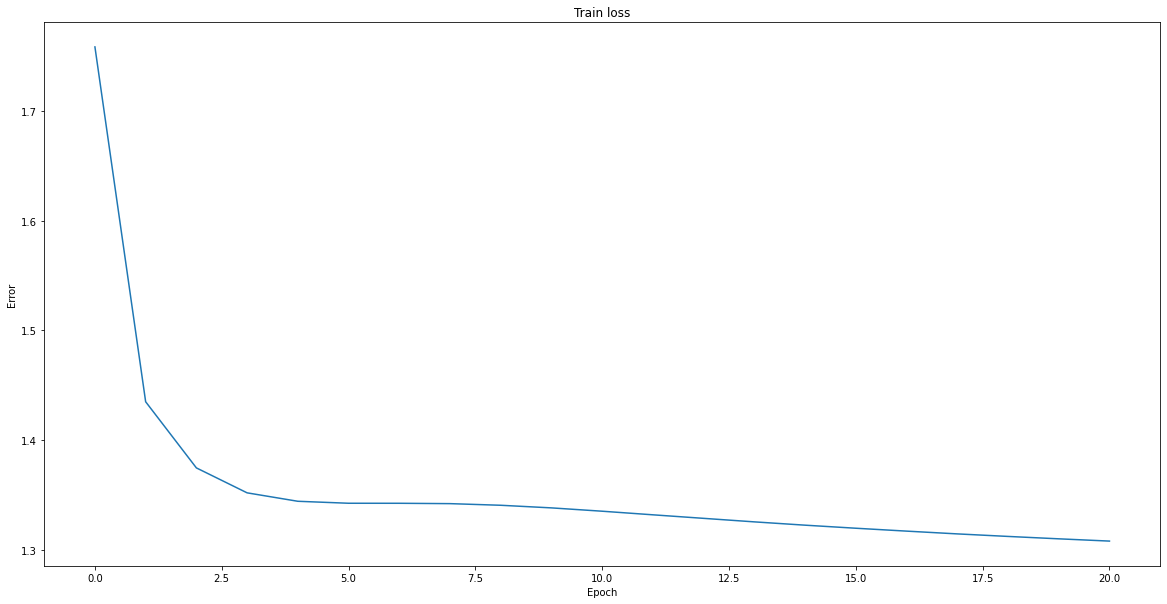

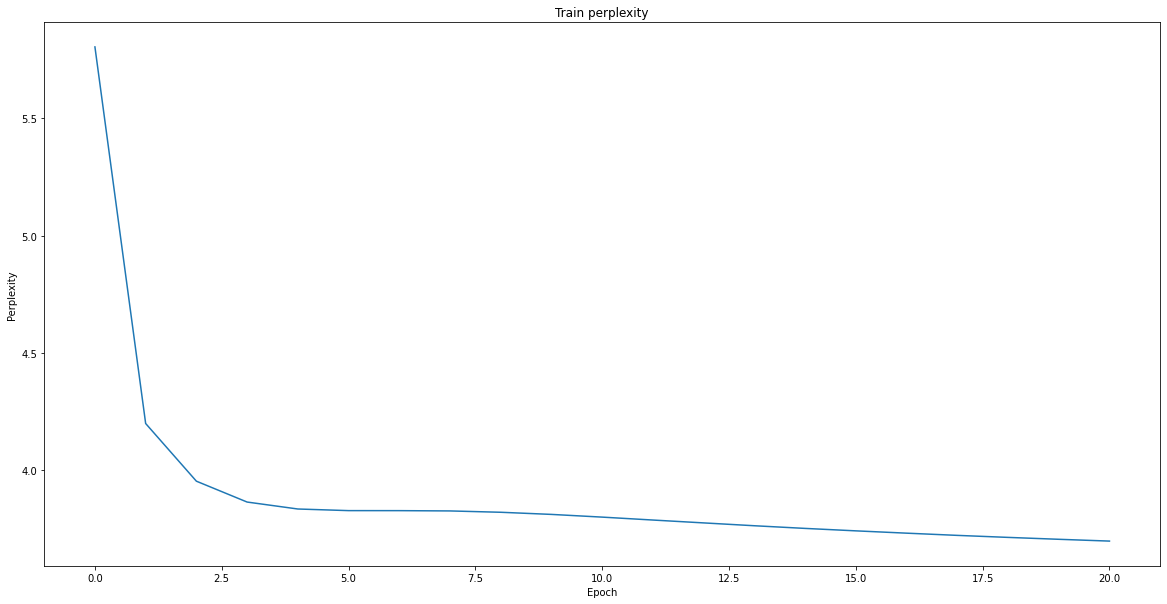

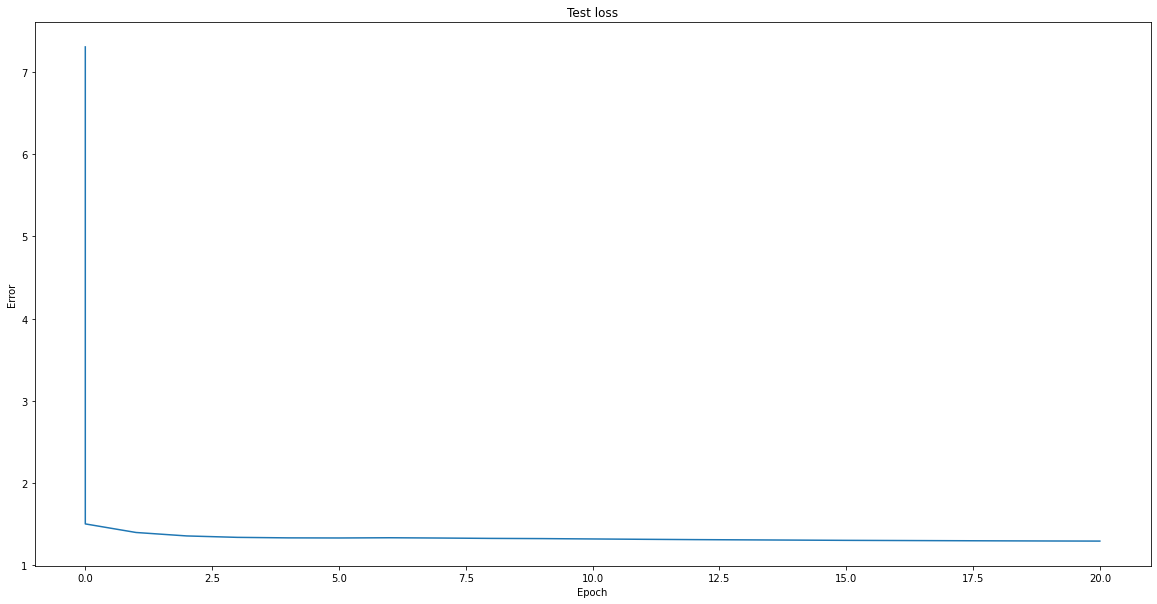

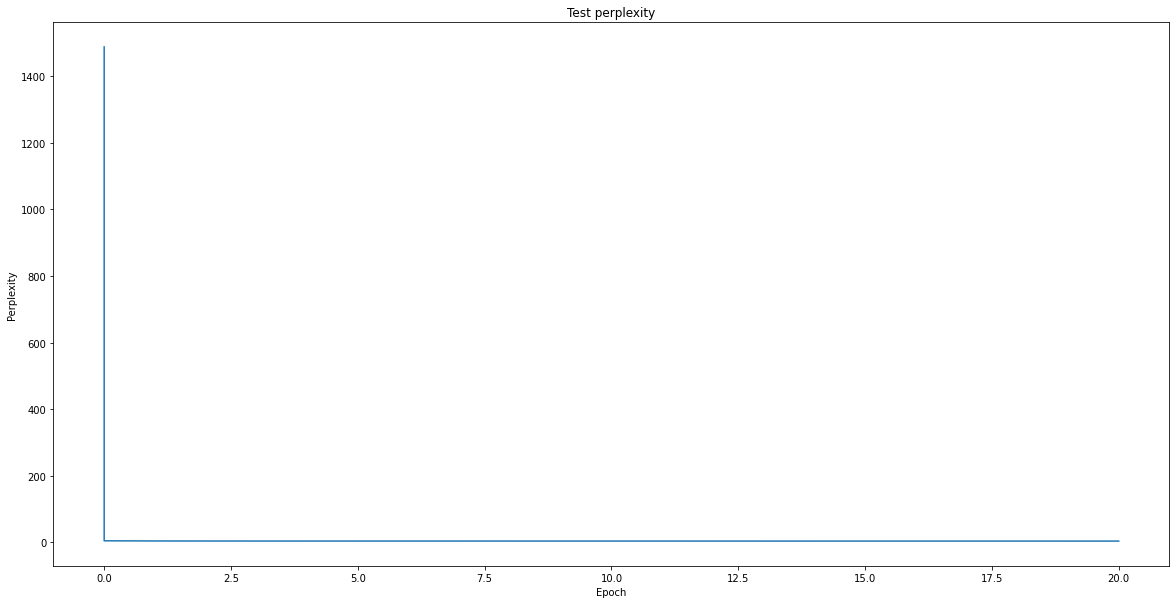

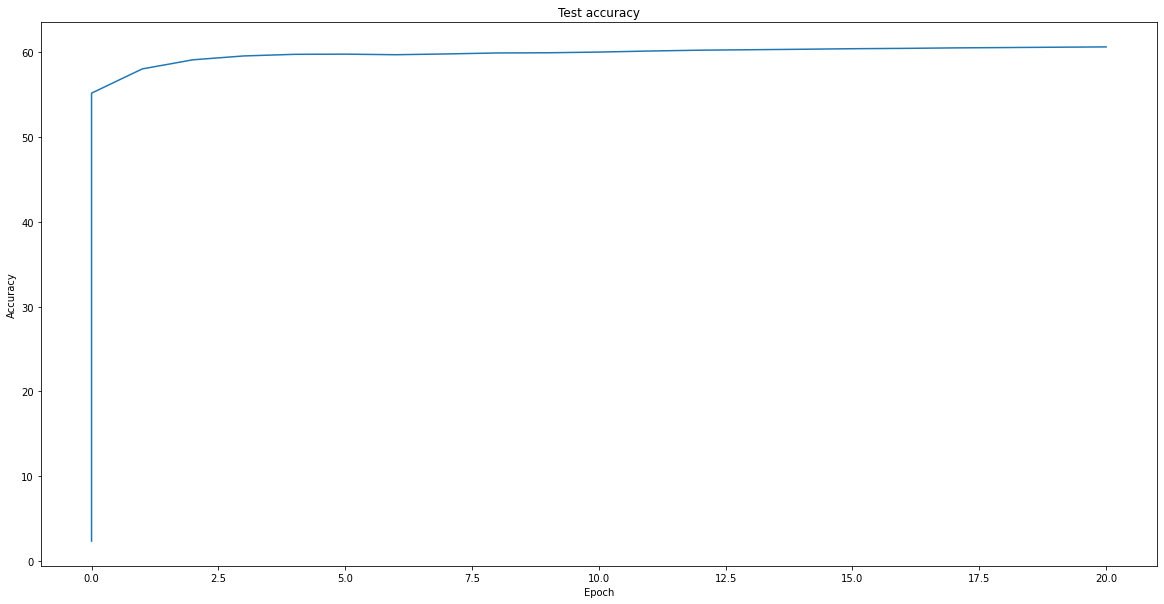

In [16]:
def main():
    SEQUENCE_LENGTH = 50
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log_gru_v2_hp.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNetV2(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints_gru_v2_hp')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints_gru_hp/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)    
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints_gru_v2_hp/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        pt_util.plot(ep, np.exp(val), 'Train perplexity', 'Epoch', 'Perplexity')

        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        pt_util.plot(ep, np.exp(val), 'Test perplexity', 'Epoch', 'Perplexity')  

        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Accuracy')
        return model, vocab, device

final_model, vocab, device = main()

In [17]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 100

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and the street street and stared at the stairs and staring at the stairs and staring at the stairs and star
generated with sample	 Harry Potter and the entmus changed inches were far that Mr.R Crong and he had eats Water. "She''ll unay bad a cernent. 
generated with sample	 Harry Potter and the second." The two week and looked line Hagrid raised him slightened. "Do you stay," said Lavin. Harr
generated with sample	 Harry Potter and the smited floor. "Cale you are that we sorry, Harry -- and this acid Uon." "Syed," said Harry grignly 
generated with sample	 Harry Potter and the of her arress the cacked, gnimper he had arrixed nearly and a rules uncle lost A laugh sneer. "Ohap
generated with sample	 Harry Potter and they set off to sage the floor closer who was standing around the bogy for to year a chair that appeare
generated with sample	 Harry Potter and the distant; People she had sprinted. Tow," she might be with a smiling golden, which severed phari

## 8.3 LSTM Network

In [18]:
class LSTMNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(LSTMNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.lstm = nn.LSTM(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None, cell_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        
        x = self.encoder(x)
        lstm_input = None
        if hidden_state is not None and cell_state is not None:
            lstm_input = (hidden_state, cell_state)
        x, (hidden_state, cell_state) = self.lstm(x, lstm_input)
        x = self.decoder(x)
        return x, hidden_state, cell_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, cell_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state, cell_state = self.forward(x, hidden_state, cell_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state, cell_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

In [19]:
def lstm_max_sampling_strategy(sequence_length, model, output, hidden, cell, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        max_idx = output.argmax()
        outputs.append(max_idx)
        output, hidden, cell = model.inference(max_idx, hidden, cell)
    return outputs
    
def lstm_sample_sampling_strategy(sequence_length, model, output, hidden, cell, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        sample_idx = torch.multinomial(output, 1)
        outputs.append(sample_idx)
        output, hidden, cell = model.inference(sample_idx, hidden, cell)
    return outputs    

def lstm_beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, cell, vocab):
    # beam = [([], output, hidden, cell, 0)]
    beam = []
    temp = []
    sort = torch.argsort(torch.log(output))[0][-beam_width:]
    for i in sort:
        beam.append(([i], output, hidden, cell, torch.log(output[0][i]))) 
    for ii in range(sequence_length):
        new_beam = []
        for b in beam:
          idx = torch.LongTensor([b[0][len(b[0])-1]])
          output, hidden, cell = model.inference(idx.cuda(), b[2], b[3], TEMPERATURE) # run through model
          samples = torch.multinomial(output, beam_width)  # computing pr(x | beam)
          for s in samples[0]: 
            # step: new_beam = beam
            # step: new_beam += s
            new_idx = b[0] + [s]
            score = b[4] + torch.log(output[0][s])
            new_beam.append((new_idx, output, hidden, cell, score))
        new_beam.sort(key=lambda b : b[4], reverse=True) # sorting new beams
        beam = new_beam[:beam_width]

    return beam[0][0]

def lstm_generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        cell = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden, cell = model.inference(data, hidden, cell)
        
        if sampling_strategy == 'max':
            outputs = lstm_max_sampling_strategy(sequence_length, model, output, hidden, cell, vocab)

        elif sampling_strategy == 'sample':
            outputs = lstm_sample_sampling_strategy(sequence_length, model, output, hidden, cell, vocab)

        elif sampling_strategy == 'beam':
            outputs = lstm_beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, cell, vocab)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

In [20]:
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def repackage_cell(c):
    """Wraps cell states in new Tensors, to detach them from their history."""
    if isinstance(c, torch.Tensor):
        return c.detach()
    else:
        return tuple(repackage_cell(c) for v in c)

def lstm_train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    cell = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        if cell is not None:
            cell = repackage_cell(hidden)
        optimizer.zero_grad()
        output, hidden, cell = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def lstm_test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        cell = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden, cell = model(data, hidden, cell)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2
Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	g-..]UfiB9v--i0nkHD}.Jn]vvai~yif&ffZD9v.snn1-QDDme


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	gDDODDi)gJa0znfkkLD-H.jnnfkkLDVD]^3`gDDOm-m]5i5ygf


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	wUdHJef&vfiVffHne99.DnDiJnV]]^3n].vQHJZ]}EBvHJ8k.f


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	vv2g^'Js.nf].fifD]^3nB0tLnVD]^3n].D!.Jn]}EBvHJ8k.f


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	9s.Bisi-iJn04zzZBisik6if&vfRB00ksf\{if]ffJ]]]nV09v


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	.vai~y

  1%|          | 2/390 [00:00<00:58,  6.62it/s]

Train Epoch: 0 [0/99840 (0%)]	Loss: 8.747106


  3%|▎         | 12/390 [00:01<00:41,  9.11it/s]

Train Epoch: 0 [2560/99840 (3%)]	Loss: 3.260364


  6%|▌         | 22/390 [00:02<00:40,  9.20it/s]

Train Epoch: 0 [5120/99840 (5%)]	Loss: 2.443960


  8%|▊         | 32/390 [00:03<00:40,  8.92it/s]

Train Epoch: 0 [7680/99840 (8%)]	Loss: 2.130367


 11%|█         | 42/390 [00:04<00:38,  9.08it/s]

Train Epoch: 0 [10240/99840 (10%)]	Loss: 2.036876


 13%|█▎        | 52/390 [00:05<00:38,  8.88it/s]

Train Epoch: 0 [12800/99840 (13%)]	Loss: 1.967737


 16%|█▌        | 62/390 [00:06<00:36,  8.90it/s]

Train Epoch: 0 [15360/99840 (15%)]	Loss: 1.962908


 18%|█▊        | 72/390 [00:08<00:35,  9.03it/s]

Train Epoch: 0 [17920/99840 (18%)]	Loss: 1.902905


 21%|██        | 82/390 [00:09<00:34,  9.01it/s]

Train Epoch: 0 [20480/99840 (21%)]	Loss: 1.871582


 24%|██▎       | 92/390 [00:10<00:33,  9.02it/s]

Train Epoch: 0 [23040/99840 (23%)]	Loss: 1.857346


 26%|██▌       | 102/390 [00:11<00:32,  8.97it/s]

Train Epoch: 0 [25600/99840 (26%)]	Loss: 1.798068


 29%|██▊       | 112/390 [00:12<00:31,  8.81it/s]

Train Epoch: 0 [28160/99840 (28%)]	Loss: 1.813898


 31%|███▏      | 122/390 [00:13<00:29,  8.97it/s]

Train Epoch: 0 [30720/99840 (31%)]	Loss: 1.792994


 34%|███▍      | 132/390 [00:14<00:28,  8.99it/s]

Train Epoch: 0 [33280/99840 (33%)]	Loss: 1.727233


 36%|███▋      | 142/390 [00:15<00:27,  9.03it/s]

Train Epoch: 0 [35840/99840 (36%)]	Loss: 1.756099


 39%|███▉      | 152/390 [00:16<00:26,  9.02it/s]

Train Epoch: 0 [38400/99840 (38%)]	Loss: 1.734944


 42%|████▏     | 162/390 [00:18<00:25,  9.10it/s]

Train Epoch: 0 [40960/99840 (41%)]	Loss: 1.699450


 44%|████▍     | 172/390 [00:19<00:24,  8.73it/s]

Train Epoch: 0 [43520/99840 (44%)]	Loss: 1.708469


 47%|████▋     | 182/390 [00:20<00:22,  9.05it/s]

Train Epoch: 0 [46080/99840 (46%)]	Loss: 1.690633


 49%|████▉     | 192/390 [00:21<00:21,  9.00it/s]

Train Epoch: 0 [48640/99840 (49%)]	Loss: 1.721538


 52%|█████▏    | 202/390 [00:22<00:20,  9.00it/s]

Train Epoch: 0 [51200/99840 (51%)]	Loss: 1.690401


 54%|█████▍    | 212/390 [00:23<00:19,  9.14it/s]

Train Epoch: 0 [53760/99840 (54%)]	Loss: 1.682068


 57%|█████▋    | 222/390 [00:24<00:18,  9.13it/s]

Train Epoch: 0 [56320/99840 (56%)]	Loss: 1.658132


 59%|█████▉    | 232/390 [00:25<00:17,  9.22it/s]

Train Epoch: 0 [58880/99840 (59%)]	Loss: 1.635356


 62%|██████▏   | 242/390 [00:26<00:16,  8.83it/s]

Train Epoch: 0 [61440/99840 (62%)]	Loss: 1.648438


 65%|██████▍   | 252/390 [00:28<00:15,  9.06it/s]

Train Epoch: 0 [64000/99840 (64%)]	Loss: 1.637136


 67%|██████▋   | 262/390 [00:29<00:14,  8.87it/s]

Train Epoch: 0 [66560/99840 (67%)]	Loss: 1.623490


 70%|██████▉   | 272/390 [00:30<00:13,  8.89it/s]

Train Epoch: 0 [69120/99840 (69%)]	Loss: 1.603957


 72%|███████▏  | 282/390 [00:31<00:11,  9.01it/s]

Train Epoch: 0 [71680/99840 (72%)]	Loss: 1.627089


 75%|███████▍  | 292/390 [00:32<00:10,  9.11it/s]

Train Epoch: 0 [74240/99840 (74%)]	Loss: 1.602798


 77%|███████▋  | 302/390 [00:33<00:09,  9.06it/s]

Train Epoch: 0 [76800/99840 (77%)]	Loss: 1.598734


 80%|████████  | 312/390 [00:34<00:08,  8.81it/s]

Train Epoch: 0 [79360/99840 (79%)]	Loss: 1.586793


 83%|████████▎ | 322/390 [00:35<00:07,  9.05it/s]

Train Epoch: 0 [81920/99840 (82%)]	Loss: 1.599648


 85%|████████▌ | 332/390 [00:36<00:06,  8.93it/s]

Train Epoch: 0 [84480/99840 (85%)]	Loss: 1.628977


 88%|████████▊ | 342/390 [00:38<00:05,  8.83it/s]

Train Epoch: 0 [87040/99840 (87%)]	Loss: 1.560899


 90%|█████████ | 352/390 [00:39<00:04,  8.99it/s]

Train Epoch: 0 [89600/99840 (90%)]	Loss: 1.588986


 93%|█████████▎| 362/390 [00:40<00:03,  9.02it/s]

Train Epoch: 0 [92160/99840 (92%)]	Loss: 1.566263


 95%|█████████▌| 372/390 [00:41<00:01,  9.31it/s]

Train Epoch: 0 [94720/99840 (95%)]	Loss: 1.573573


 98%|█████████▊| 382/390 [00:42<00:00,  8.77it/s]

Train Epoch: 0 [97280/99840 (97%)]	Loss: 1.555137


100%|██████████| 390/390 [00:43<00:00,  9.01it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	tooat todnttnd soastd ttain,t toe fone aotask. "H 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	H....ou wodnnarl, tory warl, tarry  " .. "Hon't wo


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	sses toe fnt r oone  tnd sarry waap d humbledore w


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck opderetoe faarei aoi, warry waaden tumbledore w


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	e .ng htd soenpeng hn the faddle of the fork aasht


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain,t tim  "or ansament  warry woough  

  1%|          | 2/390 [00:00<01:04,  5.99it/s]

Train Epoch: 1 [0/99840 (0%)]	Loss: 1.565735


  3%|▎         | 12/390 [00:01<00:41,  9.18it/s]

Train Epoch: 1 [2560/99840 (3%)]	Loss: 1.555457


  6%|▌         | 22/390 [00:02<00:41,  8.77it/s]

Train Epoch: 1 [5120/99840 (5%)]	Loss: 1.547214


  8%|▊         | 32/390 [00:03<00:40,  8.82it/s]

Train Epoch: 1 [7680/99840 (8%)]	Loss: 1.526846


 11%|█         | 42/390 [00:04<00:38,  8.95it/s]

Train Epoch: 1 [10240/99840 (10%)]	Loss: 1.538589


 13%|█▎        | 52/390 [00:05<00:38,  8.86it/s]

Train Epoch: 1 [12800/99840 (13%)]	Loss: 1.540415


 16%|█▌        | 62/390 [00:07<00:36,  8.91it/s]

Train Epoch: 1 [15360/99840 (15%)]	Loss: 1.571161


 18%|█▊        | 72/390 [00:08<00:36,  8.82it/s]

Train Epoch: 1 [17920/99840 (18%)]	Loss: 1.536145


 21%|██        | 82/390 [00:09<00:34,  8.96it/s]

Train Epoch: 1 [20480/99840 (21%)]	Loss: 1.538304


 24%|██▎       | 92/390 [00:10<00:33,  9.00it/s]

Train Epoch: 1 [23040/99840 (23%)]	Loss: 1.548171


 26%|██▌       | 102/390 [00:11<00:32,  8.79it/s]

Train Epoch: 1 [25600/99840 (26%)]	Loss: 1.497100


 29%|██▊       | 112/390 [00:12<00:30,  8.99it/s]

Train Epoch: 1 [28160/99840 (28%)]	Loss: 1.546214


 31%|███▏      | 122/390 [00:13<00:30,  8.83it/s]

Train Epoch: 1 [30720/99840 (31%)]	Loss: 1.515952


 34%|███▍      | 132/390 [00:14<00:28,  9.20it/s]

Train Epoch: 1 [33280/99840 (33%)]	Loss: 1.480291


 36%|███▋      | 142/390 [00:15<00:27,  8.89it/s]

Train Epoch: 1 [35840/99840 (36%)]	Loss: 1.517169


 39%|███▉      | 152/390 [00:16<00:26,  9.11it/s]

Train Epoch: 1 [38400/99840 (38%)]	Loss: 1.513471


 42%|████▏     | 162/390 [00:18<00:25,  9.07it/s]

Train Epoch: 1 [40960/99840 (41%)]	Loss: 1.477475


 44%|████▍     | 172/390 [00:19<00:23,  9.17it/s]

Train Epoch: 1 [43520/99840 (44%)]	Loss: 1.523266


 47%|████▋     | 182/390 [00:20<00:22,  9.19it/s]

Train Epoch: 1 [46080/99840 (46%)]	Loss: 1.498143


 49%|████▉     | 192/390 [00:21<00:22,  8.90it/s]

Train Epoch: 1 [48640/99840 (49%)]	Loss: 1.529141


 52%|█████▏    | 202/390 [00:22<00:20,  9.18it/s]

Train Epoch: 1 [51200/99840 (51%)]	Loss: 1.505608


 54%|█████▍    | 212/390 [00:23<00:20,  8.83it/s]

Train Epoch: 1 [53760/99840 (54%)]	Loss: 1.498256


 57%|█████▋    | 222/390 [00:24<00:18,  9.17it/s]

Train Epoch: 1 [56320/99840 (56%)]	Loss: 1.494248


 59%|█████▉    | 232/390 [00:25<00:17,  9.16it/s]

Train Epoch: 1 [58880/99840 (59%)]	Loss: 1.471255


 62%|██████▏   | 242/390 [00:26<00:16,  8.80it/s]

Train Epoch: 1 [61440/99840 (62%)]	Loss: 1.502127


 65%|██████▍   | 252/390 [00:28<00:15,  9.17it/s]

Train Epoch: 1 [64000/99840 (64%)]	Loss: 1.489707


 67%|██████▋   | 262/390 [00:29<00:14,  8.98it/s]

Train Epoch: 1 [66560/99840 (67%)]	Loss: 1.480510


 70%|██████▉   | 272/390 [00:30<00:12,  9.19it/s]

Train Epoch: 1 [69120/99840 (69%)]	Loss: 1.465042


 72%|███████▏  | 282/390 [00:31<00:11,  9.10it/s]

Train Epoch: 1 [71680/99840 (72%)]	Loss: 1.489456


 75%|███████▍  | 292/390 [00:32<00:10,  9.11it/s]

Train Epoch: 1 [74240/99840 (74%)]	Loss: 1.472773


 77%|███████▋  | 302/390 [00:33<00:09,  9.03it/s]

Train Epoch: 1 [76800/99840 (77%)]	Loss: 1.465327


 80%|████████  | 312/390 [00:34<00:08,  8.86it/s]

Train Epoch: 1 [79360/99840 (79%)]	Loss: 1.465736


 83%|████████▎ | 322/390 [00:35<00:07,  9.08it/s]

Train Epoch: 1 [81920/99840 (82%)]	Loss: 1.468201


 85%|████████▌ | 332/390 [00:36<00:06,  8.99it/s]

Train Epoch: 1 [84480/99840 (85%)]	Loss: 1.507919


 88%|████████▊ | 342/390 [00:38<00:05,  9.08it/s]

Train Epoch: 1 [87040/99840 (87%)]	Loss: 1.433083


 90%|█████████ | 352/390 [00:39<00:04,  8.96it/s]

Train Epoch: 1 [89600/99840 (90%)]	Loss: 1.476220


 93%|█████████▎| 362/390 [00:40<00:03,  8.77it/s]

Train Epoch: 1 [92160/99840 (92%)]	Loss: 1.463956


 95%|█████████▌| 372/390 [00:41<00:02,  8.94it/s]

Train Epoch: 1 [94720/99840 (95%)]	Loss: 1.466821


 98%|█████████▊| 382/390 [00:42<00:00,  8.64it/s]

Train Epoch: 1 [97280/99840 (97%)]	Loss: 1.464299


100%|██████████| 390/390 [00:43<00:00,  9.00it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	tooat tognttnd soattd ttain,t the fone aaaisk  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	H . Iou wodnni l, tery sorl  tarry  " .  "Won't wo


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	wses toe fnt r oone  tnd Harry waap d tumbledore w


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the farrty aoi, aarry waaded tumbledore w


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	er.ng htd soenpeng hn the fogdle of the fork aash 


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain,t tis  "or a soment  warry woough  

  1%|          | 2/390 [00:00<01:04,  6.02it/s]

Train Epoch: 2 [0/99840 (0%)]	Loss: 1.464365


  3%|▎         | 12/390 [00:01<00:42,  8.93it/s]

Train Epoch: 2 [2560/99840 (3%)]	Loss: 1.457556


  6%|▌         | 22/390 [00:02<00:41,  8.86it/s]

Train Epoch: 2 [5120/99840 (5%)]	Loss: 1.454562


  8%|▊         | 32/390 [00:03<00:39,  9.09it/s]

Train Epoch: 2 [7680/99840 (8%)]	Loss: 1.442933


 11%|█         | 42/390 [00:04<00:38,  9.15it/s]

Train Epoch: 2 [10240/99840 (10%)]	Loss: 1.448956


 13%|█▎        | 52/390 [00:05<00:37,  9.01it/s]

Train Epoch: 2 [12800/99840 (13%)]	Loss: 1.447993


 16%|█▌        | 62/390 [00:06<00:35,  9.24it/s]

Train Epoch: 2 [15360/99840 (15%)]	Loss: 1.472460


 18%|█▊        | 72/390 [00:08<00:35,  8.89it/s]

Train Epoch: 2 [17920/99840 (18%)]	Loss: 1.458355


 21%|██        | 82/390 [00:09<00:33,  9.11it/s]

Train Epoch: 2 [20480/99840 (21%)]	Loss: 1.451682


 24%|██▎       | 92/390 [00:10<00:33,  8.86it/s]

Train Epoch: 2 [23040/99840 (23%)]	Loss: 1.475747


 26%|██▌       | 102/390 [00:11<00:32,  8.92it/s]

Train Epoch: 2 [25600/99840 (26%)]	Loss: 1.416579


 29%|██▊       | 112/390 [00:12<00:30,  9.00it/s]

Train Epoch: 2 [28160/99840 (28%)]	Loss: 1.469155


 31%|███▏      | 122/390 [00:13<00:30,  8.85it/s]

Train Epoch: 2 [30720/99840 (31%)]	Loss: 1.454014


 34%|███▍      | 132/390 [00:14<00:28,  8.95it/s]

Train Epoch: 2 [33280/99840 (33%)]	Loss: 1.407941


 36%|███▋      | 142/390 [00:15<00:28,  8.62it/s]

Train Epoch: 2 [35840/99840 (36%)]	Loss: 1.453109


 39%|███▉      | 152/390 [00:17<00:26,  8.99it/s]

Train Epoch: 2 [38400/99840 (38%)]	Loss: 1.436188


 42%|████▏     | 162/390 [00:18<00:25,  8.79it/s]

Train Epoch: 2 [40960/99840 (41%)]	Loss: 1.407799


 44%|████▍     | 172/390 [00:19<00:23,  9.09it/s]

Train Epoch: 2 [43520/99840 (44%)]	Loss: 1.457631


 47%|████▋     | 182/390 [00:20<00:23,  8.98it/s]

Train Epoch: 2 [46080/99840 (46%)]	Loss: 1.431899


 49%|████▉     | 192/390 [00:21<00:22,  8.96it/s]

Train Epoch: 2 [48640/99840 (49%)]	Loss: 1.469446


 52%|█████▏    | 202/390 [00:22<00:20,  9.19it/s]

Train Epoch: 2 [51200/99840 (51%)]	Loss: 1.449366


 54%|█████▍    | 212/390 [00:23<00:19,  8.91it/s]

Train Epoch: 2 [53760/99840 (54%)]	Loss: 1.438391


 57%|█████▋    | 222/390 [00:24<00:18,  9.05it/s]

Train Epoch: 2 [56320/99840 (56%)]	Loss: 1.435624


 59%|█████▉    | 232/390 [00:25<00:17,  8.99it/s]

Train Epoch: 2 [58880/99840 (59%)]	Loss: 1.404233


 62%|██████▏   | 242/390 [00:26<00:16,  9.15it/s]

Train Epoch: 2 [61440/99840 (62%)]	Loss: 1.447885


 65%|██████▍   | 252/390 [00:28<00:15,  8.90it/s]

Train Epoch: 2 [64000/99840 (64%)]	Loss: 1.440087


 67%|██████▋   | 262/390 [00:29<00:14,  8.89it/s]

Train Epoch: 2 [66560/99840 (67%)]	Loss: 1.428339


 70%|██████▉   | 272/390 [00:30<00:12,  9.13it/s]

Train Epoch: 2 [69120/99840 (69%)]	Loss: 1.420630


 72%|███████▏  | 282/390 [00:31<00:12,  8.87it/s]

Train Epoch: 2 [71680/99840 (72%)]	Loss: 1.432523


 75%|███████▍  | 292/390 [00:32<00:11,  8.84it/s]

Train Epoch: 2 [74240/99840 (74%)]	Loss: 1.418335


 77%|███████▋  | 302/390 [00:33<00:09,  8.92it/s]

Train Epoch: 2 [76800/99840 (77%)]	Loss: 1.420475


 80%|████████  | 312/390 [00:34<00:08,  9.06it/s]

Train Epoch: 2 [79360/99840 (79%)]	Loss: 1.422992


 83%|████████▎ | 322/390 [00:35<00:07,  9.11it/s]

Train Epoch: 2 [81920/99840 (82%)]	Loss: 1.419792


 85%|████████▌ | 332/390 [00:36<00:06,  8.94it/s]

Train Epoch: 2 [84480/99840 (85%)]	Loss: 1.454921


 88%|████████▊ | 342/390 [00:38<00:05,  9.08it/s]

Train Epoch: 2 [87040/99840 (87%)]	Loss: 1.384314


 90%|█████████ | 352/390 [00:39<00:04,  8.79it/s]

Train Epoch: 2 [89600/99840 (90%)]	Loss: 1.429390


 93%|█████████▎| 362/390 [00:40<00:03,  8.94it/s]

Train Epoch: 2 [92160/99840 (92%)]	Loss: 1.419410


 95%|█████████▌| 372/390 [00:41<00:01,  9.03it/s]

Train Epoch: 2 [94720/99840 (95%)]	Loss: 1.424709


 98%|█████████▊| 382/390 [00:42<00:00,  9.09it/s]

Train Epoch: 2 [97280/99840 (97%)]	Loss: 1.429409


100%|██████████| 390/390 [00:43<00:00,  9.00it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	troat tolnttnd soadtd ttain.t the fone aaoisk  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	H . Iou wodnni l, Iery sorl, tarry "" .  "Ion't yh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed toe ftt r oone  tnd Harry saad d tumbledore s


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the warnti aoi, tarry saaded tumbledore s


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	ering atd soanpeng hn the candle of the fork aash 


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tis  "or a soment  tarry soought 

  1%|          | 2/390 [00:00<01:03,  6.12it/s]

Train Epoch: 3 [0/99840 (0%)]	Loss: 1.419533


  3%|▎         | 12/390 [00:01<00:41,  9.02it/s]

Train Epoch: 3 [2560/99840 (3%)]	Loss: 1.411848


  6%|▌         | 22/390 [00:02<00:40,  9.05it/s]

Train Epoch: 3 [5120/99840 (5%)]	Loss: 1.416545


  8%|▊         | 32/390 [00:03<00:39,  9.02it/s]

Train Epoch: 3 [7680/99840 (8%)]	Loss: 1.404590


 11%|█         | 42/390 [00:04<00:37,  9.28it/s]

Train Epoch: 3 [10240/99840 (10%)]	Loss: 1.416972


 13%|█▎        | 52/390 [00:05<00:37,  9.01it/s]

Train Epoch: 3 [12800/99840 (13%)]	Loss: 1.406664


 16%|█▌        | 62/390 [00:06<00:35,  9.19it/s]

Train Epoch: 3 [15360/99840 (15%)]	Loss: 1.434135


 18%|█▊        | 72/390 [00:08<00:34,  9.27it/s]

Train Epoch: 3 [17920/99840 (18%)]	Loss: 1.426468


 21%|██        | 82/390 [00:09<00:33,  9.24it/s]

Train Epoch: 3 [20480/99840 (21%)]	Loss: 1.417264


 24%|██▎       | 92/390 [00:10<00:32,  9.07it/s]

Train Epoch: 3 [23040/99840 (23%)]	Loss: 1.440155


 26%|██▌       | 102/390 [00:11<00:32,  8.95it/s]

Train Epoch: 3 [25600/99840 (26%)]	Loss: 1.381619


 29%|██▊       | 112/390 [00:12<00:30,  9.10it/s]

Train Epoch: 3 [28160/99840 (28%)]	Loss: 1.433988


 31%|███▏      | 122/390 [00:13<00:29,  8.99it/s]

Train Epoch: 3 [30720/99840 (31%)]	Loss: 1.423059


 34%|███▍      | 132/390 [00:14<00:27,  9.28it/s]

Train Epoch: 3 [33280/99840 (33%)]	Loss: 1.373822


 36%|███▋      | 142/390 [00:15<00:27,  9.06it/s]

Train Epoch: 3 [35840/99840 (36%)]	Loss: 1.421970


 39%|███▉      | 152/390 [00:16<00:26,  9.13it/s]

Train Epoch: 3 [38400/99840 (38%)]	Loss: 1.405604


 42%|████▏     | 162/390 [00:17<00:25,  8.94it/s]

Train Epoch: 3 [40960/99840 (41%)]	Loss: 1.378147


 44%|████▍     | 172/390 [00:19<00:24,  9.08it/s]

Train Epoch: 3 [43520/99840 (44%)]	Loss: 1.427473


 47%|████▋     | 182/390 [00:20<00:22,  9.14it/s]

Train Epoch: 3 [46080/99840 (46%)]	Loss: 1.404536


 49%|████▉     | 192/390 [00:21<00:21,  9.03it/s]

Train Epoch: 3 [48640/99840 (49%)]	Loss: 1.438759


 52%|█████▏    | 202/390 [00:22<00:20,  9.17it/s]

Train Epoch: 3 [51200/99840 (51%)]	Loss: 1.419840


 54%|█████▍    | 212/390 [00:23<00:19,  9.05it/s]

Train Epoch: 3 [53760/99840 (54%)]	Loss: 1.409316


 57%|█████▋    | 222/390 [00:24<00:18,  9.14it/s]

Train Epoch: 3 [56320/99840 (56%)]	Loss: 1.407118


 59%|█████▉    | 232/390 [00:25<00:17,  9.15it/s]

Train Epoch: 3 [58880/99840 (59%)]	Loss: 1.380449


 62%|██████▏   | 242/390 [00:26<00:16,  8.93it/s]

Train Epoch: 3 [61440/99840 (62%)]	Loss: 1.418867


 65%|██████▍   | 252/390 [00:27<00:14,  9.27it/s]

Train Epoch: 3 [64000/99840 (64%)]	Loss: 1.415124


 67%|██████▋   | 262/390 [00:28<00:14,  8.92it/s]

Train Epoch: 3 [66560/99840 (67%)]	Loss: 1.403901


 70%|██████▉   | 272/390 [00:29<00:12,  9.15it/s]

Train Epoch: 3 [69120/99840 (69%)]	Loss: 1.396835


 72%|███████▏  | 282/390 [00:31<00:11,  9.13it/s]

Train Epoch: 3 [71680/99840 (72%)]	Loss: 1.407526


 75%|███████▍  | 292/390 [00:32<00:10,  9.17it/s]

Train Epoch: 3 [74240/99840 (74%)]	Loss: 1.391419


 77%|███████▋  | 302/390 [00:33<00:09,  8.86it/s]

Train Epoch: 3 [76800/99840 (77%)]	Loss: 1.396505


 80%|████████  | 312/390 [00:34<00:08,  9.08it/s]

Train Epoch: 3 [79360/99840 (79%)]	Loss: 1.400113


 83%|████████▎ | 322/390 [00:35<00:07,  8.93it/s]

Train Epoch: 3 [81920/99840 (82%)]	Loss: 1.396660


 85%|████████▌ | 332/390 [00:36<00:06,  9.06it/s]

Train Epoch: 3 [84480/99840 (85%)]	Loss: 1.436901


 88%|████████▊ | 342/390 [00:37<00:05,  9.16it/s]

Train Epoch: 3 [87040/99840 (87%)]	Loss: 1.363302


 90%|█████████ | 352/390 [00:38<00:04,  9.02it/s]

Train Epoch: 3 [89600/99840 (90%)]	Loss: 1.411379


 93%|█████████▎| 362/390 [00:39<00:03,  9.24it/s]

Train Epoch: 3 [92160/99840 (92%)]	Loss: 1.395623


 95%|█████████▌| 372/390 [00:40<00:01,  9.13it/s]

Train Epoch: 3 [94720/99840 (95%)]	Loss: 1.409235


 98%|█████████▊| 382/390 [00:42<00:00,  9.17it/s]

Train Epoch: 3 [97280/99840 (97%)]	Loss: 1.409021


100%|██████████| 390/390 [00:42<00:00,  9.10it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	tooat solnttnd soaded tnain,t the fose aaoask  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . Iou wodnna l  Iery soll  Iarry "H .  "Ion't yh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed the wnt r oone  and Harry saad d humbledore s


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the ctonti aoi, tarry saaded tumbledore s


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	ering htd soanpeng hntthe condle of the cork aagh 


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain,t tem  "or ansoment  tarry soought 

  1%|          | 2/390 [00:00<01:09,  5.59it/s]

Train Epoch: 4 [0/99840 (0%)]	Loss: 1.402487


  3%|▎         | 12/390 [00:01<00:42,  8.87it/s]

Train Epoch: 4 [2560/99840 (3%)]	Loss: 1.395243


  6%|▌         | 22/390 [00:02<00:40,  9.03it/s]

Train Epoch: 4 [5120/99840 (5%)]	Loss: 1.402649


  8%|▊         | 32/390 [00:03<00:39,  9.10it/s]

Train Epoch: 4 [7680/99840 (8%)]	Loss: 1.391266


 11%|█         | 42/390 [00:04<00:39,  8.87it/s]

Train Epoch: 4 [10240/99840 (10%)]	Loss: 1.403030


 13%|█▎        | 52/390 [00:05<00:37,  8.97it/s]

Train Epoch: 4 [12800/99840 (13%)]	Loss: 1.389333


 16%|█▌        | 62/390 [00:07<00:36,  9.06it/s]

Train Epoch: 4 [15360/99840 (15%)]	Loss: 1.417511


 18%|█▊        | 72/390 [00:08<00:35,  8.92it/s]

Train Epoch: 4 [17920/99840 (18%)]	Loss: 1.414912


 21%|██        | 82/390 [00:09<00:33,  9.33it/s]

Train Epoch: 4 [20480/99840 (21%)]	Loss: 1.401711


 24%|██▎       | 92/390 [00:10<00:33,  8.99it/s]

Train Epoch: 4 [23040/99840 (23%)]	Loss: 1.429775


 26%|██▌       | 102/390 [00:11<00:32,  9.00it/s]

Train Epoch: 4 [25600/99840 (26%)]	Loss: 1.368447


 29%|██▊       | 112/390 [00:12<00:30,  9.01it/s]

Train Epoch: 4 [28160/99840 (28%)]	Loss: 1.421876


 31%|███▏      | 122/390 [00:13<00:30,  8.83it/s]

Train Epoch: 4 [30720/99840 (31%)]	Loss: 1.413503


 34%|███▍      | 132/390 [00:14<00:28,  9.13it/s]

Train Epoch: 4 [33280/99840 (33%)]	Loss: 1.361029


 36%|███▋      | 142/390 [00:15<00:28,  8.84it/s]

Train Epoch: 4 [35840/99840 (36%)]	Loss: 1.409718


 39%|███▉      | 152/390 [00:16<00:26,  9.00it/s]

Train Epoch: 4 [38400/99840 (38%)]	Loss: 1.388140


 42%|████▏     | 162/390 [00:18<00:25,  8.93it/s]

Train Epoch: 4 [40960/99840 (41%)]	Loss: 1.364076


 44%|████▍     | 172/390 [00:19<00:24,  9.06it/s]

Train Epoch: 4 [43520/99840 (44%)]	Loss: 1.417598


 47%|████▋     | 182/390 [00:20<00:23,  8.96it/s]

Train Epoch: 4 [46080/99840 (46%)]	Loss: 1.391058


 49%|████▉     | 192/390 [00:21<00:22,  8.78it/s]

Train Epoch: 4 [48640/99840 (49%)]	Loss: 1.428564


 52%|█████▏    | 202/390 [00:22<00:20,  9.08it/s]

Train Epoch: 4 [51200/99840 (51%)]	Loss: 1.407772


 54%|█████▍    | 212/390 [00:23<00:20,  8.83it/s]

Train Epoch: 4 [53760/99840 (54%)]	Loss: 1.398405


 57%|█████▋    | 222/390 [00:24<00:18,  9.13it/s]

Train Epoch: 4 [56320/99840 (56%)]	Loss: 1.393934


 59%|█████▉    | 232/390 [00:25<00:17,  8.96it/s]

Train Epoch: 4 [58880/99840 (59%)]	Loss: 1.371003


 62%|██████▏   | 242/390 [00:26<00:16,  8.94it/s]

Train Epoch: 4 [61440/99840 (62%)]	Loss: 1.403306


 65%|██████▍   | 252/390 [00:27<00:15,  9.02it/s]

Train Epoch: 4 [64000/99840 (64%)]	Loss: 1.404854


 67%|██████▋   | 262/390 [00:29<00:14,  9.02it/s]

Train Epoch: 4 [66560/99840 (67%)]	Loss: 1.394457


 70%|██████▉   | 272/390 [00:30<00:13,  8.96it/s]

Train Epoch: 4 [69120/99840 (69%)]	Loss: 1.387798


 72%|███████▏  | 282/390 [00:31<00:12,  8.92it/s]

Train Epoch: 4 [71680/99840 (72%)]	Loss: 1.397736


 75%|███████▍  | 292/390 [00:32<00:10,  9.25it/s]

Train Epoch: 4 [74240/99840 (74%)]	Loss: 1.380711


 77%|███████▋  | 302/390 [00:33<00:09,  8.93it/s]

Train Epoch: 4 [76800/99840 (77%)]	Loss: 1.387437


 80%|████████  | 312/390 [00:34<00:08,  8.92it/s]

Train Epoch: 4 [79360/99840 (79%)]	Loss: 1.391552


 83%|████████▎ | 322/390 [00:35<00:07,  8.94it/s]

Train Epoch: 4 [81920/99840 (82%)]	Loss: 1.385112


 85%|████████▌ | 332/390 [00:36<00:06,  8.74it/s]

Train Epoch: 4 [84480/99840 (85%)]	Loss: 1.427363


 88%|████████▊ | 342/390 [00:37<00:05,  9.14it/s]

Train Epoch: 4 [87040/99840 (87%)]	Loss: 1.356202


 90%|█████████ | 352/390 [00:39<00:04,  8.72it/s]

Train Epoch: 4 [89600/99840 (90%)]	Loss: 1.406330


 93%|█████████▎| 362/390 [00:40<00:03,  9.17it/s]

Train Epoch: 4 [92160/99840 (92%)]	Loss: 1.387070


 95%|█████████▌| 372/390 [00:41<00:01,  9.02it/s]

Train Epoch: 4 [94720/99840 (95%)]	Loss: 1.401904


 98%|█████████▊| 382/390 [00:42<00:00,  9.10it/s]

Train Epoch: 4 [97280/99840 (97%)]	Loss: 1.399267


100%|██████████| 390/390 [00:43<00:00,  9.03it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	tooat solnttnd soaded ttain.t the cose aeoasl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	H . Iou wodnna l  Iery sorl, Iarry "" .  "Ion't yh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed the ctt r oone  and Harry saaded humbledore.a


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the ctoiti ati. aarry saaded aumbledore s


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	ering htd soonpeng hntthe condle of the cork aagh 


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tes  "or ansoment  harry soought 

  1%|          | 2/390 [00:00<01:04,  5.99it/s]

Train Epoch: 5 [0/99840 (0%)]	Loss: 1.394864


  3%|▎         | 12/390 [00:01<00:41,  9.03it/s]

Train Epoch: 5 [2560/99840 (3%)]	Loss: 1.390623


  6%|▌         | 22/390 [00:02<00:40,  9.05it/s]

Train Epoch: 5 [5120/99840 (5%)]	Loss: 1.397952


  8%|▊         | 32/390 [00:03<00:40,  8.95it/s]

Train Epoch: 5 [7680/99840 (8%)]	Loss: 1.384872


 11%|█         | 42/390 [00:04<00:38,  9.00it/s]

Train Epoch: 5 [10240/99840 (10%)]	Loss: 1.394942


 13%|█▎        | 52/390 [00:05<00:38,  8.70it/s]

Train Epoch: 5 [12800/99840 (13%)]	Loss: 1.381441


 16%|█▌        | 62/390 [00:06<00:35,  9.13it/s]

Train Epoch: 5 [15360/99840 (15%)]	Loss: 1.408440


 18%|█▊        | 72/390 [00:08<00:35,  8.92it/s]

Train Epoch: 5 [17920/99840 (18%)]	Loss: 1.407846


 21%|██        | 82/390 [00:09<00:34,  8.90it/s]

Train Epoch: 5 [20480/99840 (21%)]	Loss: 1.397109


 24%|██▎       | 92/390 [00:10<00:32,  9.07it/s]

Train Epoch: 5 [23040/99840 (23%)]	Loss: 1.423361


 26%|██▌       | 102/390 [00:11<00:32,  8.90it/s]

Train Epoch: 5 [25600/99840 (26%)]	Loss: 1.361408


 29%|██▊       | 112/390 [00:12<00:31,  8.81it/s]

Train Epoch: 5 [28160/99840 (28%)]	Loss: 1.417613


 31%|███▏      | 122/390 [00:13<00:29,  9.19it/s]

Train Epoch: 5 [30720/99840 (31%)]	Loss: 1.411824


 34%|███▍      | 132/390 [00:14<00:28,  9.01it/s]

Train Epoch: 5 [33280/99840 (33%)]	Loss: 1.357418


 36%|███▋      | 142/390 [00:15<00:28,  8.86it/s]

Train Epoch: 5 [35840/99840 (36%)]	Loss: 1.405124


 39%|███▉      | 152/390 [00:16<00:26,  8.98it/s]

Train Epoch: 5 [38400/99840 (38%)]	Loss: 1.380327


 42%|████▏     | 162/390 [00:18<00:24,  9.30it/s]

Train Epoch: 5 [40960/99840 (41%)]	Loss: 1.356984


 44%|████▍     | 172/390 [00:19<00:24,  8.74it/s]

Train Epoch: 5 [43520/99840 (44%)]	Loss: 1.410507


 47%|████▋     | 182/390 [00:20<00:22,  9.18it/s]

Train Epoch: 5 [46080/99840 (46%)]	Loss: 1.384512


 49%|████▉     | 192/390 [00:21<00:21,  9.02it/s]

Train Epoch: 5 [48640/99840 (49%)]	Loss: 1.421322


 52%|█████▏    | 202/390 [00:22<00:21,  8.85it/s]

Train Epoch: 5 [51200/99840 (51%)]	Loss: 1.398900


 54%|█████▍    | 212/390 [00:23<00:19,  8.98it/s]

Train Epoch: 5 [53760/99840 (54%)]	Loss: 1.391527


 57%|█████▋    | 222/390 [00:24<00:18,  9.25it/s]

Train Epoch: 5 [56320/99840 (56%)]	Loss: 1.391631


 59%|█████▉    | 232/390 [00:25<00:17,  9.21it/s]

Train Epoch: 5 [58880/99840 (59%)]	Loss: 1.368236


 62%|██████▏   | 242/390 [00:26<00:16,  8.91it/s]

Train Epoch: 5 [61440/99840 (62%)]	Loss: 1.396893


 65%|██████▍   | 252/390 [00:28<00:15,  9.16it/s]

Train Epoch: 5 [64000/99840 (64%)]	Loss: 1.399158


 67%|██████▋   | 262/390 [00:29<00:14,  8.71it/s]

Train Epoch: 5 [66560/99840 (67%)]	Loss: 1.394431


 70%|██████▉   | 272/390 [00:30<00:13,  8.75it/s]

Train Epoch: 5 [69120/99840 (69%)]	Loss: 1.386588


 72%|███████▏  | 282/390 [00:31<00:12,  8.97it/s]

Train Epoch: 5 [71680/99840 (72%)]	Loss: 1.397021


 75%|███████▍  | 292/390 [00:32<00:10,  8.98it/s]

Train Epoch: 5 [74240/99840 (74%)]	Loss: 1.377430


 77%|███████▋  | 302/390 [00:33<00:10,  8.79it/s]

Train Epoch: 5 [76800/99840 (77%)]	Loss: 1.384543


 80%|████████  | 312/390 [00:34<00:08,  8.68it/s]

Train Epoch: 5 [79360/99840 (79%)]	Loss: 1.387907


 83%|████████▎ | 322/390 [00:35<00:07,  8.94it/s]

Train Epoch: 5 [81920/99840 (82%)]	Loss: 1.379215


 85%|████████▌ | 332/390 [00:36<00:06,  8.82it/s]

Train Epoch: 5 [84480/99840 (85%)]	Loss: 1.424253


 88%|████████▊ | 342/390 [00:38<00:05,  8.86it/s]

Train Epoch: 5 [87040/99840 (87%)]	Loss: 1.357004


 90%|█████████ | 352/390 [00:39<00:04,  8.82it/s]

Train Epoch: 5 [89600/99840 (90%)]	Loss: 1.405353


 93%|█████████▎| 362/390 [00:40<00:03,  8.95it/s]

Train Epoch: 5 [92160/99840 (92%)]	Loss: 1.385642


 95%|█████████▌| 372/390 [00:41<00:01,  9.11it/s]

Train Epoch: 5 [94720/99840 (95%)]	Loss: 1.398249


 98%|█████████▊| 382/390 [00:42<00:00,  8.73it/s]

Train Epoch: 5 [97280/99840 (97%)]	Loss: 1.399185


100%|██████████| 390/390 [00:43<00:00,  8.98it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	tooat solnttnd soanid ttain.t the cose aeoasl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	H . Iou wodnna l  Iery soll, Iarry,"" .  "Ion't yh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed the ctt r tone  and Harry saad d humbledore.a


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the ctoiti ati. barry saaded tumbledore a


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	ering htd soonpeng hntthe coddle of the cork aagh 


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tes  "or a soment  harry soought 

  1%|          | 2/390 [00:00<01:07,  5.76it/s]

Train Epoch: 6 [0/99840 (0%)]	Loss: 1.395398


  3%|▎         | 12/390 [00:01<00:42,  8.88it/s]

Train Epoch: 6 [2560/99840 (3%)]	Loss: 1.388456


  6%|▌         | 22/390 [00:02<00:40,  9.10it/s]

Train Epoch: 6 [5120/99840 (5%)]	Loss: 1.393572


  8%|▊         | 32/390 [00:03<00:40,  8.84it/s]

Train Epoch: 6 [7680/99840 (8%)]	Loss: 1.377398


 11%|█         | 42/390 [00:04<00:38,  9.02it/s]

Train Epoch: 6 [10240/99840 (10%)]	Loss: 1.390383


 13%|█▎        | 52/390 [00:05<00:37,  8.94it/s]

Train Epoch: 6 [12800/99840 (13%)]	Loss: 1.381010


 16%|█▌        | 62/390 [00:07<00:36,  8.87it/s]

Train Epoch: 6 [15360/99840 (15%)]	Loss: 1.405182


 18%|█▊        | 72/390 [00:08<00:36,  8.83it/s]

Train Epoch: 6 [17920/99840 (18%)]	Loss: 1.402214


 21%|██        | 82/390 [00:09<00:34,  8.92it/s]

Train Epoch: 6 [20480/99840 (21%)]	Loss: 1.393953


 24%|██▎       | 92/390 [00:10<00:33,  8.99it/s]

Train Epoch: 6 [23040/99840 (23%)]	Loss: 1.419009


 26%|██▌       | 102/390 [00:11<00:32,  8.90it/s]

Train Epoch: 6 [25600/99840 (26%)]	Loss: 1.357808


 29%|██▊       | 112/390 [00:12<00:30,  9.07it/s]

Train Epoch: 6 [28160/99840 (28%)]	Loss: 1.418356


 31%|███▏      | 122/390 [00:13<00:30,  8.93it/s]

Train Epoch: 6 [30720/99840 (31%)]	Loss: 1.409958


 34%|███▍      | 132/390 [00:14<00:28,  9.08it/s]

Train Epoch: 6 [33280/99840 (33%)]	Loss: 1.357901


 36%|███▋      | 142/390 [00:16<00:28,  8.84it/s]

Train Epoch: 6 [35840/99840 (36%)]	Loss: 1.404207


 39%|███▉      | 152/390 [00:17<00:26,  9.01it/s]

Train Epoch: 6 [38400/99840 (38%)]	Loss: 1.377735


 42%|████▏     | 162/390 [00:18<00:25,  9.01it/s]

Train Epoch: 6 [40960/99840 (41%)]	Loss: 1.356390


 44%|████▍     | 172/390 [00:19<00:24,  8.73it/s]

Train Epoch: 6 [43520/99840 (44%)]	Loss: 1.406673


 47%|████▋     | 182/390 [00:20<00:23,  8.83it/s]

Train Epoch: 6 [46080/99840 (46%)]	Loss: 1.381210


 49%|████▉     | 192/390 [00:21<00:22,  8.88it/s]

Train Epoch: 6 [48640/99840 (49%)]	Loss: 1.418839


 52%|█████▏    | 202/390 [00:22<00:20,  9.09it/s]

Train Epoch: 6 [51200/99840 (51%)]	Loss: 1.395751


 54%|█████▍    | 212/390 [00:23<00:20,  8.66it/s]

Train Epoch: 6 [53760/99840 (54%)]	Loss: 1.390087


 57%|█████▋    | 222/390 [00:24<00:18,  9.02it/s]

Train Epoch: 6 [56320/99840 (56%)]	Loss: 1.391320


 59%|█████▉    | 232/390 [00:26<00:17,  8.98it/s]

Train Epoch: 6 [58880/99840 (59%)]	Loss: 1.370178


 62%|██████▏   | 242/390 [00:27<00:16,  8.76it/s]

Train Epoch: 6 [61440/99840 (62%)]	Loss: 1.395118


 65%|██████▍   | 252/390 [00:28<00:15,  8.82it/s]

Train Epoch: 6 [64000/99840 (64%)]	Loss: 1.394526


 67%|██████▋   | 262/390 [00:29<00:14,  8.72it/s]

Train Epoch: 6 [66560/99840 (67%)]	Loss: 1.392425


 70%|██████▉   | 272/390 [00:30<00:13,  9.04it/s]

Train Epoch: 6 [69120/99840 (69%)]	Loss: 1.386043


 72%|███████▏  | 282/390 [00:31<00:12,  8.83it/s]

Train Epoch: 6 [71680/99840 (72%)]	Loss: 1.396629


 75%|███████▍  | 292/390 [00:32<00:10,  9.07it/s]

Train Epoch: 6 [74240/99840 (74%)]	Loss: 1.375313


 77%|███████▋  | 302/390 [00:33<00:09,  8.98it/s]

Train Epoch: 6 [76800/99840 (77%)]	Loss: 1.384928


 80%|████████  | 312/390 [00:35<00:08,  8.75it/s]

Train Epoch: 6 [79360/99840 (79%)]	Loss: 1.387552


 83%|████████▎ | 322/390 [00:36<00:07,  8.84it/s]

Train Epoch: 6 [81920/99840 (82%)]	Loss: 1.379124


 85%|████████▌ | 332/390 [00:37<00:06,  8.97it/s]

Train Epoch: 6 [84480/99840 (85%)]	Loss: 1.420787


 88%|████████▊ | 342/390 [00:38<00:05,  9.01it/s]

Train Epoch: 6 [87040/99840 (87%)]	Loss: 1.360378


 90%|█████████ | 352/390 [00:39<00:04,  8.92it/s]

Train Epoch: 6 [89600/99840 (90%)]	Loss: 1.405500


 93%|█████████▎| 362/390 [00:40<00:03,  8.85it/s]

Train Epoch: 6 [92160/99840 (92%)]	Loss: 1.387659


 95%|█████████▌| 372/390 [00:41<00:02,  8.77it/s]

Train Epoch: 6 [94720/99840 (95%)]	Loss: 1.399746


 98%|█████████▊| 382/390 [00:42<00:00,  9.04it/s]

Train Epoch: 6 [97280/99840 (97%)]	Loss: 1.398108


100%|██████████| 390/390 [00:43<00:00,  8.93it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	tooat solnttnd soanid ttain.t the cose aeohsl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	H . Iou wod na l  Iery shll, Iarry,"" .  "Iun't sh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed the ctt r tone  and sarry saad d humbledore,a


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the ctoity ati. barry saared tumbledore,s


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	ering htd soonpeng hntthe coddle of the cork aaggt


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tis  "rr a soment  harry soought 

  1%|          | 2/390 [00:00<01:06,  5.80it/s]

Train Epoch: 7 [0/99840 (0%)]	Loss: 1.393500


  3%|▎         | 12/390 [00:01<00:42,  8.80it/s]

Train Epoch: 7 [2560/99840 (3%)]	Loss: 1.386891


  6%|▌         | 22/390 [00:02<00:41,  8.82it/s]

Train Epoch: 7 [5120/99840 (5%)]	Loss: 1.390860


  8%|▊         | 32/390 [00:03<00:39,  8.96it/s]

Train Epoch: 7 [7680/99840 (8%)]	Loss: 1.374802


 11%|█         | 42/390 [00:04<00:38,  8.95it/s]

Train Epoch: 7 [10240/99840 (10%)]	Loss: 1.388519


 13%|█▎        | 52/390 [00:05<00:37,  9.08it/s]

Train Epoch: 7 [12800/99840 (13%)]	Loss: 1.381653


 16%|█▌        | 62/390 [00:07<00:36,  8.91it/s]

Train Epoch: 7 [15360/99840 (15%)]	Loss: 1.407325


 18%|█▊        | 72/390 [00:08<00:36,  8.82it/s]

Train Epoch: 7 [17920/99840 (18%)]	Loss: 1.400002


 21%|██        | 82/390 [00:09<00:34,  9.05it/s]

Train Epoch: 7 [20480/99840 (21%)]	Loss: 1.389725


 24%|██▎       | 92/390 [00:10<00:33,  8.94it/s]

Train Epoch: 7 [23040/99840 (23%)]	Loss: 1.416155


 26%|██▌       | 102/390 [00:11<00:32,  8.80it/s]

Train Epoch: 7 [25600/99840 (26%)]	Loss: 1.356619


 29%|██▊       | 112/390 [00:12<00:31,  8.70it/s]

Train Epoch: 7 [28160/99840 (28%)]	Loss: 1.417252


 31%|███▏      | 122/390 [00:13<00:29,  9.04it/s]

Train Epoch: 7 [30720/99840 (31%)]	Loss: 1.407631


 34%|███▍      | 132/390 [00:14<00:28,  9.03it/s]

Train Epoch: 7 [33280/99840 (33%)]	Loss: 1.357923


 36%|███▋      | 142/390 [00:16<00:28,  8.72it/s]

Train Epoch: 7 [35840/99840 (36%)]	Loss: 1.402857


 39%|███▉      | 152/390 [00:17<00:27,  8.65it/s]

Train Epoch: 7 [38400/99840 (38%)]	Loss: 1.376969


 42%|████▏     | 162/390 [00:18<00:26,  8.76it/s]

Train Epoch: 7 [40960/99840 (41%)]	Loss: 1.355152


 44%|████▍     | 172/390 [00:19<00:24,  8.95it/s]

Train Epoch: 7 [43520/99840 (44%)]	Loss: 1.406784


 47%|████▋     | 182/390 [00:20<00:22,  9.05it/s]

Train Epoch: 7 [46080/99840 (46%)]	Loss: 1.378602


 49%|████▉     | 192/390 [00:21<00:22,  8.89it/s]

Train Epoch: 7 [48640/99840 (49%)]	Loss: 1.420873


 52%|█████▏    | 202/390 [00:22<00:20,  9.09it/s]

Train Epoch: 7 [51200/99840 (51%)]	Loss: 1.396621


 54%|█████▍    | 212/390 [00:23<00:20,  8.78it/s]

Train Epoch: 7 [53760/99840 (54%)]	Loss: 1.392767


 57%|█████▋    | 222/390 [00:25<00:18,  8.99it/s]

Train Epoch: 7 [56320/99840 (56%)]	Loss: 1.389700


 59%|█████▉    | 232/390 [00:26<00:17,  8.88it/s]

Train Epoch: 7 [58880/99840 (59%)]	Loss: 1.365675


 62%|██████▏   | 242/390 [00:27<00:16,  8.92it/s]

Train Epoch: 7 [61440/99840 (62%)]	Loss: 1.393143


 65%|██████▍   | 252/390 [00:28<00:15,  9.05it/s]

Train Epoch: 7 [64000/99840 (64%)]	Loss: 1.391016


 67%|██████▋   | 262/390 [00:29<00:14,  9.02it/s]

Train Epoch: 7 [66560/99840 (67%)]	Loss: 1.389228


 70%|██████▉   | 272/390 [00:30<00:12,  9.18it/s]

Train Epoch: 7 [69120/99840 (69%)]	Loss: 1.383373


 72%|███████▏  | 282/390 [00:31<00:12,  8.85it/s]

Train Epoch: 7 [71680/99840 (72%)]	Loss: 1.395530


 75%|███████▍  | 292/390 [00:32<00:11,  8.86it/s]

Train Epoch: 7 [74240/99840 (74%)]	Loss: 1.372941


 77%|███████▋  | 302/390 [00:34<00:10,  8.74it/s]

Train Epoch: 7 [76800/99840 (77%)]	Loss: 1.383045


 80%|████████  | 312/390 [00:35<00:08,  9.04it/s]

Train Epoch: 7 [79360/99840 (79%)]	Loss: 1.388632


 83%|████████▎ | 322/390 [00:36<00:07,  9.03it/s]

Train Epoch: 7 [81920/99840 (82%)]	Loss: 1.380678


 85%|████████▌ | 332/390 [00:37<00:06,  9.00it/s]

Train Epoch: 7 [84480/99840 (85%)]	Loss: 1.419183


 88%|████████▊ | 342/390 [00:38<00:05,  9.09it/s]

Train Epoch: 7 [87040/99840 (87%)]	Loss: 1.357746


 90%|█████████ | 352/390 [00:39<00:04,  8.67it/s]

Train Epoch: 7 [89600/99840 (90%)]	Loss: 1.399514


 93%|█████████▎| 362/390 [00:40<00:03,  8.76it/s]

Train Epoch: 7 [92160/99840 (92%)]	Loss: 1.385166


 95%|█████████▌| 372/390 [00:41<00:02,  8.88it/s]

Train Epoch: 7 [94720/99840 (95%)]	Loss: 1.399836


 98%|█████████▊| 382/390 [00:42<00:00,  8.97it/s]

Train Epoch: 7 [97280/99840 (97%)]	Loss: 1.397473


100%|██████████| 390/390 [00:43<00:00,  8.91it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeat solnttnd sotnid tnain.t the sose aoohsl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . Iou wod nh l  Iery shll, Iarry,"" .  "Iun't sh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed the ctt r toner and sarry saad d humbledore,s


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the stoity ati. warry saared tumbledore s


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring htd soonpeng hntthe coddle of the cork aaggt


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tis  "rr a soment  harry soought 

  1%|          | 2/390 [00:00<01:04,  5.98it/s]

Train Epoch: 8 [0/99840 (0%)]	Loss: 1.390205


  3%|▎         | 12/390 [00:01<00:44,  8.51it/s]

Train Epoch: 8 [2560/99840 (3%)]	Loss: 1.383306


  6%|▌         | 22/390 [00:02<00:41,  8.96it/s]

Train Epoch: 8 [5120/99840 (5%)]	Loss: 1.389062


  8%|▊         | 32/390 [00:03<00:38,  9.24it/s]

Train Epoch: 8 [7680/99840 (8%)]	Loss: 1.375231


 11%|█         | 42/390 [00:04<00:38,  9.14it/s]

Train Epoch: 8 [10240/99840 (10%)]	Loss: 1.387870


 13%|█▎        | 52/390 [00:05<00:38,  8.89it/s]

Train Epoch: 8 [12800/99840 (13%)]	Loss: 1.381348


 16%|█▌        | 62/390 [00:07<00:35,  9.12it/s]

Train Epoch: 8 [15360/99840 (15%)]	Loss: 1.408291


 18%|█▊        | 72/390 [00:08<00:35,  8.98it/s]

Train Epoch: 8 [17920/99840 (18%)]	Loss: 1.396575


 21%|██        | 82/390 [00:09<00:33,  9.15it/s]

Train Epoch: 8 [20480/99840 (21%)]	Loss: 1.387454


 24%|██▎       | 92/390 [00:10<00:33,  8.79it/s]

Train Epoch: 8 [23040/99840 (23%)]	Loss: 1.414159


 26%|██▌       | 102/390 [00:11<00:32,  8.90it/s]

Train Epoch: 8 [25600/99840 (26%)]	Loss: 1.356659


 29%|██▊       | 112/390 [00:12<00:31,  8.88it/s]

Train Epoch: 8 [28160/99840 (28%)]	Loss: 1.411635


 31%|███▏      | 122/390 [00:13<00:30,  8.92it/s]

Train Epoch: 8 [30720/99840 (31%)]	Loss: 1.405453


 34%|███▍      | 132/390 [00:14<00:29,  8.84it/s]

Train Epoch: 8 [33280/99840 (33%)]	Loss: 1.353687


 36%|███▋      | 142/390 [00:15<00:27,  9.04it/s]

Train Epoch: 8 [35840/99840 (36%)]	Loss: 1.399898


 39%|███▉      | 152/390 [00:17<00:26,  9.04it/s]

Train Epoch: 8 [38400/99840 (38%)]	Loss: 1.375661


 42%|████▏     | 162/390 [00:18<00:25,  9.04it/s]

Train Epoch: 8 [40960/99840 (41%)]	Loss: 1.355110


 44%|████▍     | 172/390 [00:19<00:24,  8.85it/s]

Train Epoch: 8 [43520/99840 (44%)]	Loss: 1.405833


 47%|████▋     | 182/390 [00:20<00:23,  8.67it/s]

Train Epoch: 8 [46080/99840 (46%)]	Loss: 1.377025


 49%|████▉     | 192/390 [00:21<00:22,  8.87it/s]

Train Epoch: 8 [48640/99840 (49%)]	Loss: 1.420135


 52%|█████▏    | 202/390 [00:22<00:20,  8.99it/s]

Train Epoch: 8 [51200/99840 (51%)]	Loss: 1.392898


 54%|█████▍    | 212/390 [00:23<00:19,  9.24it/s]

Train Epoch: 8 [53760/99840 (54%)]	Loss: 1.391131


 57%|█████▋    | 222/390 [00:24<00:18,  9.10it/s]

Train Epoch: 8 [56320/99840 (56%)]	Loss: 1.387189


 59%|█████▉    | 232/390 [00:25<00:17,  8.86it/s]

Train Epoch: 8 [58880/99840 (59%)]	Loss: 1.363572


 62%|██████▏   | 242/390 [00:27<00:16,  9.19it/s]

Train Epoch: 8 [61440/99840 (62%)]	Loss: 1.390929


 65%|██████▍   | 252/390 [00:28<00:15,  9.05it/s]

Train Epoch: 8 [64000/99840 (64%)]	Loss: 1.389091


 67%|██████▋   | 262/390 [00:29<00:14,  9.03it/s]

Train Epoch: 8 [66560/99840 (67%)]	Loss: 1.386122


 70%|██████▉   | 272/390 [00:30<00:13,  9.06it/s]

Train Epoch: 8 [69120/99840 (69%)]	Loss: 1.379289


 72%|███████▏  | 282/390 [00:31<00:11,  9.17it/s]

Train Epoch: 8 [71680/99840 (72%)]	Loss: 1.394033


 75%|███████▍  | 292/390 [00:32<00:10,  9.03it/s]

Train Epoch: 8 [74240/99840 (74%)]	Loss: 1.372244


 77%|███████▋  | 302/390 [00:33<00:09,  8.80it/s]

Train Epoch: 8 [76800/99840 (77%)]	Loss: 1.379663


 80%|████████  | 312/390 [00:34<00:08,  8.93it/s]

Train Epoch: 8 [79360/99840 (79%)]	Loss: 1.388618


 83%|████████▎ | 322/390 [00:35<00:07,  9.15it/s]

Train Epoch: 8 [81920/99840 (82%)]	Loss: 1.378957


 85%|████████▌ | 332/390 [00:36<00:06,  9.21it/s]

Train Epoch: 8 [84480/99840 (85%)]	Loss: 1.418635


 88%|████████▊ | 342/390 [00:38<00:05,  9.21it/s]

Train Epoch: 8 [87040/99840 (87%)]	Loss: 1.352287


 90%|█████████ | 352/390 [00:39<00:04,  9.01it/s]

Train Epoch: 8 [89600/99840 (90%)]	Loss: 1.395077


 93%|█████████▎| 362/390 [00:40<00:03,  9.14it/s]

Train Epoch: 8 [92160/99840 (92%)]	Loss: 1.381850


 95%|█████████▌| 372/390 [00:41<00:01,  9.10it/s]

Train Epoch: 8 [94720/99840 (95%)]	Loss: 1.398200


 98%|█████████▊| 382/390 [00:42<00:00,  9.10it/s]

Train Epoch: 8 [97280/99840 (97%)]	Loss: 1.395459


100%|██████████| 390/390 [00:43<00:00,  9.00it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeat solnttnd sotnid ttain.t the sose aooisl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . Iou wod nh l  hery soll  harry,"" .  "Iu 't sh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed the ctt r torer and sarry saad d humbledore s


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the stoity ati. warry saared tumbledore s


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring htd soanpeng hntthe condle of the cork aaggt


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tis  "rr a soment  harry soought 

  1%|          | 2/390 [00:00<01:07,  5.72it/s]

Train Epoch: 9 [0/99840 (0%)]	Loss: 1.388797


  3%|▎         | 12/390 [00:01<00:41,  9.09it/s]

Train Epoch: 9 [2560/99840 (3%)]	Loss: 1.381973


  6%|▌         | 22/390 [00:02<00:40,  9.00it/s]

Train Epoch: 9 [5120/99840 (5%)]	Loss: 1.388098


  8%|▊         | 32/390 [00:03<00:40,  8.91it/s]

Train Epoch: 9 [7680/99840 (8%)]	Loss: 1.375711


 11%|█         | 42/390 [00:04<00:38,  9.13it/s]

Train Epoch: 9 [10240/99840 (10%)]	Loss: 1.387029


 13%|█▎        | 52/390 [00:05<00:38,  8.78it/s]

Train Epoch: 9 [12800/99840 (13%)]	Loss: 1.380810


 16%|█▌        | 62/390 [00:07<00:35,  9.18it/s]

Train Epoch: 9 [15360/99840 (15%)]	Loss: 1.405519


 18%|█▊        | 72/390 [00:08<00:36,  8.83it/s]

Train Epoch: 9 [17920/99840 (18%)]	Loss: 1.393810


 21%|██        | 82/390 [00:09<00:34,  8.93it/s]

Train Epoch: 9 [20480/99840 (21%)]	Loss: 1.386527


 24%|██▎       | 92/390 [00:10<00:33,  8.97it/s]

Train Epoch: 9 [23040/99840 (23%)]	Loss: 1.411117


 26%|██▌       | 102/390 [00:11<00:32,  8.94it/s]

Train Epoch: 9 [25600/99840 (26%)]	Loss: 1.354840


 29%|██▊       | 112/390 [00:12<00:30,  9.19it/s]

Train Epoch: 9 [28160/99840 (28%)]	Loss: 1.406646


 31%|███▏      | 122/390 [00:13<00:30,  8.78it/s]

Train Epoch: 9 [30720/99840 (31%)]	Loss: 1.402959


 34%|███▍      | 132/390 [00:14<00:28,  8.97it/s]

Train Epoch: 9 [33280/99840 (33%)]	Loss: 1.349725


 36%|███▋      | 142/390 [00:15<00:29,  8.51it/s]

Train Epoch: 9 [35840/99840 (36%)]	Loss: 1.397161


 39%|███▉      | 152/390 [00:17<00:26,  9.07it/s]

Train Epoch: 9 [38400/99840 (38%)]	Loss: 1.373959


 42%|████▏     | 162/390 [00:18<00:25,  8.88it/s]

Train Epoch: 9 [40960/99840 (41%)]	Loss: 1.354624


 44%|████▍     | 172/390 [00:19<00:24,  9.02it/s]

Train Epoch: 9 [43520/99840 (44%)]	Loss: 1.402667


 47%|████▋     | 182/390 [00:20<00:22,  9.16it/s]

Train Epoch: 9 [46080/99840 (46%)]	Loss: 1.375733


 49%|████▉     | 192/390 [00:21<00:22,  8.88it/s]

Train Epoch: 9 [48640/99840 (49%)]	Loss: 1.417460


 52%|█████▏    | 202/390 [00:22<00:20,  9.05it/s]

Train Epoch: 9 [51200/99840 (51%)]	Loss: 1.390421


 54%|█████▍    | 212/390 [00:23<00:19,  9.02it/s]

Train Epoch: 9 [53760/99840 (54%)]	Loss: 1.389337


 57%|█████▋    | 222/390 [00:24<00:18,  9.16it/s]

Train Epoch: 9 [56320/99840 (56%)]	Loss: 1.383822


 59%|█████▉    | 232/390 [00:25<00:17,  9.08it/s]

Train Epoch: 9 [58880/99840 (59%)]	Loss: 1.360997


 62%|██████▏   | 242/390 [00:27<00:16,  8.79it/s]

Train Epoch: 9 [61440/99840 (62%)]	Loss: 1.389762


 65%|██████▍   | 252/390 [00:28<00:15,  9.15it/s]

Train Epoch: 9 [64000/99840 (64%)]	Loss: 1.386980


 67%|██████▋   | 262/390 [00:29<00:14,  8.81it/s]

Train Epoch: 9 [66560/99840 (67%)]	Loss: 1.383500


 70%|██████▉   | 272/390 [00:30<00:13,  9.03it/s]

Train Epoch: 9 [69120/99840 (69%)]	Loss: 1.375405


 72%|███████▏  | 282/390 [00:31<00:12,  8.83it/s]

Train Epoch: 9 [71680/99840 (72%)]	Loss: 1.392269


 75%|███████▍  | 292/390 [00:32<00:10,  9.07it/s]

Train Epoch: 9 [74240/99840 (74%)]	Loss: 1.371697


 77%|███████▋  | 302/390 [00:33<00:09,  9.00it/s]

Train Epoch: 9 [76800/99840 (77%)]	Loss: 1.376492


 80%|████████  | 312/390 [00:34<00:08,  9.07it/s]

Train Epoch: 9 [79360/99840 (79%)]	Loss: 1.387179


 83%|████████▎ | 322/390 [00:35<00:07,  9.06it/s]

Train Epoch: 9 [81920/99840 (82%)]	Loss: 1.376370


 85%|████████▌ | 332/390 [00:37<00:06,  8.89it/s]

Train Epoch: 9 [84480/99840 (85%)]	Loss: 1.416692


 88%|████████▊ | 342/390 [00:38<00:05,  9.14it/s]

Train Epoch: 9 [87040/99840 (87%)]	Loss: 1.347861


 90%|█████████ | 352/390 [00:39<00:04,  8.64it/s]

Train Epoch: 9 [89600/99840 (90%)]	Loss: 1.392527


 93%|█████████▎| 362/390 [00:40<00:03,  9.23it/s]

Train Epoch: 9 [92160/99840 (92%)]	Loss: 1.377599


 95%|█████████▌| 372/390 [00:41<00:02,  8.90it/s]

Train Epoch: 9 [94720/99840 (95%)]	Loss: 1.396350


 98%|█████████▊| 382/390 [00:42<00:00,  8.95it/s]

Train Epoch: 9 [97280/99840 (97%)]	Loss: 1.393485


100%|██████████| 390/390 [00:43<00:00,  8.97it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeat solntond sotnid ttain.t the sose aooasl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . Iou wod no l  hery soll  harry,"I .  "Iun't sh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed the ctt r torer and sarry saad d humbledore w


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the stoity ati. warry saared tumbledore s


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring htd soanpeng hntthe condle of the cork aaggt


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tis  "or t soment  harry soought 

  1%|          | 2/390 [00:00<01:04,  5.98it/s]

Train Epoch: 10 [0/99840 (0%)]	Loss: 1.386486


  3%|▎         | 12/390 [00:01<00:41,  9.03it/s]

Train Epoch: 10 [2560/99840 (3%)]	Loss: 1.379212


  6%|▌         | 22/390 [00:02<00:40,  9.05it/s]

Train Epoch: 10 [5120/99840 (5%)]	Loss: 1.386468


  8%|▊         | 32/390 [00:03<00:40,  8.82it/s]

Train Epoch: 10 [7680/99840 (8%)]	Loss: 1.374030


 11%|█         | 42/390 [00:04<00:39,  8.80it/s]

Train Epoch: 10 [10240/99840 (10%)]	Loss: 1.385315


 13%|█▎        | 52/390 [00:05<00:38,  8.82it/s]

Train Epoch: 10 [12800/99840 (13%)]	Loss: 1.379339


 16%|█▌        | 62/390 [00:07<00:36,  8.93it/s]

Train Epoch: 10 [15360/99840 (15%)]	Loss: 1.401750


 18%|█▊        | 72/390 [00:08<00:35,  8.88it/s]

Train Epoch: 10 [17920/99840 (18%)]	Loss: 1.391251


 21%|██        | 82/390 [00:09<00:34,  8.89it/s]

Train Epoch: 10 [20480/99840 (21%)]	Loss: 1.385572


 24%|██▎       | 92/390 [00:10<00:33,  8.93it/s]

Train Epoch: 10 [23040/99840 (23%)]	Loss: 1.408348


 26%|██▌       | 102/390 [00:11<00:33,  8.72it/s]

Train Epoch: 10 [25600/99840 (26%)]	Loss: 1.352590


 29%|██▊       | 112/390 [00:12<00:30,  9.20it/s]

Train Epoch: 10 [28160/99840 (28%)]	Loss: 1.403392


 31%|███▏      | 122/390 [00:13<00:30,  8.75it/s]

Train Epoch: 10 [30720/99840 (31%)]	Loss: 1.400112


 34%|███▍      | 132/390 [00:14<00:28,  9.05it/s]

Train Epoch: 10 [33280/99840 (33%)]	Loss: 1.346618


 36%|███▋      | 142/390 [00:16<00:27,  8.91it/s]

Train Epoch: 10 [35840/99840 (36%)]	Loss: 1.394594


 39%|███▉      | 152/390 [00:17<00:26,  9.04it/s]

Train Epoch: 10 [38400/99840 (38%)]	Loss: 1.371871


 42%|████▏     | 162/390 [00:18<00:26,  8.72it/s]

Train Epoch: 10 [40960/99840 (41%)]	Loss: 1.352942


 44%|████▍     | 172/390 [00:19<00:25,  8.58it/s]

Train Epoch: 10 [43520/99840 (44%)]	Loss: 1.398853


 47%|████▋     | 182/390 [00:20<00:22,  9.17it/s]

Train Epoch: 10 [46080/99840 (46%)]	Loss: 1.373866


 49%|████▉     | 192/390 [00:21<00:22,  8.90it/s]

Train Epoch: 10 [48640/99840 (49%)]	Loss: 1.413568


 52%|█████▏    | 202/390 [00:22<00:21,  8.90it/s]

Train Epoch: 10 [51200/99840 (51%)]	Loss: 1.389117


 54%|█████▍    | 212/390 [00:23<00:20,  8.84it/s]

Train Epoch: 10 [53760/99840 (54%)]	Loss: 1.386331


 57%|█████▋    | 222/390 [00:24<00:19,  8.69it/s]

Train Epoch: 10 [56320/99840 (56%)]	Loss: 1.380721


 59%|█████▉    | 232/390 [00:26<00:17,  9.08it/s]

Train Epoch: 10 [58880/99840 (59%)]	Loss: 1.358821


 62%|██████▏   | 242/390 [00:27<00:16,  8.83it/s]

Train Epoch: 10 [61440/99840 (62%)]	Loss: 1.388378


 65%|██████▍   | 252/390 [00:28<00:15,  9.17it/s]

Train Epoch: 10 [64000/99840 (64%)]	Loss: 1.384243


 67%|██████▋   | 262/390 [00:29<00:14,  8.72it/s]

Train Epoch: 10 [66560/99840 (67%)]	Loss: 1.380417


 70%|██████▉   | 272/390 [00:30<00:13,  8.95it/s]

Train Epoch: 10 [69120/99840 (69%)]	Loss: 1.371929


 72%|███████▏  | 282/390 [00:31<00:12,  8.98it/s]

Train Epoch: 10 [71680/99840 (72%)]	Loss: 1.389616


 75%|███████▍  | 292/390 [00:32<00:11,  8.76it/s]

Train Epoch: 10 [74240/99840 (74%)]	Loss: 1.369786


 77%|███████▋  | 302/390 [00:33<00:09,  8.81it/s]

Train Epoch: 10 [76800/99840 (77%)]	Loss: 1.373526


 80%|████████  | 312/390 [00:35<00:08,  8.83it/s]

Train Epoch: 10 [79360/99840 (79%)]	Loss: 1.384836


 83%|████████▎ | 322/390 [00:36<00:07,  9.06it/s]

Train Epoch: 10 [81920/99840 (82%)]	Loss: 1.373947


 85%|████████▌ | 332/390 [00:37<00:06,  8.85it/s]

Train Epoch: 10 [84480/99840 (85%)]	Loss: 1.413754


 88%|████████▊ | 342/390 [00:38<00:05,  8.81it/s]

Train Epoch: 10 [87040/99840 (87%)]	Loss: 1.344703


 90%|█████████ | 352/390 [00:39<00:04,  9.10it/s]

Train Epoch: 10 [89600/99840 (90%)]	Loss: 1.390169


 93%|█████████▎| 362/390 [00:40<00:03,  9.05it/s]

Train Epoch: 10 [92160/99840 (92%)]	Loss: 1.374053


 95%|█████████▌| 372/390 [00:41<00:02,  8.98it/s]

Train Epoch: 10 [94720/99840 (95%)]	Loss: 1.393719


 98%|█████████▊| 382/390 [00:42<00:00,  8.95it/s]

Train Epoch: 10 [97280/99840 (97%)]	Loss: 1.391570


100%|██████████| 390/390 [00:43<00:00,  8.92it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeat stlntond sotned ttain.t the sose aooasl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . Iou wod na l  hery soll  harry,"I .  "Iun't sh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed the ctt r torer and sarry saad d humbledore w


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the storty ati  warry saared humbledore w


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring htd soanpeng hntthe condle of the cork aaggt


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tis  "or t soment  harry soought 

  1%|          | 2/390 [00:00<01:05,  5.94it/s]

Train Epoch: 11 [0/99840 (0%)]	Loss: 1.383196


  3%|▎         | 12/390 [00:01<00:42,  8.91it/s]

Train Epoch: 11 [2560/99840 (3%)]	Loss: 1.377198


  6%|▌         | 22/390 [00:02<00:41,  8.77it/s]

Train Epoch: 11 [5120/99840 (5%)]	Loss: 1.384307


  8%|▊         | 32/390 [00:03<00:40,  8.91it/s]

Train Epoch: 11 [7680/99840 (8%)]	Loss: 1.372249


 11%|█         | 42/390 [00:04<00:39,  8.82it/s]

Train Epoch: 11 [10240/99840 (10%)]	Loss: 1.382875


 13%|█▎        | 52/390 [00:05<00:38,  8.79it/s]

Train Epoch: 11 [12800/99840 (13%)]	Loss: 1.376981


 16%|█▌        | 62/390 [00:07<00:36,  8.96it/s]

Train Epoch: 11 [15360/99840 (15%)]	Loss: 1.398481


 18%|█▊        | 72/390 [00:08<00:36,  8.62it/s]

Train Epoch: 11 [17920/99840 (18%)]	Loss: 1.388551


 21%|██        | 82/390 [00:09<00:34,  9.04it/s]

Train Epoch: 11 [20480/99840 (21%)]	Loss: 1.383463


 24%|██▎       | 92/390 [00:10<00:33,  8.83it/s]

Train Epoch: 11 [23040/99840 (23%)]	Loss: 1.406058


 26%|██▌       | 102/390 [00:11<00:32,  9.00it/s]

Train Epoch: 11 [25600/99840 (26%)]	Loss: 1.350010


 29%|██▊       | 112/390 [00:12<00:31,  8.87it/s]

Train Epoch: 11 [28160/99840 (28%)]	Loss: 1.400649


 31%|███▏      | 122/390 [00:13<00:30,  8.85it/s]

Train Epoch: 11 [30720/99840 (31%)]	Loss: 1.397302


 34%|███▍      | 132/390 [00:14<00:29,  8.70it/s]

Train Epoch: 11 [33280/99840 (33%)]	Loss: 1.343310


 36%|███▋      | 142/390 [00:16<00:27,  8.96it/s]

Train Epoch: 11 [35840/99840 (36%)]	Loss: 1.392023


 39%|███▉      | 152/390 [00:17<00:26,  9.07it/s]

Train Epoch: 11 [38400/99840 (38%)]	Loss: 1.369158


 42%|████▏     | 162/390 [00:18<00:25,  8.96it/s]

Train Epoch: 11 [40960/99840 (41%)]	Loss: 1.351123


 44%|████▍     | 172/390 [00:19<00:24,  9.02it/s]

Train Epoch: 11 [43520/99840 (44%)]	Loss: 1.395810


 47%|████▋     | 182/390 [00:20<00:23,  9.00it/s]

Train Epoch: 11 [46080/99840 (46%)]	Loss: 1.371902


 49%|████▉     | 192/390 [00:21<00:22,  8.91it/s]

Train Epoch: 11 [48640/99840 (49%)]	Loss: 1.409803


 52%|█████▏    | 202/390 [00:22<00:20,  9.14it/s]

Train Epoch: 11 [51200/99840 (51%)]	Loss: 1.386149


 54%|█████▍    | 212/390 [00:23<00:20,  8.76it/s]

Train Epoch: 11 [53760/99840 (54%)]	Loss: 1.382522


 57%|█████▋    | 222/390 [00:24<00:18,  9.03it/s]

Train Epoch: 11 [56320/99840 (56%)]	Loss: 1.378400


 59%|█████▉    | 232/390 [00:26<00:18,  8.75it/s]

Train Epoch: 11 [58880/99840 (59%)]	Loss: 1.355687


 62%|██████▏   | 242/390 [00:27<00:16,  8.77it/s]

Train Epoch: 11 [61440/99840 (62%)]	Loss: 1.386109


 65%|██████▍   | 252/390 [00:28<00:15,  9.04it/s]

Train Epoch: 11 [64000/99840 (64%)]	Loss: 1.381392


 67%|██████▋   | 262/390 [00:29<00:14,  8.84it/s]

Train Epoch: 11 [66560/99840 (67%)]	Loss: 1.377564


 70%|██████▉   | 272/390 [00:30<00:13,  8.97it/s]

Train Epoch: 11 [69120/99840 (69%)]	Loss: 1.368573


 72%|███████▏  | 282/390 [00:31<00:12,  8.86it/s]

Train Epoch: 11 [71680/99840 (72%)]	Loss: 1.386979


 75%|███████▍  | 292/390 [00:32<00:11,  8.88it/s]

Train Epoch: 11 [74240/99840 (74%)]	Loss: 1.366946


 77%|███████▋  | 302/390 [00:33<00:09,  8.86it/s]

Train Epoch: 11 [76800/99840 (77%)]	Loss: 1.370225


 80%|████████  | 312/390 [00:35<00:09,  8.62it/s]

Train Epoch: 11 [79360/99840 (79%)]	Loss: 1.382436


 83%|████████▎ | 322/390 [00:36<00:07,  9.07it/s]

Train Epoch: 11 [81920/99840 (82%)]	Loss: 1.371401


 85%|████████▌ | 332/390 [00:37<00:06,  8.87it/s]

Train Epoch: 11 [84480/99840 (85%)]	Loss: 1.410586


 88%|████████▊ | 342/390 [00:38<00:05,  8.74it/s]

Train Epoch: 11 [87040/99840 (87%)]	Loss: 1.342764


 90%|█████████ | 352/390 [00:39<00:04,  9.00it/s]

Train Epoch: 11 [89600/99840 (90%)]	Loss: 1.387908


 93%|█████████▎| 362/390 [00:40<00:03,  8.90it/s]

Train Epoch: 11 [92160/99840 (92%)]	Loss: 1.370854


 95%|█████████▌| 372/390 [00:41<00:02,  8.73it/s]

Train Epoch: 11 [94720/99840 (95%)]	Loss: 1.390654


 98%|█████████▊| 382/390 [00:42<00:00,  8.93it/s]

Train Epoch: 11 [97280/99840 (97%)]	Loss: 1.389657


100%|██████████| 390/390 [00:43<00:00,  8.90it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeat stlntond soaned t ain.t the cose aooasl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . Iou wod na l  hery soll  harry,"I .  "Iun't sh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed the cnt r torer and sarry saad d humbledore a


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the storty ati  warry saared humbledore w


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring htd soanpeng hntthe candle of the cork aaggt


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tis  "or t soment  harry soought 

  1%|          | 2/390 [00:00<01:09,  5.58it/s]

Train Epoch: 12 [0/99840 (0%)]	Loss: 1.380415


  3%|▎         | 12/390 [00:01<00:43,  8.66it/s]

Train Epoch: 12 [2560/99840 (3%)]	Loss: 1.375708


  6%|▌         | 22/390 [00:02<00:42,  8.73it/s]

Train Epoch: 12 [5120/99840 (5%)]	Loss: 1.381205


  8%|▊         | 32/390 [00:03<00:40,  8.81it/s]

Train Epoch: 12 [7680/99840 (8%)]	Loss: 1.369974


 11%|█         | 42/390 [00:04<00:39,  8.85it/s]

Train Epoch: 12 [10240/99840 (10%)]	Loss: 1.379912


 13%|█▎        | 52/390 [00:06<00:39,  8.67it/s]

Train Epoch: 12 [12800/99840 (13%)]	Loss: 1.373745


 16%|█▌        | 62/390 [00:07<00:37,  8.76it/s]

Train Epoch: 12 [15360/99840 (15%)]	Loss: 1.395561


 18%|█▊        | 72/390 [00:08<00:36,  8.77it/s]

Train Epoch: 12 [17920/99840 (18%)]	Loss: 1.385932


 21%|██        | 82/390 [00:09<00:34,  8.88it/s]

Train Epoch: 12 [20480/99840 (21%)]	Loss: 1.380507


 24%|██▎       | 92/390 [00:10<00:33,  8.97it/s]

Train Epoch: 12 [23040/99840 (23%)]	Loss: 1.403989


 26%|██▌       | 102/390 [00:11<00:34,  8.45it/s]

Train Epoch: 12 [25600/99840 (26%)]	Loss: 1.347311


 29%|██▊       | 112/390 [00:12<00:31,  8.91it/s]

Train Epoch: 12 [28160/99840 (28%)]	Loss: 1.397773


 31%|███▏      | 122/390 [00:13<00:29,  9.05it/s]

Train Epoch: 12 [30720/99840 (31%)]	Loss: 1.394830


 34%|███▍      | 132/390 [00:15<00:28,  9.01it/s]

Train Epoch: 12 [33280/99840 (33%)]	Loss: 1.339851


 36%|███▋      | 142/390 [00:16<00:28,  8.72it/s]

Train Epoch: 12 [35840/99840 (36%)]	Loss: 1.389336


 39%|███▉      | 152/390 [00:17<00:27,  8.74it/s]

Train Epoch: 12 [38400/99840 (38%)]	Loss: 1.366451


 42%|████▏     | 162/390 [00:18<00:25,  8.81it/s]

Train Epoch: 12 [40960/99840 (41%)]	Loss: 1.349088


 44%|████▍     | 172/390 [00:19<00:24,  8.90it/s]

Train Epoch: 12 [43520/99840 (44%)]	Loss: 1.393304


 47%|████▋     | 182/390 [00:20<00:24,  8.59it/s]

Train Epoch: 12 [46080/99840 (46%)]	Loss: 1.369440


 49%|████▉     | 192/390 [00:21<00:22,  8.83it/s]

Train Epoch: 12 [48640/99840 (49%)]	Loss: 1.406980


 52%|█████▏    | 202/390 [00:22<00:20,  9.15it/s]

Train Epoch: 12 [51200/99840 (51%)]	Loss: 1.383072


 54%|█████▍    | 212/390 [00:24<00:19,  8.94it/s]

Train Epoch: 12 [53760/99840 (54%)]	Loss: 1.378991


 57%|█████▋    | 222/390 [00:25<00:18,  9.16it/s]

Train Epoch: 12 [56320/99840 (56%)]	Loss: 1.376058


 59%|█████▉    | 232/390 [00:26<00:18,  8.74it/s]

Train Epoch: 12 [58880/99840 (59%)]	Loss: 1.352898


 62%|██████▏   | 242/390 [00:27<00:16,  8.91it/s]

Train Epoch: 12 [61440/99840 (62%)]	Loss: 1.383312


 65%|██████▍   | 252/390 [00:28<00:15,  9.01it/s]

Train Epoch: 12 [64000/99840 (64%)]	Loss: 1.378889


 67%|██████▋   | 262/390 [00:29<00:14,  8.89it/s]

Train Epoch: 12 [66560/99840 (67%)]	Loss: 1.374952


 70%|██████▉   | 272/390 [00:30<00:13,  8.84it/s]

Train Epoch: 12 [69120/99840 (69%)]	Loss: 1.364905


 72%|███████▏  | 282/390 [00:31<00:12,  8.94it/s]

Train Epoch: 12 [71680/99840 (72%)]	Loss: 1.384891


 75%|███████▍  | 292/390 [00:33<00:11,  8.83it/s]

Train Epoch: 12 [74240/99840 (74%)]	Loss: 1.363714


 77%|███████▋  | 302/390 [00:34<00:09,  8.90it/s]

Train Epoch: 12 [76800/99840 (77%)]	Loss: 1.367354


 80%|████████  | 312/390 [00:35<00:08,  9.01it/s]

Train Epoch: 12 [79360/99840 (79%)]	Loss: 1.379889


 83%|████████▎ | 322/390 [00:36<00:07,  9.00it/s]

Train Epoch: 12 [81920/99840 (82%)]	Loss: 1.368543


 85%|████████▌ | 332/390 [00:37<00:06,  8.69it/s]

Train Epoch: 12 [84480/99840 (85%)]	Loss: 1.407580


 88%|████████▊ | 342/390 [00:38<00:05,  8.74it/s]

Train Epoch: 12 [87040/99840 (87%)]	Loss: 1.340953


 90%|█████████ | 352/390 [00:39<00:04,  8.61it/s]

Train Epoch: 12 [89600/99840 (90%)]	Loss: 1.385671


 93%|█████████▎| 362/390 [00:40<00:03,  9.01it/s]

Train Epoch: 12 [92160/99840 (92%)]	Loss: 1.367566


 95%|█████████▌| 372/390 [00:41<00:02,  8.88it/s]

Train Epoch: 12 [94720/99840 (95%)]	Loss: 1.388093


 98%|█████████▊| 382/390 [00:43<00:00,  9.04it/s]

Train Epoch: 12 [97280/99840 (97%)]	Loss: 1.387580


100%|██████████| 390/390 [00:43<00:00,  8.87it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeat stlntond soaned t ain.t the cose aooasl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . Iou wod na l  hery soll  tarry,"I .  "Iun't sh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed the cnt r tore  and harry saad d humbledore a


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the starty ati  tarry saared humbledore w


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring htd soanpeng hn the candle of the cork aaggt


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tim  "or t soment  harry soought 

  1%|          | 2/390 [00:00<01:06,  5.86it/s]

Train Epoch: 13 [0/99840 (0%)]	Loss: 1.377207


  3%|▎         | 12/390 [00:01<00:41,  9.09it/s]

Train Epoch: 13 [2560/99840 (3%)]	Loss: 1.374300


  6%|▌         | 22/390 [00:02<00:41,  8.84it/s]

Train Epoch: 13 [5120/99840 (5%)]	Loss: 1.378093


  8%|▊         | 32/390 [00:03<00:39,  8.98it/s]

Train Epoch: 13 [7680/99840 (8%)]	Loss: 1.367255


 11%|█         | 42/390 [00:04<00:38,  9.07it/s]

Train Epoch: 13 [10240/99840 (10%)]	Loss: 1.376637


 13%|█▎        | 52/390 [00:05<00:37,  8.91it/s]

Train Epoch: 13 [12800/99840 (13%)]	Loss: 1.370520


 16%|█▌        | 62/390 [00:07<00:37,  8.83it/s]

Train Epoch: 13 [15360/99840 (15%)]	Loss: 1.392705


 18%|█▊        | 72/390 [00:08<00:35,  8.94it/s]

Train Epoch: 13 [17920/99840 (18%)]	Loss: 1.383347


 21%|██        | 82/390 [00:09<00:34,  9.02it/s]

Train Epoch: 13 [20480/99840 (21%)]	Loss: 1.377551


 24%|██▎       | 92/390 [00:10<00:32,  9.04it/s]

Train Epoch: 13 [23040/99840 (23%)]	Loss: 1.401907


 26%|██▌       | 102/390 [00:11<00:32,  8.82it/s]

Train Epoch: 13 [25600/99840 (26%)]	Loss: 1.344656


 29%|██▊       | 112/390 [00:12<00:31,  8.90it/s]

Train Epoch: 13 [28160/99840 (28%)]	Loss: 1.394818


 31%|███▏      | 122/390 [00:13<00:29,  8.98it/s]

Train Epoch: 13 [30720/99840 (31%)]	Loss: 1.392509


 34%|███▍      | 132/390 [00:14<00:29,  8.87it/s]

Train Epoch: 13 [33280/99840 (33%)]	Loss: 1.336614


 36%|███▋      | 142/390 [00:15<00:28,  8.80it/s]

Train Epoch: 13 [35840/99840 (36%)]	Loss: 1.386320


 39%|███▉      | 152/390 [00:17<00:26,  8.90it/s]

Train Epoch: 13 [38400/99840 (38%)]	Loss: 1.364033


 42%|████▏     | 162/390 [00:18<00:25,  8.91it/s]

Train Epoch: 13 [40960/99840 (41%)]	Loss: 1.346901


 44%|████▍     | 172/390 [00:19<00:24,  9.06it/s]

Train Epoch: 13 [43520/99840 (44%)]	Loss: 1.391493


 47%|████▋     | 182/390 [00:20<00:22,  9.14it/s]

Train Epoch: 13 [46080/99840 (46%)]	Loss: 1.366785


 49%|████▉     | 192/390 [00:21<00:22,  8.99it/s]

Train Epoch: 13 [48640/99840 (49%)]	Loss: 1.404618


 52%|█████▏    | 202/390 [00:22<00:20,  9.11it/s]

Train Epoch: 13 [51200/99840 (51%)]	Loss: 1.380475


 54%|█████▍    | 212/390 [00:23<00:19,  9.00it/s]

Train Epoch: 13 [53760/99840 (54%)]	Loss: 1.375530


 57%|█████▋    | 222/390 [00:24<00:18,  9.20it/s]

Train Epoch: 13 [56320/99840 (56%)]	Loss: 1.373455


 59%|█████▉    | 232/390 [00:25<00:17,  8.88it/s]

Train Epoch: 13 [58880/99840 (59%)]	Loss: 1.350244


 62%|██████▏   | 242/390 [00:26<00:16,  9.00it/s]

Train Epoch: 13 [61440/99840 (62%)]	Loss: 1.380683


 65%|██████▍   | 252/390 [00:28<00:15,  8.94it/s]

Train Epoch: 13 [64000/99840 (64%)]	Loss: 1.376594


 67%|██████▋   | 262/390 [00:29<00:14,  8.96it/s]

Train Epoch: 13 [66560/99840 (67%)]	Loss: 1.372527


 70%|██████▉   | 272/390 [00:30<00:12,  9.15it/s]

Train Epoch: 13 [69120/99840 (69%)]	Loss: 1.361082


 72%|███████▏  | 282/390 [00:31<00:11,  9.07it/s]

Train Epoch: 13 [71680/99840 (72%)]	Loss: 1.383482


 75%|███████▍  | 292/390 [00:32<00:11,  8.90it/s]

Train Epoch: 13 [74240/99840 (74%)]	Loss: 1.360413


 77%|███████▋  | 302/390 [00:33<00:09,  8.98it/s]

Train Epoch: 13 [76800/99840 (77%)]	Loss: 1.364662


 80%|████████  | 312/390 [00:34<00:08,  8.84it/s]

Train Epoch: 13 [79360/99840 (79%)]	Loss: 1.377020


 83%|████████▎ | 322/390 [00:35<00:07,  9.09it/s]

Train Epoch: 13 [81920/99840 (82%)]	Loss: 1.365280


 85%|████████▌ | 332/390 [00:36<00:06,  9.01it/s]

Train Epoch: 13 [84480/99840 (85%)]	Loss: 1.404335


 88%|████████▊ | 342/390 [00:38<00:05,  9.02it/s]

Train Epoch: 13 [87040/99840 (87%)]	Loss: 1.338359


 90%|█████████ | 352/390 [00:39<00:04,  8.87it/s]

Train Epoch: 13 [89600/99840 (90%)]	Loss: 1.383264


 93%|█████████▎| 362/390 [00:40<00:03,  8.89it/s]

Train Epoch: 13 [92160/99840 (92%)]	Loss: 1.364274


 95%|█████████▌| 372/390 [00:41<00:02,  8.96it/s]

Train Epoch: 13 [94720/99840 (95%)]	Loss: 1.385868


 98%|█████████▊| 382/390 [00:42<00:00,  8.90it/s]

Train Epoch: 13 [97280/99840 (97%)]	Loss: 1.385611


100%|██████████| 390/390 [00:43<00:00,  8.99it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeat sulntond soaned t ain.t the cose aooasl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . Iou wod na l  hery soll  tarry,"I .  "Iun't sh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed the cnt r tore  hnd harry saad d humbledore a


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the starty ati  tarry saared humbledore w


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring htd soanpeng hn the candle of the cork aaght


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tim  "or t soment  harry soought 

  1%|          | 2/390 [00:00<01:08,  5.63it/s]

Train Epoch: 14 [0/99840 (0%)]	Loss: 1.374064


  3%|▎         | 12/390 [00:01<00:42,  8.83it/s]

Train Epoch: 14 [2560/99840 (3%)]	Loss: 1.373111


  6%|▌         | 22/390 [00:02<00:41,  8.81it/s]

Train Epoch: 14 [5120/99840 (5%)]	Loss: 1.375135


  8%|▊         | 32/390 [00:03<00:39,  9.15it/s]

Train Epoch: 14 [7680/99840 (8%)]	Loss: 1.364365


 11%|█         | 42/390 [00:04<00:39,  8.88it/s]

Train Epoch: 14 [10240/99840 (10%)]	Loss: 1.373356


 13%|█▎        | 52/390 [00:05<00:38,  8.73it/s]

Train Epoch: 14 [12800/99840 (13%)]	Loss: 1.367391


 16%|█▌        | 62/390 [00:07<00:36,  9.08it/s]

Train Epoch: 14 [15360/99840 (15%)]	Loss: 1.389964


 18%|█▊        | 72/390 [00:08<00:35,  8.99it/s]

Train Epoch: 14 [17920/99840 (18%)]	Loss: 1.380393


 21%|██        | 82/390 [00:09<00:34,  8.88it/s]

Train Epoch: 14 [20480/99840 (21%)]	Loss: 1.374767


 24%|██▎       | 92/390 [00:10<00:33,  8.79it/s]

Train Epoch: 14 [23040/99840 (23%)]	Loss: 1.399976


 26%|██▌       | 102/390 [00:11<00:32,  8.94it/s]

Train Epoch: 14 [25600/99840 (26%)]	Loss: 1.342264


 29%|██▊       | 112/390 [00:12<00:30,  9.07it/s]

Train Epoch: 14 [28160/99840 (28%)]	Loss: 1.392124


 31%|███▏      | 122/390 [00:13<00:30,  8.84it/s]

Train Epoch: 14 [30720/99840 (31%)]	Loss: 1.390194


 34%|███▍      | 132/390 [00:14<00:28,  9.00it/s]

Train Epoch: 14 [33280/99840 (33%)]	Loss: 1.333836


 36%|███▋      | 142/390 [00:16<00:28,  8.85it/s]

Train Epoch: 14 [35840/99840 (36%)]	Loss: 1.383389


 39%|███▉      | 152/390 [00:17<00:26,  9.11it/s]

Train Epoch: 14 [38400/99840 (38%)]	Loss: 1.361884


 42%|████▏     | 162/390 [00:18<00:25,  9.09it/s]

Train Epoch: 14 [40960/99840 (41%)]	Loss: 1.344378


 44%|████▍     | 172/390 [00:19<00:24,  8.93it/s]

Train Epoch: 14 [43520/99840 (44%)]	Loss: 1.389595


 47%|████▋     | 182/390 [00:20<00:23,  9.00it/s]

Train Epoch: 14 [46080/99840 (46%)]	Loss: 1.364135


 49%|████▉     | 192/390 [00:21<00:22,  8.87it/s]

Train Epoch: 14 [48640/99840 (49%)]	Loss: 1.402170


 52%|█████▏    | 202/390 [00:22<00:21,  8.78it/s]

Train Epoch: 14 [51200/99840 (51%)]	Loss: 1.378403


 54%|█████▍    | 212/390 [00:23<00:19,  9.03it/s]

Train Epoch: 14 [53760/99840 (54%)]	Loss: 1.372469


 57%|█████▋    | 222/390 [00:24<00:18,  9.15it/s]

Train Epoch: 14 [56320/99840 (56%)]	Loss: 1.370666


 59%|█████▉    | 232/390 [00:26<00:18,  8.73it/s]

Train Epoch: 14 [58880/99840 (59%)]	Loss: 1.347241


 62%|██████▏   | 242/390 [00:27<00:16,  9.06it/s]

Train Epoch: 14 [61440/99840 (62%)]	Loss: 1.378230


 65%|██████▍   | 252/390 [00:28<00:15,  9.08it/s]

Train Epoch: 14 [64000/99840 (64%)]	Loss: 1.374415


 67%|██████▋   | 262/390 [00:29<00:14,  8.93it/s]

Train Epoch: 14 [66560/99840 (67%)]	Loss: 1.370421


 70%|██████▉   | 272/390 [00:30<00:12,  9.09it/s]

Train Epoch: 14 [69120/99840 (69%)]	Loss: 1.358166


 72%|███████▏  | 282/390 [00:31<00:12,  8.74it/s]

Train Epoch: 14 [71680/99840 (72%)]	Loss: 1.382511


 75%|███████▍  | 292/390 [00:32<00:10,  9.27it/s]

Train Epoch: 14 [74240/99840 (74%)]	Loss: 1.357193


 77%|███████▋  | 302/390 [00:33<00:09,  8.80it/s]

Train Epoch: 14 [76800/99840 (77%)]	Loss: 1.361925


 80%|████████  | 312/390 [00:34<00:08,  9.05it/s]

Train Epoch: 14 [79360/99840 (79%)]	Loss: 1.373990


 83%|████████▎ | 322/390 [00:36<00:07,  9.07it/s]

Train Epoch: 14 [81920/99840 (82%)]	Loss: 1.361615


 85%|████████▌ | 332/390 [00:37<00:06,  8.59it/s]

Train Epoch: 14 [84480/99840 (85%)]	Loss: 1.401040


 88%|████████▊ | 342/390 [00:38<00:05,  9.07it/s]

Train Epoch: 14 [87040/99840 (87%)]	Loss: 1.335618


 90%|█████████ | 352/390 [00:39<00:04,  8.89it/s]

Train Epoch: 14 [89600/99840 (90%)]	Loss: 1.380976


 93%|█████████▎| 362/390 [00:40<00:03,  9.04it/s]

Train Epoch: 14 [92160/99840 (92%)]	Loss: 1.361380


 95%|█████████▌| 372/390 [00:41<00:02,  8.87it/s]

Train Epoch: 14 [94720/99840 (95%)]	Loss: 1.383863


 98%|█████████▊| 382/390 [00:42<00:00,  8.98it/s]

Train Epoch: 14 [97280/99840 (97%)]	Loss: 1.383548


100%|██████████| 390/390 [00:43<00:00,  8.95it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeat sulntond soaned t ain.t the cose aooasl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . Iou wod na l  Iery soll  tarry,"I .  "Iun't sh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed the cnt r tore  hnd harry saad d humbledore a


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the starty ati  tarry saared humbledore w


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring htd soanpeng hn the candle of the cork aagh 


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tim  "or t soment  harry soought 

  1%|          | 2/390 [00:00<01:08,  5.67it/s]

Train Epoch: 15 [0/99840 (0%)]	Loss: 1.371248


  3%|▎         | 12/390 [00:01<00:42,  8.84it/s]

Train Epoch: 15 [2560/99840 (3%)]	Loss: 1.372065


  6%|▌         | 22/390 [00:02<00:40,  9.16it/s]

Train Epoch: 15 [5120/99840 (5%)]	Loss: 1.372224


  8%|▊         | 32/390 [00:03<00:40,  8.83it/s]

Train Epoch: 15 [7680/99840 (8%)]	Loss: 1.361710


 11%|█         | 42/390 [00:04<00:38,  9.02it/s]

Train Epoch: 15 [10240/99840 (10%)]	Loss: 1.370310


 13%|█▎        | 52/390 [00:05<00:38,  8.89it/s]

Train Epoch: 15 [12800/99840 (13%)]	Loss: 1.364802


 16%|█▌        | 62/390 [00:07<00:37,  8.85it/s]

Train Epoch: 15 [15360/99840 (15%)]	Loss: 1.387679


 18%|█▊        | 72/390 [00:08<00:36,  8.76it/s]

Train Epoch: 15 [17920/99840 (18%)]	Loss: 1.377260


 21%|██        | 82/390 [00:09<00:34,  8.96it/s]

Train Epoch: 15 [20480/99840 (21%)]	Loss: 1.372234


 24%|██▎       | 92/390 [00:10<00:33,  8.97it/s]

Train Epoch: 15 [23040/99840 (23%)]	Loss: 1.398012


 26%|██▌       | 102/390 [00:11<00:32,  8.91it/s]

Train Epoch: 15 [25600/99840 (26%)]	Loss: 1.339981


 29%|██▊       | 112/390 [00:12<00:31,  8.95it/s]

Train Epoch: 15 [28160/99840 (28%)]	Loss: 1.389613


 31%|███▏      | 122/390 [00:13<00:30,  8.76it/s]

Train Epoch: 15 [30720/99840 (31%)]	Loss: 1.388037


 34%|███▍      | 132/390 [00:14<00:28,  9.03it/s]

Train Epoch: 15 [33280/99840 (33%)]	Loss: 1.330955


 36%|███▋      | 142/390 [00:16<00:27,  9.01it/s]

Train Epoch: 15 [35840/99840 (36%)]	Loss: 1.380921


 39%|███▉      | 152/390 [00:17<00:26,  9.10it/s]

Train Epoch: 15 [38400/99840 (38%)]	Loss: 1.360319


 42%|████▏     | 162/390 [00:18<00:25,  9.06it/s]

Train Epoch: 15 [40960/99840 (41%)]	Loss: 1.341633


 44%|████▍     | 172/390 [00:19<00:24,  8.84it/s]

Train Epoch: 15 [43520/99840 (44%)]	Loss: 1.387478


 47%|████▋     | 182/390 [00:20<00:23,  8.85it/s]

Train Epoch: 15 [46080/99840 (46%)]	Loss: 1.361571


 49%|████▉     | 192/390 [00:21<00:22,  8.64it/s]

Train Epoch: 15 [48640/99840 (49%)]	Loss: 1.399249


 52%|█████▏    | 202/390 [00:22<00:21,  8.90it/s]

Train Epoch: 15 [51200/99840 (51%)]	Loss: 1.376313


 54%|█████▍    | 212/390 [00:23<00:19,  8.98it/s]

Train Epoch: 15 [53760/99840 (54%)]	Loss: 1.369990


 57%|█████▋    | 222/390 [00:25<00:18,  9.14it/s]

Train Epoch: 15 [56320/99840 (56%)]	Loss: 1.368018


 59%|█████▉    | 232/390 [00:26<00:17,  8.99it/s]

Train Epoch: 15 [58880/99840 (59%)]	Loss: 1.344351


 62%|██████▏   | 242/390 [00:27<00:17,  8.44it/s]

Train Epoch: 15 [61440/99840 (62%)]	Loss: 1.375911


 65%|██████▍   | 252/390 [00:28<00:15,  8.95it/s]

Train Epoch: 15 [64000/99840 (64%)]	Loss: 1.372386


 67%|██████▋   | 262/390 [00:29<00:14,  8.84it/s]

Train Epoch: 15 [66560/99840 (67%)]	Loss: 1.368603


 70%|██████▉   | 272/390 [00:30<00:13,  8.71it/s]

Train Epoch: 15 [69120/99840 (69%)]	Loss: 1.356050


 72%|███████▏  | 282/390 [00:31<00:11,  9.07it/s]

Train Epoch: 15 [71680/99840 (72%)]	Loss: 1.381259


 75%|███████▍  | 292/390 [00:32<00:10,  8.98it/s]

Train Epoch: 15 [74240/99840 (74%)]	Loss: 1.354439


 77%|███████▋  | 302/390 [00:34<00:09,  9.08it/s]

Train Epoch: 15 [76800/99840 (77%)]	Loss: 1.359370


 80%|████████  | 312/390 [00:35<00:08,  8.92it/s]

Train Epoch: 15 [79360/99840 (79%)]	Loss: 1.371082


 83%|████████▎ | 322/390 [00:36<00:07,  8.77it/s]

Train Epoch: 15 [81920/99840 (82%)]	Loss: 1.358153


 85%|████████▌ | 332/390 [00:37<00:06,  8.73it/s]

Train Epoch: 15 [84480/99840 (85%)]	Loss: 1.398376


 88%|████████▊ | 342/390 [00:38<00:05,  8.84it/s]

Train Epoch: 15 [87040/99840 (87%)]	Loss: 1.333113


 90%|█████████ | 352/390 [00:39<00:04,  8.90it/s]

Train Epoch: 15 [89600/99840 (90%)]	Loss: 1.378821


 93%|█████████▎| 362/390 [00:40<00:03,  8.91it/s]

Train Epoch: 15 [92160/99840 (92%)]	Loss: 1.359072


 95%|█████████▌| 372/390 [00:41<00:01,  9.15it/s]

Train Epoch: 15 [94720/99840 (95%)]	Loss: 1.382206


 98%|█████████▊| 382/390 [00:42<00:00,  8.84it/s]

Train Epoch: 15 [97280/99840 (97%)]	Loss: 1.381636


100%|██████████| 390/390 [00:43<00:00,  8.89it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet sulntond soaned ttain.t the core aooasl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . Iou wod na l  Iery sell  tarry,"I .  "Iun't sh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed the snt r tore  hnd harry saad d humbledore a


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the starti ati  tarry saared humbledore s


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring htd soanpeng hn the candle of the fork aaght


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tim  "or t soment  harry soought 

  1%|          | 2/390 [00:00<01:06,  5.84it/s]

Train Epoch: 16 [0/99840 (0%)]	Loss: 1.368773


  3%|▎         | 12/390 [00:01<00:42,  8.89it/s]

Train Epoch: 16 [2560/99840 (3%)]	Loss: 1.371245


  6%|▌         | 22/390 [00:02<00:42,  8.74it/s]

Train Epoch: 16 [5120/99840 (5%)]	Loss: 1.369487


  8%|▊         | 32/390 [00:03<00:40,  8.77it/s]

Train Epoch: 16 [7680/99840 (8%)]	Loss: 1.359202


 11%|█         | 42/390 [00:04<00:40,  8.68it/s]

Train Epoch: 16 [10240/99840 (10%)]	Loss: 1.367356


 13%|█▎        | 52/390 [00:06<00:38,  8.83it/s]

Train Epoch: 16 [12800/99840 (13%)]	Loss: 1.362235


 16%|█▌        | 62/390 [00:07<00:36,  8.94it/s]

Train Epoch: 16 [15360/99840 (15%)]	Loss: 1.385614


 18%|█▊        | 72/390 [00:08<00:36,  8.60it/s]

Train Epoch: 16 [17920/99840 (18%)]	Loss: 1.374692


 21%|██        | 82/390 [00:09<00:34,  8.90it/s]

Train Epoch: 16 [20480/99840 (21%)]	Loss: 1.370179


 24%|██▎       | 92/390 [00:10<00:33,  8.98it/s]

Train Epoch: 16 [23040/99840 (23%)]	Loss: 1.396239


 26%|██▌       | 102/390 [00:11<00:33,  8.72it/s]

Train Epoch: 16 [25600/99840 (26%)]	Loss: 1.337951


 29%|██▊       | 112/390 [00:12<00:31,  8.83it/s]

Train Epoch: 16 [28160/99840 (28%)]	Loss: 1.387452


 31%|███▏      | 122/390 [00:13<00:30,  8.80it/s]

Train Epoch: 16 [30720/99840 (31%)]	Loss: 1.385858


 34%|███▍      | 132/390 [00:14<00:28,  9.06it/s]

Train Epoch: 16 [33280/99840 (33%)]	Loss: 1.328342


 36%|███▋      | 142/390 [00:16<00:28,  8.76it/s]

Train Epoch: 16 [35840/99840 (36%)]	Loss: 1.378883


 39%|███▉      | 152/390 [00:17<00:26,  9.06it/s]

Train Epoch: 16 [38400/99840 (38%)]	Loss: 1.359313


 42%|████▏     | 162/390 [00:18<00:25,  8.88it/s]

Train Epoch: 16 [40960/99840 (41%)]	Loss: 1.338599


 44%|████▍     | 172/390 [00:19<00:25,  8.72it/s]

Train Epoch: 16 [43520/99840 (44%)]	Loss: 1.385578


 47%|████▋     | 182/390 [00:20<00:23,  8.98it/s]

Train Epoch: 16 [46080/99840 (46%)]	Loss: 1.359074


 49%|████▉     | 192/390 [00:21<00:21,  9.04it/s]

Train Epoch: 16 [48640/99840 (49%)]	Loss: 1.396093


 52%|█████▏    | 202/390 [00:22<00:21,  8.95it/s]

Train Epoch: 16 [51200/99840 (51%)]	Loss: 1.373686


 54%|█████▍    | 212/390 [00:23<00:20,  8.69it/s]

Train Epoch: 16 [53760/99840 (54%)]	Loss: 1.368116


 57%|█████▋    | 222/390 [00:25<00:19,  8.77it/s]

Train Epoch: 16 [56320/99840 (56%)]	Loss: 1.365690


 59%|█████▉    | 232/390 [00:26<00:17,  9.02it/s]

Train Epoch: 16 [58880/99840 (59%)]	Loss: 1.341706


 62%|██████▏   | 242/390 [00:27<00:17,  8.63it/s]

Train Epoch: 16 [61440/99840 (62%)]	Loss: 1.373778


 65%|██████▍   | 252/390 [00:28<00:15,  8.87it/s]

Train Epoch: 16 [64000/99840 (64%)]	Loss: 1.370690


 67%|██████▋   | 262/390 [00:29<00:14,  8.65it/s]

Train Epoch: 16 [66560/99840 (67%)]	Loss: 1.367093


 70%|██████▉   | 272/390 [00:30<00:13,  8.70it/s]

Train Epoch: 16 [69120/99840 (69%)]	Loss: 1.354225


 72%|███████▏  | 282/390 [00:31<00:12,  8.84it/s]

Train Epoch: 16 [71680/99840 (72%)]	Loss: 1.380066


 75%|███████▍  | 292/390 [00:32<00:11,  8.74it/s]

Train Epoch: 16 [74240/99840 (74%)]	Loss: 1.352157


 77%|███████▋  | 302/390 [00:34<00:09,  8.89it/s]

Train Epoch: 16 [76800/99840 (77%)]	Loss: 1.357056


 80%|████████  | 312/390 [00:35<00:08,  8.69it/s]

Train Epoch: 16 [79360/99840 (79%)]	Loss: 1.368386


 83%|████████▎ | 322/390 [00:36<00:07,  8.97it/s]

Train Epoch: 16 [81920/99840 (82%)]	Loss: 1.355122


 85%|████████▌ | 332/390 [00:37<00:06,  8.92it/s]

Train Epoch: 16 [84480/99840 (85%)]	Loss: 1.396258


 88%|████████▊ | 342/390 [00:38<00:05,  9.08it/s]

Train Epoch: 16 [87040/99840 (87%)]	Loss: 1.330997


 90%|█████████ | 352/390 [00:39<00:04,  8.90it/s]

Train Epoch: 16 [89600/99840 (90%)]	Loss: 1.376864


 93%|█████████▎| 362/390 [00:40<00:03,  8.83it/s]

Train Epoch: 16 [92160/99840 (92%)]	Loss: 1.357138


 95%|█████████▌| 372/390 [00:41<00:02,  8.77it/s]

Train Epoch: 16 [94720/99840 (95%)]	Loss: 1.380718


 98%|█████████▊| 382/390 [00:43<00:00,  8.62it/s]

Train Epoch: 16 [97280/99840 (97%)]	Loss: 1.380029


100%|██████████| 390/390 [00:43<00:00,  8.89it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet sulntond soaned ttain.t the care aooasl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . Iou wod na l  Iery sell  Iarry,"I .  "Iun't wh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed the snt r tore  hnd harry saad d humbledore a


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the starti ati  tarry saared humbledore s


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring htd soenpeng hn the candle of the fork aaght


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tim  "or t soment  harry shought 

  1%|          | 2/390 [00:00<01:09,  5.57it/s]

Train Epoch: 17 [0/99840 (0%)]	Loss: 1.366457


  3%|▎         | 12/390 [00:01<00:42,  8.93it/s]

Train Epoch: 17 [2560/99840 (3%)]	Loss: 1.370260


  6%|▌         | 22/390 [00:02<00:41,  8.90it/s]

Train Epoch: 17 [5120/99840 (5%)]	Loss: 1.367149


  8%|▊         | 32/390 [00:03<00:39,  9.02it/s]

Train Epoch: 17 [7680/99840 (8%)]	Loss: 1.357125


 11%|█         | 42/390 [00:04<00:38,  8.95it/s]

Train Epoch: 17 [10240/99840 (10%)]	Loss: 1.364735


 13%|█▎        | 52/390 [00:05<00:38,  8.76it/s]

Train Epoch: 17 [12800/99840 (13%)]	Loss: 1.359911


 16%|█▌        | 62/390 [00:07<00:35,  9.13it/s]

Train Epoch: 17 [15360/99840 (15%)]	Loss: 1.383860


 18%|█▊        | 72/390 [00:08<00:36,  8.72it/s]

Train Epoch: 17 [17920/99840 (18%)]	Loss: 1.372350


 21%|██        | 82/390 [00:09<00:35,  8.80it/s]

Train Epoch: 17 [20480/99840 (21%)]	Loss: 1.368439


 24%|██▎       | 92/390 [00:10<00:34,  8.58it/s]

Train Epoch: 17 [23040/99840 (23%)]	Loss: 1.394676


 26%|██▌       | 102/390 [00:11<00:31,  9.01it/s]

Train Epoch: 17 [25600/99840 (26%)]	Loss: 1.336262


 29%|██▊       | 112/390 [00:12<00:31,  8.87it/s]

Train Epoch: 17 [28160/99840 (28%)]	Loss: 1.385515


 31%|███▏      | 122/390 [00:13<00:30,  8.85it/s]

Train Epoch: 17 [30720/99840 (31%)]	Loss: 1.383844


 34%|███▍      | 132/390 [00:14<00:28,  8.96it/s]

Train Epoch: 17 [33280/99840 (33%)]	Loss: 1.325894


 36%|███▋      | 142/390 [00:16<00:28,  8.56it/s]

Train Epoch: 17 [35840/99840 (36%)]	Loss: 1.377084


 39%|███▉      | 152/390 [00:17<00:26,  9.04it/s]

Train Epoch: 17 [38400/99840 (38%)]	Loss: 1.358944


 42%|████▏     | 162/390 [00:18<00:25,  8.97it/s]

Train Epoch: 17 [40960/99840 (41%)]	Loss: 1.335535


 44%|████▍     | 172/390 [00:19<00:24,  8.92it/s]

Train Epoch: 17 [43520/99840 (44%)]	Loss: 1.384057


 47%|████▋     | 182/390 [00:20<00:23,  8.89it/s]

Train Epoch: 17 [46080/99840 (46%)]	Loss: 1.356201


 49%|████▉     | 192/390 [00:21<00:22,  8.68it/s]

Train Epoch: 17 [48640/99840 (49%)]	Loss: 1.393777


 52%|█████▏    | 202/390 [00:22<00:21,  8.85it/s]

Train Epoch: 17 [51200/99840 (51%)]	Loss: 1.371677


 54%|█████▍    | 212/390 [00:23<00:20,  8.86it/s]

Train Epoch: 17 [53760/99840 (54%)]	Loss: 1.365889


 57%|█████▋    | 222/390 [00:25<00:18,  8.98it/s]

Train Epoch: 17 [56320/99840 (56%)]	Loss: 1.363450


 59%|█████▉    | 232/390 [00:26<00:17,  8.85it/s]

Train Epoch: 17 [58880/99840 (59%)]	Loss: 1.339395


 62%|██████▏   | 242/390 [00:27<00:16,  8.87it/s]

Train Epoch: 17 [61440/99840 (62%)]	Loss: 1.371780


 65%|██████▍   | 252/390 [00:28<00:15,  8.99it/s]

Train Epoch: 17 [64000/99840 (64%)]	Loss: 1.369067


 67%|██████▋   | 262/390 [00:29<00:14,  9.00it/s]

Train Epoch: 17 [66560/99840 (67%)]	Loss: 1.365842


 70%|██████▉   | 272/390 [00:30<00:13,  8.99it/s]

Train Epoch: 17 [69120/99840 (69%)]	Loss: 1.352377


 72%|███████▏  | 282/390 [00:31<00:12,  8.81it/s]

Train Epoch: 17 [71680/99840 (72%)]	Loss: 1.379025


 75%|███████▍  | 292/390 [00:32<00:10,  9.03it/s]

Train Epoch: 17 [74240/99840 (74%)]	Loss: 1.350283


 77%|███████▋  | 302/390 [00:34<00:10,  8.79it/s]

Train Epoch: 17 [76800/99840 (77%)]	Loss: 1.355113


 80%|████████  | 312/390 [00:35<00:08,  8.96it/s]

Train Epoch: 17 [79360/99840 (79%)]	Loss: 1.366173


 83%|████████▎ | 322/390 [00:36<00:07,  8.58it/s]

Train Epoch: 17 [81920/99840 (82%)]	Loss: 1.352498


 85%|████████▌ | 332/390 [00:37<00:06,  8.88it/s]

Train Epoch: 17 [84480/99840 (85%)]	Loss: 1.394376


 88%|████████▊ | 342/390 [00:38<00:05,  9.12it/s]

Train Epoch: 17 [87040/99840 (87%)]	Loss: 1.329278


 90%|█████████ | 352/390 [00:39<00:04,  8.70it/s]

Train Epoch: 17 [89600/99840 (90%)]	Loss: 1.375039


 93%|█████████▎| 362/390 [00:40<00:03,  8.95it/s]

Train Epoch: 17 [92160/99840 (92%)]	Loss: 1.355437


 95%|█████████▌| 372/390 [00:41<00:02,  8.73it/s]

Train Epoch: 17 [94720/99840 (95%)]	Loss: 1.379113


 98%|█████████▊| 382/390 [00:43<00:00,  8.84it/s]

Train Epoch: 17 [97280/99840 (97%)]	Loss: 1.378632


100%|██████████| 390/390 [00:43<00:00,  8.89it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet sulntond soaned ttain.t the care aooasl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . Iou wod na l  Iery sell  Iarry,"I .  "Iun't wh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed the snt r tore  hnd harry saad d humbledore a


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the starti ati  tarry saared humbledore s


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring htd soenpeng hn the candle of the fork aaght


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tim  "or t soment  harry shought 

  1%|          | 2/390 [00:00<01:06,  5.80it/s]

Train Epoch: 18 [0/99840 (0%)]	Loss: 1.364263


  3%|▎         | 12/390 [00:01<00:42,  8.93it/s]

Train Epoch: 18 [2560/99840 (3%)]	Loss: 1.368746


  6%|▌         | 22/390 [00:02<00:42,  8.71it/s]

Train Epoch: 18 [5120/99840 (5%)]	Loss: 1.365108


  8%|▊         | 32/390 [00:03<00:40,  8.90it/s]

Train Epoch: 18 [7680/99840 (8%)]	Loss: 1.355475


 11%|█         | 42/390 [00:04<00:37,  9.19it/s]

Train Epoch: 18 [10240/99840 (10%)]	Loss: 1.362416


 13%|█▎        | 52/390 [00:05<00:37,  8.91it/s]

Train Epoch: 18 [12800/99840 (13%)]	Loss: 1.357849


 16%|█▌        | 62/390 [00:07<00:37,  8.83it/s]

Train Epoch: 18 [15360/99840 (15%)]	Loss: 1.382342


 18%|█▊        | 72/390 [00:08<00:35,  8.86it/s]

Train Epoch: 18 [17920/99840 (18%)]	Loss: 1.370028


 21%|██        | 82/390 [00:09<00:33,  9.09it/s]

Train Epoch: 18 [20480/99840 (21%)]	Loss: 1.366951


 24%|██▎       | 92/390 [00:10<00:33,  8.91it/s]

Train Epoch: 18 [23040/99840 (23%)]	Loss: 1.393354


 26%|██▌       | 102/390 [00:11<00:31,  9.08it/s]

Train Epoch: 18 [25600/99840 (26%)]	Loss: 1.334810


 29%|██▊       | 112/390 [00:12<00:30,  9.17it/s]

Train Epoch: 18 [28160/99840 (28%)]	Loss: 1.383814


 31%|███▏      | 122/390 [00:13<00:29,  8.95it/s]

Train Epoch: 18 [30720/99840 (31%)]	Loss: 1.381938


 34%|███▍      | 132/390 [00:14<00:28,  8.97it/s]

Train Epoch: 18 [33280/99840 (33%)]	Loss: 1.323748


 36%|███▋      | 142/390 [00:15<00:27,  8.88it/s]

Train Epoch: 18 [35840/99840 (36%)]	Loss: 1.375518


 39%|███▉      | 152/390 [00:17<00:26,  9.00it/s]

Train Epoch: 18 [38400/99840 (38%)]	Loss: 1.357861


 42%|████▏     | 162/390 [00:18<00:25,  8.94it/s]

Train Epoch: 18 [40960/99840 (41%)]	Loss: 1.333061


 44%|████▍     | 172/390 [00:19<00:24,  8.87it/s]

Train Epoch: 18 [43520/99840 (44%)]	Loss: 1.381937


 47%|████▋     | 182/390 [00:20<00:22,  9.13it/s]

Train Epoch: 18 [46080/99840 (46%)]	Loss: 1.353227


 49%|████▉     | 192/390 [00:21<00:22,  8.95it/s]

Train Epoch: 18 [48640/99840 (49%)]	Loss: 1.392873


 52%|█████▏    | 202/390 [00:22<00:20,  9.01it/s]

Train Epoch: 18 [51200/99840 (51%)]	Loss: 1.370443


 54%|█████▍    | 212/390 [00:23<00:19,  9.16it/s]

Train Epoch: 18 [53760/99840 (54%)]	Loss: 1.363416


 57%|█████▋    | 222/390 [00:24<00:18,  8.95it/s]

Train Epoch: 18 [56320/99840 (56%)]	Loss: 1.361255


 59%|█████▉    | 232/390 [00:25<00:18,  8.70it/s]

Train Epoch: 18 [58880/99840 (59%)]	Loss: 1.337768


 62%|██████▏   | 242/390 [00:27<00:16,  8.99it/s]

Train Epoch: 18 [61440/99840 (62%)]	Loss: 1.369838


 65%|██████▍   | 252/390 [00:28<00:15,  8.86it/s]

Train Epoch: 18 [64000/99840 (64%)]	Loss: 1.367669


 67%|██████▋   | 262/390 [00:29<00:14,  8.72it/s]

Train Epoch: 18 [66560/99840 (67%)]	Loss: 1.364863


 70%|██████▉   | 272/390 [00:30<00:13,  8.94it/s]

Train Epoch: 18 [69120/99840 (69%)]	Loss: 1.350651


 72%|███████▏  | 282/390 [00:31<00:11,  9.01it/s]

Train Epoch: 18 [71680/99840 (72%)]	Loss: 1.378148


 75%|███████▍  | 292/390 [00:32<00:10,  9.04it/s]

Train Epoch: 18 [74240/99840 (74%)]	Loss: 1.348777


 77%|███████▋  | 302/390 [00:33<00:09,  8.92it/s]

Train Epoch: 18 [76800/99840 (77%)]	Loss: 1.353319


 80%|████████  | 312/390 [00:34<00:08,  9.10it/s]

Train Epoch: 18 [79360/99840 (79%)]	Loss: 1.364424


 83%|████████▎ | 322/390 [00:35<00:07,  8.98it/s]

Train Epoch: 18 [81920/99840 (82%)]	Loss: 1.350162


 85%|████████▌ | 332/390 [00:37<00:06,  8.79it/s]

Train Epoch: 18 [84480/99840 (85%)]	Loss: 1.392764


 88%|████████▊ | 342/390 [00:38<00:05,  8.85it/s]

Train Epoch: 18 [87040/99840 (87%)]	Loss: 1.327390


 90%|█████████ | 352/390 [00:39<00:04,  8.97it/s]

Train Epoch: 18 [89600/99840 (90%)]	Loss: 1.373042


 93%|█████████▎| 362/390 [00:40<00:03,  9.11it/s]

Train Epoch: 18 [92160/99840 (92%)]	Loss: 1.353740


 95%|█████████▌| 372/390 [00:41<00:02,  8.80it/s]

Train Epoch: 18 [94720/99840 (95%)]	Loss: 1.377470


 98%|█████████▊| 382/390 [00:42<00:00,  8.75it/s]

Train Epoch: 18 [97280/99840 (97%)]	Loss: 1.377453


100%|██████████| 390/390 [00:43<00:00,  8.96it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet sulntond soaned ttain.t the care aooasl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . Iou wod na l  Iery sell  Iarry,"I .  "Iun't wh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed the snt r tore  hnd harry saad d humbledore a


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the starti ati  tarry saared humbledore w


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring htd soenpeng hn the candle of the fork aaght


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tim  "rr t soment  harry shought 

  1%|          | 2/390 [00:00<01:06,  5.83it/s]

Train Epoch: 19 [0/99840 (0%)]	Loss: 1.362298


  3%|▎         | 12/390 [00:01<00:42,  8.84it/s]

Train Epoch: 19 [2560/99840 (3%)]	Loss: 1.367242


  6%|▌         | 22/390 [00:02<00:41,  8.85it/s]

Train Epoch: 19 [5120/99840 (5%)]	Loss: 1.363327


  8%|▊         | 32/390 [00:03<00:40,  8.79it/s]

Train Epoch: 19 [7680/99840 (8%)]	Loss: 1.353929


 11%|█         | 42/390 [00:04<00:37,  9.23it/s]

Train Epoch: 19 [10240/99840 (10%)]	Loss: 1.360335


 13%|█▎        | 52/390 [00:05<00:38,  8.71it/s]

Train Epoch: 19 [12800/99840 (13%)]	Loss: 1.355893


 16%|█▌        | 62/390 [00:07<00:36,  8.88it/s]

Train Epoch: 19 [15360/99840 (15%)]	Loss: 1.380943


 18%|█▊        | 72/390 [00:08<00:36,  8.65it/s]

Train Epoch: 19 [17920/99840 (18%)]	Loss: 1.367843


 21%|██        | 82/390 [00:09<00:33,  9.23it/s]

Train Epoch: 19 [20480/99840 (21%)]	Loss: 1.365631


 24%|██▎       | 92/390 [00:10<00:33,  8.84it/s]

Train Epoch: 19 [23040/99840 (23%)]	Loss: 1.392220


 26%|██▌       | 102/390 [00:11<00:32,  8.98it/s]

Train Epoch: 19 [25600/99840 (26%)]	Loss: 1.333528


 29%|██▊       | 112/390 [00:12<00:31,  8.88it/s]

Train Epoch: 19 [28160/99840 (28%)]	Loss: 1.382301


 31%|███▏      | 122/390 [00:13<00:29,  8.94it/s]

Train Epoch: 19 [30720/99840 (31%)]	Loss: 1.380228


 34%|███▍      | 132/390 [00:14<00:28,  9.03it/s]

Train Epoch: 19 [33280/99840 (33%)]	Loss: 1.321810


 36%|███▋      | 142/390 [00:16<00:27,  8.88it/s]

Train Epoch: 19 [35840/99840 (36%)]	Loss: 1.374162


 39%|███▉      | 152/390 [00:17<00:25,  9.19it/s]

Train Epoch: 19 [38400/99840 (38%)]	Loss: 1.356339


 42%|████▏     | 162/390 [00:18<00:25,  8.80it/s]

Train Epoch: 19 [40960/99840 (41%)]	Loss: 1.330894


 44%|████▍     | 172/390 [00:19<00:24,  8.99it/s]

Train Epoch: 19 [43520/99840 (44%)]	Loss: 1.380305


 47%|████▋     | 182/390 [00:20<00:22,  9.05it/s]

Train Epoch: 19 [46080/99840 (46%)]	Loss: 1.350999


 49%|████▉     | 192/390 [00:21<00:22,  8.92it/s]

Train Epoch: 19 [48640/99840 (49%)]	Loss: 1.391739


 52%|█████▏    | 202/390 [00:22<00:20,  9.05it/s]

Train Epoch: 19 [51200/99840 (51%)]	Loss: 1.368792


 54%|█████▍    | 212/390 [00:23<00:20,  8.77it/s]

Train Epoch: 19 [53760/99840 (54%)]	Loss: 1.361582


 57%|█████▋    | 222/390 [00:24<00:18,  9.19it/s]

Train Epoch: 19 [56320/99840 (56%)]	Loss: 1.359612


 59%|█████▉    | 232/390 [00:26<00:17,  9.05it/s]

Train Epoch: 19 [58880/99840 (59%)]	Loss: 1.336368


 62%|██████▏   | 242/390 [00:27<00:16,  9.16it/s]

Train Epoch: 19 [61440/99840 (62%)]	Loss: 1.368227


 65%|██████▍   | 252/390 [00:28<00:15,  9.08it/s]

Train Epoch: 19 [64000/99840 (64%)]	Loss: 1.366244


 67%|██████▋   | 262/390 [00:29<00:14,  8.99it/s]

Train Epoch: 19 [66560/99840 (67%)]	Loss: 1.363967


 70%|██████▉   | 272/390 [00:30<00:13,  9.03it/s]

Train Epoch: 19 [69120/99840 (69%)]	Loss: 1.348861


 72%|███████▏  | 282/390 [00:31<00:12,  8.91it/s]

Train Epoch: 19 [71680/99840 (72%)]	Loss: 1.376941


 75%|███████▍  | 292/390 [00:32<00:11,  8.75it/s]

Train Epoch: 19 [74240/99840 (74%)]	Loss: 1.347384


 77%|███████▋  | 302/390 [00:33<00:09,  8.86it/s]

Train Epoch: 19 [76800/99840 (77%)]	Loss: 1.351464


 80%|████████  | 312/390 [00:34<00:08,  8.70it/s]

Train Epoch: 19 [79360/99840 (79%)]	Loss: 1.362775


 83%|████████▎ | 322/390 [00:36<00:07,  8.98it/s]

Train Epoch: 19 [81920/99840 (82%)]	Loss: 1.348195


 85%|████████▌ | 332/390 [00:37<00:06,  8.81it/s]

Train Epoch: 19 [84480/99840 (85%)]	Loss: 1.391331


 88%|████████▊ | 342/390 [00:38<00:05,  9.08it/s]

Train Epoch: 19 [87040/99840 (87%)]	Loss: 1.325647


 90%|█████████ | 352/390 [00:39<00:04,  8.86it/s]

Train Epoch: 19 [89600/99840 (90%)]	Loss: 1.371101


 93%|█████████▎| 362/390 [00:40<00:03,  9.11it/s]

Train Epoch: 19 [92160/99840 (92%)]	Loss: 1.352258


 95%|█████████▌| 372/390 [00:41<00:01,  9.05it/s]

Train Epoch: 19 [94720/99840 (95%)]	Loss: 1.376043


 98%|█████████▊| 382/390 [00:42<00:00,  8.86it/s]

Train Epoch: 19 [97280/99840 (97%)]	Loss: 1.376360


100%|██████████| 390/390 [00:43<00:00,  8.95it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet sulntond soaned ttain.t the care  ooasl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . Iou wod na l  Iery sell  Iarry,"I .  "Iun't wh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed the snt r tore  hnd harry saad d humbledore a


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the starti ati  tarry saared humbledore w


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring htd soenpeng hn the candle of the fork aaght


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tim  "rr t soment  harry soought 

  1%|          | 2/390 [00:00<01:05,  5.96it/s]

Train Epoch: 20 [0/99840 (0%)]	Loss: 1.360218


  3%|▎         | 12/390 [00:01<00:41,  9.00it/s]

Train Epoch: 20 [2560/99840 (3%)]	Loss: 1.365468


  6%|▌         | 22/390 [00:02<00:40,  9.15it/s]

Train Epoch: 20 [5120/99840 (5%)]	Loss: 1.361804


  8%|▊         | 32/390 [00:03<00:40,  8.89it/s]

Train Epoch: 20 [7680/99840 (8%)]	Loss: 1.352608


 11%|█         | 42/390 [00:04<00:39,  8.81it/s]

Train Epoch: 20 [10240/99840 (10%)]	Loss: 1.358602


 13%|█▎        | 52/390 [00:05<00:37,  8.93it/s]

Train Epoch: 20 [12800/99840 (13%)]	Loss: 1.354107


 16%|█▌        | 62/390 [00:07<00:39,  8.39it/s]

Train Epoch: 20 [15360/99840 (15%)]	Loss: 1.379681


 18%|█▊        | 72/390 [00:08<00:35,  8.90it/s]

Train Epoch: 20 [17920/99840 (18%)]	Loss: 1.365852


 21%|██        | 82/390 [00:09<00:34,  8.90it/s]

Train Epoch: 20 [20480/99840 (21%)]	Loss: 1.364326


 24%|██▎       | 92/390 [00:10<00:33,  8.78it/s]

Train Epoch: 20 [23040/99840 (23%)]	Loss: 1.391160


 26%|██▌       | 102/390 [00:11<00:32,  8.95it/s]

Train Epoch: 20 [25600/99840 (26%)]	Loss: 1.332421


 29%|██▊       | 112/390 [00:12<00:31,  8.94it/s]

Train Epoch: 20 [28160/99840 (28%)]	Loss: 1.380927


 31%|███▏      | 122/390 [00:13<00:30,  8.90it/s]

Train Epoch: 20 [30720/99840 (31%)]	Loss: 1.378690


 34%|███▍      | 132/390 [00:14<00:29,  8.87it/s]

Train Epoch: 20 [33280/99840 (33%)]	Loss: 1.320047


 36%|███▋      | 142/390 [00:16<00:27,  9.00it/s]

Train Epoch: 20 [35840/99840 (36%)]	Loss: 1.372883


 39%|███▉      | 152/390 [00:17<00:27,  8.75it/s]

Train Epoch: 20 [38400/99840 (38%)]	Loss: 1.354870


 42%|████▏     | 162/390 [00:18<00:25,  8.99it/s]

Train Epoch: 20 [40960/99840 (41%)]	Loss: 1.329152


 44%|████▍     | 172/390 [00:19<00:24,  8.90it/s]

Train Epoch: 20 [43520/99840 (44%)]	Loss: 1.379009


 47%|████▋     | 182/390 [00:20<00:23,  8.86it/s]

Train Epoch: 20 [46080/99840 (46%)]	Loss: 1.349241


 49%|████▉     | 192/390 [00:21<00:22,  8.77it/s]

Train Epoch: 20 [48640/99840 (49%)]	Loss: 1.390645


 52%|█████▏    | 202/390 [00:22<00:21,  8.68it/s]

Train Epoch: 20 [51200/99840 (51%)]	Loss: 1.367064


 54%|█████▍    | 212/390 [00:23<00:19,  9.15it/s]

Train Epoch: 20 [53760/99840 (54%)]	Loss: 1.360073


 57%|█████▋    | 222/390 [00:25<00:18,  8.94it/s]

Train Epoch: 20 [56320/99840 (56%)]	Loss: 1.358132


 59%|█████▉    | 232/390 [00:26<00:17,  8.87it/s]

Train Epoch: 20 [58880/99840 (59%)]	Loss: 1.335235


 62%|██████▏   | 242/390 [00:27<00:16,  8.72it/s]

Train Epoch: 20 [61440/99840 (62%)]	Loss: 1.366869


 65%|██████▍   | 252/390 [00:28<00:15,  9.08it/s]

Train Epoch: 20 [64000/99840 (64%)]	Loss: 1.364910


 67%|██████▋   | 262/390 [00:29<00:14,  9.08it/s]

Train Epoch: 20 [66560/99840 (67%)]	Loss: 1.363134


 70%|██████▉   | 272/390 [00:30<00:13,  9.04it/s]

Train Epoch: 20 [69120/99840 (69%)]	Loss: 1.347051


 72%|███████▏  | 282/390 [00:31<00:12,  8.80it/s]

Train Epoch: 20 [71680/99840 (72%)]	Loss: 1.375526


 75%|███████▍  | 292/390 [00:32<00:10,  8.92it/s]

Train Epoch: 20 [74240/99840 (74%)]	Loss: 1.346141


 77%|███████▋  | 302/390 [00:33<00:09,  9.01it/s]

Train Epoch: 20 [76800/99840 (77%)]	Loss: 1.349661


 80%|████████  | 312/390 [00:35<00:08,  8.86it/s]

Train Epoch: 20 [79360/99840 (79%)]	Loss: 1.361130


 83%|████████▎ | 322/390 [00:36<00:07,  8.79it/s]

Train Epoch: 20 [81920/99840 (82%)]	Loss: 1.346634


 85%|████████▌ | 332/390 [00:37<00:06,  8.78it/s]

Train Epoch: 20 [84480/99840 (85%)]	Loss: 1.390205


 88%|████████▊ | 342/390 [00:38<00:05,  8.75it/s]

Train Epoch: 20 [87040/99840 (87%)]	Loss: 1.324116


 90%|█████████ | 352/390 [00:39<00:04,  8.58it/s]

Train Epoch: 20 [89600/99840 (90%)]	Loss: 1.369256


 93%|█████████▎| 362/390 [00:40<00:03,  9.05it/s]

Train Epoch: 20 [92160/99840 (92%)]	Loss: 1.351017


 95%|█████████▌| 372/390 [00:41<00:02,  8.97it/s]

Train Epoch: 20 [94720/99840 (95%)]	Loss: 1.374831


 98%|█████████▊| 382/390 [00:42<00:00,  9.01it/s]

Train Epoch: 20 [97280/99840 (97%)]	Loss: 1.375159


100%|██████████| 390/390 [00:43<00:00,  8.90it/s]


Input	 great sigh and leaned against the cavern wall. "I
GT	great sigh and leaned against the cavern wall. "I 
pred	toeet sulntond soaned ttain.t the care iooasl  "I 


Input	 ... You did well, very well, Harry. ..." "Don't t
GT	... You did well, very well, Harry. ..." "Don't ta
pred	I . Iou wod na l  Iery sell  Iarry,"I .  "Iun't wh


Input	ossed the outer cave, and Harry helped Dumbledore 
GT	ssed the outer cave, and Harry helped Dumbledore b
pred	ssed the snt r oore  hnd harry saad d humbledore a


Input	ack under the starry sky, Harry heaved Dumbledore 
GT	ck under the starry sky, Harry heaved Dumbledore o
pred	ck tpder the starti ati  tarry saared humbledore w


Input	vering and dripping in the middle of the dark High
GT	ering and dripping in the middle of the dark High 
pred	iring atd soenpeng hn the candle of the fork aaght


Input	gainst him. For a moment, Harry thought that his i
GT	ainst him. For a moment, Harry thought that his in
pred	ain.t tim  "rr t soment  harry soought 

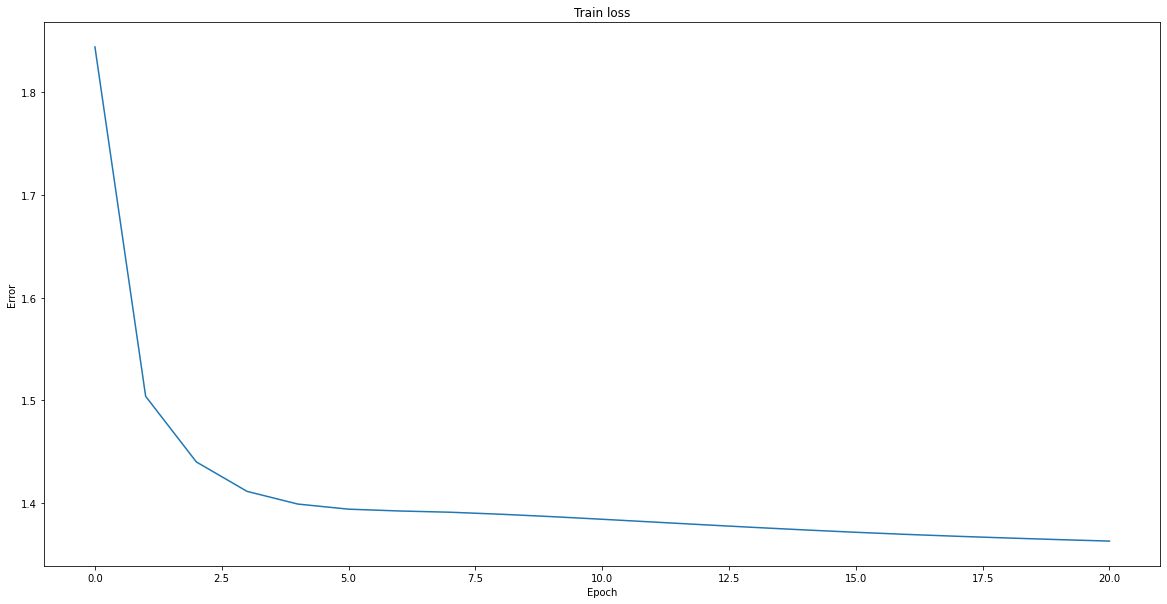

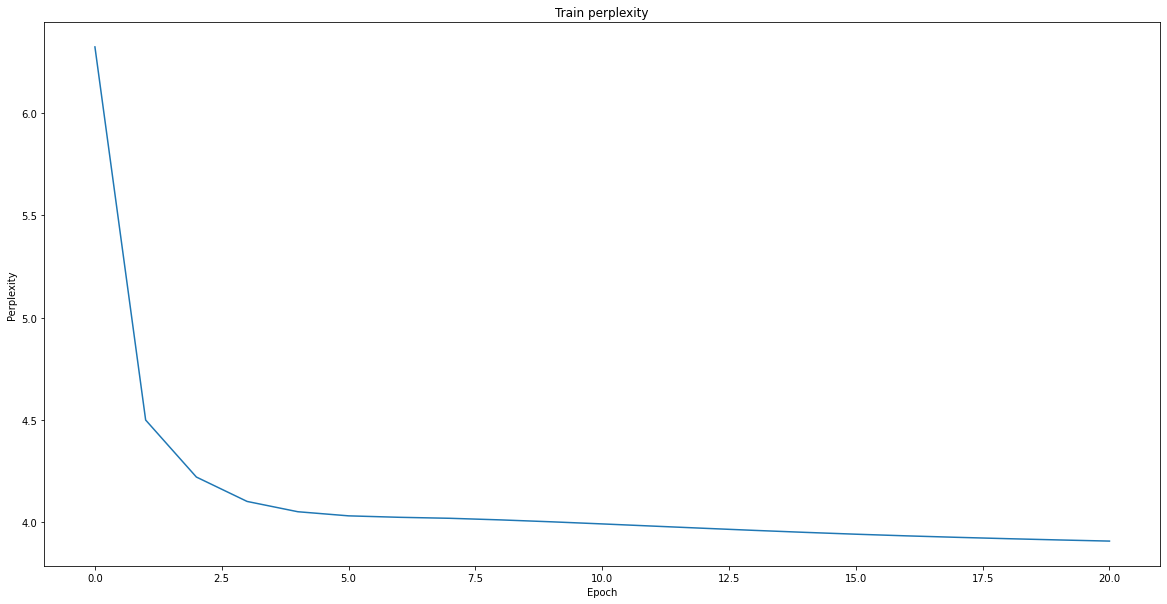

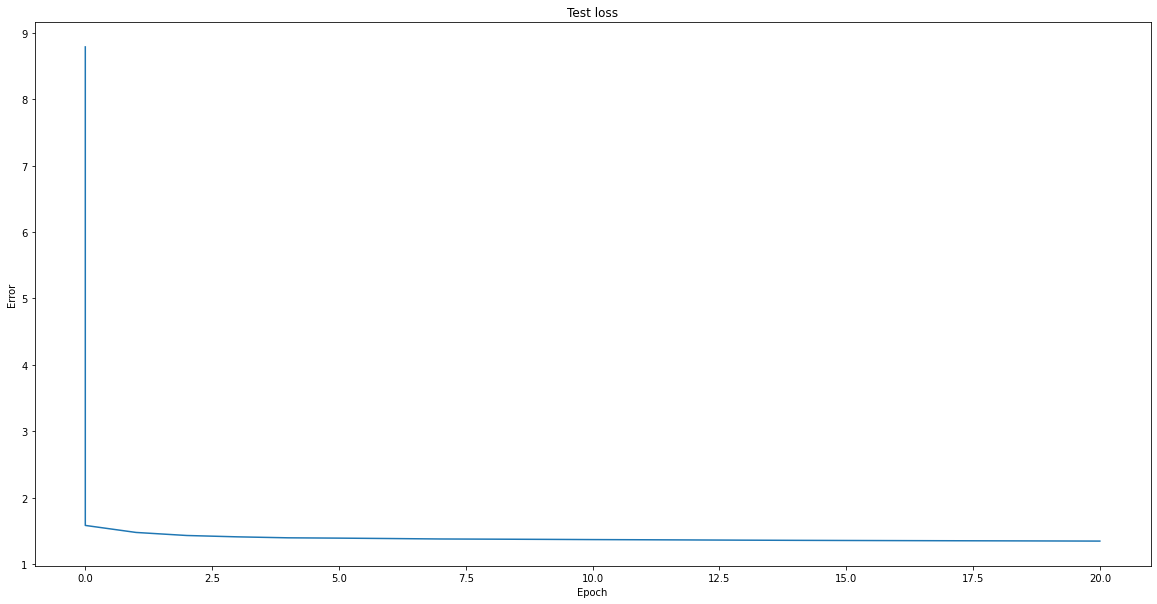

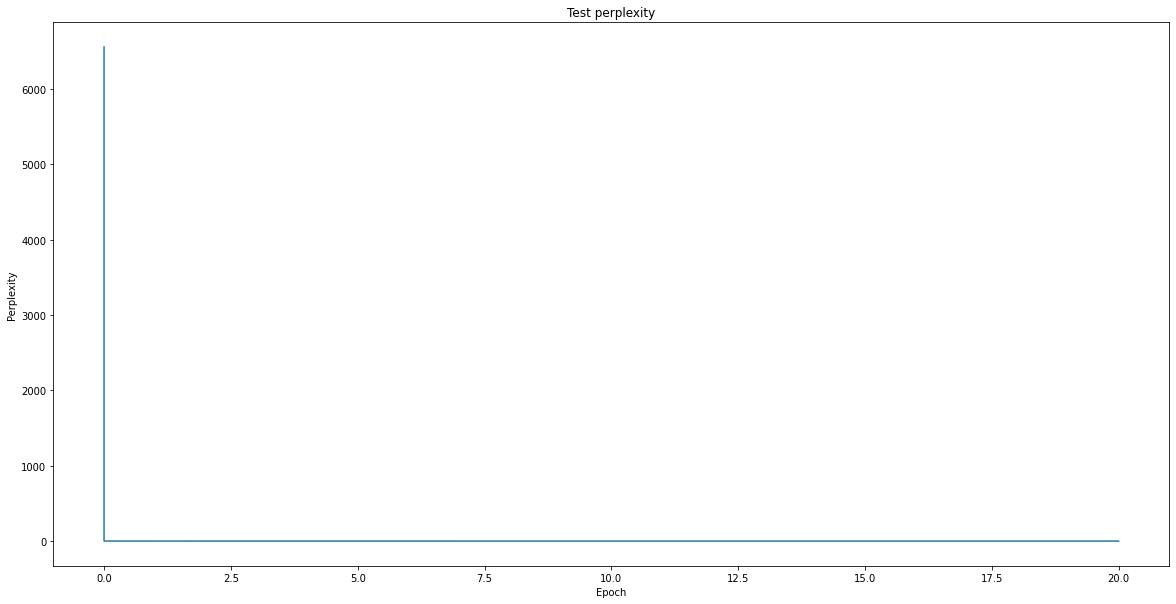

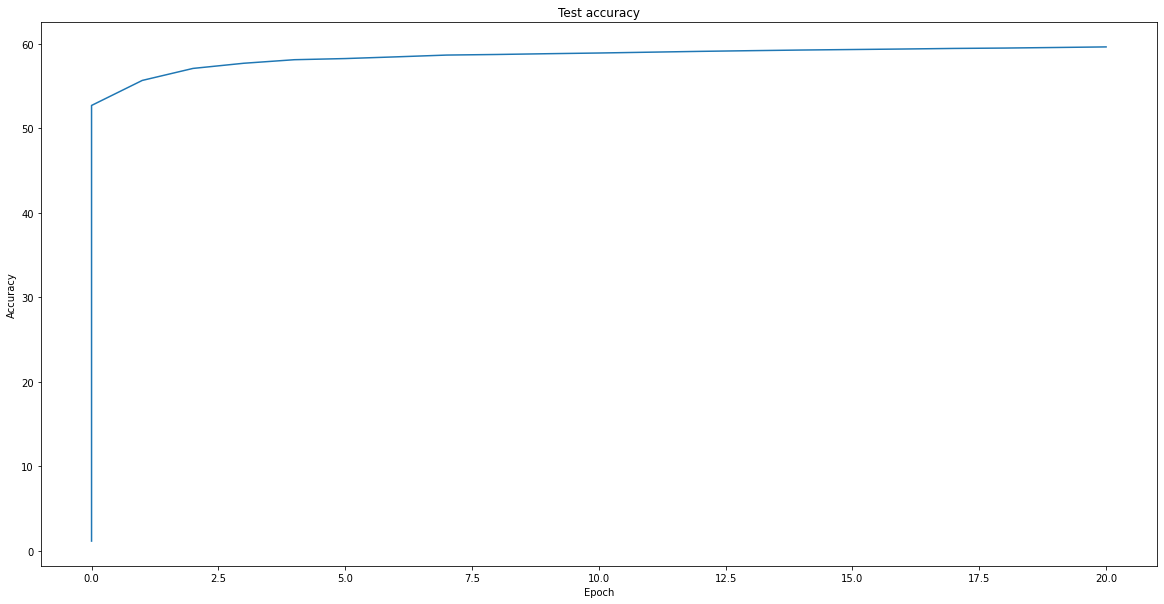

In [21]:
def main():
    SEQUENCE_LENGTH = 50
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log_lstm_hp.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = LSTMNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints_lstm_hp')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = lstm_test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = lstm_train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = lstm_test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints_lstm_hp/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = lstm_generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = lstm_generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = lstm_generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)    
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints_lstm_hp/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        pt_util.plot(ep, np.exp(val), 'Train perplexity', 'Epoch', 'Perplexity')

        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        pt_util.plot(ep, np.exp(val), 'Test perplexity', 'Epoch', 'Perplexity')  

        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Accuracy')
        return model, vocab, device

final_model, vocab, device = main()

In [22]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 100

    generated_sentence = lstm_generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = lstm_generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = lstm_generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and the start of the course of the wall of the wall of the wall of the wall of the wall of the wall of the 
generated with sample	 Harry Potter and the odd, retremely still had supped sowry of!" "Y he can'tll tell that more and proprate of claw you' -
generated with sample	 Harry Potter and the note glanced moved at her worring copted of his long, looked mouth landeflished so there beening to
generated with sample	 Harry Potter and the ale art innowed. "You see that happen to tell the Sire's prounsed of id to do... for goor rigght th
generated with sample	 Harry Potter and the scrrimlied bork and smught repelly whopped her for into hagus to the corridor? couldn't him and now
generated with sample	 Harry Potter and they with up who looked up there was ade. Harry lasted for the Makinus collence hairs forest. Hermione 
generated with sample	 Harry Potter and there," "Hermione this hiddle of holed no claughed pating seatling Bockately. The told months of qu

Using device cuda
num workers: 2
Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	g9!a0]-VsT]hNNNNNx&=wTj]P]]]h]L$NgqV]]P]]PVIQ]r]9e


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	NqNNppV;]gP]j "I PI0w0GsYV]]P-2]hgges]QOrpQ=]]PV]I


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	sr Q]POOsI$whQY]6]ppghgOP.=kkXV]PpQ]0gg]]U2]]]]Ppz


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	00gP Ou]ppNW&0w0]gV]I-N OuQ]R9 9VgB]z"-|GGQ]ppVz]Y


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	zaVNN0]];gq[IvjrkD]x'j]'Q]]P-222xNN.l']z-&&]R9 9Vg


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	y-p]Yg

  0%|          | 1/394 [00:00<01:12,  5.39it/s]

Train Epoch: 0 [0/100864 (0%)]	Loss: 8.684855


  3%|▎         | 12/394 [00:01<00:42,  9.03it/s]

Train Epoch: 0 [2560/100864 (3%)]	Loss: 3.431728


  6%|▌         | 22/394 [00:02<00:42,  8.85it/s]

Train Epoch: 0 [5120/100864 (5%)]	Loss: 2.531461


  8%|▊         | 32/394 [00:03<00:39,  9.14it/s]

Train Epoch: 0 [7680/100864 (8%)]	Loss: 2.273906


 11%|█         | 42/394 [00:04<00:38,  9.04it/s]

Train Epoch: 0 [10240/100864 (10%)]	Loss: 2.147212


 13%|█▎        | 52/394 [00:05<00:38,  8.78it/s]

Train Epoch: 0 [12800/100864 (13%)]	Loss: 2.088089


 16%|█▌        | 62/394 [00:06<00:37,  8.81it/s]

Train Epoch: 0 [15360/100864 (15%)]	Loss: 2.048151


 18%|█▊        | 72/394 [00:08<00:36,  8.94it/s]

Train Epoch: 0 [17920/100864 (18%)]	Loss: 2.030977


 21%|██        | 82/394 [00:09<00:34,  8.96it/s]

Train Epoch: 0 [20480/100864 (20%)]	Loss: 2.018928


 23%|██▎       | 92/394 [00:10<00:33,  8.97it/s]

Train Epoch: 0 [23040/100864 (23%)]	Loss: 1.975910


 26%|██▌       | 102/394 [00:11<00:32,  8.94it/s]

Train Epoch: 0 [25600/100864 (25%)]	Loss: 1.944249


 28%|██▊       | 112/394 [00:12<00:31,  9.06it/s]

Train Epoch: 0 [28160/100864 (28%)]	Loss: 1.949339


 31%|███       | 122/394 [00:13<00:30,  8.80it/s]

Train Epoch: 0 [30720/100864 (30%)]	Loss: 1.897390


 34%|███▎      | 132/394 [00:14<00:29,  8.94it/s]

Train Epoch: 0 [33280/100864 (33%)]	Loss: 1.908170


 36%|███▌      | 142/394 [00:15<00:28,  8.97it/s]

Train Epoch: 0 [35840/100864 (36%)]	Loss: 1.847924


 39%|███▊      | 152/394 [00:16<00:26,  8.97it/s]

Train Epoch: 0 [38400/100864 (38%)]	Loss: 1.886733


 41%|████      | 162/394 [00:18<00:26,  8.76it/s]

Train Epoch: 0 [40960/100864 (41%)]	Loss: 1.830045


 44%|████▎     | 172/394 [00:19<00:24,  8.93it/s]

Train Epoch: 0 [43520/100864 (43%)]	Loss: 1.823912


 46%|████▌     | 182/394 [00:20<00:23,  9.03it/s]

Train Epoch: 0 [46080/100864 (46%)]	Loss: 1.814744


 49%|████▊     | 192/394 [00:21<00:22,  8.91it/s]

Train Epoch: 0 [48640/100864 (48%)]	Loss: 1.798463


 51%|█████▏    | 202/394 [00:22<00:21,  9.00it/s]

Train Epoch: 0 [51200/100864 (51%)]	Loss: 1.822966


 54%|█████▍    | 212/394 [00:23<00:20,  8.94it/s]

Train Epoch: 0 [53760/100864 (53%)]	Loss: 1.805843


 56%|█████▋    | 222/394 [00:24<00:19,  8.97it/s]

Train Epoch: 0 [56320/100864 (56%)]	Loss: 1.758950


 59%|█████▉    | 232/394 [00:25<00:18,  9.00it/s]

Train Epoch: 0 [58880/100864 (58%)]	Loss: 1.834044


 61%|██████▏   | 242/394 [00:27<00:17,  8.93it/s]

Train Epoch: 0 [61440/100864 (61%)]	Loss: 1.770387


 64%|██████▍   | 252/394 [00:28<00:16,  8.85it/s]

Train Epoch: 0 [64000/100864 (63%)]	Loss: 1.795327


 66%|██████▋   | 262/394 [00:29<00:14,  8.92it/s]

Train Epoch: 0 [66560/100864 (66%)]	Loss: 1.761369


 69%|██████▉   | 272/394 [00:30<00:13,  9.04it/s]

Train Epoch: 0 [69120/100864 (69%)]	Loss: 1.763738


 72%|███████▏  | 282/394 [00:31<00:12,  8.94it/s]

Train Epoch: 0 [71680/100864 (71%)]	Loss: 1.718376


 74%|███████▍  | 292/394 [00:32<00:11,  9.08it/s]

Train Epoch: 0 [74240/100864 (74%)]	Loss: 1.739578


 77%|███████▋  | 302/394 [00:33<00:10,  8.86it/s]

Train Epoch: 0 [76800/100864 (76%)]	Loss: 1.711124


 79%|███████▉  | 312/394 [00:34<00:09,  8.98it/s]

Train Epoch: 0 [79360/100864 (79%)]	Loss: 1.709749


 82%|████████▏ | 322/394 [00:35<00:08,  8.85it/s]

Train Epoch: 0 [81920/100864 (81%)]	Loss: 1.718887


 84%|████████▍ | 332/394 [00:37<00:06,  8.94it/s]

Train Epoch: 0 [84480/100864 (84%)]	Loss: 1.717137


 87%|████████▋ | 342/394 [00:38<00:05,  8.91it/s]

Train Epoch: 0 [87040/100864 (86%)]	Loss: 1.734194


 89%|████████▉ | 352/394 [00:39<00:04,  8.97it/s]

Train Epoch: 0 [89600/100864 (89%)]	Loss: 1.676157


 92%|█████████▏| 362/394 [00:40<00:03,  9.05it/s]

Train Epoch: 0 [92160/100864 (91%)]	Loss: 1.701508


 94%|█████████▍| 372/394 [00:41<00:02,  8.99it/s]

Train Epoch: 0 [94720/100864 (94%)]	Loss: 1.696061


 97%|█████████▋| 382/394 [00:42<00:01,  8.98it/s]

Train Epoch: 0 [97280/100864 (96%)]	Loss: 1.716488


 99%|█████████▉| 392/394 [00:43<00:00,  9.02it/s]

Train Epoch: 0 [99840/100864 (99%)]	Loss: 1.697226


100%|██████████| 394/394 [00:43<00:00,  8.98it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	urhtthe e was a srnrt af th ntn tn  of the   aauld


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tnow of ttme hing txeo ahet tauld bialaedthe sa


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	dti aolllng   ar tnow ed edtta ais not tha th tist


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter taad ng the sadter  autuzov aaalh d tam aat


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	aaad  ToAPTER AIIIaIell, ahet s anl   said tutuzov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	n, ahot t su nse "Ihet  aour ahel  irt 

  1%|          | 2/394 [00:00<01:06,  5.92it/s]

Train Epoch: 1 [0/100864 (0%)]	Loss: 1.721226


  3%|▎         | 12/394 [00:01<00:43,  8.86it/s]

Train Epoch: 1 [2560/100864 (3%)]	Loss: 1.650381


  6%|▌         | 22/394 [00:02<00:41,  9.06it/s]

Train Epoch: 1 [5120/100864 (5%)]	Loss: 1.673243


  8%|▊         | 32/394 [00:03<00:40,  8.97it/s]

Train Epoch: 1 [7680/100864 (8%)]	Loss: 1.667543


 11%|█         | 42/394 [00:04<00:38,  9.05it/s]

Train Epoch: 1 [10240/100864 (10%)]	Loss: 1.643828


 13%|█▎        | 52/394 [00:05<00:37,  9.00it/s]

Train Epoch: 1 [12800/100864 (13%)]	Loss: 1.647530


 16%|█▌        | 62/394 [00:06<00:36,  9.04it/s]

Train Epoch: 1 [15360/100864 (15%)]	Loss: 1.643127


 18%|█▊        | 72/394 [00:08<00:35,  9.10it/s]

Train Epoch: 1 [17920/100864 (18%)]	Loss: 1.632208


 21%|██        | 82/394 [00:09<00:35,  8.84it/s]

Train Epoch: 1 [20480/100864 (20%)]	Loss: 1.664274


 23%|██▎       | 92/394 [00:10<00:33,  9.10it/s]

Train Epoch: 1 [23040/100864 (23%)]	Loss: 1.647452


 26%|██▌       | 102/394 [00:11<00:32,  8.96it/s]

Train Epoch: 1 [25600/100864 (25%)]	Loss: 1.629623


 28%|██▊       | 112/394 [00:12<00:31,  9.08it/s]

Train Epoch: 1 [28160/100864 (28%)]	Loss: 1.626900


 31%|███       | 122/394 [00:13<00:29,  9.14it/s]

Train Epoch: 1 [30720/100864 (30%)]	Loss: 1.611376


 34%|███▎      | 132/394 [00:14<00:29,  9.02it/s]

Train Epoch: 1 [33280/100864 (33%)]	Loss: 1.634368


 36%|███▌      | 142/394 [00:15<00:27,  9.17it/s]

Train Epoch: 1 [35840/100864 (36%)]	Loss: 1.578887


 39%|███▊      | 152/394 [00:16<00:27,  8.82it/s]

Train Epoch: 1 [38400/100864 (38%)]	Loss: 1.621644


 41%|████      | 162/394 [00:18<00:25,  9.13it/s]

Train Epoch: 1 [40960/100864 (41%)]	Loss: 1.592110


 44%|████▎     | 172/394 [00:19<00:24,  9.01it/s]

Train Epoch: 1 [43520/100864 (43%)]	Loss: 1.602071


 46%|████▌     | 182/394 [00:20<00:23,  9.02it/s]

Train Epoch: 1 [46080/100864 (46%)]	Loss: 1.591438


 49%|████▊     | 192/394 [00:21<00:22,  8.97it/s]

Train Epoch: 1 [48640/100864 (48%)]	Loss: 1.584775


 51%|█████▏    | 202/394 [00:22<00:21,  8.94it/s]

Train Epoch: 1 [51200/100864 (51%)]	Loss: 1.616897


 54%|█████▍    | 212/394 [00:23<00:19,  9.17it/s]

Train Epoch: 1 [53760/100864 (53%)]	Loss: 1.616918


 56%|█████▋    | 222/394 [00:24<00:19,  8.79it/s]

Train Epoch: 1 [56320/100864 (56%)]	Loss: 1.570324


 59%|█████▉    | 232/394 [00:25<00:17,  9.01it/s]

Train Epoch: 1 [58880/100864 (58%)]	Loss: 1.647269


 61%|██████▏   | 242/394 [00:26<00:16,  8.98it/s]

Train Epoch: 1 [61440/100864 (61%)]	Loss: 1.593426


 64%|██████▍   | 252/394 [00:27<00:15,  8.95it/s]

Train Epoch: 1 [64000/100864 (63%)]	Loss: 1.628458


 66%|██████▋   | 262/394 [00:29<00:14,  9.05it/s]

Train Epoch: 1 [66560/100864 (66%)]	Loss: 1.598915


 69%|██████▉   | 272/394 [00:30<00:13,  9.08it/s]

Train Epoch: 1 [69120/100864 (69%)]	Loss: 1.592158


 72%|███████▏  | 282/394 [00:31<00:12,  8.98it/s]

Train Epoch: 1 [71680/100864 (71%)]	Loss: 1.558662


 74%|███████▍  | 292/394 [00:32<00:11,  8.99it/s]

Train Epoch: 1 [74240/100864 (74%)]	Loss: 1.579772


 77%|███████▋  | 302/394 [00:33<00:10,  9.19it/s]

Train Epoch: 1 [76800/100864 (76%)]	Loss: 1.560714


 79%|███████▉  | 312/394 [00:34<00:09,  9.04it/s]

Train Epoch: 1 [79360/100864 (79%)]	Loss: 1.577162


 82%|████████▏ | 322/394 [00:35<00:07,  9.00it/s]

Train Epoch: 1 [81920/100864 (81%)]	Loss: 1.577924


 84%|████████▍ | 332/394 [00:36<00:06,  9.22it/s]

Train Epoch: 1 [84480/100864 (84%)]	Loss: 1.579049


 87%|████████▋ | 342/394 [00:37<00:05,  9.03it/s]

Train Epoch: 1 [87040/100864 (86%)]	Loss: 1.611376


 89%|████████▉ | 352/394 [00:38<00:04,  9.07it/s]

Train Epoch: 1 [89600/100864 (89%)]	Loss: 1.551769


 92%|█████████▏| 362/394 [00:40<00:03,  8.98it/s]

Train Epoch: 1 [92160/100864 (91%)]	Loss: 1.589093


 94%|█████████▍| 372/394 [00:41<00:02,  9.23it/s]

Train Epoch: 1 [94720/100864 (94%)]	Loss: 1.583671


 97%|█████████▋| 382/394 [00:42<00:01,  9.02it/s]

Train Epoch: 1 [97280/100864 (96%)]	Loss: 1.601529


 99%|█████████▉| 392/394 [00:43<00:00,  9.19it/s]

Train Epoch: 1 [99840/100864 (99%)]	Loss: 1.588779


100%|██████████| 394/394 [00:43<00:00,  9.05it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nnhtthe e ias a setrt af th ntn tn  of the   aonld


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tnow tf tpme iing txeontoet tauld boaldedthe sa


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	nt  aolling   an tnow ed e tta wes not toa oh tist


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter taaddng the satter  autuzov aaalh d tim mit


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	maad  "oAPTER XIIITIell, ahet s anl   said tutuzov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	n, ahot t sa rte  Ihet  aou  ahelk irt 

  1%|          | 2/394 [00:00<01:08,  5.73it/s]

Train Epoch: 2 [0/100864 (0%)]	Loss: 1.609280


  3%|▎         | 12/394 [00:01<00:42,  8.95it/s]

Train Epoch: 2 [2560/100864 (3%)]	Loss: 1.548452


  6%|▌         | 22/394 [00:02<00:41,  8.96it/s]

Train Epoch: 2 [5120/100864 (5%)]	Loss: 1.576451


  8%|▊         | 32/394 [00:03<00:39,  9.10it/s]

Train Epoch: 2 [7680/100864 (8%)]	Loss: 1.562039


 11%|█         | 42/394 [00:04<00:39,  8.97it/s]

Train Epoch: 2 [10240/100864 (10%)]	Loss: 1.548882


 13%|█▎        | 52/394 [00:05<00:38,  8.89it/s]

Train Epoch: 2 [12800/100864 (13%)]	Loss: 1.546508


 16%|█▌        | 62/394 [00:07<00:36,  9.09it/s]

Train Epoch: 2 [15360/100864 (15%)]	Loss: 1.551861


 18%|█▊        | 72/394 [00:08<00:35,  9.14it/s]

Train Epoch: 2 [17920/100864 (18%)]	Loss: 1.548459


 21%|██        | 82/394 [00:09<00:33,  9.20it/s]

Train Epoch: 2 [20480/100864 (20%)]	Loss: 1.573063


 23%|██▎       | 92/394 [00:10<00:34,  8.84it/s]

Train Epoch: 2 [23040/100864 (23%)]	Loss: 1.558607


 26%|██▌       | 102/394 [00:11<00:32,  9.02it/s]

Train Epoch: 2 [25600/100864 (25%)]	Loss: 1.543304


 28%|██▊       | 112/394 [00:12<00:31,  9.08it/s]

Train Epoch: 2 [28160/100864 (28%)]	Loss: 1.540417


 31%|███       | 122/394 [00:13<00:31,  8.75it/s]

Train Epoch: 2 [30720/100864 (30%)]	Loss: 1.526162


 34%|███▎      | 132/394 [00:14<00:28,  9.23it/s]

Train Epoch: 2 [33280/100864 (33%)]	Loss: 1.551042


 36%|███▌      | 142/394 [00:15<00:28,  8.86it/s]

Train Epoch: 2 [35840/100864 (36%)]	Loss: 1.508016


 39%|███▊      | 152/394 [00:16<00:26,  9.15it/s]

Train Epoch: 2 [38400/100864 (38%)]	Loss: 1.541674


 41%|████      | 162/394 [00:18<00:25,  9.05it/s]

Train Epoch: 2 [40960/100864 (41%)]	Loss: 1.524895


 44%|████▎     | 172/394 [00:19<00:24,  8.99it/s]

Train Epoch: 2 [43520/100864 (43%)]	Loss: 1.531983


 46%|████▌     | 182/394 [00:20<00:23,  8.97it/s]

Train Epoch: 2 [46080/100864 (46%)]	Loss: 1.527613


 49%|████▊     | 192/394 [00:21<00:23,  8.72it/s]

Train Epoch: 2 [48640/100864 (48%)]	Loss: 1.525678


 51%|█████▏    | 202/394 [00:22<00:20,  9.14it/s]

Train Epoch: 2 [51200/100864 (51%)]	Loss: 1.552907


 54%|█████▍    | 212/394 [00:23<00:20,  8.95it/s]

Train Epoch: 2 [53760/100864 (53%)]	Loss: 1.551930


 56%|█████▋    | 222/394 [00:24<00:18,  9.14it/s]

Train Epoch: 2 [56320/100864 (56%)]	Loss: 1.510730


 59%|█████▉    | 232/394 [00:25<00:17,  9.15it/s]

Train Epoch: 2 [58880/100864 (58%)]	Loss: 1.584819


 61%|██████▏   | 242/394 [00:26<00:17,  8.94it/s]

Train Epoch: 2 [61440/100864 (61%)]	Loss: 1.534488


 64%|██████▍   | 252/394 [00:28<00:15,  9.28it/s]

Train Epoch: 2 [64000/100864 (63%)]	Loss: 1.561168


 66%|██████▋   | 262/394 [00:29<00:14,  9.01it/s]

Train Epoch: 2 [66560/100864 (66%)]	Loss: 1.542951


 69%|██████▉   | 272/394 [00:30<00:13,  8.97it/s]

Train Epoch: 2 [69120/100864 (69%)]	Loss: 1.534289


 72%|███████▏  | 282/394 [00:31<00:12,  9.00it/s]

Train Epoch: 2 [71680/100864 (71%)]	Loss: 1.497432


 74%|███████▍  | 292/394 [00:32<00:11,  9.21it/s]

Train Epoch: 2 [74240/100864 (74%)]	Loss: 1.525807


 77%|███████▋  | 302/394 [00:33<00:10,  8.93it/s]

Train Epoch: 2 [76800/100864 (76%)]	Loss: 1.509679


 79%|███████▉  | 312/394 [00:34<00:09,  9.10it/s]

Train Epoch: 2 [79360/100864 (79%)]	Loss: 1.525024


 82%|████████▏ | 322/394 [00:35<00:07,  9.09it/s]

Train Epoch: 2 [81920/100864 (81%)]	Loss: 1.522764


 84%|████████▍ | 332/394 [00:36<00:07,  8.85it/s]

Train Epoch: 2 [84480/100864 (84%)]	Loss: 1.528438


 87%|████████▋ | 342/394 [00:37<00:05,  9.14it/s]

Train Epoch: 2 [87040/100864 (86%)]	Loss: 1.564779


 89%|████████▉ | 352/394 [00:39<00:04,  8.94it/s]

Train Epoch: 2 [89600/100864 (89%)]	Loss: 1.506832


 92%|█████████▏| 362/394 [00:40<00:03,  9.12it/s]

Train Epoch: 2 [92160/100864 (91%)]	Loss: 1.541629


 94%|█████████▍| 372/394 [00:41<00:02,  9.06it/s]

Train Epoch: 2 [94720/100864 (94%)]	Loss: 1.536830


 97%|█████████▋| 382/394 [00:42<00:01,  9.01it/s]

Train Epoch: 2 [97280/100864 (96%)]	Loss: 1.553379


 99%|█████████▉| 392/394 [00:43<00:00,  9.21it/s]

Train Epoch: 2 [99840/100864 (99%)]	Loss: 1.539577


100%|██████████| 394/394 [00:43<00:00,  9.03it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nnhtthe e ias a srtre af th ntt tne of the   aonld


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd teow tn tome hing txeontoet tauld bo ldedthe sa


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	nt  aolling   an tnow ed e -ta wes not toaith tost


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter ta ddng the satter  autuzov aaalhed tim sit


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	saad  "oAPTER TIIITIell, thet s tnl   said tutuzov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	n, ahot t sa rt  "Ihet  tou  aaell irr 

  1%|          | 2/394 [00:00<01:02,  6.27it/s]

Train Epoch: 3 [0/100864 (0%)]	Loss: 1.556041


  3%|▎         | 12/394 [00:01<00:43,  8.71it/s]

Train Epoch: 3 [2560/100864 (3%)]	Loss: 1.506684


  6%|▌         | 22/394 [00:02<00:40,  9.17it/s]

Train Epoch: 3 [5120/100864 (5%)]	Loss: 1.530080


  8%|▊         | 32/394 [00:03<00:40,  8.97it/s]

Train Epoch: 3 [7680/100864 (8%)]	Loss: 1.519679


 11%|█         | 42/394 [00:04<00:39,  8.88it/s]

Train Epoch: 3 [10240/100864 (10%)]	Loss: 1.508939


 13%|█▎        | 52/394 [00:05<00:37,  9.03it/s]

Train Epoch: 3 [12800/100864 (13%)]	Loss: 1.504267


 16%|█▌        | 62/394 [00:06<00:37,  8.92it/s]

Train Epoch: 3 [15360/100864 (15%)]	Loss: 1.512380


 18%|█▊        | 72/394 [00:08<00:35,  9.06it/s]

Train Epoch: 3 [17920/100864 (18%)]	Loss: 1.510937


 21%|██        | 82/394 [00:09<00:35,  8.81it/s]

Train Epoch: 3 [20480/100864 (20%)]	Loss: 1.536503


 23%|██▎       | 92/394 [00:10<00:33,  8.91it/s]

Train Epoch: 3 [23040/100864 (23%)]	Loss: 1.517667


 26%|██▌       | 102/394 [00:11<00:32,  8.86it/s]

Train Epoch: 3 [25600/100864 (25%)]	Loss: 1.505610


 28%|██▊       | 112/394 [00:12<00:31,  9.09it/s]

Train Epoch: 3 [28160/100864 (28%)]	Loss: 1.503679


 31%|███       | 122/394 [00:13<00:30,  9.06it/s]

Train Epoch: 3 [30720/100864 (30%)]	Loss: 1.490755


 34%|███▎      | 132/394 [00:14<00:28,  9.18it/s]

Train Epoch: 3 [33280/100864 (33%)]	Loss: 1.515645


 36%|███▌      | 142/394 [00:15<00:27,  9.09it/s]

Train Epoch: 3 [35840/100864 (36%)]	Loss: 1.468702


 39%|███▊      | 152/394 [00:16<00:26,  9.03it/s]

Train Epoch: 3 [38400/100864 (38%)]	Loss: 1.508638


 41%|████      | 162/394 [00:17<00:25,  9.11it/s]

Train Epoch: 3 [40960/100864 (41%)]	Loss: 1.499642


 44%|████▎     | 172/394 [00:19<00:24,  9.15it/s]

Train Epoch: 3 [43520/100864 (43%)]	Loss: 1.503972


 46%|████▌     | 182/394 [00:20<00:23,  9.19it/s]

Train Epoch: 3 [46080/100864 (46%)]	Loss: 1.501502


 49%|████▊     | 192/394 [00:21<00:22,  9.01it/s]

Train Epoch: 3 [48640/100864 (48%)]	Loss: 1.503567


 51%|█████▏    | 202/394 [00:22<00:21,  9.11it/s]

Train Epoch: 3 [51200/100864 (51%)]	Loss: 1.523377


 54%|█████▍    | 212/394 [00:23<00:19,  9.16it/s]

Train Epoch: 3 [53760/100864 (53%)]	Loss: 1.524842


 56%|█████▋    | 222/394 [00:24<00:19,  8.90it/s]

Train Epoch: 3 [56320/100864 (56%)]	Loss: 1.481357


 59%|█████▉    | 232/394 [00:25<00:17,  9.08it/s]

Train Epoch: 3 [58880/100864 (58%)]	Loss: 1.554683


 61%|██████▏   | 242/394 [00:26<00:16,  8.98it/s]

Train Epoch: 3 [61440/100864 (61%)]	Loss: 1.506945


 64%|██████▍   | 252/394 [00:27<00:16,  8.85it/s]

Train Epoch: 3 [64000/100864 (63%)]	Loss: 1.533499


 66%|██████▋   | 262/394 [00:28<00:14,  9.30it/s]

Train Epoch: 3 [66560/100864 (66%)]	Loss: 1.517748


 69%|██████▉   | 272/394 [00:30<00:13,  9.10it/s]

Train Epoch: 3 [69120/100864 (69%)]	Loss: 1.509585


 72%|███████▏  | 282/394 [00:31<00:12,  8.96it/s]

Train Epoch: 3 [71680/100864 (71%)]	Loss: 1.469363


 74%|███████▍  | 292/394 [00:32<00:11,  9.00it/s]

Train Epoch: 3 [74240/100864 (74%)]	Loss: 1.504196


 77%|███████▋  | 302/394 [00:33<00:10,  9.09it/s]

Train Epoch: 3 [76800/100864 (76%)]	Loss: 1.486601


 79%|███████▉  | 312/394 [00:34<00:09,  9.05it/s]

Train Epoch: 3 [79360/100864 (79%)]	Loss: 1.498877


 82%|████████▏ | 322/394 [00:35<00:08,  8.99it/s]

Train Epoch: 3 [81920/100864 (81%)]	Loss: 1.500158


 84%|████████▍ | 332/394 [00:36<00:06,  9.26it/s]

Train Epoch: 3 [84480/100864 (84%)]	Loss: 1.504958


 87%|████████▋ | 342/394 [00:37<00:05,  9.05it/s]

Train Epoch: 3 [87040/100864 (86%)]	Loss: 1.540827


 89%|████████▉ | 352/394 [00:38<00:04,  9.10it/s]

Train Epoch: 3 [89600/100864 (89%)]	Loss: 1.482109


 92%|█████████▏| 362/394 [00:39<00:03,  9.06it/s]

Train Epoch: 3 [92160/100864 (91%)]	Loss: 1.514838


 94%|█████████▍| 372/394 [00:41<00:02,  9.21it/s]

Train Epoch: 3 [94720/100864 (94%)]	Loss: 1.513774


 97%|█████████▋| 382/394 [00:42<00:01,  8.94it/s]

Train Epoch: 3 [97280/100864 (96%)]	Loss: 1.530990


 99%|█████████▉| 392/394 [00:43<00:00,  9.25it/s]

Train Epoch: 3 [99840/100864 (99%)]	Loss: 1.513158


100%|██████████| 394/394 [00:43<00:00,  9.08it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nnhtthe e ias a satre of th ntn tne of the   aonld


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd teow tn tome hing txeestoat tauld bo ldedthe sa


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	nte aolling   ar tnow ed e -ta wes not toaith tost


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 T ter ta rdng the satter  autuzov aailhed aim sat


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	haad  "oaPTER TIIITIell, Ihet s tnl   said tutuzov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	n, ahot i sa rt  "Ihet  tou  aaell irrd

  1%|          | 2/394 [00:00<01:06,  5.88it/s]

Train Epoch: 4 [0/100864 (0%)]	Loss: 1.532731


  3%|▎         | 12/394 [00:01<00:42,  9.02it/s]

Train Epoch: 4 [2560/100864 (3%)]	Loss: 1.485864


  6%|▌         | 22/394 [00:02<00:42,  8.74it/s]

Train Epoch: 4 [5120/100864 (5%)]	Loss: 1.509418


  8%|▊         | 32/394 [00:03<00:39,  9.05it/s]

Train Epoch: 4 [7680/100864 (8%)]	Loss: 1.500246


 11%|█         | 42/394 [00:04<00:39,  8.85it/s]

Train Epoch: 4 [10240/100864 (10%)]	Loss: 1.484425


 13%|█▎        | 52/394 [00:05<00:38,  8.86it/s]

Train Epoch: 4 [12800/100864 (13%)]	Loss: 1.478531


 16%|█▌        | 62/394 [00:07<00:37,  8.87it/s]

Train Epoch: 4 [15360/100864 (15%)]	Loss: 1.492520


 18%|█▊        | 72/394 [00:08<00:36,  8.83it/s]

Train Epoch: 4 [17920/100864 (18%)]	Loss: 1.496916


 21%|██        | 82/394 [00:09<00:34,  8.99it/s]

Train Epoch: 4 [20480/100864 (20%)]	Loss: 1.522284


 23%|██▎       | 92/394 [00:10<00:34,  8.82it/s]

Train Epoch: 4 [23040/100864 (23%)]	Loss: 1.501955


 26%|██▌       | 102/394 [00:11<00:32,  8.93it/s]

Train Epoch: 4 [25600/100864 (25%)]	Loss: 1.485158


 28%|██▊       | 112/394 [00:12<00:31,  8.99it/s]

Train Epoch: 4 [28160/100864 (28%)]	Loss: 1.489272


 31%|███       | 122/394 [00:13<00:30,  8.95it/s]

Train Epoch: 4 [30720/100864 (30%)]	Loss: 1.477008


 34%|███▎      | 132/394 [00:14<00:29,  8.87it/s]

Train Epoch: 4 [33280/100864 (33%)]	Loss: 1.502239


 36%|███▌      | 142/394 [00:15<00:27,  9.11it/s]

Train Epoch: 4 [35840/100864 (36%)]	Loss: 1.449493


 39%|███▊      | 152/394 [00:17<00:27,  8.96it/s]

Train Epoch: 4 [38400/100864 (38%)]	Loss: 1.494447


 41%|████      | 162/394 [00:18<00:25,  9.04it/s]

Train Epoch: 4 [40960/100864 (41%)]	Loss: 1.483929


 44%|████▎     | 172/394 [00:19<00:24,  8.96it/s]

Train Epoch: 4 [43520/100864 (43%)]	Loss: 1.486958


 46%|████▌     | 182/394 [00:20<00:24,  8.77it/s]

Train Epoch: 4 [46080/100864 (46%)]	Loss: 1.486843


 49%|████▊     | 192/394 [00:21<00:22,  8.79it/s]

Train Epoch: 4 [48640/100864 (48%)]	Loss: 1.483566


 51%|█████▏    | 202/394 [00:22<00:21,  9.02it/s]

Train Epoch: 4 [51200/100864 (51%)]	Loss: 1.509432


 54%|█████▍    | 212/394 [00:23<00:20,  8.82it/s]

Train Epoch: 4 [53760/100864 (53%)]	Loss: 1.512654


 56%|█████▋    | 222/394 [00:24<00:18,  9.12it/s]

Train Epoch: 4 [56320/100864 (56%)]	Loss: 1.466770


 59%|█████▉    | 232/394 [00:26<00:17,  9.01it/s]

Train Epoch: 4 [58880/100864 (58%)]	Loss: 1.540843


 61%|██████▏   | 242/394 [00:27<00:16,  9.22it/s]

Train Epoch: 4 [61440/100864 (61%)]	Loss: 1.495087


 64%|██████▍   | 252/394 [00:28<00:15,  9.06it/s]

Train Epoch: 4 [64000/100864 (63%)]	Loss: 1.524095


 66%|██████▋   | 262/394 [00:29<00:14,  9.00it/s]

Train Epoch: 4 [66560/100864 (66%)]	Loss: 1.509030


 69%|██████▉   | 272/394 [00:30<00:13,  8.96it/s]

Train Epoch: 4 [69120/100864 (69%)]	Loss: 1.500890


 72%|███████▏  | 282/394 [00:31<00:12,  8.87it/s]

Train Epoch: 4 [71680/100864 (71%)]	Loss: 1.455800


 74%|███████▍  | 292/394 [00:32<00:11,  8.87it/s]

Train Epoch: 4 [74240/100864 (74%)]	Loss: 1.495006


 77%|███████▋  | 302/394 [00:33<00:10,  9.01it/s]

Train Epoch: 4 [76800/100864 (76%)]	Loss: 1.474791


 79%|███████▉  | 312/394 [00:34<00:09,  8.92it/s]

Train Epoch: 4 [79360/100864 (79%)]	Loss: 1.485182


 82%|████████▏ | 322/394 [00:36<00:08,  8.93it/s]

Train Epoch: 4 [81920/100864 (81%)]	Loss: 1.486081


 84%|████████▍ | 332/394 [00:37<00:06,  8.88it/s]

Train Epoch: 4 [84480/100864 (84%)]	Loss: 1.493642


 87%|████████▋ | 342/394 [00:38<00:05,  8.96it/s]

Train Epoch: 4 [87040/100864 (86%)]	Loss: 1.534240


 89%|████████▉ | 352/394 [00:39<00:04,  8.94it/s]

Train Epoch: 4 [89600/100864 (89%)]	Loss: 1.470903


 92%|█████████▏| 362/394 [00:40<00:03,  9.00it/s]

Train Epoch: 4 [92160/100864 (91%)]	Loss: 1.508679


 94%|█████████▍| 372/394 [00:41<00:02,  8.87it/s]

Train Epoch: 4 [94720/100864 (94%)]	Loss: 1.505410


 97%|█████████▋| 382/394 [00:42<00:01,  9.07it/s]

Train Epoch: 4 [97280/100864 (96%)]	Loss: 1.518416


 99%|█████████▉| 392/394 [00:43<00:00,  9.18it/s]

Train Epoch: 4 [99840/100864 (99%)]	Loss: 1.498630


100%|██████████| 394/394 [00:44<00:00,  8.95it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nnhtthe e ias a saere of th ntn tne of the   aonld


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tiow tn tome hing txeestoat tauld bo ldedthe sa


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	nte aolling   ar tnow ed e -aa wis not touith tost


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter ta rdng the satter  aut zov hailked tis sag


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	haad  "oaPTER TIIITIell, Ihet s t l   said hut zov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	n, aaat i sa rt  "Ihet  tou  aailt errd

  1%|          | 2/394 [00:00<01:02,  6.24it/s]

Train Epoch: 5 [0/100864 (0%)]	Loss: 1.520590


  3%|▎         | 12/394 [00:01<00:43,  8.82it/s]

Train Epoch: 5 [2560/100864 (3%)]	Loss: 1.474443


  6%|▌         | 22/394 [00:02<00:41,  9.06it/s]

Train Epoch: 5 [5120/100864 (5%)]	Loss: 1.494572


  8%|▊         | 32/394 [00:03<00:40,  8.84it/s]

Train Epoch: 5 [7680/100864 (8%)]	Loss: 1.489735


 11%|█         | 42/394 [00:04<00:39,  9.02it/s]

Train Epoch: 5 [10240/100864 (10%)]	Loss: 1.474879


 13%|█▎        | 52/394 [00:05<00:38,  8.91it/s]

Train Epoch: 5 [12800/100864 (13%)]	Loss: 1.468878


 16%|█▌        | 62/394 [00:07<00:36,  9.08it/s]

Train Epoch: 5 [15360/100864 (15%)]	Loss: 1.486614


 18%|█▊        | 72/394 [00:08<00:36,  8.93it/s]

Train Epoch: 5 [17920/100864 (18%)]	Loss: 1.494171


 21%|██        | 82/394 [00:09<00:34,  8.92it/s]

Train Epoch: 5 [20480/100864 (20%)]	Loss: 1.512039


 23%|██▎       | 92/394 [00:10<00:33,  8.98it/s]

Train Epoch: 5 [23040/100864 (23%)]	Loss: 1.497391


 26%|██▌       | 102/394 [00:11<00:32,  8.85it/s]

Train Epoch: 5 [25600/100864 (25%)]	Loss: 1.477847


 28%|██▊       | 112/394 [00:12<00:30,  9.16it/s]

Train Epoch: 5 [28160/100864 (28%)]	Loss: 1.486418


 31%|███       | 122/394 [00:13<00:30,  9.03it/s]

Train Epoch: 5 [30720/100864 (30%)]	Loss: 1.471803


 34%|███▎      | 132/394 [00:14<00:28,  9.13it/s]

Train Epoch: 5 [33280/100864 (33%)]	Loss: 1.494185


 36%|███▌      | 142/394 [00:15<00:28,  8.99it/s]

Train Epoch: 5 [35840/100864 (36%)]	Loss: 1.444062


 39%|███▊      | 152/394 [00:16<00:26,  9.03it/s]

Train Epoch: 5 [38400/100864 (38%)]	Loss: 1.485615


 41%|████      | 162/394 [00:18<00:25,  8.99it/s]

Train Epoch: 5 [40960/100864 (41%)]	Loss: 1.476803


 44%|████▎     | 172/394 [00:19<00:24,  9.08it/s]

Train Epoch: 5 [43520/100864 (43%)]	Loss: 1.482032


 46%|████▌     | 182/394 [00:20<00:22,  9.26it/s]

Train Epoch: 5 [46080/100864 (46%)]	Loss: 1.480987


 49%|████▊     | 192/394 [00:21<00:22,  8.97it/s]

Train Epoch: 5 [48640/100864 (48%)]	Loss: 1.472158


 51%|█████▏    | 202/394 [00:22<00:20,  9.19it/s]

Train Epoch: 5 [51200/100864 (51%)]	Loss: 1.499962


 54%|█████▍    | 212/394 [00:23<00:20,  9.09it/s]

Train Epoch: 5 [53760/100864 (53%)]	Loss: 1.504982


 56%|█████▋    | 222/394 [00:24<00:19,  8.86it/s]

Train Epoch: 5 [56320/100864 (56%)]	Loss: 1.458061


 59%|█████▉    | 232/394 [00:25<00:17,  9.27it/s]

Train Epoch: 5 [58880/100864 (58%)]	Loss: 1.534103


 61%|██████▏   | 242/394 [00:26<00:17,  8.87it/s]

Train Epoch: 5 [61440/100864 (61%)]	Loss: 1.489872


 64%|██████▍   | 252/394 [00:27<00:15,  8.90it/s]

Train Epoch: 5 [64000/100864 (63%)]	Loss: 1.519365


 66%|██████▋   | 262/394 [00:29<00:14,  9.10it/s]

Train Epoch: 5 [66560/100864 (66%)]	Loss: 1.501283


 69%|██████▉   | 272/394 [00:30<00:13,  9.02it/s]

Train Epoch: 5 [69120/100864 (69%)]	Loss: 1.495201


 72%|███████▏  | 282/394 [00:31<00:12,  9.14it/s]

Train Epoch: 5 [71680/100864 (71%)]	Loss: 1.448845


 74%|███████▍  | 292/394 [00:32<00:11,  9.11it/s]

Train Epoch: 5 [74240/100864 (74%)]	Loss: 1.488161


 77%|███████▋  | 302/394 [00:33<00:10,  9.18it/s]

Train Epoch: 5 [76800/100864 (76%)]	Loss: 1.468876


 79%|███████▉  | 312/394 [00:34<00:09,  8.98it/s]

Train Epoch: 5 [79360/100864 (79%)]	Loss: 1.479573


 82%|████████▏ | 322/394 [00:35<00:07,  9.07it/s]

Train Epoch: 5 [81920/100864 (81%)]	Loss: 1.478694


 84%|████████▍ | 332/394 [00:36<00:06,  9.19it/s]

Train Epoch: 5 [84480/100864 (84%)]	Loss: 1.486548


 87%|████████▋ | 342/394 [00:37<00:05,  9.18it/s]

Train Epoch: 5 [87040/100864 (86%)]	Loss: 1.528457


 89%|████████▉ | 352/394 [00:38<00:04,  9.15it/s]

Train Epoch: 5 [89600/100864 (89%)]	Loss: 1.466426


 92%|█████████▏| 362/394 [00:40<00:03,  8.82it/s]

Train Epoch: 5 [92160/100864 (91%)]	Loss: 1.505152


 94%|█████████▍| 372/394 [00:41<00:02,  9.24it/s]

Train Epoch: 5 [94720/100864 (94%)]	Loss: 1.503157


 97%|█████████▋| 382/394 [00:42<00:01,  8.93it/s]

Train Epoch: 5 [97280/100864 (96%)]	Loss: 1.512394


 99%|█████████▉| 392/394 [00:43<00:00,  9.14it/s]

Train Epoch: 5 [99840/100864 (99%)]	Loss: 1.490761


100%|██████████| 394/394 [00:43<00:00,  9.04it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nthtthe e ias a satre of th ntn tne of the   aonld


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tiow tn tome hing txeestoat tauld bo ldedthe sa


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	nte aolling   ar anow ed e -aa wid not thu to tost


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter ta rdng the satter  aut zov hailk d tis sag


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	haad  "oaPTER TIIITIell, Ihet s t l   said tut zov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	na aaat i sa rt  "Ihet  tou  aailt errd

  1%|          | 2/394 [00:00<01:07,  5.78it/s]

Train Epoch: 6 [0/100864 (0%)]	Loss: 1.517530


  3%|▎         | 12/394 [00:01<00:42,  8.99it/s]

Train Epoch: 6 [2560/100864 (3%)]	Loss: 1.470160


  6%|▌         | 22/394 [00:02<00:40,  9.09it/s]

Train Epoch: 6 [5120/100864 (5%)]	Loss: 1.487038


  8%|▊         | 32/394 [00:03<00:40,  9.01it/s]

Train Epoch: 6 [7680/100864 (8%)]	Loss: 1.486292


 11%|█         | 42/394 [00:04<00:38,  9.10it/s]

Train Epoch: 6 [10240/100864 (10%)]	Loss: 1.474377


 13%|█▎        | 52/394 [00:05<00:38,  8.86it/s]

Train Epoch: 6 [12800/100864 (13%)]	Loss: 1.468114


 16%|█▌        | 62/394 [00:07<00:36,  8.99it/s]

Train Epoch: 6 [15360/100864 (15%)]	Loss: 1.484444


 18%|█▊        | 72/394 [00:08<00:35,  9.00it/s]

Train Epoch: 6 [17920/100864 (18%)]	Loss: 1.493478


 21%|██        | 82/394 [00:09<00:34,  9.03it/s]

Train Epoch: 6 [20480/100864 (20%)]	Loss: 1.502534


 23%|██▎       | 92/394 [00:10<00:33,  8.94it/s]

Train Epoch: 6 [23040/100864 (23%)]	Loss: 1.492168


 26%|██▌       | 102/394 [00:11<00:31,  9.15it/s]

Train Epoch: 6 [25600/100864 (25%)]	Loss: 1.472219


 28%|██▊       | 112/394 [00:12<00:30,  9.10it/s]

Train Epoch: 6 [28160/100864 (28%)]	Loss: 1.486131


 31%|███       | 122/394 [00:13<00:30,  8.94it/s]

Train Epoch: 6 [30720/100864 (30%)]	Loss: 1.470852


 34%|███▎      | 132/394 [00:14<00:29,  9.02it/s]

Train Epoch: 6 [33280/100864 (33%)]	Loss: 1.488593


 36%|███▌      | 142/394 [00:15<00:28,  8.89it/s]

Train Epoch: 6 [35840/100864 (36%)]	Loss: 1.441652


 39%|███▊      | 152/394 [00:17<00:26,  9.07it/s]

Train Epoch: 6 [38400/100864 (38%)]	Loss: 1.483789


 41%|████      | 162/394 [00:18<00:25,  8.98it/s]

Train Epoch: 6 [40960/100864 (41%)]	Loss: 1.473835


 44%|████▎     | 172/394 [00:19<00:24,  9.03it/s]

Train Epoch: 6 [43520/100864 (43%)]	Loss: 1.480263


 46%|████▌     | 182/394 [00:20<00:23,  9.03it/s]

Train Epoch: 6 [46080/100864 (46%)]	Loss: 1.477734


 49%|████▊     | 192/394 [00:21<00:22,  8.86it/s]

Train Epoch: 6 [48640/100864 (48%)]	Loss: 1.468112


 51%|█████▏    | 202/394 [00:22<00:21,  8.97it/s]

Train Epoch: 6 [51200/100864 (51%)]	Loss: 1.496703


 54%|█████▍    | 212/394 [00:23<00:20,  9.02it/s]

Train Epoch: 6 [53760/100864 (53%)]	Loss: 1.501050


 56%|█████▋    | 222/394 [00:24<00:18,  9.13it/s]

Train Epoch: 6 [56320/100864 (56%)]	Loss: 1.453725


 59%|█████▉    | 232/394 [00:25<00:18,  8.78it/s]

Train Epoch: 6 [58880/100864 (58%)]	Loss: 1.531788


 61%|██████▏   | 242/394 [00:27<00:17,  8.74it/s]

Train Epoch: 6 [61440/100864 (61%)]	Loss: 1.486433


 64%|██████▍   | 252/394 [00:28<00:15,  8.96it/s]

Train Epoch: 6 [64000/100864 (63%)]	Loss: 1.518007


 66%|██████▋   | 262/394 [00:29<00:14,  8.94it/s]

Train Epoch: 6 [66560/100864 (66%)]	Loss: 1.497956


 69%|██████▉   | 272/394 [00:30<00:13,  9.17it/s]

Train Epoch: 6 [69120/100864 (69%)]	Loss: 1.491479


 72%|███████▏  | 282/394 [00:31<00:12,  8.70it/s]

Train Epoch: 6 [71680/100864 (71%)]	Loss: 1.445658


 74%|███████▍  | 292/394 [00:32<00:11,  9.13it/s]

Train Epoch: 6 [74240/100864 (74%)]	Loss: 1.484757


 77%|███████▋  | 302/394 [00:33<00:10,  9.06it/s]

Train Epoch: 6 [76800/100864 (76%)]	Loss: 1.467472


 79%|███████▉  | 312/394 [00:34<00:09,  8.89it/s]

Train Epoch: 6 [79360/100864 (79%)]	Loss: 1.477503


 82%|████████▏ | 322/394 [00:35<00:07,  9.08it/s]

Train Epoch: 6 [81920/100864 (81%)]	Loss: 1.473745


 84%|████████▍ | 332/394 [00:36<00:06,  8.98it/s]

Train Epoch: 6 [84480/100864 (84%)]	Loss: 1.484322


 87%|████████▋ | 342/394 [00:38<00:05,  9.13it/s]

Train Epoch: 6 [87040/100864 (86%)]	Loss: 1.524642


 89%|████████▉ | 352/394 [00:39<00:04,  8.88it/s]

Train Epoch: 6 [89600/100864 (89%)]	Loss: 1.462708


 92%|█████████▏| 362/394 [00:40<00:03,  9.03it/s]

Train Epoch: 6 [92160/100864 (91%)]	Loss: 1.501505


 94%|█████████▍| 372/394 [00:41<00:02,  9.20it/s]

Train Epoch: 6 [94720/100864 (94%)]	Loss: 1.501675


 97%|█████████▋| 382/394 [00:42<00:01,  9.04it/s]

Train Epoch: 6 [97280/100864 (96%)]	Loss: 1.507231


 99%|█████████▉| 392/394 [00:43<00:00,  9.00it/s]

Train Epoch: 6 [99840/100864 (99%)]	Loss: 1.488501


100%|██████████| 394/394 [00:43<00:00,  9.00it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nthtthe e was a satre of th ntn tne of the   aonld


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tnow tn tome hing txee toat tauld bo ldedthe so


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	nte aolling   ar anow ed e -aa wid not thu to tost


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter ta rdng the satter  aut zov hailk d tim sak


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	haad  "oaPTER TII TIe l, Ihet s t l   said tut zov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	na aaet i sa rt  ""het  tou  aailt errd

  1%|          | 2/394 [00:00<01:04,  6.07it/s]

Train Epoch: 7 [0/100864 (0%)]	Loss: 1.515619


  3%|▎         | 12/394 [00:01<00:42,  9.03it/s]

Train Epoch: 7 [2560/100864 (3%)]	Loss: 1.468517


  6%|▌         | 22/394 [00:02<00:41,  9.00it/s]

Train Epoch: 7 [5120/100864 (5%)]	Loss: 1.484533


  8%|▊         | 32/394 [00:03<00:41,  8.75it/s]

Train Epoch: 7 [7680/100864 (8%)]	Loss: 1.482287


 11%|█         | 42/394 [00:04<00:38,  9.21it/s]

Train Epoch: 7 [10240/100864 (10%)]	Loss: 1.475466


 13%|█▎        | 52/394 [00:05<00:37,  9.12it/s]

Train Epoch: 7 [12800/100864 (13%)]	Loss: 1.468161


 16%|█▌        | 62/394 [00:06<00:37,  8.91it/s]

Train Epoch: 7 [15360/100864 (15%)]	Loss: 1.481641


 18%|█▊        | 72/394 [00:08<00:36,  8.90it/s]

Train Epoch: 7 [17920/100864 (18%)]	Loss: 1.492480


 21%|██        | 82/394 [00:09<00:35,  8.88it/s]

Train Epoch: 7 [20480/100864 (20%)]	Loss: 1.497284


 23%|██▎       | 92/394 [00:10<00:32,  9.21it/s]

Train Epoch: 7 [23040/100864 (23%)]	Loss: 1.488951


 26%|██▌       | 102/394 [00:11<00:32,  8.98it/s]

Train Epoch: 7 [25600/100864 (25%)]	Loss: 1.470883


 28%|██▊       | 112/394 [00:12<00:30,  9.23it/s]

Train Epoch: 7 [28160/100864 (28%)]	Loss: 1.482226


 31%|███       | 122/394 [00:13<00:29,  9.23it/s]

Train Epoch: 7 [30720/100864 (30%)]	Loss: 1.464664


 34%|███▎      | 132/394 [00:14<00:28,  9.21it/s]

Train Epoch: 7 [33280/100864 (33%)]	Loss: 1.482194


 36%|███▌      | 142/394 [00:15<00:27,  9.21it/s]

Train Epoch: 7 [35840/100864 (36%)]	Loss: 1.439584


 39%|███▊      | 152/394 [00:16<00:26,  9.22it/s]

Train Epoch: 7 [38400/100864 (38%)]	Loss: 1.480277


 41%|████      | 162/394 [00:17<00:26,  8.92it/s]

Train Epoch: 7 [40960/100864 (41%)]	Loss: 1.470396


 44%|████▎     | 172/394 [00:19<00:24,  9.06it/s]

Train Epoch: 7 [43520/100864 (43%)]	Loss: 1.476882


 46%|████▌     | 182/394 [00:20<00:23,  9.05it/s]

Train Epoch: 7 [46080/100864 (46%)]	Loss: 1.478408


 49%|████▊     | 192/394 [00:21<00:22,  9.17it/s]

Train Epoch: 7 [48640/100864 (48%)]	Loss: 1.466568


 51%|█████▏    | 202/394 [00:22<00:20,  9.20it/s]

Train Epoch: 7 [51200/100864 (51%)]	Loss: 1.494081


 54%|█████▍    | 212/394 [00:23<00:20,  9.05it/s]

Train Epoch: 7 [53760/100864 (53%)]	Loss: 1.497104


 56%|█████▋    | 222/394 [00:24<00:18,  9.12it/s]

Train Epoch: 7 [56320/100864 (56%)]	Loss: 1.450209


 59%|█████▉    | 232/394 [00:25<00:18,  8.91it/s]

Train Epoch: 7 [58880/100864 (58%)]	Loss: 1.531833


 61%|██████▏   | 242/394 [00:26<00:17,  8.82it/s]

Train Epoch: 7 [61440/100864 (61%)]	Loss: 1.482275


 64%|██████▍   | 252/394 [00:27<00:15,  9.07it/s]

Train Epoch: 7 [64000/100864 (63%)]	Loss: 1.516161


 66%|██████▋   | 262/394 [00:28<00:14,  9.01it/s]

Train Epoch: 7 [66560/100864 (66%)]	Loss: 1.492767


 69%|██████▉   | 272/394 [00:30<00:13,  9.10it/s]

Train Epoch: 7 [69120/100864 (69%)]	Loss: 1.486775


 72%|███████▏  | 282/394 [00:31<00:12,  8.88it/s]

Train Epoch: 7 [71680/100864 (71%)]	Loss: 1.443722


 74%|███████▍  | 292/394 [00:32<00:11,  9.02it/s]

Train Epoch: 7 [74240/100864 (74%)]	Loss: 1.482787


 77%|███████▋  | 302/394 [00:33<00:10,  9.03it/s]

Train Epoch: 7 [76800/100864 (76%)]	Loss: 1.463950


 79%|███████▉  | 312/394 [00:34<00:09,  8.82it/s]

Train Epoch: 7 [79360/100864 (79%)]	Loss: 1.478711


 82%|████████▏ | 322/394 [00:35<00:08,  8.93it/s]

Train Epoch: 7 [81920/100864 (81%)]	Loss: 1.470646


 84%|████████▍ | 332/394 [00:36<00:06,  9.13it/s]

Train Epoch: 7 [84480/100864 (84%)]	Loss: 1.483258


 87%|████████▋ | 342/394 [00:37<00:05,  8.86it/s]

Train Epoch: 7 [87040/100864 (86%)]	Loss: 1.519386


 89%|████████▉ | 352/394 [00:38<00:04,  9.04it/s]

Train Epoch: 7 [89600/100864 (89%)]	Loss: 1.457113


 92%|█████████▏| 362/394 [00:40<00:03,  9.06it/s]

Train Epoch: 7 [92160/100864 (91%)]	Loss: 1.496865


 94%|█████████▍| 372/394 [00:41<00:02,  9.18it/s]

Train Epoch: 7 [94720/100864 (94%)]	Loss: 1.499431


 97%|█████████▋| 382/394 [00:42<00:01,  8.83it/s]

Train Epoch: 7 [97280/100864 (96%)]	Loss: 1.503636


 99%|█████████▉| 392/394 [00:43<00:00,  9.12it/s]

Train Epoch: 7 [99840/100864 (99%)]	Loss: 1.486094


100%|██████████| 394/394 [00:43<00:00,  9.06it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nthtthe e was a satre of th ntn tne of the   aould


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tnow tn tome hing txee toat tauld bo ldedthe so


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	nte aolling   ar snow ed e -aa wid not thuith tost


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter ta rdng the sotter  aut zov hailk d tim sak


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	haad  "oaPTE  TII TIe l, Ihet s t l   said hut zov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	na ahet i salrti ""het  tou  aaelt errd

  1%|          | 2/394 [00:00<01:05,  6.02it/s]

Train Epoch: 8 [0/100864 (0%)]	Loss: 1.511557


  3%|▎         | 12/394 [00:01<00:42,  8.94it/s]

Train Epoch: 8 [2560/100864 (3%)]	Loss: 1.465379


  6%|▌         | 22/394 [00:02<00:41,  9.03it/s]

Train Epoch: 8 [5120/100864 (5%)]	Loss: 1.484937


  8%|▊         | 32/394 [00:03<00:39,  9.12it/s]

Train Epoch: 8 [7680/100864 (8%)]	Loss: 1.475104


 11%|█         | 42/394 [00:04<00:38,  9.14it/s]

Train Epoch: 8 [10240/100864 (10%)]	Loss: 1.472574


 13%|█▎        | 52/394 [00:05<00:39,  8.74it/s]

Train Epoch: 8 [12800/100864 (13%)]	Loss: 1.467054


 16%|█▌        | 62/394 [00:07<00:37,  8.90it/s]

Train Epoch: 8 [15360/100864 (15%)]	Loss: 1.476918


 18%|█▊        | 72/394 [00:08<00:35,  9.07it/s]

Train Epoch: 8 [17920/100864 (18%)]	Loss: 1.489141


 21%|██        | 82/394 [00:09<00:34,  9.09it/s]

Train Epoch: 8 [20480/100864 (20%)]	Loss: 1.495366


 23%|██▎       | 92/394 [00:10<00:33,  8.92it/s]

Train Epoch: 8 [23040/100864 (23%)]	Loss: 1.485421


 26%|██▌       | 102/394 [00:11<00:31,  9.19it/s]

Train Epoch: 8 [25600/100864 (25%)]	Loss: 1.469500


 28%|██▊       | 112/394 [00:12<00:31,  9.09it/s]

Train Epoch: 8 [28160/100864 (28%)]	Loss: 1.475301


 31%|███       | 122/394 [00:13<00:30,  9.05it/s]

Train Epoch: 8 [30720/100864 (30%)]	Loss: 1.460020


 34%|███▎      | 132/394 [00:14<00:29,  9.02it/s]

Train Epoch: 8 [33280/100864 (33%)]	Loss: 1.481128


 36%|███▌      | 142/394 [00:15<00:28,  8.75it/s]

Train Epoch: 8 [35840/100864 (36%)]	Loss: 1.437503


 39%|███▊      | 152/394 [00:17<00:27,  8.90it/s]

Train Epoch: 8 [38400/100864 (38%)]	Loss: 1.475853


 41%|████      | 162/394 [00:18<00:26,  8.66it/s]

Train Epoch: 8 [40960/100864 (41%)]	Loss: 1.467370


 44%|████▎     | 172/394 [00:19<00:24,  9.06it/s]

Train Epoch: 8 [43520/100864 (43%)]	Loss: 1.471767


 46%|████▌     | 182/394 [00:20<00:23,  8.95it/s]

Train Epoch: 8 [46080/100864 (46%)]	Loss: 1.478700


 49%|████▊     | 192/394 [00:21<00:22,  8.93it/s]

Train Epoch: 8 [48640/100864 (48%)]	Loss: 1.463052


 51%|█████▏    | 202/394 [00:22<00:21,  8.83it/s]

Train Epoch: 8 [51200/100864 (51%)]	Loss: 1.491262


 54%|█████▍    | 212/394 [00:23<00:20,  8.80it/s]

Train Epoch: 8 [53760/100864 (53%)]	Loss: 1.492543


 56%|█████▋    | 222/394 [00:24<00:19,  8.94it/s]

Train Epoch: 8 [56320/100864 (56%)]	Loss: 1.447039


 59%|█████▉    | 232/394 [00:26<00:18,  8.74it/s]

Train Epoch: 8 [58880/100864 (58%)]	Loss: 1.530277


 61%|██████▏   | 242/394 [00:27<00:16,  9.06it/s]

Train Epoch: 8 [61440/100864 (61%)]	Loss: 1.477707


 64%|██████▍   | 252/394 [00:28<00:15,  8.96it/s]

Train Epoch: 8 [64000/100864 (63%)]	Loss: 1.513465


 66%|██████▋   | 262/394 [00:29<00:14,  8.91it/s]

Train Epoch: 8 [66560/100864 (66%)]	Loss: 1.488987


 69%|██████▉   | 272/394 [00:30<00:13,  8.74it/s]

Train Epoch: 8 [69120/100864 (69%)]	Loss: 1.482722


 72%|███████▏  | 282/394 [00:31<00:12,  9.08it/s]

Train Epoch: 8 [71680/100864 (71%)]	Loss: 1.441124


 74%|███████▍  | 292/394 [00:32<00:11,  9.18it/s]

Train Epoch: 8 [74240/100864 (74%)]	Loss: 1.481645


 77%|███████▋  | 302/394 [00:33<00:10,  8.65it/s]

Train Epoch: 8 [76800/100864 (76%)]	Loss: 1.459189


 79%|███████▉  | 312/394 [00:34<00:09,  9.09it/s]

Train Epoch: 8 [79360/100864 (79%)]	Loss: 1.478428


 82%|████████▏ | 322/394 [00:36<00:07,  9.02it/s]

Train Epoch: 8 [81920/100864 (81%)]	Loss: 1.468734


 84%|████████▍ | 332/394 [00:37<00:07,  8.80it/s]

Train Epoch: 8 [84480/100864 (84%)]	Loss: 1.482533


 87%|████████▋ | 342/394 [00:38<00:05,  9.11it/s]

Train Epoch: 8 [87040/100864 (86%)]	Loss: 1.514686


 89%|████████▉ | 352/394 [00:39<00:04,  8.99it/s]

Train Epoch: 8 [89600/100864 (89%)]	Loss: 1.452541


 92%|█████████▏| 362/394 [00:40<00:03,  8.79it/s]

Train Epoch: 8 [92160/100864 (91%)]	Loss: 1.492471


 94%|█████████▍| 372/394 [00:41<00:02,  8.69it/s]

Train Epoch: 8 [94720/100864 (94%)]	Loss: 1.497001


 97%|█████████▋| 382/394 [00:42<00:01,  8.98it/s]

Train Epoch: 8 [97280/100864 (96%)]	Loss: 1.499684


 99%|█████████▉| 392/394 [00:43<00:00,  8.87it/s]

Train Epoch: 8 [99840/100864 (99%)]	Loss: 1.482011


100%|██████████| 394/394 [00:44<00:00,  8.93it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nthtthe e was n satre of th nhn tne of the   aonld


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tnow tn tome hing txee woat tauld bo lde the so


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	gte aolling   ar anow ed e -aarwid not thaith tost


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter ta ddng the sotter  aut zov hailk d tim sak


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	saad  "oaPTER TII TIe l  Ihet s t l   said tut zov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	na ahet i salrti  "het  tou  aaelt errd

  1%|          | 2/394 [00:00<01:02,  6.29it/s]

Train Epoch: 9 [0/100864 (0%)]	Loss: 1.507973


  3%|▎         | 12/394 [00:01<00:43,  8.81it/s]

Train Epoch: 9 [2560/100864 (3%)]	Loss: 1.463120


  6%|▌         | 22/394 [00:02<00:41,  9.01it/s]

Train Epoch: 9 [5120/100864 (5%)]	Loss: 1.483748


  8%|▊         | 32/394 [00:03<00:41,  8.70it/s]

Train Epoch: 9 [7680/100864 (8%)]	Loss: 1.470207


 11%|█         | 42/394 [00:04<00:39,  8.96it/s]

Train Epoch: 9 [10240/100864 (10%)]	Loss: 1.469447


 13%|█▎        | 52/394 [00:05<00:37,  9.13it/s]

Train Epoch: 9 [12800/100864 (13%)]	Loss: 1.463394


 16%|█▌        | 62/394 [00:07<00:38,  8.71it/s]

Train Epoch: 9 [15360/100864 (15%)]	Loss: 1.472357


 18%|█▊        | 72/394 [00:08<00:36,  8.91it/s]

Train Epoch: 9 [17920/100864 (18%)]	Loss: 1.482857


 21%|██        | 82/394 [00:09<00:34,  8.99it/s]

Train Epoch: 9 [20480/100864 (20%)]	Loss: 1.491943


 23%|██▎       | 92/394 [00:10<00:33,  8.96it/s]

Train Epoch: 9 [23040/100864 (23%)]	Loss: 1.482110


 26%|██▌       | 102/394 [00:11<00:32,  9.04it/s]

Train Epoch: 9 [25600/100864 (25%)]	Loss: 1.467140


 28%|██▊       | 112/394 [00:12<00:30,  9.15it/s]

Train Epoch: 9 [28160/100864 (28%)]	Loss: 1.470965


 31%|███       | 122/394 [00:13<00:29,  9.07it/s]

Train Epoch: 9 [30720/100864 (30%)]	Loss: 1.457196


 34%|███▎      | 132/394 [00:14<00:29,  9.02it/s]

Train Epoch: 9 [33280/100864 (33%)]	Loss: 1.481101


 36%|███▌      | 142/394 [00:15<00:27,  9.24it/s]

Train Epoch: 9 [35840/100864 (36%)]	Loss: 1.431846


 39%|███▊      | 152/394 [00:17<00:26,  8.97it/s]

Train Epoch: 9 [38400/100864 (38%)]	Loss: 1.472110


 41%|████      | 162/394 [00:18<00:24,  9.37it/s]

Train Epoch: 9 [40960/100864 (41%)]	Loss: 1.462959


 44%|████▎     | 172/394 [00:19<00:24,  8.99it/s]

Train Epoch: 9 [43520/100864 (43%)]	Loss: 1.467728


 46%|████▌     | 182/394 [00:20<00:23,  9.06it/s]

Train Epoch: 9 [46080/100864 (46%)]	Loss: 1.473585


 49%|████▊     | 192/394 [00:21<00:22,  9.18it/s]

Train Epoch: 9 [48640/100864 (48%)]	Loss: 1.458533


 51%|█████▏    | 202/394 [00:22<00:21,  9.06it/s]

Train Epoch: 9 [51200/100864 (51%)]	Loss: 1.486730


 54%|█████▍    | 212/394 [00:23<00:20,  8.83it/s]

Train Epoch: 9 [53760/100864 (53%)]	Loss: 1.488593


 56%|█████▋    | 222/394 [00:24<00:19,  9.01it/s]

Train Epoch: 9 [56320/100864 (56%)]	Loss: 1.444259


 59%|█████▉    | 232/394 [00:25<00:18,  8.96it/s]

Train Epoch: 9 [58880/100864 (58%)]	Loss: 1.527816


 61%|██████▏   | 242/394 [00:26<00:17,  8.70it/s]

Train Epoch: 9 [61440/100864 (61%)]	Loss: 1.474699


 64%|██████▍   | 252/394 [00:28<00:15,  8.90it/s]

Train Epoch: 9 [64000/100864 (63%)]	Loss: 1.510075


 66%|██████▋   | 262/394 [00:29<00:14,  8.81it/s]

Train Epoch: 9 [66560/100864 (66%)]	Loss: 1.484790


 69%|██████▉   | 272/394 [00:30<00:13,  9.16it/s]

Train Epoch: 9 [69120/100864 (69%)]	Loss: 1.480363


 72%|███████▏  | 282/394 [00:31<00:12,  9.04it/s]

Train Epoch: 9 [71680/100864 (71%)]	Loss: 1.437330


 74%|███████▍  | 292/394 [00:32<00:11,  8.97it/s]

Train Epoch: 9 [74240/100864 (74%)]	Loss: 1.480833


 77%|███████▋  | 302/394 [00:33<00:10,  9.12it/s]

Train Epoch: 9 [76800/100864 (76%)]	Loss: 1.453738


 79%|███████▉  | 312/394 [00:34<00:09,  9.02it/s]

Train Epoch: 9 [79360/100864 (79%)]	Loss: 1.476699


 82%|████████▏ | 322/394 [00:35<00:08,  8.99it/s]

Train Epoch: 9 [81920/100864 (81%)]	Loss: 1.466114


 84%|████████▍ | 332/394 [00:36<00:06,  9.13it/s]

Train Epoch: 9 [84480/100864 (84%)]	Loss: 1.482070


 87%|████████▋ | 342/394 [00:38<00:05,  8.94it/s]

Train Epoch: 9 [87040/100864 (86%)]	Loss: 1.510390


 89%|████████▉ | 352/394 [00:39<00:04,  9.01it/s]

Train Epoch: 9 [89600/100864 (89%)]	Loss: 1.448659


 92%|█████████▏| 362/394 [00:40<00:03,  8.67it/s]

Train Epoch: 9 [92160/100864 (91%)]	Loss: 1.488245


 94%|█████████▍| 372/394 [00:41<00:02,  9.31it/s]

Train Epoch: 9 [94720/100864 (94%)]	Loss: 1.492462


 97%|█████████▋| 382/394 [00:42<00:01,  9.03it/s]

Train Epoch: 9 [97280/100864 (96%)]	Loss: 1.494511


 99%|█████████▉| 392/394 [00:43<00:00,  9.30it/s]

Train Epoch: 9 [99840/100864 (99%)]	Loss: 1.477681


100%|██████████| 394/394 [00:43<00:00,  9.01it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nthtthe e was n srtre of th nhn tne of the   aonld


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tnow tn tome hing txee woan tauld bo lde the so


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	gti aolling   ar anow ed e saarwid not thuioh tost


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter ta ddng the sotter  aut zov hailk d tim saf


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	saad  "oePTER TII TIh l  thet s t l   said tut zov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	na "het i salrti  "het  tou  aael  errd

  1%|          | 2/394 [00:00<01:08,  5.69it/s]

Train Epoch: 10 [0/100864 (0%)]	Loss: 1.505027


  3%|▎         | 12/394 [00:01<00:42,  9.05it/s]

Train Epoch: 10 [2560/100864 (3%)]	Loss: 1.460862


  6%|▌         | 22/394 [00:02<00:41,  8.97it/s]

Train Epoch: 10 [5120/100864 (5%)]	Loss: 1.480256


  8%|▊         | 32/394 [00:03<00:41,  8.70it/s]

Train Epoch: 10 [7680/100864 (8%)]	Loss: 1.466697


 11%|█         | 42/394 [00:04<00:39,  8.89it/s]

Train Epoch: 10 [10240/100864 (10%)]	Loss: 1.467182


 13%|█▎        | 52/394 [00:05<00:38,  8.93it/s]

Train Epoch: 10 [12800/100864 (13%)]	Loss: 1.459222


 16%|█▌        | 62/394 [00:07<00:36,  9.10it/s]

Train Epoch: 10 [15360/100864 (15%)]	Loss: 1.469152


 18%|█▊        | 72/394 [00:08<00:36,  8.76it/s]

Train Epoch: 10 [17920/100864 (18%)]	Loss: 1.479026


 21%|██        | 82/394 [00:09<00:34,  9.14it/s]

Train Epoch: 10 [20480/100864 (20%)]	Loss: 1.488583


 23%|██▎       | 92/394 [00:10<00:33,  9.11it/s]

Train Epoch: 10 [23040/100864 (23%)]	Loss: 1.477251


 26%|██▌       | 102/394 [00:11<00:32,  9.06it/s]

Train Epoch: 10 [25600/100864 (25%)]	Loss: 1.464085


 28%|██▊       | 112/394 [00:12<00:30,  9.27it/s]

Train Epoch: 10 [28160/100864 (28%)]	Loss: 1.468170


 31%|███       | 122/394 [00:13<00:30,  8.78it/s]

Train Epoch: 10 [30720/100864 (30%)]	Loss: 1.453067


 34%|███▎      | 132/394 [00:14<00:28,  9.18it/s]

Train Epoch: 10 [33280/100864 (33%)]	Loss: 1.478655


 36%|███▌      | 142/394 [00:15<00:28,  8.96it/s]

Train Epoch: 10 [35840/100864 (36%)]	Loss: 1.425613


 39%|███▊      | 152/394 [00:17<00:27,  8.90it/s]

Train Epoch: 10 [38400/100864 (38%)]	Loss: 1.467062


 41%|████      | 162/394 [00:18<00:25,  9.00it/s]

Train Epoch: 10 [40960/100864 (41%)]	Loss: 1.459441


 44%|████▎     | 172/394 [00:19<00:24,  9.14it/s]

Train Epoch: 10 [43520/100864 (43%)]	Loss: 1.464578


 46%|████▌     | 182/394 [00:20<00:22,  9.25it/s]

Train Epoch: 10 [46080/100864 (46%)]	Loss: 1.468191


 49%|████▊     | 192/394 [00:21<00:23,  8.61it/s]

Train Epoch: 10 [48640/100864 (48%)]	Loss: 1.454960


 51%|█████▏    | 202/394 [00:22<00:21,  8.93it/s]

Train Epoch: 10 [51200/100864 (51%)]	Loss: 1.482689


 54%|█████▍    | 212/394 [00:23<00:21,  8.63it/s]

Train Epoch: 10 [53760/100864 (53%)]	Loss: 1.486083


 56%|█████▋    | 222/394 [00:24<00:19,  8.84it/s]

Train Epoch: 10 [56320/100864 (56%)]	Loss: 1.441637


 59%|█████▉    | 232/394 [00:26<00:18,  8.90it/s]

Train Epoch: 10 [58880/100864 (58%)]	Loss: 1.524807


 61%|██████▏   | 242/394 [00:27<00:16,  8.96it/s]

Train Epoch: 10 [61440/100864 (61%)]	Loss: 1.471771


 64%|██████▍   | 252/394 [00:28<00:15,  8.90it/s]

Train Epoch: 10 [64000/100864 (63%)]	Loss: 1.506206


 66%|██████▋   | 262/394 [00:29<00:15,  8.73it/s]

Train Epoch: 10 [66560/100864 (66%)]	Loss: 1.480083


 69%|██████▉   | 272/394 [00:30<00:13,  9.13it/s]

Train Epoch: 10 [69120/100864 (69%)]	Loss: 1.477807


 72%|███████▏  | 282/394 [00:31<00:12,  8.96it/s]

Train Epoch: 10 [71680/100864 (71%)]	Loss: 1.432884


 74%|███████▍  | 292/394 [00:32<00:11,  8.92it/s]

Train Epoch: 10 [74240/100864 (74%)]	Loss: 1.479583


 77%|███████▋  | 302/394 [00:33<00:10,  8.83it/s]

Train Epoch: 10 [76800/100864 (76%)]	Loss: 1.448580


 79%|███████▉  | 312/394 [00:34<00:09,  8.91it/s]

Train Epoch: 10 [79360/100864 (79%)]	Loss: 1.472268


 82%|████████▏ | 322/394 [00:36<00:08,  8.63it/s]

Train Epoch: 10 [81920/100864 (81%)]	Loss: 1.463185


 84%|████████▍ | 332/394 [00:37<00:06,  8.90it/s]

Train Epoch: 10 [84480/100864 (84%)]	Loss: 1.479985


 87%|████████▋ | 342/394 [00:38<00:05,  8.97it/s]

Train Epoch: 10 [87040/100864 (86%)]	Loss: 1.505429


 89%|████████▉ | 352/394 [00:39<00:04,  8.88it/s]

Train Epoch: 10 [89600/100864 (89%)]	Loss: 1.444367


 92%|█████████▏| 362/394 [00:40<00:03,  8.95it/s]

Train Epoch: 10 [92160/100864 (91%)]	Loss: 1.484522


 94%|█████████▍| 372/394 [00:41<00:02,  8.75it/s]

Train Epoch: 10 [94720/100864 (94%)]	Loss: 1.486048


 97%|█████████▋| 382/394 [00:42<00:01,  8.90it/s]

Train Epoch: 10 [97280/100864 (96%)]	Loss: 1.489076


 99%|█████████▉| 392/394 [00:43<00:00,  9.11it/s]

Train Epoch: 10 [99840/100864 (99%)]	Loss: 1.472477


100%|██████████| 394/394 [00:44<00:00,  8.93it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nthtthe e was n srtre of th nhn tne of the   aonld


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tnow tn tome hing txee woan tauld bo ede the so


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	gti aolling   ar anow ed e saa wid not thuioh tost


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter ta ddng the sotter  aut zov hailk d tim saf


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	saad  "oePTER II  TIh l  thet s t l   said tot zov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	na "het i selrti  Ihet  you  aae    rrd

  1%|          | 2/394 [00:00<01:07,  5.81it/s]

Train Epoch: 11 [0/100864 (0%)]	Loss: 1.500527


  3%|▎         | 12/394 [00:01<00:44,  8.68it/s]

Train Epoch: 11 [2560/100864 (3%)]	Loss: 1.456611


  6%|▌         | 22/394 [00:02<00:41,  8.90it/s]

Train Epoch: 11 [5120/100864 (5%)]	Loss: 1.477686


  8%|▊         | 32/394 [00:03<00:40,  8.83it/s]

Train Epoch: 11 [7680/100864 (8%)]	Loss: 1.464864


 11%|█         | 42/394 [00:04<00:40,  8.80it/s]

Train Epoch: 11 [10240/100864 (10%)]	Loss: 1.464447


 13%|█▎        | 52/394 [00:05<00:37,  9.22it/s]

Train Epoch: 11 [12800/100864 (13%)]	Loss: 1.456165


 16%|█▌        | 62/394 [00:07<00:37,  8.75it/s]

Train Epoch: 11 [15360/100864 (15%)]	Loss: 1.465587


 18%|█▊        | 72/394 [00:08<00:35,  9.11it/s]

Train Epoch: 11 [17920/100864 (18%)]	Loss: 1.476741


 21%|██        | 82/394 [00:09<00:34,  9.02it/s]

Train Epoch: 11 [20480/100864 (20%)]	Loss: 1.484455


 23%|██▎       | 92/394 [00:10<00:34,  8.86it/s]

Train Epoch: 11 [23040/100864 (23%)]	Loss: 1.472428


 26%|██▌       | 102/394 [00:11<00:33,  8.80it/s]

Train Epoch: 11 [25600/100864 (25%)]	Loss: 1.460485


 28%|██▊       | 112/394 [00:12<00:31,  8.98it/s]

Train Epoch: 11 [28160/100864 (28%)]	Loss: 1.466304


 31%|███       | 122/394 [00:13<00:29,  9.23it/s]

Train Epoch: 11 [30720/100864 (30%)]	Loss: 1.448758


 34%|███▎      | 132/394 [00:14<00:28,  9.27it/s]

Train Epoch: 11 [33280/100864 (33%)]	Loss: 1.474475


 36%|███▌      | 142/394 [00:15<00:27,  9.03it/s]

Train Epoch: 11 [35840/100864 (36%)]	Loss: 1.422475


 39%|███▊      | 152/394 [00:16<00:26,  9.09it/s]

Train Epoch: 11 [38400/100864 (38%)]	Loss: 1.461912


 41%|████      | 162/394 [00:18<00:26,  8.86it/s]

Train Epoch: 11 [40960/100864 (41%)]	Loss: 1.455741


 44%|████▎     | 172/394 [00:19<00:24,  8.96it/s]

Train Epoch: 11 [43520/100864 (43%)]	Loss: 1.461190


 46%|████▌     | 182/394 [00:20<00:24,  8.79it/s]

Train Epoch: 11 [46080/100864 (46%)]	Loss: 1.464133


 49%|████▊     | 192/394 [00:21<00:21,  9.28it/s]

Train Epoch: 11 [48640/100864 (48%)]	Loss: 1.451575


 51%|█████▏    | 202/394 [00:22<00:20,  9.27it/s]

Train Epoch: 11 [51200/100864 (51%)]	Loss: 1.479063


 54%|█████▍    | 212/394 [00:23<00:19,  9.15it/s]

Train Epoch: 11 [53760/100864 (53%)]	Loss: 1.482453


 56%|█████▋    | 222/394 [00:24<00:19,  8.79it/s]

Train Epoch: 11 [56320/100864 (56%)]	Loss: 1.438073


 59%|█████▉    | 232/394 [00:25<00:17,  9.23it/s]

Train Epoch: 11 [58880/100864 (58%)]	Loss: 1.520731


 61%|██████▏   | 242/394 [00:26<00:17,  8.83it/s]

Train Epoch: 11 [61440/100864 (61%)]	Loss: 1.467927


 64%|██████▍   | 252/394 [00:28<00:15,  9.18it/s]

Train Epoch: 11 [64000/100864 (63%)]	Loss: 1.503291


 66%|██████▋   | 262/394 [00:29<00:14,  8.86it/s]

Train Epoch: 11 [66560/100864 (66%)]	Loss: 1.475959


 69%|██████▉   | 272/394 [00:30<00:13,  9.01it/s]

Train Epoch: 11 [69120/100864 (69%)]	Loss: 1.474233


 72%|███████▏  | 282/394 [00:31<00:12,  9.11it/s]

Train Epoch: 11 [71680/100864 (71%)]	Loss: 1.429525


 74%|███████▍  | 292/394 [00:32<00:11,  8.82it/s]

Train Epoch: 11 [74240/100864 (74%)]	Loss: 1.477638


 77%|███████▋  | 302/394 [00:33<00:10,  8.93it/s]

Train Epoch: 11 [76800/100864 (76%)]	Loss: 1.444797


 79%|███████▉  | 312/394 [00:34<00:09,  8.99it/s]

Train Epoch: 11 [79360/100864 (79%)]	Loss: 1.469187


 82%|████████▏ | 322/394 [00:35<00:08,  8.88it/s]

Train Epoch: 11 [81920/100864 (81%)]	Loss: 1.460872


 84%|████████▍ | 332/394 [00:36<00:06,  9.16it/s]

Train Epoch: 11 [84480/100864 (84%)]	Loss: 1.477262


 87%|████████▋ | 342/394 [00:37<00:05,  9.00it/s]

Train Epoch: 11 [87040/100864 (86%)]	Loss: 1.501947


 89%|████████▉ | 352/394 [00:39<00:04,  9.02it/s]

Train Epoch: 11 [89600/100864 (89%)]	Loss: 1.440869


 92%|█████████▏| 362/394 [00:40<00:03,  8.85it/s]

Train Epoch: 11 [92160/100864 (91%)]	Loss: 1.480936


 94%|█████████▍| 372/394 [00:41<00:02,  8.98it/s]

Train Epoch: 11 [94720/100864 (94%)]	Loss: 1.481604


 97%|█████████▋| 382/394 [00:42<00:01,  8.70it/s]

Train Epoch: 11 [97280/100864 (96%)]	Loss: 1.484618


 99%|█████████▉| 392/394 [00:43<00:00,  9.02it/s]

Train Epoch: 11 [99840/100864 (99%)]	Loss: 1.468663


100%|██████████| 394/394 [00:43<00:00,  9.01it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nthtthe e was n srere of th nhn tne of the   aonld


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tnow tn tome hing txee ooan thuld bo ide the so


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	gti aoeling   ar anow ed e saa wid not bhuioh tost


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter ta ddng the sotter  aut zov aailk d tim saf


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	saad  "oePTER II  TIh l  thet s t l   said tot zov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	na ahet isselrti  Ihet  you  aae    rrd

  1%|          | 2/394 [00:00<01:04,  6.08it/s]

Train Epoch: 12 [0/100864 (0%)]	Loss: 1.496241


  3%|▎         | 12/394 [00:01<00:43,  8.84it/s]

Train Epoch: 12 [2560/100864 (3%)]	Loss: 1.453188


  6%|▌         | 22/394 [00:02<00:41,  8.95it/s]

Train Epoch: 12 [5120/100864 (5%)]	Loss: 1.473909


  8%|▊         | 32/394 [00:03<00:40,  8.96it/s]

Train Epoch: 12 [7680/100864 (8%)]	Loss: 1.462460


 11%|█         | 42/394 [00:04<00:40,  8.77it/s]

Train Epoch: 12 [10240/100864 (10%)]	Loss: 1.460295


 13%|█▎        | 52/394 [00:05<00:39,  8.71it/s]

Train Epoch: 12 [12800/100864 (13%)]	Loss: 1.453627


 16%|█▌        | 62/394 [00:07<00:36,  9.01it/s]

Train Epoch: 12 [15360/100864 (15%)]	Loss: 1.462115


 18%|█▊        | 72/394 [00:08<00:36,  8.74it/s]

Train Epoch: 12 [17920/100864 (18%)]	Loss: 1.474640


 21%|██        | 82/394 [00:09<00:34,  9.05it/s]

Train Epoch: 12 [20480/100864 (20%)]	Loss: 1.479769


 23%|██▎       | 92/394 [00:10<00:34,  8.74it/s]

Train Epoch: 12 [23040/100864 (23%)]	Loss: 1.468246


 26%|██▌       | 102/394 [00:11<00:32,  8.92it/s]

Train Epoch: 12 [25600/100864 (25%)]	Loss: 1.457241


 28%|██▊       | 112/394 [00:12<00:33,  8.51it/s]

Train Epoch: 12 [28160/100864 (28%)]	Loss: 1.463574


 31%|███       | 122/394 [00:13<00:30,  9.06it/s]

Train Epoch: 12 [30720/100864 (30%)]	Loss: 1.444323


 34%|███▎      | 132/394 [00:14<00:30,  8.68it/s]

Train Epoch: 12 [33280/100864 (33%)]	Loss: 1.470383


 36%|███▌      | 142/394 [00:16<00:28,  8.84it/s]

Train Epoch: 12 [35840/100864 (36%)]	Loss: 1.421088


 39%|███▊      | 152/394 [00:17<00:26,  9.03it/s]

Train Epoch: 12 [38400/100864 (38%)]	Loss: 1.457925


 41%|████      | 162/394 [00:18<00:25,  8.94it/s]

Train Epoch: 12 [40960/100864 (41%)]	Loss: 1.451583


 44%|████▎     | 172/394 [00:19<00:24,  8.90it/s]

Train Epoch: 12 [43520/100864 (43%)]	Loss: 1.458109


 46%|████▌     | 182/394 [00:20<00:23,  9.03it/s]

Train Epoch: 12 [46080/100864 (46%)]	Loss: 1.460118


 49%|████▊     | 192/394 [00:21<00:22,  8.90it/s]

Train Epoch: 12 [48640/100864 (48%)]	Loss: 1.448703


 51%|█████▏    | 202/394 [00:22<00:21,  9.04it/s]

Train Epoch: 12 [51200/100864 (51%)]	Loss: 1.474680


 54%|█████▍    | 212/394 [00:23<00:20,  8.75it/s]

Train Epoch: 12 [53760/100864 (53%)]	Loss: 1.480142


 56%|█████▋    | 222/394 [00:25<00:19,  8.86it/s]

Train Epoch: 12 [56320/100864 (56%)]	Loss: 1.435310


 59%|█████▉    | 232/394 [00:26<00:18,  8.93it/s]

Train Epoch: 12 [58880/100864 (58%)]	Loss: 1.516722


 61%|██████▏   | 242/394 [00:27<00:16,  9.14it/s]

Train Epoch: 12 [61440/100864 (61%)]	Loss: 1.464307


 64%|██████▍   | 252/394 [00:28<00:15,  8.98it/s]

Train Epoch: 12 [64000/100864 (63%)]	Loss: 1.501534


 66%|██████▋   | 262/394 [00:29<00:15,  8.67it/s]

Train Epoch: 12 [66560/100864 (66%)]	Loss: 1.472809


 69%|██████▉   | 272/394 [00:30<00:13,  9.02it/s]

Train Epoch: 12 [69120/100864 (69%)]	Loss: 1.471653


 72%|███████▏  | 282/394 [00:31<00:12,  8.85it/s]

Train Epoch: 12 [71680/100864 (71%)]	Loss: 1.426906


 74%|███████▍  | 292/394 [00:32<00:11,  8.92it/s]

Train Epoch: 12 [74240/100864 (74%)]	Loss: 1.475080


 77%|███████▋  | 302/394 [00:33<00:10,  8.84it/s]

Train Epoch: 12 [76800/100864 (76%)]	Loss: 1.441318


 79%|███████▉  | 312/394 [00:35<00:09,  8.87it/s]

Train Epoch: 12 [79360/100864 (79%)]	Loss: 1.466638


 82%|████████▏ | 322/394 [00:36<00:08,  8.50it/s]

Train Epoch: 12 [81920/100864 (81%)]	Loss: 1.459371


 84%|████████▍ | 332/394 [00:37<00:07,  8.74it/s]

Train Epoch: 12 [84480/100864 (84%)]	Loss: 1.475304


 87%|████████▋ | 342/394 [00:38<00:05,  9.15it/s]

Train Epoch: 12 [87040/100864 (86%)]	Loss: 1.498087


 89%|████████▉ | 352/394 [00:39<00:04,  8.80it/s]

Train Epoch: 12 [89600/100864 (89%)]	Loss: 1.437050


 92%|█████████▏| 362/394 [00:40<00:03,  9.02it/s]

Train Epoch: 12 [92160/100864 (91%)]	Loss: 1.477924


 94%|█████████▍| 372/394 [00:41<00:02,  8.82it/s]

Train Epoch: 12 [94720/100864 (94%)]	Loss: 1.477226


 97%|█████████▋| 382/394 [00:42<00:01,  9.02it/s]

Train Epoch: 12 [97280/100864 (96%)]	Loss: 1.481120


 99%|█████████▉| 392/394 [00:44<00:00,  9.02it/s]

Train Epoch: 12 [99840/100864 (99%)]	Loss: 1.465597


100%|██████████| 394/394 [00:44<00:00,  8.90it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nthtthe e was n srere of th nhn tne of the   aonld


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tnow tn tome hing txee woan thuld bo ide the so


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	gti aoeling   ar anow ed e -aa hid not bhuibh tost


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter ta ddng the sotter  aut zov aailk d tim saf


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	saad  "oePTER II  TIh l  ahet s t l   said tot zov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	na ahat issegrti  Ihet  you  aae    rrd

  1%|          | 2/394 [00:00<01:06,  5.92it/s]

Train Epoch: 13 [0/100864 (0%)]	Loss: 1.493729


  3%|▎         | 12/394 [00:01<00:43,  8.88it/s]

Train Epoch: 13 [2560/100864 (3%)]	Loss: 1.449833


  6%|▌         | 22/394 [00:02<00:40,  9.22it/s]

Train Epoch: 13 [5120/100864 (5%)]	Loss: 1.471349


  8%|▊         | 32/394 [00:03<00:40,  8.87it/s]

Train Epoch: 13 [7680/100864 (8%)]	Loss: 1.458936


 11%|█         | 42/394 [00:04<00:38,  9.08it/s]

Train Epoch: 13 [10240/100864 (10%)]	Loss: 1.457032


 13%|█▎        | 52/394 [00:05<00:38,  8.93it/s]

Train Epoch: 13 [12800/100864 (13%)]	Loss: 1.451072


 16%|█▌        | 62/394 [00:07<00:37,  8.86it/s]

Train Epoch: 13 [15360/100864 (15%)]	Loss: 1.459291


 18%|█▊        | 72/394 [00:08<00:36,  8.72it/s]

Train Epoch: 13 [17920/100864 (18%)]	Loss: 1.472069


 21%|██        | 82/394 [00:09<00:35,  8.74it/s]

Train Epoch: 13 [20480/100864 (20%)]	Loss: 1.475282


 23%|██▎       | 92/394 [00:10<00:34,  8.81it/s]

Train Epoch: 13 [23040/100864 (23%)]	Loss: 1.464862


 26%|██▌       | 102/394 [00:11<00:33,  8.74it/s]

Train Epoch: 13 [25600/100864 (25%)]	Loss: 1.453958


 28%|██▊       | 112/394 [00:12<00:32,  8.79it/s]

Train Epoch: 13 [28160/100864 (28%)]	Loss: 1.461318


 31%|███       | 122/394 [00:13<00:30,  8.84it/s]

Train Epoch: 13 [30720/100864 (30%)]	Loss: 1.440933


 34%|███▎      | 132/394 [00:14<00:28,  9.15it/s]

Train Epoch: 13 [33280/100864 (33%)]	Loss: 1.466717


 36%|███▌      | 142/394 [00:15<00:27,  9.11it/s]

Train Epoch: 13 [35840/100864 (36%)]	Loss: 1.418234


 39%|███▊      | 152/394 [00:17<00:26,  9.04it/s]

Train Epoch: 13 [38400/100864 (38%)]	Loss: 1.454890


 41%|████      | 162/394 [00:18<00:25,  9.09it/s]

Train Epoch: 13 [40960/100864 (41%)]	Loss: 1.448132


 44%|████▎     | 172/394 [00:19<00:25,  8.87it/s]

Train Epoch: 13 [43520/100864 (43%)]	Loss: 1.455201


 46%|████▌     | 182/394 [00:20<00:23,  9.07it/s]

Train Epoch: 13 [46080/100864 (46%)]	Loss: 1.456313


 49%|████▊     | 192/394 [00:21<00:22,  8.96it/s]

Train Epoch: 13 [48640/100864 (48%)]	Loss: 1.446128


 51%|█████▏    | 202/394 [00:22<00:21,  8.93it/s]

Train Epoch: 13 [51200/100864 (51%)]	Loss: 1.470115


 54%|█████▍    | 212/394 [00:23<00:19,  9.13it/s]

Train Epoch: 13 [53760/100864 (53%)]	Loss: 1.477910


 56%|█████▋    | 222/394 [00:24<00:19,  8.94it/s]

Train Epoch: 13 [56320/100864 (56%)]	Loss: 1.433248


 59%|█████▉    | 232/394 [00:25<00:18,  8.88it/s]

Train Epoch: 13 [58880/100864 (58%)]	Loss: 1.513812


 61%|██████▏   | 242/394 [00:27<00:17,  8.87it/s]

Train Epoch: 13 [61440/100864 (61%)]	Loss: 1.460889


 64%|██████▍   | 252/394 [00:28<00:15,  9.06it/s]

Train Epoch: 13 [64000/100864 (63%)]	Loss: 1.499882


 66%|██████▋   | 262/394 [00:29<00:14,  9.14it/s]

Train Epoch: 13 [66560/100864 (66%)]	Loss: 1.470077


 69%|██████▉   | 272/394 [00:30<00:13,  8.81it/s]

Train Epoch: 13 [69120/100864 (69%)]	Loss: 1.469198


 72%|███████▏  | 282/394 [00:31<00:12,  9.12it/s]

Train Epoch: 13 [71680/100864 (71%)]	Loss: 1.423539


 74%|███████▍  | 292/394 [00:32<00:11,  8.97it/s]

Train Epoch: 13 [74240/100864 (74%)]	Loss: 1.472065


 77%|███████▋  | 302/394 [00:33<00:10,  8.85it/s]

Train Epoch: 13 [76800/100864 (76%)]	Loss: 1.437842


 79%|███████▉  | 312/394 [00:34<00:09,  8.80it/s]

Train Epoch: 13 [79360/100864 (79%)]	Loss: 1.464354


 82%|████████▏ | 322/394 [00:35<00:08,  8.91it/s]

Train Epoch: 13 [81920/100864 (81%)]	Loss: 1.458000


 84%|████████▍ | 332/394 [00:37<00:06,  9.12it/s]

Train Epoch: 13 [84480/100864 (84%)]	Loss: 1.473510


 87%|████████▋ | 342/394 [00:38<00:05,  9.07it/s]

Train Epoch: 13 [87040/100864 (86%)]	Loss: 1.494741


 89%|████████▉ | 352/394 [00:39<00:04,  8.89it/s]

Train Epoch: 13 [89600/100864 (89%)]	Loss: 1.433237


 92%|█████████▏| 362/394 [00:40<00:03,  8.80it/s]

Train Epoch: 13 [92160/100864 (91%)]	Loss: 1.475093


 94%|█████████▍| 372/394 [00:41<00:02,  9.20it/s]

Train Epoch: 13 [94720/100864 (94%)]	Loss: 1.473115


 97%|█████████▋| 382/394 [00:42<00:01,  9.04it/s]

Train Epoch: 13 [97280/100864 (96%)]	Loss: 1.478281


 99%|█████████▉| 392/394 [00:43<00:00,  9.17it/s]

Train Epoch: 13 [99840/100864 (99%)]	Loss: 1.462557


100%|██████████| 394/394 [00:43<00:00,  8.97it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nthtthe e was n srere of th nhn tne of the   aonld


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tnow tn ttme hing txee woan thuld bo ide the so


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	gti aoeling   ar anow ed e -aa hid not bhuibh tost


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter ta ddng the sotter  aut zov aailk d tim saf


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	saad  "oePTER III TIh l  ahet s t l   said tot zov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	na ahat issegrti "Ihet  you  Iae    rrd

  1%|          | 2/394 [00:00<01:09,  5.66it/s]

Train Epoch: 14 [0/100864 (0%)]	Loss: 1.491029


  3%|▎         | 12/394 [00:01<00:43,  8.86it/s]

Train Epoch: 14 [2560/100864 (3%)]	Loss: 1.446464


  6%|▌         | 22/394 [00:02<00:41,  8.95it/s]

Train Epoch: 14 [5120/100864 (5%)]	Loss: 1.469559


  8%|▊         | 32/394 [00:03<00:40,  8.96it/s]

Train Epoch: 14 [7680/100864 (8%)]	Loss: 1.455543


 11%|█         | 42/394 [00:04<00:38,  9.19it/s]

Train Epoch: 14 [10240/100864 (10%)]	Loss: 1.453705


 13%|█▎        | 52/394 [00:05<00:38,  8.79it/s]

Train Epoch: 14 [12800/100864 (13%)]	Loss: 1.448870


 16%|█▌        | 62/394 [00:07<00:37,  8.87it/s]

Train Epoch: 14 [15360/100864 (15%)]	Loss: 1.456421


 18%|█▊        | 72/394 [00:08<00:36,  8.81it/s]

Train Epoch: 14 [17920/100864 (18%)]	Loss: 1.469794


 21%|██        | 82/394 [00:09<00:35,  8.73it/s]

Train Epoch: 14 [20480/100864 (20%)]	Loss: 1.471723


 23%|██▎       | 92/394 [00:10<00:33,  8.92it/s]

Train Epoch: 14 [23040/100864 (23%)]	Loss: 1.462567


 26%|██▌       | 102/394 [00:11<00:32,  8.85it/s]

Train Epoch: 14 [25600/100864 (25%)]	Loss: 1.450797


 28%|██▊       | 112/394 [00:12<00:30,  9.13it/s]

Train Epoch: 14 [28160/100864 (28%)]	Loss: 1.458961


 31%|███       | 122/394 [00:13<00:30,  8.86it/s]

Train Epoch: 14 [30720/100864 (30%)]	Loss: 1.438037


 34%|███▎      | 132/394 [00:14<00:29,  9.02it/s]

Train Epoch: 14 [33280/100864 (33%)]	Loss: 1.463196


 36%|███▌      | 142/394 [00:16<00:28,  8.73it/s]

Train Epoch: 14 [35840/100864 (36%)]	Loss: 1.416220


 39%|███▊      | 152/394 [00:17<00:26,  9.06it/s]

Train Epoch: 14 [38400/100864 (38%)]	Loss: 1.452623


 41%|████      | 162/394 [00:18<00:26,  8.90it/s]

Train Epoch: 14 [40960/100864 (41%)]	Loss: 1.444814


 44%|████▎     | 172/394 [00:19<00:24,  9.12it/s]

Train Epoch: 14 [43520/100864 (43%)]	Loss: 1.453022


 46%|████▌     | 182/394 [00:20<00:23,  9.06it/s]

Train Epoch: 14 [46080/100864 (46%)]	Loss: 1.452641


 49%|████▊     | 192/394 [00:21<00:23,  8.76it/s]

Train Epoch: 14 [48640/100864 (48%)]	Loss: 1.444302


 51%|█████▏    | 202/394 [00:22<00:20,  9.16it/s]

Train Epoch: 14 [51200/100864 (51%)]	Loss: 1.465459


 54%|█████▍    | 212/394 [00:23<00:20,  9.00it/s]

Train Epoch: 14 [53760/100864 (53%)]	Loss: 1.475016


 56%|█████▋    | 222/394 [00:24<00:18,  9.14it/s]

Train Epoch: 14 [56320/100864 (56%)]	Loss: 1.429988


 59%|█████▉    | 232/394 [00:26<00:17,  9.05it/s]

Train Epoch: 14 [58880/100864 (58%)]	Loss: 1.510400


 61%|██████▏   | 242/394 [00:27<00:16,  9.05it/s]

Train Epoch: 14 [61440/100864 (61%)]	Loss: 1.456885


 64%|██████▍   | 252/394 [00:28<00:15,  9.21it/s]

Train Epoch: 14 [64000/100864 (63%)]	Loss: 1.496696


 66%|██████▋   | 262/394 [00:29<00:14,  8.88it/s]

Train Epoch: 14 [66560/100864 (66%)]	Loss: 1.466913


 69%|██████▉   | 272/394 [00:30<00:13,  8.92it/s]

Train Epoch: 14 [69120/100864 (69%)]	Loss: 1.466711


 72%|███████▏  | 282/394 [00:31<00:12,  8.85it/s]

Train Epoch: 14 [71680/100864 (71%)]	Loss: 1.419623


 74%|███████▍  | 292/394 [00:32<00:11,  9.09it/s]

Train Epoch: 14 [74240/100864 (74%)]	Loss: 1.468821


 77%|███████▋  | 302/394 [00:33<00:10,  8.70it/s]

Train Epoch: 14 [76800/100864 (76%)]	Loss: 1.434881


 79%|███████▉  | 312/394 [00:35<00:09,  8.76it/s]

Train Epoch: 14 [79360/100864 (79%)]	Loss: 1.462095


 82%|████████▏ | 322/394 [00:36<00:08,  8.86it/s]

Train Epoch: 14 [81920/100864 (81%)]	Loss: 1.456430


 84%|████████▍ | 332/394 [00:37<00:07,  8.79it/s]

Train Epoch: 14 [84480/100864 (84%)]	Loss: 1.470862


 87%|████████▋ | 342/394 [00:38<00:05,  9.01it/s]

Train Epoch: 14 [87040/100864 (86%)]	Loss: 1.491580


 89%|████████▉ | 352/394 [00:39<00:04,  8.93it/s]

Train Epoch: 14 [89600/100864 (89%)]	Loss: 1.429746


 92%|█████████▏| 362/394 [00:40<00:03,  9.09it/s]

Train Epoch: 14 [92160/100864 (91%)]	Loss: 1.472443


 94%|█████████▍| 372/394 [00:41<00:02,  9.19it/s]

Train Epoch: 14 [94720/100864 (94%)]	Loss: 1.469854


 97%|█████████▋| 382/394 [00:42<00:01,  8.97it/s]

Train Epoch: 14 [97280/100864 (96%)]	Loss: 1.475492


 99%|█████████▉| 392/394 [00:43<00:00,  9.09it/s]

Train Epoch: 14 [99840/100864 (99%)]	Loss: 1.459726


100%|██████████| 394/394 [00:44<00:00,  8.94it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nthtthe e was n srere of th nhn tne of the   aonld


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tnow tn ttme hing txee woan thuld bo ide the so


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	gti aoeling   ar anow ed e -aa hid not bhuibh tost


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter ta rdng the sotter  aut zov aailk d tim saf


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	saad  "oePTER III TIh l  ahet s t l   said tot zov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	n, ahat issearti "Ihet  you  Iae    rrd

  1%|          | 2/394 [00:00<01:06,  5.89it/s]

Train Epoch: 15 [0/100864 (0%)]	Loss: 1.487780


  3%|▎         | 12/394 [00:01<00:43,  8.77it/s]

Train Epoch: 15 [2560/100864 (3%)]	Loss: 1.443482


  6%|▌         | 22/394 [00:02<00:41,  8.90it/s]

Train Epoch: 15 [5120/100864 (5%)]	Loss: 1.467440


  8%|▊         | 32/394 [00:03<00:41,  8.81it/s]

Train Epoch: 15 [7680/100864 (8%)]	Loss: 1.453334


 11%|█         | 42/394 [00:04<00:38,  9.04it/s]

Train Epoch: 15 [10240/100864 (10%)]	Loss: 1.451111


 13%|█▎        | 52/394 [00:05<00:36,  9.28it/s]

Train Epoch: 15 [12800/100864 (13%)]	Loss: 1.447007


 16%|█▌        | 62/394 [00:07<00:36,  9.05it/s]

Train Epoch: 15 [15360/100864 (15%)]	Loss: 1.454129


 18%|█▊        | 72/394 [00:08<00:36,  8.81it/s]

Train Epoch: 15 [17920/100864 (18%)]	Loss: 1.467468


 21%|██        | 82/394 [00:09<00:35,  8.88it/s]

Train Epoch: 15 [20480/100864 (20%)]	Loss: 1.468763


 23%|██▎       | 92/394 [00:10<00:33,  8.98it/s]

Train Epoch: 15 [23040/100864 (23%)]	Loss: 1.460752


 26%|██▌       | 102/394 [00:11<00:32,  8.87it/s]

Train Epoch: 15 [25600/100864 (25%)]	Loss: 1.446834


 28%|██▊       | 112/394 [00:12<00:31,  8.99it/s]

Train Epoch: 15 [28160/100864 (28%)]	Loss: 1.457170


 31%|███       | 122/394 [00:13<00:29,  9.11it/s]

Train Epoch: 15 [30720/100864 (30%)]	Loss: 1.436563


 34%|███▎      | 132/394 [00:14<00:29,  8.93it/s]

Train Epoch: 15 [33280/100864 (33%)]	Loss: 1.461103


 36%|███▌      | 142/394 [00:15<00:28,  8.90it/s]

Train Epoch: 15 [35840/100864 (36%)]	Loss: 1.415581


 39%|███▊      | 152/394 [00:17<00:28,  8.61it/s]

Train Epoch: 15 [38400/100864 (38%)]	Loss: 1.450833


 41%|████      | 162/394 [00:18<00:26,  8.84it/s]

Train Epoch: 15 [40960/100864 (41%)]	Loss: 1.442195


 44%|████▎     | 172/394 [00:19<00:25,  8.73it/s]

Train Epoch: 15 [43520/100864 (43%)]	Loss: 1.450879


 46%|████▌     | 182/394 [00:20<00:23,  8.99it/s]

Train Epoch: 15 [46080/100864 (46%)]	Loss: 1.450109


 49%|████▊     | 192/394 [00:21<00:22,  9.01it/s]

Train Epoch: 15 [48640/100864 (48%)]	Loss: 1.442082


 51%|█████▏    | 202/394 [00:22<00:21,  9.13it/s]

Train Epoch: 15 [51200/100864 (51%)]	Loss: 1.462088


 54%|█████▍    | 212/394 [00:23<00:20,  8.91it/s]

Train Epoch: 15 [53760/100864 (53%)]	Loss: 1.470793


 56%|█████▋    | 222/394 [00:24<00:18,  9.07it/s]

Train Epoch: 15 [56320/100864 (56%)]	Loss: 1.427563


 59%|█████▉    | 232/394 [00:25<00:18,  8.83it/s]

Train Epoch: 15 [58880/100864 (58%)]	Loss: 1.507609


 61%|██████▏   | 242/394 [00:27<00:17,  8.70it/s]

Train Epoch: 15 [61440/100864 (61%)]	Loss: 1.452881


 64%|██████▍   | 252/394 [00:28<00:15,  9.06it/s]

Train Epoch: 15 [64000/100864 (63%)]	Loss: 1.493537


 66%|██████▋   | 262/394 [00:29<00:14,  9.14it/s]

Train Epoch: 15 [66560/100864 (66%)]	Loss: 1.464323


 69%|██████▉   | 272/394 [00:30<00:13,  8.92it/s]

Train Epoch: 15 [69120/100864 (69%)]	Loss: 1.463468


 72%|███████▏  | 282/394 [00:31<00:12,  8.70it/s]

Train Epoch: 15 [71680/100864 (71%)]	Loss: 1.416296


 74%|███████▍  | 292/394 [00:32<00:11,  8.87it/s]

Train Epoch: 15 [74240/100864 (74%)]	Loss: 1.465105


 77%|███████▋  | 302/394 [00:33<00:10,  8.92it/s]

Train Epoch: 15 [76800/100864 (76%)]	Loss: 1.432406


 79%|███████▉  | 312/394 [00:34<00:09,  8.92it/s]

Train Epoch: 15 [79360/100864 (79%)]	Loss: 1.460463


 82%|████████▏ | 322/394 [00:36<00:08,  8.92it/s]

Train Epoch: 15 [81920/100864 (81%)]	Loss: 1.454862


 84%|████████▍ | 332/394 [00:37<00:06,  9.23it/s]

Train Epoch: 15 [84480/100864 (84%)]	Loss: 1.468658


 87%|████████▋ | 342/394 [00:38<00:05,  8.96it/s]

Train Epoch: 15 [87040/100864 (86%)]	Loss: 1.489017


 89%|████████▉ | 352/394 [00:39<00:04,  9.20it/s]

Train Epoch: 15 [89600/100864 (89%)]	Loss: 1.426440


 92%|█████████▏| 362/394 [00:40<00:03,  9.07it/s]

Train Epoch: 15 [92160/100864 (91%)]	Loss: 1.470796


 94%|█████████▍| 372/394 [00:41<00:02,  9.22it/s]

Train Epoch: 15 [94720/100864 (94%)]	Loss: 1.466108


 97%|█████████▋| 382/394 [00:42<00:01,  9.06it/s]

Train Epoch: 15 [97280/100864 (96%)]	Loss: 1.472723


 99%|█████████▉| 392/394 [00:43<00:00,  9.16it/s]

Train Epoch: 15 [99840/100864 (99%)]	Loss: 1.457517


100%|██████████| 394/394 [00:43<00:00,  8.97it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nthtthe e was n srere of th nht tne of the   aould


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tnow tn tome hing txee woan thuld bo ide the so


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	gti aoeling   ar anow ed e -aa hid not bhuibh tost


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter ti rdng the sonter  aut zov aailk d tim saf


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	haad  "oePTER III TIh l, ahet s t l   said tot zov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	n, ahet issearti "Ihet  you  Iae    rrd

  1%|          | 2/394 [00:00<01:10,  5.58it/s]

Train Epoch: 16 [0/100864 (0%)]	Loss: 1.484798


  3%|▎         | 12/394 [00:01<00:42,  8.92it/s]

Train Epoch: 16 [2560/100864 (3%)]	Loss: 1.440988


  6%|▌         | 22/394 [00:02<00:42,  8.72it/s]

Train Epoch: 16 [5120/100864 (5%)]	Loss: 1.467768


  8%|▊         | 32/394 [00:03<00:40,  8.98it/s]

Train Epoch: 16 [7680/100864 (8%)]	Loss: 1.452116


 11%|█         | 42/394 [00:04<00:39,  8.88it/s]

Train Epoch: 16 [10240/100864 (10%)]	Loss: 1.449777


 13%|█▎        | 52/394 [00:06<00:38,  8.84it/s]

Train Epoch: 16 [12800/100864 (13%)]	Loss: 1.446045


 16%|█▌        | 62/394 [00:07<00:37,  8.86it/s]

Train Epoch: 16 [15360/100864 (15%)]	Loss: 1.452899


 18%|█▊        | 72/394 [00:08<00:36,  8.79it/s]

Train Epoch: 16 [17920/100864 (18%)]	Loss: 1.465377


 21%|██        | 82/394 [00:09<00:34,  9.14it/s]

Train Epoch: 16 [20480/100864 (20%)]	Loss: 1.466861


 23%|██▎       | 92/394 [00:10<00:33,  8.91it/s]

Train Epoch: 16 [23040/100864 (23%)]	Loss: 1.459689


 26%|██▌       | 102/394 [00:11<00:34,  8.56it/s]

Train Epoch: 16 [25600/100864 (25%)]	Loss: 1.443789


 28%|██▊       | 112/394 [00:12<00:32,  8.67it/s]

Train Epoch: 16 [28160/100864 (28%)]	Loss: 1.456046


 31%|███       | 122/394 [00:13<00:31,  8.70it/s]

Train Epoch: 16 [30720/100864 (30%)]	Loss: 1.435558


 34%|███▎      | 132/394 [00:15<00:29,  8.86it/s]

Train Epoch: 16 [33280/100864 (33%)]	Loss: 1.459344


 36%|███▌      | 142/394 [00:16<00:28,  8.87it/s]

Train Epoch: 16 [35840/100864 (36%)]	Loss: 1.414175


 39%|███▊      | 152/394 [00:17<00:27,  8.86it/s]

Train Epoch: 16 [38400/100864 (38%)]	Loss: 1.448788


 41%|████      | 162/394 [00:18<00:26,  8.67it/s]

Train Epoch: 16 [40960/100864 (41%)]	Loss: 1.439861


 44%|████▎     | 172/394 [00:19<00:24,  8.91it/s]

Train Epoch: 16 [43520/100864 (43%)]	Loss: 1.447706


 46%|████▌     | 182/394 [00:20<00:24,  8.73it/s]

Train Epoch: 16 [46080/100864 (46%)]	Loss: 1.448126


 49%|████▊     | 192/394 [00:21<00:22,  8.89it/s]

Train Epoch: 16 [48640/100864 (48%)]	Loss: 1.440826


 51%|█████▏    | 202/394 [00:22<00:21,  8.85it/s]

Train Epoch: 16 [51200/100864 (51%)]	Loss: 1.458884


 54%|█████▍    | 212/394 [00:24<00:20,  8.69it/s]

Train Epoch: 16 [53760/100864 (53%)]	Loss: 1.469444


 56%|█████▋    | 222/394 [00:25<00:19,  8.80it/s]

Train Epoch: 16 [56320/100864 (56%)]	Loss: 1.424616


 59%|█████▉    | 232/394 [00:26<00:18,  8.77it/s]

Train Epoch: 16 [58880/100864 (58%)]	Loss: 1.506525


 61%|██████▏   | 242/394 [00:27<00:16,  9.06it/s]

Train Epoch: 16 [61440/100864 (61%)]	Loss: 1.449805


 64%|██████▍   | 252/394 [00:28<00:15,  8.93it/s]

Train Epoch: 16 [64000/100864 (63%)]	Loss: 1.489666


 66%|██████▋   | 262/394 [00:29<00:15,  8.74it/s]

Train Epoch: 16 [66560/100864 (66%)]	Loss: 1.460926


 69%|██████▉   | 272/394 [00:30<00:13,  8.87it/s]

Train Epoch: 16 [69120/100864 (69%)]	Loss: 1.460527


 72%|███████▏  | 282/394 [00:31<00:12,  9.02it/s]

Train Epoch: 16 [71680/100864 (71%)]	Loss: 1.412848


 74%|███████▍  | 292/394 [00:33<00:11,  9.01it/s]

Train Epoch: 16 [74240/100864 (74%)]	Loss: 1.461000


 77%|███████▋  | 302/394 [00:34<00:10,  8.92it/s]

Train Epoch: 16 [76800/100864 (76%)]	Loss: 1.429915


 79%|███████▉  | 312/394 [00:35<00:09,  8.91it/s]

Train Epoch: 16 [79360/100864 (79%)]	Loss: 1.457570


 82%|████████▏ | 322/394 [00:36<00:08,  8.93it/s]

Train Epoch: 16 [81920/100864 (81%)]	Loss: 1.452490


 84%|████████▍ | 332/394 [00:37<00:06,  9.00it/s]

Train Epoch: 16 [84480/100864 (84%)]	Loss: 1.466894


 87%|████████▋ | 342/394 [00:38<00:05,  8.84it/s]

Train Epoch: 16 [87040/100864 (86%)]	Loss: 1.486652


 89%|████████▉ | 352/394 [00:39<00:04,  8.69it/s]

Train Epoch: 16 [89600/100864 (89%)]	Loss: 1.424066


 92%|█████████▏| 362/394 [00:40<00:03,  9.04it/s]

Train Epoch: 16 [92160/100864 (91%)]	Loss: 1.469497


 94%|█████████▍| 372/394 [00:42<00:02,  8.73it/s]

Train Epoch: 16 [94720/100864 (94%)]	Loss: 1.463333


 97%|█████████▋| 382/394 [00:43<00:01,  9.10it/s]

Train Epoch: 16 [97280/100864 (96%)]	Loss: 1.470177


 99%|█████████▉| 392/394 [00:44<00:00,  9.11it/s]

Train Epoch: 16 [99840/100864 (99%)]	Loss: 1.455621


100%|██████████| 394/394 [00:44<00:00,  8.87it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nthtthe e was n srere of th nht tne of the   aould


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tnow tn tome hing txee woan thuld bo ide the so


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	gti aoeling   ar enow ed e -aa hid not bhuibh tost


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter ti rdng the sonter  aut zov aailk d tim san


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	haad  "oePTER III IIh l, ahet s t l   said tot zov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	n, dhet issearti "Ihet  you  Iae    rrd

  1%|          | 2/394 [00:00<01:07,  5.79it/s]

Train Epoch: 17 [0/100864 (0%)]	Loss: 1.482280


  3%|▎         | 12/394 [00:01<00:42,  8.96it/s]

Train Epoch: 17 [2560/100864 (3%)]	Loss: 1.438703


  6%|▌         | 22/394 [00:02<00:42,  8.68it/s]

Train Epoch: 17 [5120/100864 (5%)]	Loss: 1.467009


  8%|▊         | 32/394 [00:03<00:39,  9.09it/s]

Train Epoch: 17 [7680/100864 (8%)]	Loss: 1.449929


 11%|█         | 42/394 [00:04<00:39,  8.99it/s]

Train Epoch: 17 [10240/100864 (10%)]	Loss: 1.448111


 13%|█▎        | 52/394 [00:05<00:39,  8.71it/s]

Train Epoch: 17 [12800/100864 (13%)]	Loss: 1.444285


 16%|█▌        | 62/394 [00:07<00:37,  8.87it/s]

Train Epoch: 17 [15360/100864 (15%)]	Loss: 1.451695


 18%|█▊        | 72/394 [00:08<00:36,  8.89it/s]

Train Epoch: 17 [17920/100864 (18%)]	Loss: 1.463452


 21%|██        | 82/394 [00:09<00:34,  8.93it/s]

Train Epoch: 17 [20480/100864 (20%)]	Loss: 1.464868


 23%|██▎       | 92/394 [00:10<00:34,  8.87it/s]

Train Epoch: 17 [23040/100864 (23%)]	Loss: 1.457362


 26%|██▌       | 102/394 [00:11<00:32,  9.04it/s]

Train Epoch: 17 [25600/100864 (25%)]	Loss: 1.443212


 28%|██▊       | 112/394 [00:12<00:31,  9.05it/s]

Train Epoch: 17 [28160/100864 (28%)]	Loss: 1.453431


 31%|███       | 122/394 [00:13<00:29,  9.08it/s]

Train Epoch: 17 [30720/100864 (30%)]	Loss: 1.432608


 34%|███▎      | 132/394 [00:14<00:29,  9.00it/s]

Train Epoch: 17 [33280/100864 (33%)]	Loss: 1.455804


 36%|███▌      | 142/394 [00:15<00:28,  8.80it/s]

Train Epoch: 17 [35840/100864 (36%)]	Loss: 1.411623


 39%|███▊      | 152/394 [00:17<00:27,  8.84it/s]

Train Epoch: 17 [38400/100864 (38%)]	Loss: 1.446483


 41%|████      | 162/394 [00:18<00:25,  9.12it/s]

Train Epoch: 17 [40960/100864 (41%)]	Loss: 1.437702


 44%|████▎     | 172/394 [00:19<00:24,  8.89it/s]

Train Epoch: 17 [43520/100864 (43%)]	Loss: 1.445408


 46%|████▌     | 182/394 [00:20<00:24,  8.76it/s]

Train Epoch: 17 [46080/100864 (46%)]	Loss: 1.446091


 49%|████▊     | 192/394 [00:21<00:22,  8.97it/s]

Train Epoch: 17 [48640/100864 (48%)]	Loss: 1.439170


 51%|█████▏    | 202/394 [00:22<00:21,  8.98it/s]

Train Epoch: 17 [51200/100864 (51%)]	Loss: 1.455988


 54%|█████▍    | 212/394 [00:23<00:19,  9.15it/s]

Train Epoch: 17 [53760/100864 (53%)]	Loss: 1.468172


 56%|█████▋    | 222/394 [00:24<00:19,  8.81it/s]

Train Epoch: 17 [56320/100864 (56%)]	Loss: 1.422796


 59%|█████▉    | 232/394 [00:25<00:18,  9.00it/s]

Train Epoch: 17 [58880/100864 (58%)]	Loss: 1.506581


 61%|██████▏   | 242/394 [00:27<00:17,  8.80it/s]

Train Epoch: 17 [61440/100864 (61%)]	Loss: 1.447426


 64%|██████▍   | 252/394 [00:28<00:15,  9.15it/s]

Train Epoch: 17 [64000/100864 (63%)]	Loss: 1.486625


 66%|██████▋   | 262/394 [00:29<00:14,  8.88it/s]

Train Epoch: 17 [66560/100864 (66%)]	Loss: 1.458695


 69%|██████▉   | 272/394 [00:30<00:13,  8.83it/s]

Train Epoch: 17 [69120/100864 (69%)]	Loss: 1.459029


 72%|███████▏  | 282/394 [00:31<00:12,  9.11it/s]

Train Epoch: 17 [71680/100864 (71%)]	Loss: 1.410187


 74%|███████▍  | 292/394 [00:32<00:11,  8.95it/s]

Train Epoch: 17 [74240/100864 (74%)]	Loss: 1.457991


 77%|███████▋  | 302/394 [00:33<00:10,  9.14it/s]

Train Epoch: 17 [76800/100864 (76%)]	Loss: 1.427816


 79%|███████▉  | 312/394 [00:34<00:09,  9.07it/s]

Train Epoch: 17 [79360/100864 (79%)]	Loss: 1.455000


 82%|████████▏ | 322/394 [00:35<00:07,  9.02it/s]

Train Epoch: 17 [81920/100864 (81%)]	Loss: 1.450084


 84%|████████▍ | 332/394 [00:37<00:06,  8.90it/s]

Train Epoch: 17 [84480/100864 (84%)]	Loss: 1.465253


 87%|████████▋ | 342/394 [00:38<00:05,  8.98it/s]

Train Epoch: 17 [87040/100864 (86%)]	Loss: 1.484633


 89%|████████▉ | 352/394 [00:39<00:04,  9.03it/s]

Train Epoch: 17 [89600/100864 (89%)]	Loss: 1.421760


 92%|█████████▏| 362/394 [00:40<00:03,  9.00it/s]

Train Epoch: 17 [92160/100864 (91%)]	Loss: 1.468096


 94%|█████████▍| 372/394 [00:41<00:02,  9.04it/s]

Train Epoch: 17 [94720/100864 (94%)]	Loss: 1.463560


 97%|█████████▋| 382/394 [00:42<00:01,  9.23it/s]

Train Epoch: 17 [97280/100864 (96%)]	Loss: 1.467861


 99%|█████████▉| 392/394 [00:43<00:00,  9.13it/s]

Train Epoch: 17 [99840/100864 (99%)]	Loss: 1.453244


100%|██████████| 394/394 [00:43<00:00,  8.96it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nthtthe e was n srere of th nht tne of the   aould


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tnow tn tome hing txee toan thuld bo ide the so


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	gti aoeling   ar enow ed e -aa wid not bhuibh tost


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter ti rdng the sotter  aut zov aailk d tim san


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	saad  "oePTER III IIh l, ahet s t l   said tot zov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	n, yhet isseauti "Ihet  you  Iae    rrd

  1%|          | 2/394 [00:00<01:06,  5.86it/s]

Train Epoch: 18 [0/100864 (0%)]	Loss: 1.478765


  3%|▎         | 12/394 [00:01<00:42,  9.07it/s]

Train Epoch: 18 [2560/100864 (3%)]	Loss: 1.435913


  6%|▌         | 22/394 [00:02<00:41,  9.04it/s]

Train Epoch: 18 [5120/100864 (5%)]	Loss: 1.463696


  8%|▊         | 32/394 [00:03<00:41,  8.62it/s]

Train Epoch: 18 [7680/100864 (8%)]	Loss: 1.447117


 11%|█         | 42/394 [00:04<00:38,  9.07it/s]

Train Epoch: 18 [10240/100864 (10%)]	Loss: 1.445768


 13%|█▎        | 52/394 [00:05<00:39,  8.64it/s]

Train Epoch: 18 [12800/100864 (13%)]	Loss: 1.442164


 16%|█▌        | 62/394 [00:07<00:36,  9.12it/s]

Train Epoch: 18 [15360/100864 (15%)]	Loss: 1.450086


 18%|█▊        | 72/394 [00:08<00:36,  8.93it/s]

Train Epoch: 18 [17920/100864 (18%)]	Loss: 1.460547


 21%|██        | 82/394 [00:09<00:34,  9.10it/s]

Train Epoch: 18 [20480/100864 (20%)]	Loss: 1.463076


 23%|██▎       | 92/394 [00:10<00:34,  8.88it/s]

Train Epoch: 18 [23040/100864 (23%)]	Loss: 1.451556


 26%|██▌       | 102/394 [00:11<00:32,  8.97it/s]

Train Epoch: 18 [25600/100864 (25%)]	Loss: 1.440078


 28%|██▊       | 112/394 [00:12<00:31,  8.91it/s]

Train Epoch: 18 [28160/100864 (28%)]	Loss: 1.451207


 31%|███       | 122/394 [00:13<00:31,  8.54it/s]

Train Epoch: 18 [30720/100864 (30%)]	Loss: 1.430153


 34%|███▎      | 132/394 [00:14<00:28,  9.16it/s]

Train Epoch: 18 [33280/100864 (33%)]	Loss: 1.451685


 36%|███▌      | 142/394 [00:16<00:28,  8.82it/s]

Train Epoch: 18 [35840/100864 (36%)]	Loss: 1.409532


 39%|███▊      | 152/394 [00:17<00:26,  9.09it/s]

Train Epoch: 18 [38400/100864 (38%)]	Loss: 1.444735


 41%|████      | 162/394 [00:18<00:25,  9.02it/s]

Train Epoch: 18 [40960/100864 (41%)]	Loss: 1.435691


 44%|████▎     | 172/394 [00:19<00:24,  9.01it/s]

Train Epoch: 18 [43520/100864 (43%)]	Loss: 1.443577


 46%|████▌     | 182/394 [00:20<00:23,  8.94it/s]

Train Epoch: 18 [46080/100864 (46%)]	Loss: 1.443973


 49%|████▊     | 192/394 [00:21<00:22,  9.03it/s]

Train Epoch: 18 [48640/100864 (48%)]	Loss: 1.437109


 51%|█████▏    | 202/394 [00:22<00:20,  9.26it/s]

Train Epoch: 18 [51200/100864 (51%)]	Loss: 1.453696


 54%|█████▍    | 212/394 [00:23<00:20,  8.79it/s]

Train Epoch: 18 [53760/100864 (53%)]	Loss: 1.466864


 56%|█████▋    | 222/394 [00:24<00:18,  9.23it/s]

Train Epoch: 18 [56320/100864 (56%)]	Loss: 1.421910


 59%|█████▉    | 232/394 [00:25<00:17,  9.16it/s]

Train Epoch: 18 [58880/100864 (58%)]	Loss: 1.505772


 61%|██████▏   | 242/394 [00:27<00:16,  9.04it/s]

Train Epoch: 18 [61440/100864 (61%)]	Loss: 1.445349


 64%|██████▍   | 252/394 [00:28<00:16,  8.85it/s]

Train Epoch: 18 [64000/100864 (63%)]	Loss: 1.483592


 66%|██████▋   | 262/394 [00:29<00:15,  8.78it/s]

Train Epoch: 18 [66560/100864 (66%)]	Loss: 1.456556


 69%|██████▉   | 272/394 [00:30<00:13,  9.09it/s]

Train Epoch: 18 [69120/100864 (69%)]	Loss: 1.457700


 72%|███████▏  | 282/394 [00:31<00:12,  8.87it/s]

Train Epoch: 18 [71680/100864 (71%)]	Loss: 1.408645


 74%|███████▍  | 292/394 [00:32<00:10,  9.31it/s]

Train Epoch: 18 [74240/100864 (74%)]	Loss: 1.455780


 77%|███████▋  | 302/394 [00:33<00:09,  9.23it/s]

Train Epoch: 18 [76800/100864 (76%)]	Loss: 1.425904


 79%|███████▉  | 312/394 [00:34<00:09,  8.74it/s]

Train Epoch: 18 [79360/100864 (79%)]	Loss: 1.452740


 82%|████████▏ | 322/394 [00:36<00:07,  9.01it/s]

Train Epoch: 18 [81920/100864 (81%)]	Loss: 1.447901


 84%|████████▍ | 332/394 [00:37<00:07,  8.68it/s]

Train Epoch: 18 [84480/100864 (84%)]	Loss: 1.463368


 87%|████████▋ | 342/394 [00:38<00:05,  9.13it/s]

Train Epoch: 18 [87040/100864 (86%)]	Loss: 1.483048


 89%|████████▉ | 352/394 [00:39<00:04,  8.73it/s]

Train Epoch: 18 [89600/100864 (89%)]	Loss: 1.419447


 92%|█████████▏| 362/394 [00:40<00:03,  8.95it/s]

Train Epoch: 18 [92160/100864 (91%)]	Loss: 1.466361


 94%|█████████▍| 372/394 [00:41<00:02,  9.11it/s]

Train Epoch: 18 [94720/100864 (94%)]	Loss: 1.464202


 97%|█████████▋| 382/394 [00:42<00:01,  9.04it/s]

Train Epoch: 18 [97280/100864 (96%)]	Loss: 1.466454


 99%|█████████▉| 392/394 [00:43<00:00,  9.25it/s]

Train Epoch: 18 [99840/100864 (99%)]	Loss: 1.450813


100%|██████████| 394/394 [00:44<00:00,  8.95it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nthtthe e was n srere of th nst tne of the   aonld


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tnow tf tome hing txee toan thuld bo ide the so


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	cti aoeling   ar enowned e -ta wid not bhuibh bost


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter tirrdng the sotter  aut zov aailesd aim fan


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	saad  "oePTER III IIh l, ahet s t l   said tot zov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	n, dhet isseauti "Ihet  you  Iae    rrd

  1%|          | 2/394 [00:00<01:02,  6.24it/s]

Train Epoch: 19 [0/100864 (0%)]	Loss: 1.479041


  3%|▎         | 12/394 [00:01<00:44,  8.67it/s]

Train Epoch: 19 [2560/100864 (3%)]	Loss: 1.434907


  6%|▌         | 22/394 [00:02<00:40,  9.08it/s]

Train Epoch: 19 [5120/100864 (5%)]	Loss: 1.459836


  8%|▊         | 32/394 [00:03<00:40,  9.03it/s]

Train Epoch: 19 [7680/100864 (8%)]	Loss: 1.443732


 11%|█         | 42/394 [00:04<00:39,  8.95it/s]

Train Epoch: 19 [10240/100864 (10%)]	Loss: 1.444025


 13%|█▎        | 52/394 [00:05<00:39,  8.73it/s]

Train Epoch: 19 [12800/100864 (13%)]	Loss: 1.441045


 16%|█▌        | 62/394 [00:07<00:37,  8.84it/s]

Train Epoch: 19 [15360/100864 (15%)]	Loss: 1.447612


 18%|█▊        | 72/394 [00:08<00:35,  9.15it/s]

Train Epoch: 19 [17920/100864 (18%)]	Loss: 1.457394


 21%|██        | 82/394 [00:09<00:34,  9.02it/s]

Train Epoch: 19 [20480/100864 (20%)]	Loss: 1.461503


 23%|██▎       | 92/394 [00:10<00:32,  9.16it/s]

Train Epoch: 19 [23040/100864 (23%)]	Loss: 1.448587


 26%|██▌       | 102/394 [00:11<00:32,  9.00it/s]

Train Epoch: 19 [25600/100864 (25%)]	Loss: 1.438469


 28%|██▊       | 112/394 [00:12<00:32,  8.62it/s]

Train Epoch: 19 [28160/100864 (28%)]	Loss: 1.448636


 31%|███       | 122/394 [00:13<00:29,  9.23it/s]

Train Epoch: 19 [30720/100864 (30%)]	Loss: 1.428936


 34%|███▎      | 132/394 [00:14<00:29,  9.00it/s]

Train Epoch: 19 [33280/100864 (33%)]	Loss: 1.450543


 36%|███▌      | 142/394 [00:15<00:28,  8.90it/s]

Train Epoch: 19 [35840/100864 (36%)]	Loss: 1.407715


 39%|███▊      | 152/394 [00:16<00:26,  9.11it/s]

Train Epoch: 19 [38400/100864 (38%)]	Loss: 1.443367


 41%|████      | 162/394 [00:18<00:25,  9.22it/s]

Train Epoch: 19 [40960/100864 (41%)]	Loss: 1.434438


 44%|████▎     | 172/394 [00:19<00:24,  8.88it/s]

Train Epoch: 19 [43520/100864 (43%)]	Loss: 1.441666


 46%|████▌     | 182/394 [00:20<00:23,  9.05it/s]

Train Epoch: 19 [46080/100864 (46%)]	Loss: 1.441997


 49%|████▊     | 192/394 [00:21<00:22,  9.04it/s]

Train Epoch: 19 [48640/100864 (48%)]	Loss: 1.434993


 51%|█████▏    | 202/394 [00:22<00:20,  9.20it/s]

Train Epoch: 19 [51200/100864 (51%)]	Loss: 1.451946


 54%|█████▍    | 212/394 [00:23<00:19,  9.19it/s]

Train Epoch: 19 [53760/100864 (53%)]	Loss: 1.464718


 56%|█████▋    | 222/394 [00:24<00:19,  8.94it/s]

Train Epoch: 19 [56320/100864 (56%)]	Loss: 1.421049


 59%|█████▉    | 232/394 [00:25<00:17,  9.11it/s]

Train Epoch: 19 [58880/100864 (58%)]	Loss: 1.504660


 61%|██████▏   | 242/394 [00:26<00:17,  8.74it/s]

Train Epoch: 19 [61440/100864 (61%)]	Loss: 1.442844


 64%|██████▍   | 252/394 [00:28<00:15,  9.01it/s]

Train Epoch: 19 [64000/100864 (63%)]	Loss: 1.481027


 66%|██████▋   | 262/394 [00:29<00:14,  9.07it/s]

Train Epoch: 19 [66560/100864 (66%)]	Loss: 1.454591


 69%|██████▉   | 272/394 [00:30<00:13,  8.81it/s]

Train Epoch: 19 [69120/100864 (69%)]	Loss: 1.456179


 72%|███████▏  | 282/394 [00:31<00:12,  9.18it/s]

Train Epoch: 19 [71680/100864 (71%)]	Loss: 1.407325


 74%|███████▍  | 292/394 [00:32<00:11,  8.61it/s]

Train Epoch: 19 [74240/100864 (74%)]	Loss: 1.454286


 77%|███████▋  | 302/394 [00:33<00:10,  8.93it/s]

Train Epoch: 19 [76800/100864 (76%)]	Loss: 1.424360


 79%|███████▉  | 312/394 [00:34<00:09,  8.83it/s]

Train Epoch: 19 [79360/100864 (79%)]	Loss: 1.450777


 82%|████████▏ | 322/394 [00:35<00:07,  9.15it/s]

Train Epoch: 19 [81920/100864 (81%)]	Loss: 1.446201


 84%|████████▍ | 332/394 [00:36<00:06,  9.01it/s]

Train Epoch: 19 [84480/100864 (84%)]	Loss: 1.461780


 87%|████████▋ | 342/394 [00:38<00:05,  8.85it/s]

Train Epoch: 19 [87040/100864 (86%)]	Loss: 1.481986


 89%|████████▉ | 352/394 [00:39<00:04,  8.96it/s]

Train Epoch: 19 [89600/100864 (89%)]	Loss: 1.417503


 92%|█████████▏| 362/394 [00:40<00:03,  9.01it/s]

Train Epoch: 19 [92160/100864 (91%)]	Loss: 1.464212


 94%|█████████▍| 372/394 [00:41<00:02,  8.93it/s]

Train Epoch: 19 [94720/100864 (94%)]	Loss: 1.460444


 97%|█████████▋| 382/394 [00:42<00:01,  8.73it/s]

Train Epoch: 19 [97280/100864 (96%)]	Loss: 1.464918


 99%|█████████▉| 392/394 [00:43<00:00,  9.11it/s]

Train Epoch: 19 [99840/100864 (99%)]	Loss: 1.448453


100%|██████████| 394/394 [00:43<00:00,  8.99it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nthtthe e was n srnre of th nst tne of the   aonld


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tnow tf ttme hing txee toan thuld bo ide the so


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	cti aoeling   ar enow ed e -ta wid not bhuibh boss


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter tirrdng the sotter  aut zov aaile d aim san


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	saad  "oePTER III IIh l, ahet s m l   said tot zov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	n, dhet isseauti "Ihet  you  Iae    rrd

  1%|          | 2/394 [00:00<01:09,  5.62it/s]

Train Epoch: 20 [0/100864 (0%)]	Loss: 1.476166


  3%|▎         | 12/394 [00:01<00:43,  8.70it/s]

Train Epoch: 20 [2560/100864 (3%)]	Loss: 1.432490


  6%|▌         | 22/394 [00:02<00:42,  8.73it/s]

Train Epoch: 20 [5120/100864 (5%)]	Loss: 1.458285


  8%|▊         | 32/394 [00:03<00:40,  9.03it/s]

Train Epoch: 20 [7680/100864 (8%)]	Loss: 1.442418


 11%|█         | 42/394 [00:04<00:39,  8.80it/s]

Train Epoch: 20 [10240/100864 (10%)]	Loss: 1.442993


 13%|█▎        | 52/394 [00:06<00:38,  8.91it/s]

Train Epoch: 20 [12800/100864 (13%)]	Loss: 1.440337


 16%|█▌        | 62/394 [00:07<00:36,  9.06it/s]

Train Epoch: 20 [15360/100864 (15%)]	Loss: 1.446793


 18%|█▊        | 72/394 [00:08<00:37,  8.59it/s]

Train Epoch: 20 [17920/100864 (18%)]	Loss: 1.455269


 21%|██        | 82/394 [00:09<00:35,  8.87it/s]

Train Epoch: 20 [20480/100864 (20%)]	Loss: 1.459974


 23%|██▎       | 92/394 [00:10<00:34,  8.76it/s]

Train Epoch: 20 [23040/100864 (23%)]	Loss: 1.446241


 26%|██▌       | 102/394 [00:11<00:31,  9.13it/s]

Train Epoch: 20 [25600/100864 (25%)]	Loss: 1.437096


 28%|██▊       | 112/394 [00:12<00:31,  8.85it/s]

Train Epoch: 20 [28160/100864 (28%)]	Loss: 1.446521


 31%|███       | 122/394 [00:13<00:31,  8.67it/s]

Train Epoch: 20 [30720/100864 (30%)]	Loss: 1.427195


 34%|███▎      | 132/394 [00:15<00:29,  8.74it/s]

Train Epoch: 20 [33280/100864 (33%)]	Loss: 1.448347


 36%|███▌      | 142/394 [00:16<00:28,  8.78it/s]

Train Epoch: 20 [35840/100864 (36%)]	Loss: 1.406986


 39%|███▊      | 152/394 [00:17<00:26,  8.98it/s]

Train Epoch: 20 [38400/100864 (38%)]	Loss: 1.441626


 41%|████      | 162/394 [00:18<00:25,  8.94it/s]

Train Epoch: 20 [40960/100864 (41%)]	Loss: 1.432736


 44%|████▎     | 172/394 [00:19<00:25,  8.84it/s]

Train Epoch: 20 [43520/100864 (43%)]	Loss: 1.439962


 46%|████▌     | 182/394 [00:20<00:23,  9.03it/s]

Train Epoch: 20 [46080/100864 (46%)]	Loss: 1.439890


 49%|████▊     | 192/394 [00:21<00:22,  8.90it/s]

Train Epoch: 20 [48640/100864 (48%)]	Loss: 1.433215


 51%|█████▏    | 202/394 [00:22<00:21,  8.97it/s]

Train Epoch: 20 [51200/100864 (51%)]	Loss: 1.450316


 54%|█████▍    | 212/394 [00:24<00:20,  9.00it/s]

Train Epoch: 20 [53760/100864 (53%)]	Loss: 1.462982


 56%|█████▋    | 222/394 [00:25<00:19,  8.99it/s]

Train Epoch: 20 [56320/100864 (56%)]	Loss: 1.420311


 59%|█████▉    | 232/394 [00:26<00:18,  8.81it/s]

Train Epoch: 20 [58880/100864 (58%)]	Loss: 1.503144


 61%|██████▏   | 242/394 [00:27<00:16,  9.01it/s]

Train Epoch: 20 [61440/100864 (61%)]	Loss: 1.441195


 64%|██████▍   | 252/394 [00:28<00:15,  9.07it/s]

Train Epoch: 20 [64000/100864 (63%)]	Loss: 1.478885


 66%|██████▋   | 262/394 [00:29<00:14,  8.82it/s]

Train Epoch: 20 [66560/100864 (66%)]	Loss: 1.452825


 69%|██████▉   | 272/394 [00:30<00:13,  8.89it/s]

Train Epoch: 20 [69120/100864 (69%)]	Loss: 1.455080


 72%|███████▏  | 282/394 [00:31<00:12,  8.92it/s]

Train Epoch: 20 [71680/100864 (71%)]	Loss: 1.405637


 74%|███████▍  | 292/394 [00:33<00:11,  8.85it/s]

Train Epoch: 20 [74240/100864 (74%)]	Loss: 1.452620


 77%|███████▋  | 302/394 [00:34<00:10,  8.75it/s]

Train Epoch: 20 [76800/100864 (76%)]	Loss: 1.422899


 79%|███████▉  | 312/394 [00:35<00:09,  8.59it/s]

Train Epoch: 20 [79360/100864 (79%)]	Loss: 1.448777


 82%|████████▏ | 322/394 [00:36<00:08,  8.82it/s]

Train Epoch: 20 [81920/100864 (81%)]	Loss: 1.444414


 84%|████████▍ | 332/394 [00:37<00:07,  8.68it/s]

Train Epoch: 20 [84480/100864 (84%)]	Loss: 1.460880


 87%|████████▋ | 342/394 [00:38<00:05,  9.00it/s]

Train Epoch: 20 [87040/100864 (86%)]	Loss: 1.481212


 89%|████████▉ | 352/394 [00:39<00:04,  8.94it/s]

Train Epoch: 20 [89600/100864 (89%)]	Loss: 1.415804


 92%|█████████▏| 362/394 [00:40<00:03,  9.00it/s]

Train Epoch: 20 [92160/100864 (91%)]	Loss: 1.462872


 94%|█████████▍| 372/394 [00:42<00:02,  8.56it/s]

Train Epoch: 20 [94720/100864 (94%)]	Loss: 1.457283


 97%|█████████▋| 382/394 [00:43<00:01,  8.73it/s]

Train Epoch: 20 [97280/100864 (96%)]	Loss: 1.464105


 99%|█████████▉| 392/394 [00:44<00:00,  8.83it/s]

Train Epoch: 20 [99840/100864 (99%)]	Loss: 1.446934


100%|██████████| 394/394 [00:44<00:00,  8.85it/s]


Input	ough there was a piece of tow in one of them, coul
GT	ugh there was a piece of tow in one of them, could
pred	nthtthe e was n srnre of th nht tne of the   aonld


Input	and knew of something else that would decide the m
GT	nd knew of something else that would decide the ma
pred	nd tnow tn ttme hing txee toan thuld bo ide the so


Input	ect, feelings, or knowledge--he did not try to dis
GT	ct, feelings, or knowledge--he did not try to disp
pred	cti aoeling   ar enow ed e -ta wid not bhuibh boss


Input	. After hearing the matter, Kutuzov smacked his li
GT	 After hearing the matter, Kutuzov smacked his lip
pred	 Tnter ti rdng the sotter  aut zov aaileed aim san


Input	 head. CHAPTER XVI "Well, that's all!" said Kutuzo
GT	head. CHAPTER XVI "Well, that's all!" said Kutuzov
pred	saad  "oePTER III IIh l, ahet s m l   said tot zov


Input	Ah, what a beauty! Thank you, sweetheart!" He took
GT	h, what a beauty! Thank you, sweetheart!" He took 
pred	n, yhet isseauti "Ihet  you  Iae    rrd

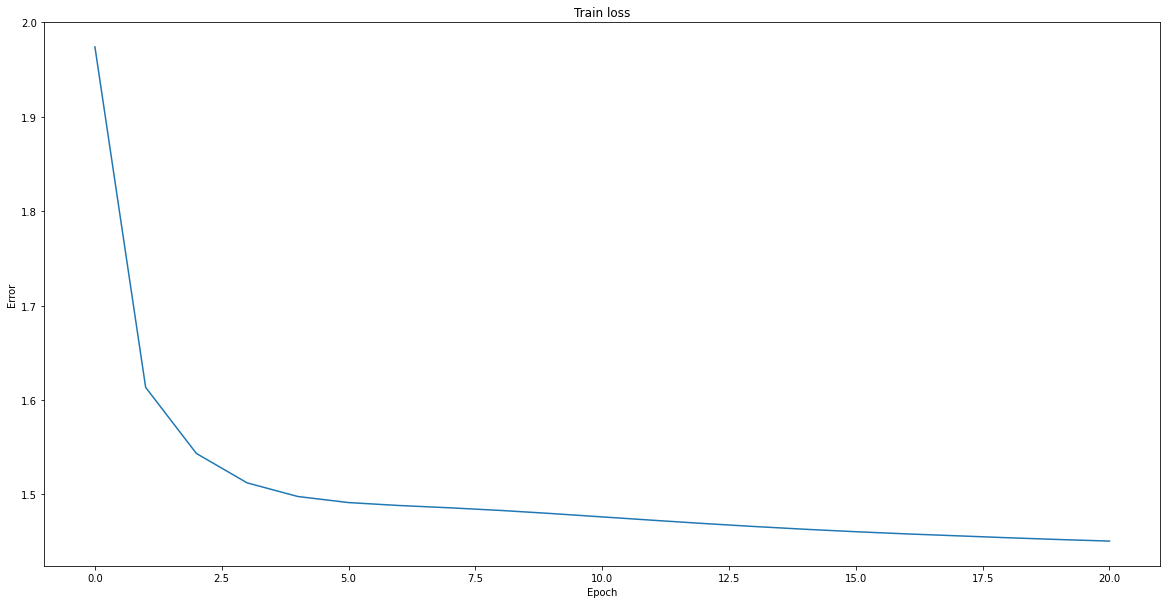

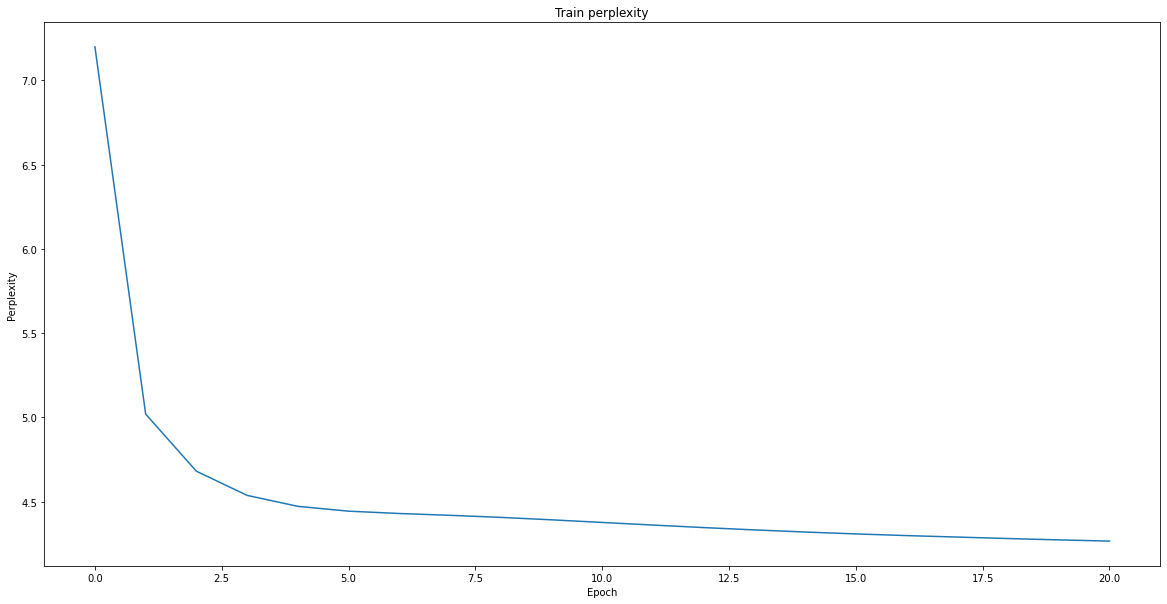

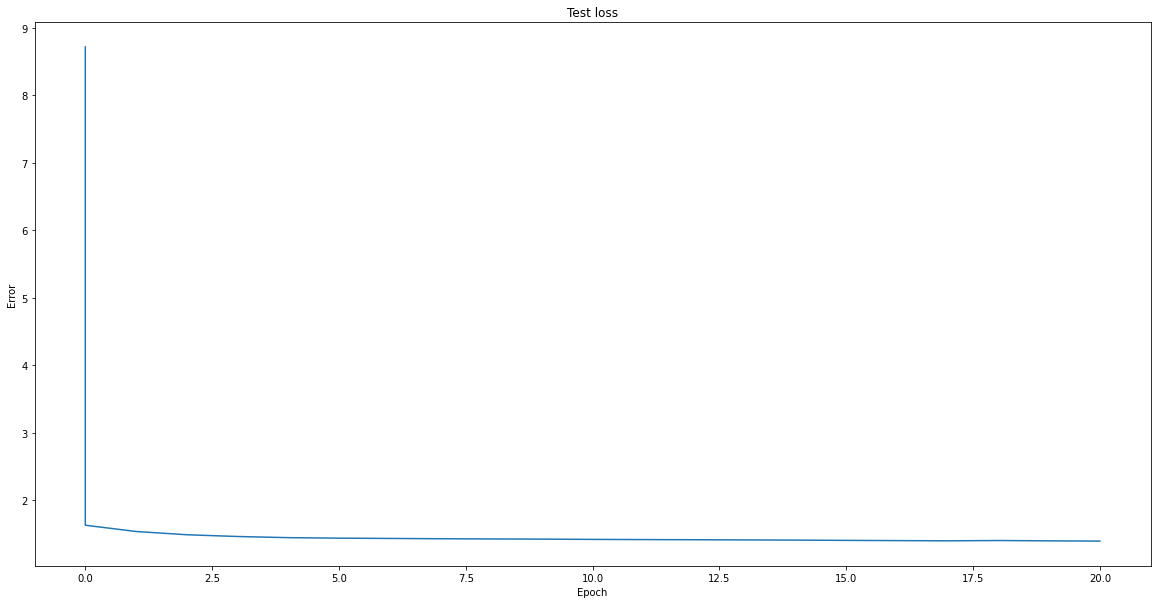

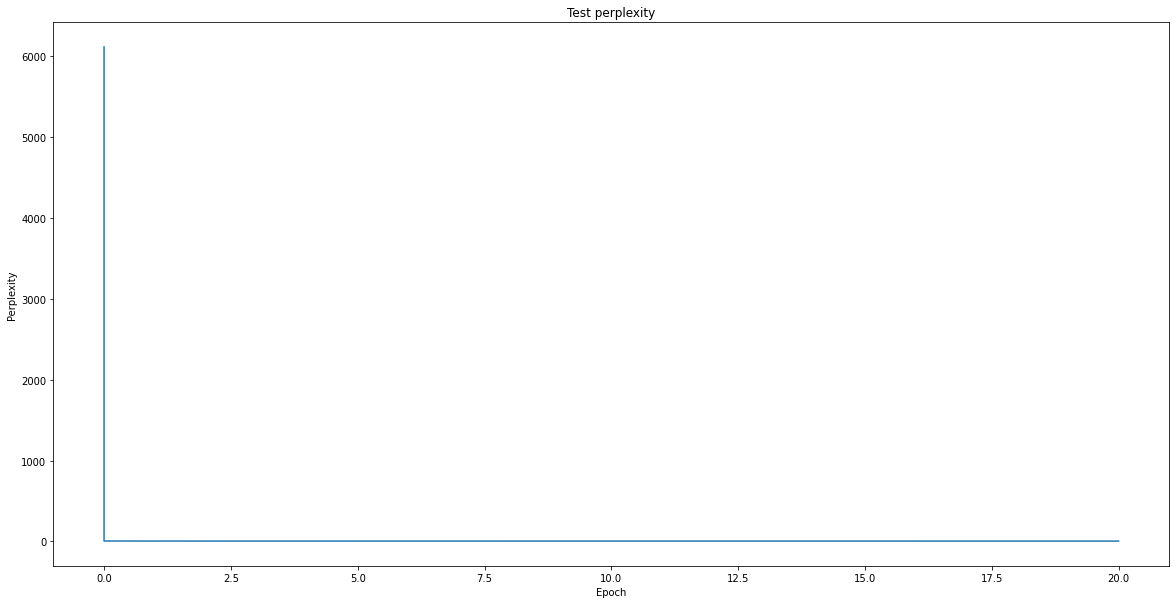

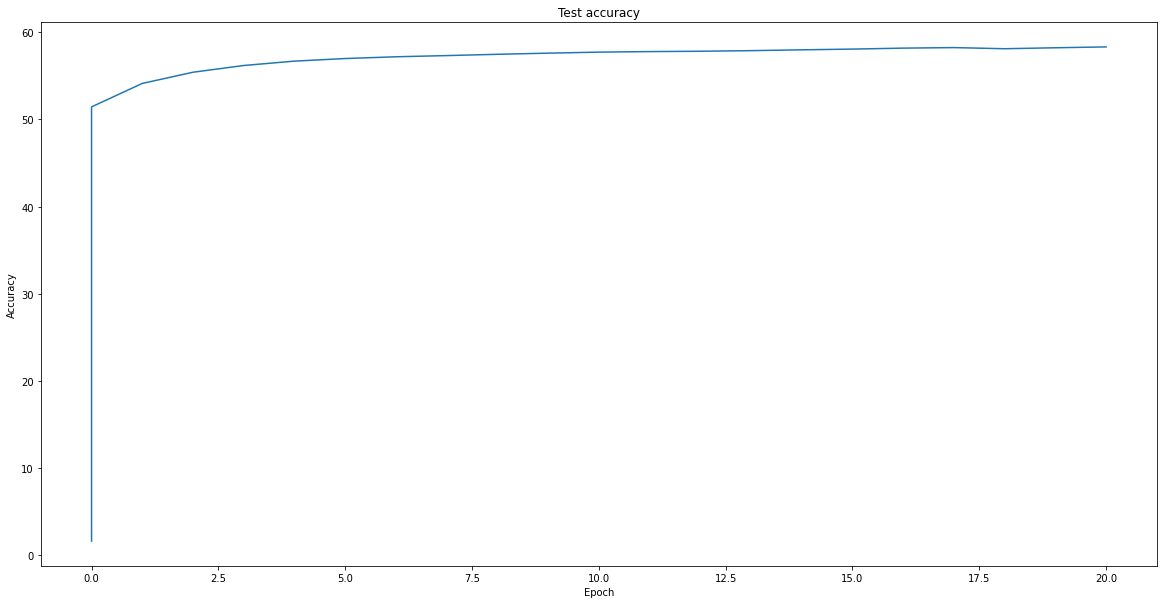

In [23]:
def main():
    SEQUENCE_LENGTH = 50
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log_lstm_sherlock.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'sherlock_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'sherlock_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = LSTMNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints_lstm_sherlock')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = lstm_test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = lstm_train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = lstm_test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints_lstm_sherlock/%03d.pt' % epoch)
            seed_words = 'Sherlock Holmes and Watson went to solve a case.  '
            generated_sentence = lstm_generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = lstm_generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = lstm_generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)    
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints_lstm_sherlock/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        pt_util.plot(ep, np.exp(val), 'Train perplexity', 'Epoch', 'Perplexity')

        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        pt_util.plot(ep, np.exp(val), 'Test perplexity', 'Epoch', 'Perplexity')  

        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Accuracy')
        return model, vocab, device

final_model, vocab, device = main()

In [24]:
def eval_final_model_sherlock(model, vocab, device):
    seed_words = 'Sherlock Holmes and the '
    sequence_length = 100

    generated_sentence = lstm_generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = lstm_generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = lstm_generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model_sherlock(final_model, vocab, device)

generated with max	 Sherlock Holmes and the states of the states of the states of the states of the states of the states of the states of the st
generated with sample	 Sherlock Holmes and the cases of the Rossor surface membrous forms of whub. N36. 79C..._-herform Reconstruck, and in _ Rosto
generated with sample	 Sherlock Holmes and the epi-med-uart. |. But myself. I. The Roosemer of Macoma, appared by the stret mary swokling. I gave y
generated with sample	 Sherlock Holmes and the Ule had enmerace. It had the his native of those vois, that the settle of EBhigo vay, they revel he 
generated with sample	 Sherlock Holmes and the deaterial parests._--bly must be considered to Nell that people as a hingly even everyheldge or intr
generated with sample	 Sherlock Holmes and the inclus of this crops my bring, hould be one a miles of drar vague, but where unever cions, own of qu
generated with sample	 Sherlock Holmes and the hyor and musita as to be subdomen on my ciffirder may be renonicatel

#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. LSTM
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    

ALL ANSWERS IN short_answer.pdf